# Next-Frame Video Prediction with `VAPAAD` Model

## VAPAAD Model Overview

The VAPAAD model is a cutting-edge video processing framework that leverages data augmentation, `ConvLSTM2D` layers, and `self-attention` mechanisms to enhance the analysis and interpretation of video data. By introducing data augmentation, the model gains robustness and better generalizes to unseen videos. The `ConvLSTM2D` layers enable the model to extract spatial-temporal features, essential for understanding the dynamics within video sequences. The integration of self-attention mechanisms allows the model to focus on the most relevant parts of the video, improving the model's efficiency and performance. Finally, a `Conv3D` layer compiles the processed information into a coherent output, making `VAPAAD` highly effective for complex video analysis tasks.

## Setup

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [5]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

819200096/819200096 [==============================] - 20s 0us/step
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 3.3 s, sys: 3.62 s, total: 6.92 s
Wall time: 20.9 s


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 587.


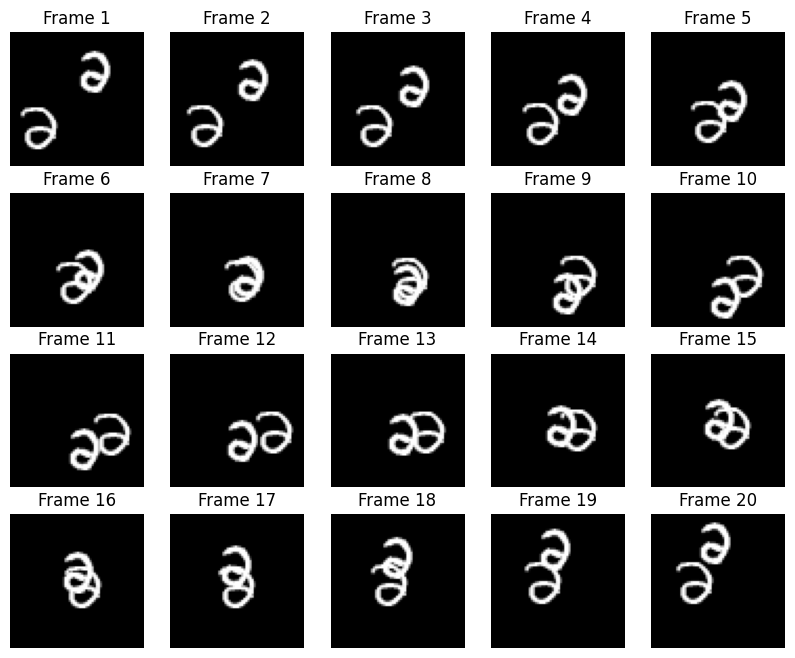

CPU times: user 1.28 s, sys: 201 ms, total: 1.48 s
Wall time: 1.26 s


In [6]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [7]:
import matplotlib.pyplot as plt

def plot_image_sequences(x_train, y_train, num_samples=5):
    """
    Plots sequences of input and output images for a number of samples, with titles.

    Args:
    x_train (np.ndarray): Input image sequences.
    y_train (np.ndarray): Output image sequences.
    num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 38, figsize=(38, num_samples * 2))  # Adjusted figsize for title space
    fig.suptitle("Sample Input/Output Sequence Images from Moving MNIST", fontsize=25, y=1.05)
    plt.figtext(0.5, 1.01, "First 19 frames are input sequences whereas latter 19 frames are output sequences",
                ha='center', fontsize=25, va='top')

    for i in range(num_samples):
        for j in range(19):  # Plot input images
            axes[i, j].imshow(x_train[i, j, :, :, 0], cmap='gray')
            axes[i, j].set_title(f'Frame {j + 1}', fontsize=8)
            axes[i, j].axis('off')
        for j in range(19):  # Plot output images
            axes[i, j + 19].imshow(y_train[i, j, :, :, 0], cmap='gray')
            axes[i, j + 19].set_title(f'Frame {j + 20}', fontsize=8)
            axes[i, j + 19].axis('off')

    plt.tight_layout()
    plt.show()

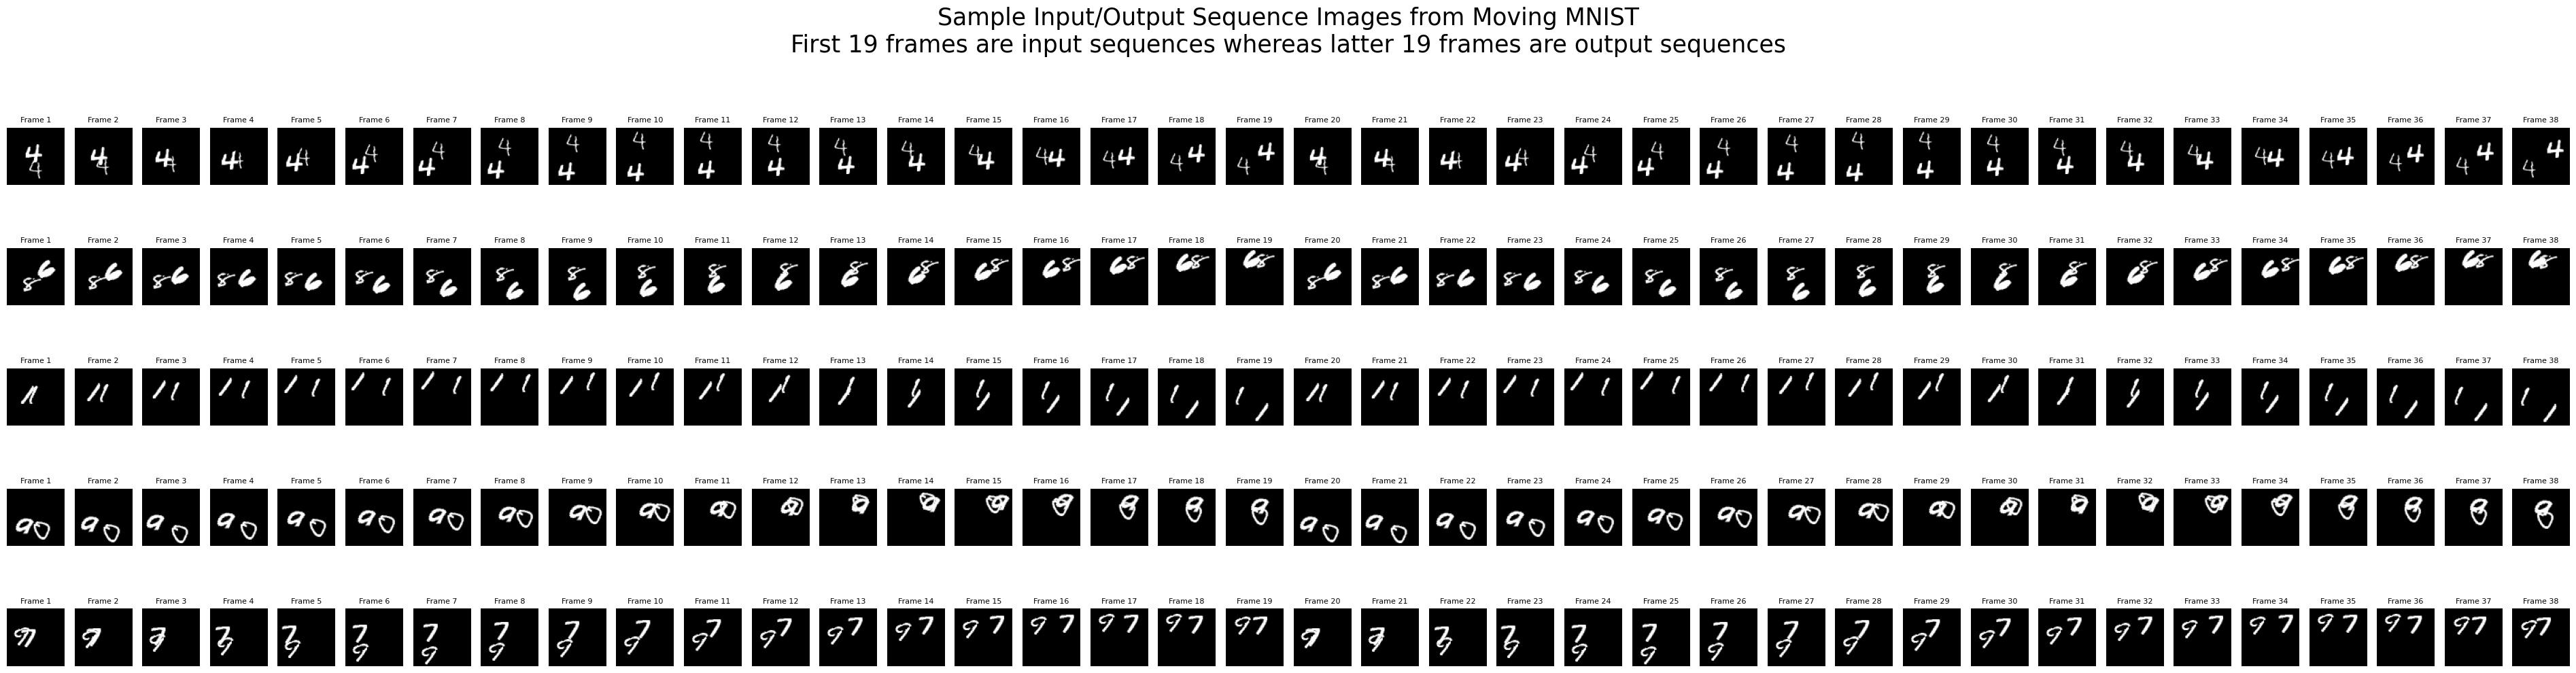

CPU times: user 11.9 s, sys: 318 ms, total: 12.3 s
Wall time: 11.9 s


In [8]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## `VAPAAD` Model

To build a Convolutional LSTM model, we will use the `ConvLSTM2D` layer, which will accept inputs of shape `(batch_size, num_frames, width, height, channels)`, and return a prediction movie of the same shape.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from typing import Tuple

class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output

In [10]:
# input shape
(None, *x_train.shape[2:])

(None, 64, 64, 1)

In [38]:
from typing import Tuple
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def vapaad(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model with data augmentation and self-attention mechanisms.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomFlip("horizontal"),  # Randomly flip frames horizontally
        # layers.RandomRotation(factor=0.02),  # Randomly rotate frames by a small angle
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)  # Define the input layer with the specified shape

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # First ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the first layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Second ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the second layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Third ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Final Conv3D layer to produce the output
    x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=x)

    # Return
    return model

In [39]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
generator = vapaad(input_shape=(None, *x_train.shape[2:]))

## Instructor Model

In [40]:
# Instructor model
def instructor_model(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model ending with fully connected layers.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training with a one-dimensional output.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # ConvLSTM2D layers with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = SelfAttention()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = SelfAttention()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)

    # Adding global average pooling to reduce the dimensionality before dense layers
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected dense layers
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)

    # Final dense layer for one-dimensional output
    output = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=output)

    return model

In [41]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
instructor = instructor_model(input_shape=(None, *x_train.shape[2:]))

In [42]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
import tensorflow as tf

def generator_loss(fake_output: tf.Tensor) -> tf.Tensor:
    """
    Calculates the loss for the generator model based on its output for generated (fake) images.

    The loss encourages the generator to produce images that the instructor model classifies as real.
    This is achieved by comparing the generator's output for fake images against a target tensor of ones,
    indicating that the ideal output of the generator would be classified as real by the instructor model.

    Args:
    fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

    Returns:
    tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [28]:
import tensorflow as tf

def instructor_loss(real_output: tf.Tensor, fake_output: tf.Tensor) -> tf.Tensor:
    """
    Calculates the loss for the instructor model based on its output for real and generated (fake) images.

    The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
    the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

    Args:
    real_output (tf.Tensor): The instructor model's output logits for real images.
    fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

    Returns:
    tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
    """
    # Cross-entropy loss for real images (targets are ones)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Cross-entropy loss for fake images (targets are zeros)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Sum of real and fake losses
    total_loss = real_loss + fake_loss
    return total_loss

In [43]:
# define two separate optimizer for the generator and the instructor
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
instructor_optimizer = tf.keras.optimizers.Adam(1e-4)

In [44]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

# Ensure the generator and instructor models, as well as their optimizers,
# are defined outside of this function, at a global level or before calling this train function.

@tf.function
def train_step(images, future_images):
    """
    Performs a single training step for the generator and instructor models.

    This function computes the loss for both the generator and instructor models using the provided
    images and future_images, then updates both models' weights based on these losses.

    Args:
    images: The input images for the generator model.
    future_images: The real images to compare against the generated images by the instructor model.
    """
    # Open a GradientTape scope to record the operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
        # Generate images from the input images using the generator model.
        generated_images = generator(images, training=True)
        # Get the instructor model's output for the real future images.
        real_output = instructor(future_images, training=True)
        # Get the instructor model's output for the generated images.
        fake_output = instructor(generated_images, training=True)

        # Calculate the loss for the generator based on the instructor's output for the generated images.
        gen_loss = generator_loss(fake_output)
        # Calculate the loss for the instructor based on its output for both real and generated images.
        inst_loss = instructor_loss(real_output, fake_output)

    # Calculate the gradients of the loss with respect to the generator's variables.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Calculate the gradients of the loss with respect to the instructor's variables.
    gradients_of_instructor = inst_tape.gradient(inst_loss, instructor.trainable_variables)

    # Apply the gradients to the generator's variables to update its weights.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Apply the gradients to the instructor's variables to update its weights.
    instructor_optimizer.apply_gradients(zip(gradients_of_instructor, instructor.trainable_variables))

    # Print the generator loss using tf.print
    tf.print(f" Generator Loss:", gen_loss, "; Instructor Loss:", inst_loss,)

In [45]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
from typing import Tuple

def train(x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int = 64) -> None:
    """
    Trains the model for a given number of epochs with specified batch size.

    This function iterates over the entire dataset for a specified number of epochs,
    randomly selecting batches of data to perform training steps. The selection is random
    and without replacement within each epoch, ensuring diverse exposure of data.

    Args:
    x_train (np.ndarray): The input training data.
    y_train (np.ndarray): The target training data.
    epochs (int): The number of times to iterate over the entire dataset.
    batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

    Returns:
    None
    """
    # Determine the number of samples in the training dataset.
    n_samples = x_train.shape[0]

    # Iterate over the dataset for the specified number of epochs.
    for epoch in range(epochs):
        start = time.time()  # Record the start time of the epoch.
        indices = np.arange(n_samples)  # Create an array of indices corresponding to the dataset.
        np.random.shuffle(indices)  # Shuffle the indices to ensure random batch selection.

        # Iterate over the dataset in batches.
        for i in tqdm(range(0, n_samples, batch_size)):
            selected_indices = np.random.choice(indices, size=batch_size, replace=False)  # Randomly select indices for the batch.
            x_batch = x_train[selected_indices]  # Extract the batch of input data.
            y_batch = y_train[selected_indices]  # Extract the batch of target data.
            train_step(x_batch, y_batch)  # Perform a training step with the selected batch.

        # Print the time taken to complete the epoch.
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

In [46]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


In [47]:
# Check gpu
tf.test.gpu_device_name()

''

In [48]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [24]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[ 35 214 775 190 741 582]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


Assemble everything together.

## Model Training

With our model and data constructed, we can now train the model.

In [72]:
900 // 4

225

In [73]:
# Example usage:
with tf.device('/device:GPU:0'):
    train(x_train_sub, y_train_sub, epochs=1, batch_size=1)

  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 9.52334213 ; Instructor Loss: 0.00564161781


  2%|▏         | 1/64 [00:00<00:49,  1.27it/s]

 Generator Loss: 9.34118462 ; Instructor Loss: 0.0013178892


  3%|▎         | 2/64 [00:01<00:46,  1.33it/s]

 Generator Loss: 9.72927475 ; Instructor Loss: 0.000791878032


  5%|▍         | 3/64 [00:02<00:45,  1.36it/s]

 Generator Loss: 8.7547884 ; Instructor Loss: 0.00189416879


  6%|▋         | 4/64 [00:02<00:44,  1.36it/s]

 Generator Loss: 9.38038 ; Instructor Loss: 0.0196117014


  8%|▊         | 5/64 [00:03<00:43,  1.37it/s]

 Generator Loss: 8.2811079 ; Instructor Loss: 0.000484173681


  9%|▉         | 6/64 [00:04<00:42,  1.37it/s]

 Generator Loss: 8.14978886 ; Instructor Loss: 0.000468282204


 11%|█         | 7/64 [00:05<00:41,  1.36it/s]

 Generator Loss: 7.95832205 ; Instructor Loss: 0.000353486015


 12%|█▎        | 8/64 [00:05<00:41,  1.36it/s]

 Generator Loss: 8.64191246 ; Instructor Loss: 0.001013375


 14%|█▍        | 9/64 [00:06<00:40,  1.37it/s]

 Generator Loss: 8.35143757 ; Instructor Loss: 0.0078693768


 16%|█▌        | 10/64 [00:07<00:39,  1.37it/s]

 Generator Loss: 8.0595417 ; Instructor Loss: 0.00119782472


 17%|█▋        | 11/64 [00:08<00:38,  1.37it/s]

 Generator Loss: 8.22945786 ; Instructor Loss: 0.00126400846


 19%|█▉        | 12/64 [00:08<00:37,  1.37it/s]

 Generator Loss: 8.50841713 ; Instructor Loss: 0.0078529967


 20%|██        | 13/64 [00:09<00:37,  1.37it/s]

 Generator Loss: 8.37742 ; Instructor Loss: 0.00300039933


 22%|██▏       | 14/64 [00:10<00:36,  1.37it/s]

 Generator Loss: 8.47726 ; Instructor Loss: 0.000952805858


 23%|██▎       | 15/64 [00:10<00:35,  1.37it/s]

 Generator Loss: 8.48111153 ; Instructor Loss: 0.000487670273


 25%|██▌       | 16/64 [00:11<00:35,  1.37it/s]

 Generator Loss: 8.64687824 ; Instructor Loss: 0.000255380059


 27%|██▋       | 17/64 [00:12<00:34,  1.37it/s]

 Generator Loss: 9.09322643 ; Instructor Loss: 0.00427642092


 28%|██▊       | 18/64 [00:13<00:33,  1.36it/s]

 Generator Loss: 8.7548 ; Instructor Loss: 0.00406319089


 30%|██▉       | 19/64 [00:13<00:33,  1.36it/s]

 Generator Loss: 8.94573689 ; Instructor Loss: 0.000184168224


 31%|███▏      | 20/64 [00:14<00:32,  1.36it/s]

 Generator Loss: 9.15171242 ; Instructor Loss: 0.00116247928


 33%|███▎      | 21/64 [00:15<00:31,  1.35it/s]

 Generator Loss: 8.93443584 ; Instructor Loss: 0.000147324739


 34%|███▍      | 22/64 [00:16<00:31,  1.35it/s]

 Generator Loss: 9.1050148 ; Instructor Loss: 0.000413495174


 36%|███▌      | 23/64 [00:16<00:30,  1.35it/s]

 Generator Loss: 9.01648903 ; Instructor Loss: 0.000230131467


 38%|███▊      | 24/64 [00:17<00:29,  1.35it/s]

 Generator Loss: 9.02070522 ; Instructor Loss: 0.000860623666


 39%|███▉      | 25/64 [00:18<00:28,  1.35it/s]

 Generator Loss: 9.3147049 ; Instructor Loss: 0.000269610406


 41%|████      | 26/64 [00:19<00:28,  1.35it/s]

 Generator Loss: 9.27727604 ; Instructor Loss: 0.000274173624


 42%|████▏     | 27/64 [00:19<00:27,  1.35it/s]

 Generator Loss: 9.56865597 ; Instructor Loss: 9.1218e-05


 44%|████▍     | 28/64 [00:20<00:26,  1.35it/s]

 Generator Loss: 9.5297184 ; Instructor Loss: 0.000521796406


 45%|████▌     | 29/64 [00:21<00:25,  1.35it/s]

 Generator Loss: 9.35414124 ; Instructor Loss: 0.00193660264


 47%|████▋     | 30/64 [00:22<00:25,  1.35it/s]

 Generator Loss: 9.48174667 ; Instructor Loss: 8.58615385e-05


 48%|████▊     | 31/64 [00:22<00:24,  1.34it/s]

 Generator Loss: 9.54437065 ; Instructor Loss: 0.000116992764


 50%|█████     | 32/64 [00:23<00:23,  1.34it/s]

 Generator Loss: 9.59698486 ; Instructor Loss: 0.000305493915


 52%|█████▏    | 33/64 [00:24<00:23,  1.33it/s]

 Generator Loss: 9.48508835 ; Instructor Loss: 0.000113949864


 53%|█████▎    | 34/64 [00:25<00:22,  1.33it/s]

 Generator Loss: 9.63667774 ; Instructor Loss: 0.000295260514


 55%|█████▍    | 35/64 [00:25<00:21,  1.33it/s]

 Generator Loss: 9.71863079 ; Instructor Loss: 0.0013367444


 56%|█████▋    | 36/64 [00:26<00:21,  1.32it/s]

 Generator Loss: 9.87258148 ; Instructor Loss: 0.00092837296


 58%|█████▊    | 37/64 [00:27<00:20,  1.33it/s]

 Generator Loss: 9.83659077 ; Instructor Loss: 7.07077925e-05


 59%|█████▉    | 38/64 [00:28<00:19,  1.32it/s]

 Generator Loss: 9.98011875 ; Instructor Loss: 0.000120641082


 61%|██████    | 39/64 [00:28<00:18,  1.33it/s]

 Generator Loss: 9.92805862 ; Instructor Loss: 0.000610353425


 62%|██████▎   | 40/64 [00:29<00:18,  1.32it/s]

 Generator Loss: 9.97925377 ; Instructor Loss: 0.00145443738


 64%|██████▍   | 41/64 [00:30<00:17,  1.33it/s]

 Generator Loss: 10.0423126 ; Instructor Loss: 0.000373141462


 66%|██████▌   | 42/64 [00:31<00:16,  1.33it/s]

 Generator Loss: 10.063508 ; Instructor Loss: 0.000392354559


 67%|██████▋   | 43/64 [00:31<00:15,  1.33it/s]

 Generator Loss: 10.2066031 ; Instructor Loss: 0.00581733882


 69%|██████▉   | 44/64 [00:32<00:15,  1.33it/s]

 Generator Loss: 9.92899513 ; Instructor Loss: 0.000354182645


 70%|███████   | 45/64 [00:33<00:14,  1.33it/s]

 Generator Loss: 9.95719719 ; Instructor Loss: 6.27807385e-05


 72%|███████▏  | 46/64 [00:34<00:13,  1.33it/s]

 Generator Loss: 10.3143673 ; Instructor Loss: 0.00271636597


 73%|███████▎  | 47/64 [00:34<00:12,  1.33it/s]

 Generator Loss: 10.1335325 ; Instructor Loss: 6.28235503e-05


 75%|███████▌  | 48/64 [00:35<00:12,  1.33it/s]

 Generator Loss: 10.1103106 ; Instructor Loss: 5.40143155e-05


 77%|███████▋  | 49/64 [00:36<00:11,  1.33it/s]

 Generator Loss: 10.1861134 ; Instructor Loss: 3.96372889e-05


 78%|███████▊  | 50/64 [00:37<00:10,  1.33it/s]

 Generator Loss: 10.3996 ; Instructor Loss: 0.000105429404


 80%|███████▉  | 51/64 [00:37<00:09,  1.31it/s]

 Generator Loss: 10.2003078 ; Instructor Loss: 4.51309024e-05


 81%|████████▏ | 52/64 [00:38<00:09,  1.32it/s]

 Generator Loss: 10.3014488 ; Instructor Loss: 6.51864248e-05


 83%|████████▎ | 53/64 [00:39<00:08,  1.32it/s]

 Generator Loss: 10.0422897 ; Instructor Loss: 9.43256891e-05


 84%|████████▍ | 54/64 [00:40<00:07,  1.33it/s]

 Generator Loss: 10.2734957 ; Instructor Loss: 6.63464234e-05


 86%|████████▌ | 55/64 [00:40<00:06,  1.33it/s]

 Generator Loss: 10.1599655 ; Instructor Loss: 0.000130077591


 88%|████████▊ | 56/64 [00:41<00:06,  1.33it/s]

 Generator Loss: 10.3368368 ; Instructor Loss: 5.42698835e-05


 89%|████████▉ | 57/64 [00:42<00:05,  1.32it/s]

 Generator Loss: 10.3800602 ; Instructor Loss: 7.82976858e-05


 91%|█████████ | 58/64 [00:43<00:04,  1.32it/s]

 Generator Loss: 10.4145098 ; Instructor Loss: 4.55214904e-05


 92%|█████████▏| 59/64 [00:43<00:03,  1.33it/s]

 Generator Loss: 10.4122276 ; Instructor Loss: 4.26854021e-05


 94%|█████████▍| 60/64 [00:44<00:03,  1.33it/s]

 Generator Loss: 10.3301868 ; Instructor Loss: 0.000134346861


 95%|█████████▌| 61/64 [00:45<00:02,  1.33it/s]

 Generator Loss: 10.3631964 ; Instructor Loss: 0.000444658595


 97%|█████████▋| 62/64 [00:46<00:01,  1.34it/s]

 Generator Loss: 10.3797541 ; Instructor Loss: 4.15730246e-05


 98%|█████████▊| 63/64 [00:46<00:00,  1.32it/s]

 Generator Loss: 10.5114317 ; Instructor Loss: 0.000244992843


100%|██████████| 64/64 [00:47<00:00,  1.34it/s]

Time for epoch 1 is 47.723350524902344 sec


Create graphical visualization of the model.

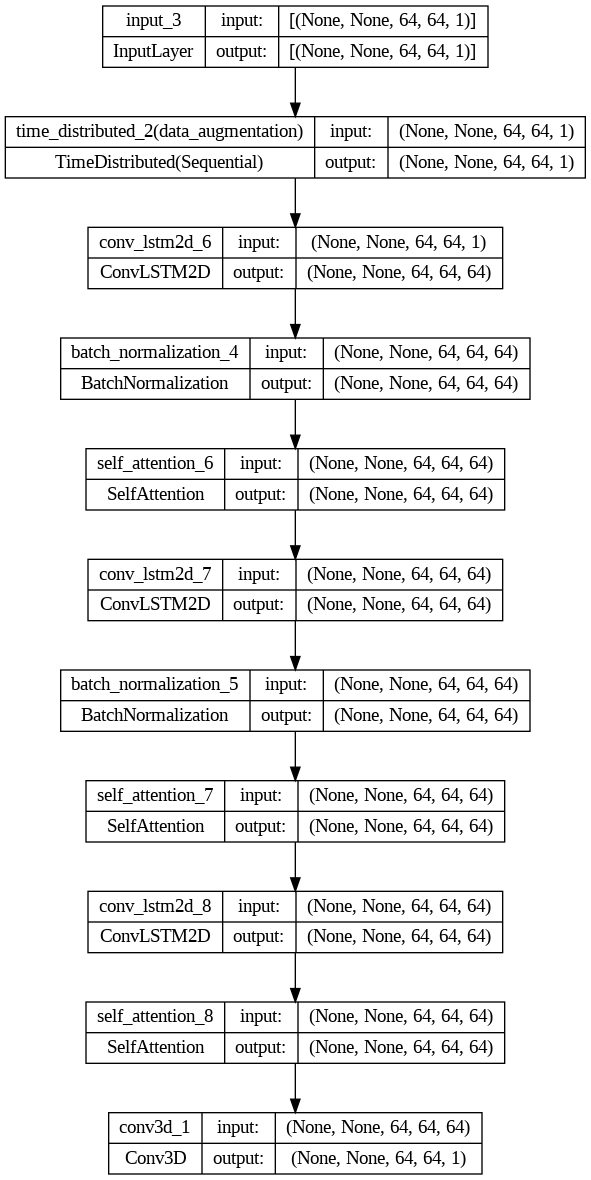

In [74]:
tf.keras.utils.plot_model(generator, show_shapes=True)

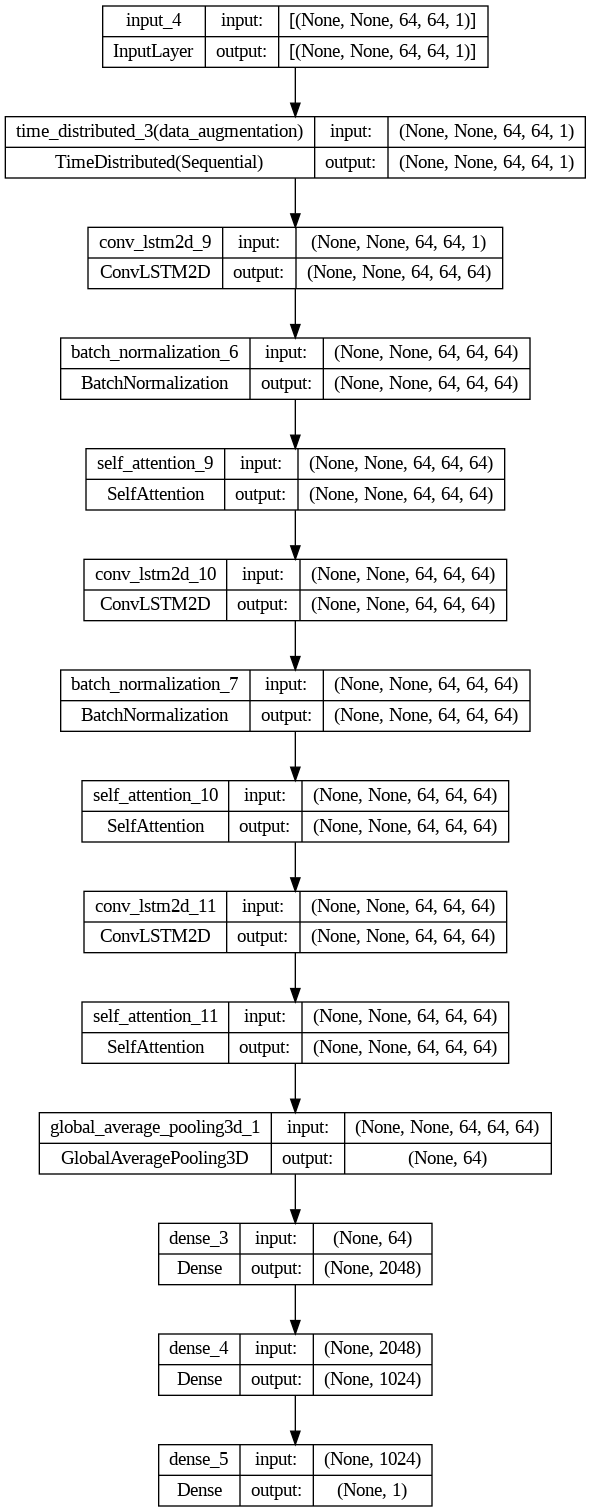

In [75]:
tf.keras.utils.plot_model(instructor, show_shapes=True)

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

In [25]:
generator.predict

<bound method Model.predict of <keras.src.engine.functional.Functional object at 0x781260570e80>>

1/1 [==============================] - 0s 92ms/step


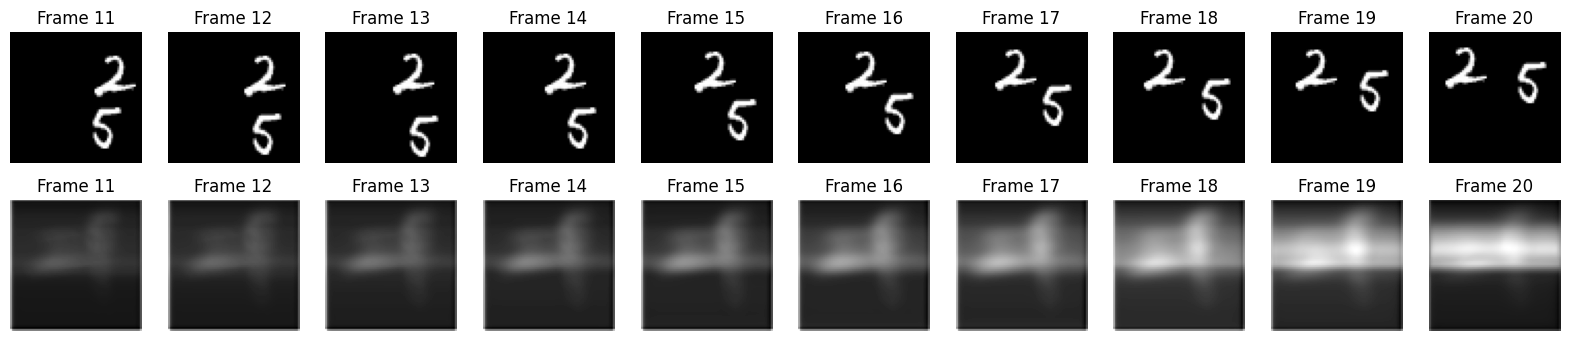

In [77]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the generator's prediction and post-process it.
    new_prediction = generator.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

In [78]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", duration=200)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 80ms/step
 Truth	Prediction


Create `.gif` files.

In [79]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = generator.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=0.2)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 0s 83ms/step
Truth	Prediction


In [30]:
11 % 5

1

## Brute force: Train a lot!

In [36]:
tf.test.gpu_device_name() != ''

False

In [49]:
%%time

for i in range(50):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 64
    indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            train(x_train_sub, y_train_sub, epochs=1, batch_size=1)
    else:
        train(x_train_sub, y_train_sub, epochs=1, batch_size=1)

    if i % 5 == 0:
        # Create a directory for the GIFs
        gif_dir = f"predicted_gifs_instruct_vapaad_test{i}"
        os.makedirs(gif_dir, exist_ok=True)

        # Select a few random examples from the dataset.
        examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

        # Iterate over the examples and predict the frames.
        predicted_videos = []
        for index, example in enumerate(examples):
            # Pick the first/last ten frames from the example.
            frames = example[:10, ...]
            original_frames = example[10:, ...]
            new_predictions = np.zeros(shape=(10, *frames[0].shape))

            # Predict a new set of 10 frames.
            for i in range(10):
                # Extract the generator's prediction and post-process it.
                frames = example[: 10 + i + 1, ...]
                new_prediction = generator.predict(np.expand_dims(frames, axis=0))
                new_prediction = np.squeeze(new_prediction, axis=0)
                predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

                # Extend the set of prediction frames.
                new_predictions[i] = predicted_frame

            # Create and save GIFs for each of the ground truth/prediction images.
            for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
                # Construct a GIF from the selected video frames.
                current_frames = np.squeeze(frame_set)
                current_frames = current_frames[..., np.newaxis] * np.ones(3)
                current_frames = (current_frames * 255).astype(np.uint8)
                current_frames = list(current_frames)

                # Define the GIF filepath
                gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

                # Save the GIF
                imageio.mimsave(gif_filename, current_frames, "GIF", duration=0.2)

                # To display the videos inline, you can open and read the saved GIF
                with open(gif_filename, 'rb') as gif_file:
                    predicted_videos.append(gif_file.read())

        # Display the videos inline in the notebook.
        print("Truth\tPrediction")
        for i in range(0, len(predicted_videos), 2):
            box = HBox(
                [
                    widgets.Image(value=predicted_videos[i], format='gif'),
                    widgets.Image(value=predicted_videos[i + 1], format='gif'),
                ]
            )
            display(box)


[429 751 221 676  99 413]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 0.631319463 ; Instructor Loss: 1.426296


  2%|▏         | 1/64 [00:53<56:26, 53.75s/it]

 Generator Loss: 0.759066105 ; Instructor Loss: 1.30219257


  3%|▎         | 2/64 [01:03<28:32, 27.63s/it]

 Generator Loss: 0.950519502 ; Instructor Loss: 1.15349567


  5%|▍         | 3/64 [01:11<19:21, 19.04s/it]

 Generator Loss: 1.21305645 ; Instructor Loss: 1.01431811


  6%|▋         | 4/64 [01:21<15:08, 15.14s/it]

 Generator Loss: 1.75668561 ; Instructor Loss: 0.817700684


  8%|▊         | 5/64 [01:30<12:48, 13.02s/it]

 Generator Loss: 2.66695809 ; Instructor Loss: 0.669386387


  9%|▉         | 6/64 [01:38<11:08, 11.52s/it]

 Generator Loss: 3.51767755 ; Instructor Loss: 0.576769888


 11%|█         | 7/64 [01:47<10:10, 10.71s/it]

 Generator Loss: 3.53394461 ; Instructor Loss: 0.497605681


 12%|█▎        | 8/64 [01:56<09:24, 10.08s/it]

 Generator Loss: 4.40436459 ; Instructor Loss: 0.367578685


 14%|█▍        | 9/64 [02:05<08:54,  9.72s/it]

 Generator Loss: 3.03759 ; Instructor Loss: 0.23377277


 16%|█▌        | 10/64 [02:14<08:33,  9.51s/it]

 Generator Loss: 2.75929308 ; Instructor Loss: 0.176764637


 17%|█▋        | 11/64 [02:23<08:10,  9.25s/it]

 Generator Loss: 4.12413311 ; Instructor Loss: 0.070611082


 19%|█▉        | 12/64 [02:32<07:58,  9.20s/it]

 Generator Loss: 4.13846302 ; Instructor Loss: 0.043042846


 20%|██        | 13/64 [02:41<07:45,  9.14s/it]

 Generator Loss: 5.8906827 ; Instructor Loss: 0.0114371199


 22%|██▏       | 14/64 [02:50<07:30,  9.01s/it]

 Generator Loss: 7.13023472 ; Instructor Loss: 0.0079660723


 23%|██▎       | 15/64 [02:59<07:22,  9.02s/it]

 Generator Loss: 3.11814737 ; Instructor Loss: 0.0455626734


 25%|██▌       | 16/64 [03:07<07:06,  8.89s/it]

 Generator Loss: 2.46528339 ; Instructor Loss: 0.089130275


 27%|██▋       | 17/64 [03:16<07:00,  8.94s/it]

 Generator Loss: 6.24712276 ; Instructor Loss: 0.00220679026


 28%|██▊       | 18/64 [03:25<06:52,  8.96s/it]

 Generator Loss: 3.94996595 ; Instructor Loss: 0.0195622668


 30%|██▉       | 19/64 [03:34<06:39,  8.87s/it]

 Generator Loss: 6.22165442 ; Instructor Loss: 0.00202146382


 31%|███▏      | 20/64 [03:43<06:32,  8.91s/it]

 Generator Loss: 3.37483668 ; Instructor Loss: 0.0348312296


 33%|███▎      | 21/64 [03:52<06:19,  8.83s/it]

 Generator Loss: 5.97139597 ; Instructor Loss: 0.00258521736


 34%|███▍      | 22/64 [04:01<06:12,  8.88s/it]

 Generator Loss: 8.56082153 ; Instructor Loss: 0.000191636369


 36%|███▌      | 23/64 [04:10<06:06,  8.93s/it]

 Generator Loss: 12.0119495 ; Instructor Loss: 1.00439447e-05


 38%|███▊      | 24/64 [04:18<05:53,  8.85s/it]

 Generator Loss: 11.3846312 ; Instructor Loss: 6.73312097e-05


 39%|███▉      | 25/64 [04:27<05:47,  8.91s/it]

 Generator Loss: 3.35225248 ; Instructor Loss: 0.0356435366


 41%|████      | 26/64 [04:36<05:37,  8.88s/it]

 Generator Loss: 0.13874732 ; Instructor Loss: 2.04367256


 42%|████▏     | 27/64 [04:45<05:29,  8.91s/it]

 Generator Loss: 3.35822773 ; Instructor Loss: 0.035451889


 44%|████▍     | 28/64 [04:54<05:22,  8.95s/it]

 Generator Loss: 5.11304712 ; Instructor Loss: 0.00605938165


 45%|████▌     | 29/64 [05:03<05:09,  8.84s/it]

 Generator Loss: 0.812688351 ; Instructor Loss: 0.589662731


 47%|████▋     | 30/64 [05:12<05:03,  8.93s/it]

 Generator Loss: 2.72240925 ; Instructor Loss: 0.068099834


 48%|████▊     | 31/64 [05:21<04:52,  8.85s/it]

 Generator Loss: 7.11750317 ; Instructor Loss: 0.0071256971


 50%|█████     | 32/64 [05:30<04:43,  8.87s/it]

 Generator Loss: 4.51656485 ; Instructor Loss: 0.0269528478


 52%|█████▏    | 33/64 [05:39<04:36,  8.92s/it]

 Generator Loss: 1.50254571 ; Instructor Loss: 0.263130516


 53%|█████▎    | 34/64 [05:47<04:24,  8.83s/it]

 Generator Loss: 1.69847989 ; Instructor Loss: 0.205667824


 55%|█████▍    | 35/64 [05:56<04:18,  8.91s/it]

 Generator Loss: 1.91533935 ; Instructor Loss: 0.176195264


 56%|█████▋    | 36/64 [06:05<04:10,  8.96s/it]

 Generator Loss: 1.53800476 ; Instructor Loss: 0.245887488


 58%|█████▊    | 37/64 [06:14<04:00,  8.90s/it]

 Generator Loss: 1.1580106 ; Instructor Loss: 1.16286504


 59%|█████▉    | 38/64 [06:23<03:52,  8.94s/it]

 Generator Loss: 1.3557905 ; Instructor Loss: 3.58700442


 61%|██████    | 39/64 [06:32<03:41,  8.87s/it]

 Generator Loss: 0.734428763 ; Instructor Loss: 0.654497445


 62%|██████▎   | 40/64 [06:41<03:33,  8.91s/it]

 Generator Loss: 0.687299 ; Instructor Loss: 0.699091733


 64%|██████▍   | 41/64 [06:50<03:25,  8.94s/it]

 Generator Loss: 0.669797361 ; Instructor Loss: 0.717062891


 66%|██████▌   | 42/64 [06:59<03:15,  8.88s/it]

 Generator Loss: 0.663805425 ; Instructor Loss: 0.723378718


 67%|██████▋   | 43/64 [07:08<03:07,  8.94s/it]

 Generator Loss: 0.668180883 ; Instructor Loss: 0.718777239


 69%|██████▉   | 44/64 [07:17<02:58,  8.91s/it]

 Generator Loss: 0.659279048 ; Instructor Loss: 0.72826463


 70%|███████   | 45/64 [07:26<02:50,  8.95s/it]

 Generator Loss: 0.645219 ; Instructor Loss: 0.74348855


 72%|███████▏  | 46/64 [07:35<02:42,  9.05s/it]

 Generator Loss: 0.704508901 ; Instructor Loss: 0.681913257


 73%|███████▎  | 47/64 [07:44<02:33,  9.01s/it]

 Generator Loss: 0.719290495 ; Instructor Loss: 0.667670608


 75%|███████▌  | 48/64 [07:53<02:25,  9.10s/it]

 Generator Loss: 0.710619271 ; Instructor Loss: 0.675975263


 77%|███████▋  | 49/64 [08:03<02:18,  9.23s/it]

 Generator Loss: 0.681092739 ; Instructor Loss: 0.70534879


 78%|███████▊  | 50/64 [08:12<02:09,  9.22s/it]

 Generator Loss: 0.770596445 ; Instructor Loss: 0.621269226


 80%|███████▉  | 51/64 [08:21<02:00,  9.29s/it]

 Generator Loss: 0.76143837 ; Instructor Loss: 0.629223


 81%|████████▏ | 52/64 [08:31<01:51,  9.30s/it]

 Generator Loss: 0.736906528 ; Instructor Loss: 0.651222706


 83%|████████▎ | 53/64 [08:40<01:41,  9.26s/it]

 Generator Loss: 0.787870884 ; Instructor Loss: 0.606624782


 84%|████████▍ | 54/64 [08:49<01:32,  9.25s/it]

 Generator Loss: 0.730644107 ; Instructor Loss: 0.657005668


 86%|████████▌ | 55/64 [08:58<01:22,  9.18s/it]

 Generator Loss: 0.909870505 ; Instructor Loss: 0.515128851


 88%|████████▊ | 56/64 [09:07<01:13,  9.23s/it]

 Generator Loss: 0.99076575 ; Instructor Loss: 0.464088798


 89%|████████▉ | 57/64 [09:17<01:04,  9.22s/it]

 Generator Loss: 1.05220497 ; Instructor Loss: 0.429502249


 91%|█████████ | 58/64 [09:25<00:54,  9.12s/it]

 Generator Loss: 0.952364743 ; Instructor Loss: 0.487480074


 92%|█████████▏| 59/64 [09:35<00:45,  9.20s/it]

 Generator Loss: 0.956431746 ; Instructor Loss: 0.484933347


 94%|█████████▍| 60/64 [09:44<00:36,  9.15s/it]

 Generator Loss: 1.05584049 ; Instructor Loss: 0.42755875


 95%|█████████▌| 61/64 [09:53<00:27,  9.08s/it]

 Generator Loss: 1.20620918 ; Instructor Loss: 0.355727613


 97%|█████████▋| 62/64 [10:02<00:18,  9.15s/it]

 Generator Loss: 1.227543 ; Instructor Loss: 0.346741736


 98%|█████████▊| 63/64 [10:11<00:09,  9.08s/it]

 Generator Loss: 1.23092031 ; Instructor Loss: 0.345353305


100%|██████████| 64/64 [10:20<00:00,  9.70s/it]


Time for epoch 1 is 620.8166058063507 sec
1/1 [==============================] - 1s 879ms/step
Truth	Prediction


[ 70 751  68 146 698 489]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 1.30788827 ; Instructor Loss: 0.315289378


  2%|▏         | 1/64 [00:09<09:37,  9.17s/it]

 Generator Loss: 1.34165037 ; Instructor Loss: 0.303022027


  3%|▎         | 2/64 [00:17<09:13,  8.93s/it]

 Generator Loss: 1.38570952 ; Instructor Loss: 0.287905723


  5%|▍         | 3/64 [00:27<09:10,  9.02s/it]

 Generator Loss: 1.46090817 ; Instructor Loss: 0.264014304


  6%|▋         | 4/64 [00:35<08:59,  8.99s/it]

 Generator Loss: 1.5255878 ; Instructor Loss: 0.245272085


  8%|▊         | 5/64 [00:45<08:51,  9.01s/it]

 Generator Loss: 1.59987509 ; Instructor Loss: 0.225557372


  9%|▉         | 6/64 [00:54<08:49,  9.13s/it]

 Generator Loss: 1.68772542 ; Instructor Loss: 0.205222517


 11%|█         | 7/64 [01:03<08:38,  9.09s/it]

 Generator Loss: 1.78494775 ; Instructor Loss: 0.183732584


 12%|█▎        | 8/64 [01:12<08:30,  9.12s/it]

 Generator Loss: 1.9685241 ; Instructor Loss: 0.150439724


 14%|█▍        | 9/64 [01:21<08:24,  9.17s/it]

 Generator Loss: 2.0117445 ; Instructor Loss: 0.143594831


 16%|█▌        | 10/64 [01:30<08:10,  9.08s/it]

 Generator Loss: 2.11807346 ; Instructor Loss: 0.128355011


 17%|█▋        | 11/64 [01:39<08:03,  9.12s/it]

 Generator Loss: 2.25526381 ; Instructor Loss: 0.110903293


 19%|█▉        | 12/64 [01:48<07:52,  9.09s/it]

 Generator Loss: 2.41365623 ; Instructor Loss: 0.0937606


 20%|██        | 13/64 [01:58<07:46,  9.14s/it]

 Generator Loss: 2.557446 ; Instructor Loss: 0.0813912079


 22%|██▏       | 14/64 [02:07<07:39,  9.19s/it]

 Generator Loss: 2.70247078 ; Instructor Loss: 0.0700757727


 23%|██▎       | 15/64 [02:16<07:23,  9.06s/it]

 Generator Loss: 2.86719608 ; Instructor Loss: 0.0589478724


 25%|██▌       | 16/64 [02:25<07:17,  9.12s/it]

 Generator Loss: 3.04600072 ; Instructor Loss: 0.0487210639


 27%|██▋       | 17/64 [02:34<07:13,  9.21s/it]

 Generator Loss: 3.21115303 ; Instructor Loss: 0.0413080193


 28%|██▊       | 18/64 [02:43<07:00,  9.14s/it]

 Generator Loss: 3.39760947 ; Instructor Loss: 0.0345335118


 30%|██▉       | 19/64 [02:53<06:54,  9.22s/it]

 Generator Loss: 3.56606197 ; Instructor Loss: 0.0322791487


 31%|███▏      | 20/64 [03:02<06:42,  9.14s/it]

 Generator Loss: 3.75043297 ; Instructor Loss: 0.024309231


 33%|███▎      | 21/64 [03:11<06:33,  9.15s/it]

 Generator Loss: 3.94174099 ; Instructor Loss: 0.0224567652


 34%|███▍      | 22/64 [03:20<06:25,  9.18s/it]

 Generator Loss: 4.11924696 ; Instructor Loss: 0.016401628


 36%|███▌      | 23/64 [03:29<06:12,  9.07s/it]

 Generator Loss: 4.28736448 ; Instructor Loss: 0.0457767


 38%|███▊      | 24/64 [03:38<06:03,  9.10s/it]

 Generator Loss: 4.46901941 ; Instructor Loss: 0.0116909454


 39%|███▉      | 25/64 [03:47<05:54,  9.09s/it]

 Generator Loss: 4.59825659 ; Instructor Loss: 0.0110212881


 41%|████      | 26/64 [03:56<05:44,  9.06s/it]

 Generator Loss: 4.80244207 ; Instructor Loss: 0.00868189894


 42%|████▏     | 27/64 [04:06<05:37,  9.12s/it]

 Generator Loss: 4.89049244 ; Instructor Loss: 0.00754877925


 44%|████▍     | 28/64 [04:14<05:26,  9.06s/it]

 Generator Loss: 5.03258753 ; Instructor Loss: 0.0067912722


 45%|████▌     | 29/64 [04:24<05:18,  9.10s/it]

 Generator Loss: 5.16558123 ; Instructor Loss: 0.00594717357


 47%|████▋     | 30/64 [04:33<05:11,  9.16s/it]

 Generator Loss: 5.28773212 ; Instructor Loss: 0.00542120961


 48%|████▊     | 31/64 [04:42<04:58,  9.04s/it]

 Generator Loss: 5.41123486 ; Instructor Loss: 0.00512352074


 50%|█████     | 32/64 [04:51<04:50,  9.08s/it]

 Generator Loss: 5.52276087 ; Instructor Loss: 0.00516639138


 52%|█████▏    | 33/64 [05:00<04:43,  9.15s/it]

 Generator Loss: 5.63423 ; Instructor Loss: 0.0124616046


 53%|█████▎    | 34/64 [05:09<04:33,  9.11s/it]

 Generator Loss: 5.72264051 ; Instructor Loss: 0.00328530767


 55%|█████▍    | 35/64 [05:19<04:26,  9.18s/it]

 Generator Loss: 5.81728315 ; Instructor Loss: 0.00317462394


 56%|█████▋    | 36/64 [05:28<04:16,  9.16s/it]

 Generator Loss: 5.90566349 ; Instructor Loss: 0.00272773812


 58%|█████▊    | 37/64 [05:37<04:08,  9.21s/it]

 Generator Loss: 5.98414803 ; Instructor Loss: 0.00252853706


 59%|█████▉    | 38/64 [05:46<04:00,  9.27s/it]

 Generator Loss: 6.06445408 ; Instructor Loss: 0.00233024289


 61%|██████    | 39/64 [05:55<03:49,  9.18s/it]

 Generator Loss: 6.13794613 ; Instructor Loss: 0.00216216315


 62%|██████▎   | 40/64 [06:05<03:42,  9.27s/it]

 Generator Loss: 6.20388222 ; Instructor Loss: 0.00214724382


 64%|██████▍   | 41/64 [06:14<03:32,  9.25s/it]

 Generator Loss: 6.27260208 ; Instructor Loss: 0.00199735514


 66%|██████▌   | 42/64 [06:23<03:22,  9.19s/it]

 Generator Loss: 6.33272505 ; Instructor Loss: 0.0969192535


 67%|██████▋   | 43/64 [06:32<03:13,  9.23s/it]

 Generator Loss: 6.30048 ; Instructor Loss: 0.00187244848


 69%|██████▉   | 44/64 [06:42<03:04,  9.21s/it]

 Generator Loss: 6.27152729 ; Instructor Loss: 0.00199095649


 70%|███████   | 45/64 [06:51<02:54,  9.20s/it]

 Generator Loss: 6.24296761 ; Instructor Loss: 0.00194777281


 72%|███████▏  | 46/64 [07:01<02:49,  9.42s/it]

 Generator Loss: 6.22216034 ; Instructor Loss: 0.00206216169


 73%|███████▎  | 47/64 [07:10<02:38,  9.35s/it]

 Generator Loss: 6.1972456 ; Instructor Loss: 0.00206487114


 75%|███████▌  | 48/64 [07:19<02:29,  9.32s/it]

 Generator Loss: 6.16986704 ; Instructor Loss: 0.00210573943


 77%|███████▋  | 49/64 [07:29<02:20,  9.34s/it]

 Generator Loss: 6.16805172 ; Instructor Loss: 0.00210338458


 78%|███████▊  | 50/64 [07:37<02:08,  9.16s/it]

 Generator Loss: 6.14042091 ; Instructor Loss: 0.00215741852


 80%|███████▉  | 51/64 [07:47<01:59,  9.19s/it]

 Generator Loss: 6.13502216 ; Instructor Loss: 0.00216803746


 81%|████████▏ | 52/64 [07:56<01:50,  9.18s/it]

 Generator Loss: 6.13131952 ; Instructor Loss: 0.00307235029


 83%|████████▎ | 53/64 [08:05<01:41,  9.22s/it]

 Generator Loss: 6.12745094 ; Instructor Loss: 0.00218527298


 84%|████████▍ | 54/64 [08:15<01:33,  9.31s/it]

 Generator Loss: 6.13202333 ; Instructor Loss: 0.00217591


 86%|████████▌ | 55/64 [08:23<01:22,  9.20s/it]

 Generator Loss: 6.13257551 ; Instructor Loss: 0.00217376207


 88%|████████▊ | 56/64 [08:33<01:13,  9.22s/it]

 Generator Loss: 6.13952398 ; Instructor Loss: 0.00216070423


 89%|████████▉ | 57/64 [08:42<01:04,  9.23s/it]

 Generator Loss: 6.14843 ; Instructor Loss: 0.00213924842


 91%|█████████ | 58/64 [08:51<00:54,  9.10s/it]

 Generator Loss: 6.15871477 ; Instructor Loss: 0.00256236852


 92%|█████████▏| 59/64 [09:00<00:45,  9.17s/it]

 Generator Loss: 6.17241955 ; Instructor Loss: 0.00208859192


 94%|█████████▍| 60/64 [09:09<00:36,  9.17s/it]

 Generator Loss: 6.18653297 ; Instructor Loss: 0.00205916259


 95%|█████████▌| 61/64 [09:18<00:27,  9.13s/it]

 Generator Loss: 6.20074749 ; Instructor Loss: 0.00202997401


 97%|█████████▋| 62/64 [09:28<00:18,  9.24s/it]

 Generator Loss: 6.22022772 ; Instructor Loss: 0.00199106592


 98%|█████████▊| 63/64 [09:37<00:09,  9.17s/it]

 Generator Loss: 6.23968506 ; Instructor Loss: 0.001952374


100%|██████████| 64/64 [09:46<00:00,  9.16s/it]


Time for epoch 1 is 586.3290467262268 sec
[882 581 865 175 262 614]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 6.25867367 ; Instructor Loss: 0.00191561575


  2%|▏         | 1/64 [00:09<09:49,  9.36s/it]

 Generator Loss: 6.27909946 ; Instructor Loss: 0.00187688


  3%|▎         | 2/64 [00:18<09:30,  9.20s/it]

 Generator Loss: 6.3039422 ; Instructor Loss: 0.00183138333


  5%|▍         | 3/64 [00:27<09:20,  9.19s/it]

 Generator Loss: 6.33644962 ; Instructor Loss: 0.00177255739


  6%|▋         | 4/64 [00:36<09:06,  9.11s/it]

 Generator Loss: 6.35233593 ; Instructor Loss: 0.00174437207


  8%|▊         | 5/64 [00:45<08:50,  8.99s/it]

 Generator Loss: 6.37737751 ; Instructor Loss: 0.00170119968


  9%|▉         | 6/64 [00:54<08:44,  9.04s/it]

 Generator Loss: 6.4754591 ; Instructor Loss: 0.00185133296


 11%|█         | 7/64 [01:03<08:32,  8.99s/it]

 Generator Loss: 6.42823744 ; Instructor Loss: 0.00161660113


 12%|█▎        | 8/64 [01:12<08:24,  9.00s/it]

 Generator Loss: 6.46343517 ; Instructor Loss: 0.00156579248


 14%|█▍        | 9/64 [01:21<08:17,  9.04s/it]

 Generator Loss: 6.483881 ; Instructor Loss: 0.00152903877


 16%|█▌        | 10/64 [01:30<08:03,  8.94s/it]

 Generator Loss: 6.5110321 ; Instructor Loss: 0.00149642187


 17%|█▋        | 11/64 [01:39<07:55,  8.98s/it]

 Generator Loss: 6.54042 ; Instructor Loss: 0.00144650496


 19%|█▉        | 12/64 [01:48<07:45,  8.96s/it]

 Generator Loss: 6.57204866 ; Instructor Loss: 0.00139990821


 20%|██        | 13/64 [01:57<07:35,  8.93s/it]

 Generator Loss: 6.59968662 ; Instructor Loss: 0.00136172445


 22%|██▏       | 14/64 [02:06<07:28,  8.97s/it]

 Generator Loss: 6.62170076 ; Instructor Loss: 0.0013320623


 23%|██▎       | 15/64 [02:14<07:15,  8.89s/it]

 Generator Loss: 6.65177774 ; Instructor Loss: 0.00130095985


 25%|██▌       | 16/64 [02:23<07:09,  8.94s/it]

 Generator Loss: 6.68271208 ; Instructor Loss: 0.00125316158


 27%|██▋       | 17/64 [02:32<07:01,  8.97s/it]

 Generator Loss: 6.71935844 ; Instructor Loss: 0.00120819418


 28%|██▊       | 18/64 [02:41<06:50,  8.92s/it]

 Generator Loss: 6.74566746 ; Instructor Loss: 0.0011768688


 30%|██▉       | 19/64 [02:50<06:44,  8.99s/it]

 Generator Loss: 6.77242279 ; Instructor Loss: 0.0011455979


 31%|███▏      | 20/64 [02:59<06:32,  8.91s/it]

 Generator Loss: 6.79857922 ; Instructor Loss: 0.00111781259


 33%|███▎      | 21/64 [03:08<06:24,  8.94s/it]

 Generator Loss: 6.82905197 ; Instructor Loss: 0.00108249031


 34%|███▍      | 22/64 [03:17<06:16,  8.97s/it]

 Generator Loss: 6.85397434 ; Instructor Loss: 0.00105638825


 36%|███▌      | 23/64 [03:26<06:07,  8.95s/it]

 Generator Loss: 6.87859344 ; Instructor Loss: 0.00103012205


 38%|███▊      | 24/64 [03:36<06:03,  9.09s/it]

 Generator Loss: 6.91395378 ; Instructor Loss: 0.000994700589


 39%|███▉      | 25/64 [03:45<05:53,  9.07s/it]

 Generator Loss: 6.94401789 ; Instructor Loss: 0.000964852341


 41%|████      | 26/64 [03:53<05:42,  9.01s/it]

 Generator Loss: 6.96751308 ; Instructor Loss: 0.000942959392


 42%|████▏     | 27/64 [04:03<05:35,  9.06s/it]

 Generator Loss: 6.99482346 ; Instructor Loss: 0.00091711


 44%|████▍     | 28/64 [04:11<05:22,  8.96s/it]

 Generator Loss: 7.02059793 ; Instructor Loss: 0.000893700169


 45%|████▌     | 29/64 [04:20<05:15,  9.00s/it]

 Generator Loss: 7.04960442 ; Instructor Loss: 0.000869850919


 47%|████▋     | 30/64 [04:29<05:05,  9.00s/it]

 Generator Loss: 7.0756793 ; Instructor Loss: 0.000845860399


 48%|████▊     | 31/64 [04:38<04:54,  8.92s/it]

 Generator Loss: 7.09767342 ; Instructor Loss: 0.000834210077


 50%|█████     | 32/64 [04:47<04:48,  9.01s/it]

 Generator Loss: 7.12607479 ; Instructor Loss: 0.000906665577


 52%|█████▏    | 33/64 [04:56<04:37,  8.94s/it]

 Generator Loss: 7.15579844 ; Instructor Loss: 0.000780707865


 53%|█████▎    | 34/64 [05:05<04:29,  8.98s/it]

 Generator Loss: 7.18249941 ; Instructor Loss: 0.000760131283


 55%|█████▍    | 35/64 [05:14<04:21,  9.01s/it]

 Generator Loss: 7.20214653 ; Instructor Loss: 0.000752114924


 56%|█████▋    | 36/64 [05:23<04:09,  8.92s/it]

 Generator Loss: 7.23227024 ; Instructor Loss: 0.00072314596


 58%|█████▊    | 37/64 [05:32<04:01,  8.96s/it]

 Generator Loss: 7.25582409 ; Instructor Loss: 0.000706331106


 59%|█████▉    | 38/64 [05:41<03:51,  8.92s/it]

 Generator Loss: 7.27606821 ; Instructor Loss: 0.000692291767


 61%|██████    | 39/64 [05:50<03:43,  8.95s/it]

 Generator Loss: 7.3083663 ; Instructor Loss: 0.000670136826


 62%|██████▎   | 40/64 [05:59<03:35,  9.00s/it]

 Generator Loss: 7.32906771 ; Instructor Loss: 0.000656419375


 64%|██████▍   | 41/64 [06:08<03:25,  8.92s/it]

 Generator Loss: 7.35157585 ; Instructor Loss: 0.000643498555


 66%|██████▌   | 42/64 [06:17<03:18,  9.00s/it]

 Generator Loss: 7.37539434 ; Instructor Loss: 0.000626700639


 67%|██████▋   | 43/64 [06:26<03:09,  9.02s/it]

 Generator Loss: 7.40609312 ; Instructor Loss: 0.000607727736


 69%|██████▉   | 44/64 [06:35<02:58,  8.93s/it]

 Generator Loss: 7.42814493 ; Instructor Loss: 0.000594493526


 70%|███████   | 45/64 [06:44<02:50,  8.98s/it]

 Generator Loss: 7.44566202 ; Instructor Loss: 0.00058421545


 72%|███████▏  | 46/64 [06:52<02:39,  8.87s/it]

 Generator Loss: 7.46067524 ; Instructor Loss: 0.00057568209


 73%|███████▎  | 47/64 [07:02<02:31,  8.94s/it]

 Generator Loss: 7.49020481 ; Instructor Loss: 0.000559821201


 75%|███████▌  | 48/64 [07:11<02:24,  9.03s/it]

 Generator Loss: 7.5168376 ; Instructor Loss: 0.000544175331


 77%|███████▋  | 49/64 [07:20<02:15,  9.04s/it]

 Generator Loss: 7.53191566 ; Instructor Loss: 0.000535865664


 78%|███████▊  | 50/64 [07:29<02:07,  9.08s/it]

 Generator Loss: 7.55212116 ; Instructor Loss: 0.000525134208


 80%|███████▉  | 51/64 [07:38<01:58,  9.13s/it]

 Generator Loss: 7.57439709 ; Instructor Loss: 0.000513562234


 81%|████████▏ | 52/64 [07:47<01:48,  9.07s/it]

 Generator Loss: 7.59580183 ; Instructor Loss: 0.000502845796


 83%|████████▎ | 53/64 [07:56<01:40,  9.11s/it]

 Generator Loss: 7.62227392 ; Instructor Loss: 0.000489551458


 84%|████████▍ | 54/64 [08:05<01:30,  9.01s/it]

 Generator Loss: 7.63171387 ; Instructor Loss: 0.000485323


 86%|████████▌ | 55/64 [08:14<01:21,  9.08s/it]

 Generator Loss: 7.6562109 ; Instructor Loss: 0.000481189694


 88%|████████▊ | 56/64 [08:24<01:13,  9.16s/it]

 Generator Loss: 7.67826939 ; Instructor Loss: 0.000462910044


 89%|████████▉ | 57/64 [08:33<01:03,  9.04s/it]

 Generator Loss: 7.69532967 ; Instructor Loss: 0.000455220812


 91%|█████████ | 58/64 [08:42<00:54,  9.09s/it]

 Generator Loss: 7.71488476 ; Instructor Loss: 0.000446237333


 92%|█████████▏| 59/64 [08:51<00:45,  9.07s/it]

 Generator Loss: 7.74365091 ; Instructor Loss: 0.000433583889


 94%|█████████▍| 60/64 [09:00<00:36,  9.06s/it]

 Generator Loss: 7.75756598 ; Instructor Loss: 0.000427587336


 95%|█████████▌| 61/64 [09:09<00:27,  9.09s/it]

 Generator Loss: 7.78782177 ; Instructor Loss: 0.000415086513


 97%|█████████▋| 62/64 [09:18<00:18,  9.04s/it]

 Generator Loss: 7.7956152 ; Instructor Loss: 0.000412755675


 98%|█████████▊| 63/64 [09:27<00:09,  9.09s/it]

 Generator Loss: 7.81098843 ; Instructor Loss: 0.000414984534


100%|██████████| 64/64 [09:36<00:00,  9.01s/it]


Time for epoch 1 is 576.6885721683502 sec
[633 321 343  25  79 840]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 7.83916 ; Instructor Loss: 0.000394456525


  2%|▏         | 1/64 [00:08<09:21,  8.92s/it]

 Generator Loss: 7.84141064 ; Instructor Loss: 0.000393200433


  3%|▎         | 2/64 [00:18<09:21,  9.06s/it]

 Generator Loss: 7.87715578 ; Instructor Loss: 0.000381086749


  5%|▍         | 3/64 [00:27<09:09,  9.02s/it]

 Generator Loss: 7.89262486 ; Instructor Loss: 0.000373588264


  6%|▋         | 4/64 [00:35<08:58,  8.97s/it]

 Generator Loss: 7.90974617 ; Instructor Loss: 0.000367215194


  8%|▊         | 5/64 [00:45<08:54,  9.07s/it]

 Generator Loss: 7.9227562 ; Instructor Loss: 0.000362804858


  9%|▉         | 6/64 [00:53<08:39,  8.95s/it]

 Generator Loss: 7.94710684 ; Instructor Loss: 0.000353754847


 11%|█         | 7/64 [01:03<08:34,  9.03s/it]

 Generator Loss: 7.95216417 ; Instructor Loss: 0.000353252632


 12%|█▎        | 8/64 [01:12<08:27,  9.06s/it]

 Generator Loss: 7.98284149 ; Instructor Loss: 0.000342318293


 14%|█▍        | 9/64 [01:21<08:14,  9.00s/it]

 Generator Loss: 7.98836756 ; Instructor Loss: 0.000339541672


 16%|█▌        | 10/64 [01:30<08:11,  9.09s/it]

 Generator Loss: 8.01980877 ; Instructor Loss: 0.000328984082


 17%|█▋        | 11/64 [01:39<08:01,  9.09s/it]

 Generator Loss: 8.0138092 ; Instructor Loss: 0.000331262767


 19%|█▉        | 12/64 [01:48<07:52,  9.08s/it]

 Generator Loss: 8.05088425 ; Instructor Loss: 0.000319907354


 20%|██        | 13/64 [01:57<07:44,  9.11s/it]

 Generator Loss: 8.05137634 ; Instructor Loss: 0.000318714883


 22%|██▏       | 14/64 [02:06<07:28,  8.98s/it]

 Generator Loss: 8.07270145 ; Instructor Loss: 0.000312338525


 23%|██▎       | 15/64 [02:15<07:22,  9.03s/it]

 Generator Loss: 8.08217239 ; Instructor Loss: 0.000309047726


 25%|██▌       | 16/64 [02:24<07:15,  9.07s/it]

 Generator Loss: 8.08911705 ; Instructor Loss: 0.000306907808


 27%|██▋       | 17/64 [02:33<07:00,  8.95s/it]

 Generator Loss: 8.13158131 ; Instructor Loss: 0.000294148136


 28%|██▊       | 18/64 [02:42<06:55,  9.03s/it]

 Generator Loss: 8.115839 ; Instructor Loss: 0.000298813859


 30%|██▉       | 19/64 [02:51<06:46,  9.02s/it]

 Generator Loss: 8.14959526 ; Instructor Loss: 0.000289338437


 31%|███▏      | 20/64 [03:00<06:35,  8.98s/it]

 Generator Loss: 8.16449261 ; Instructor Loss: 0.000284621376


 33%|███▎      | 21/64 [03:09<06:29,  9.07s/it]

 Generator Loss: 8.18402672 ; Instructor Loss: 0.000279124273


 34%|███▍      | 22/64 [03:18<06:17,  8.99s/it]

 Generator Loss: 8.19770145 ; Instructor Loss: 0.000275358179


 36%|███▌      | 23/64 [03:27<06:10,  9.04s/it]

 Generator Loss: 8.21431 ; Instructor Loss: 0.000270870019


 38%|███▊      | 24/64 [03:36<06:02,  9.06s/it]

 Generator Loss: 8.23875618 ; Instructor Loss: 0.000264254952


 39%|███▉      | 25/64 [03:45<05:48,  8.93s/it]

 Generator Loss: 8.23923492 ; Instructor Loss: 0.000264121307


 41%|████      | 26/64 [03:54<05:40,  8.96s/it]

 Generator Loss: 8.23449326 ; Instructor Loss: 0.000265381415


 42%|████▏     | 27/64 [04:03<05:29,  8.90s/it]

 Generator Loss: 8.28519917 ; Instructor Loss: 0.000252369733


 44%|████▍     | 28/64 [04:12<05:21,  8.93s/it]

 Generator Loss: 8.29582882 ; Instructor Loss: 0.000249589124


 45%|████▌     | 29/64 [04:21<05:13,  8.97s/it]

 Generator Loss: 8.31537724 ; Instructor Loss: 0.000244759693


 47%|████▋     | 30/64 [04:29<05:01,  8.88s/it]

 Generator Loss: 8.2892313 ; Instructor Loss: 0.00025124


 48%|████▊     | 31/64 [04:39<04:58,  9.05s/it]

 Generator Loss: 8.31151581 ; Instructor Loss: 0.00024618872


 50%|█████     | 32/64 [04:48<04:50,  9.08s/it]

 Generator Loss: 8.32542706 ; Instructor Loss: 0.000242374415


 52%|█████▏    | 33/64 [04:57<04:39,  9.01s/it]

 Generator Loss: 8.34120274 ; Instructor Loss: 0.000260977686


 53%|█████▎    | 34/64 [05:06<04:31,  9.05s/it]

 Generator Loss: 8.34291267 ; Instructor Loss: 0.000238111272


 55%|█████▍    | 35/64 [05:15<04:18,  8.92s/it]

 Generator Loss: 8.35604095 ; Instructor Loss: 0.000235000974


 56%|█████▋    | 36/64 [05:24<04:10,  8.96s/it]

 Generator Loss: 8.36829472 ; Instructor Loss: 0.000232155406


 58%|█████▊    | 37/64 [05:33<04:03,  9.02s/it]

 Generator Loss: 8.38465118 ; Instructor Loss: 0.000228372097


 59%|█████▉    | 38/64 [05:42<03:52,  8.95s/it]

 Generator Loss: 8.42371 ; Instructor Loss: 0.000221856593


 61%|██████    | 39/64 [05:51<03:44,  9.00s/it]

 Generator Loss: 8.43991089 ; Instructor Loss: 0.000216094573


 62%|██████▎   | 40/64 [06:00<03:35,  8.97s/it]

 Generator Loss: 8.44131374 ; Instructor Loss: 0.000215870663


 64%|██████▍   | 41/64 [06:09<03:26,  8.99s/it]

 Generator Loss: 8.41837502 ; Instructor Loss: 0.000220799


 66%|██████▌   | 42/64 [06:18<03:18,  9.03s/it]

 Generator Loss: 8.45512104 ; Instructor Loss: 0.000236575783


 67%|██████▋   | 43/64 [06:27<03:08,  8.97s/it]

 Generator Loss: 8.49614143 ; Instructor Loss: 0.000204284675


 69%|██████▉   | 44/64 [06:36<03:00,  9.03s/it]

 Generator Loss: 8.47150517 ; Instructor Loss: 0.000209760226


 70%|███████   | 45/64 [06:45<02:51,  9.05s/it]

 Generator Loss: 8.50847435 ; Instructor Loss: 0.000201820454


 72%|███████▏  | 46/64 [06:54<02:41,  8.99s/it]

 Generator Loss: 8.48068142 ; Instructor Loss: 0.000213339692


 73%|███████▎  | 47/64 [07:03<02:33,  9.05s/it]

 Generator Loss: 8.4993906 ; Instructor Loss: 0.000203912175


 75%|███████▌  | 48/64 [07:12<02:23,  8.99s/it]

 Generator Loss: 8.51360798 ; Instructor Loss: 0.000200740105


 77%|███████▋  | 49/64 [07:21<02:15,  9.02s/it]

 Generator Loss: 8.5321455 ; Instructor Loss: 0.000197054105


 78%|███████▊  | 50/64 [07:30<02:06,  9.05s/it]

 Generator Loss: 8.51802826 ; Instructor Loss: 0.000201250892


 80%|███████▉  | 51/64 [07:39<01:57,  9.03s/it]

 Generator Loss: 8.52403736 ; Instructor Loss: 0.000198667112


 81%|████████▏ | 52/64 [07:48<01:49,  9.10s/it]

 Generator Loss: 8.54861641 ; Instructor Loss: 0.000194182532


 83%|████████▎ | 53/64 [07:57<01:39,  9.05s/it]

 Generator Loss: 8.54107 ; Instructor Loss: 0.0001953053


 84%|████████▍ | 54/64 [08:06<01:30,  9.02s/it]

 Generator Loss: 8.57981777 ; Instructor Loss: 0.00018837594


 86%|████████▌ | 55/64 [08:15<01:21,  9.05s/it]

 Generator Loss: 8.6052475 ; Instructor Loss: 0.000183160504


 88%|████████▊ | 56/64 [08:24<01:11,  8.99s/it]

 Generator Loss: 8.55092049 ; Instructor Loss: 0.000193385917


 89%|████████▉ | 57/64 [08:33<01:03,  9.09s/it]

 Generator Loss: 8.5611124 ; Instructor Loss: 0.000191425774


 91%|█████████ | 58/64 [08:43<00:55,  9.18s/it]

 Generator Loss: 8.57910633 ; Instructor Loss: 0.000188017788


 92%|█████████▏| 59/64 [08:52<00:45,  9.10s/it]

 Generator Loss: 8.65742207 ; Instructor Loss: 0.000173846929


 94%|█████████▍| 60/64 [09:01<00:36,  9.16s/it]

 Generator Loss: 8.6216383 ; Instructor Loss: 0.000180241623


 95%|█████████▌| 61/64 [09:11<00:27,  9.27s/it]

 Generator Loss: 8.60103798 ; Instructor Loss: 0.000183937707


 97%|█████████▋| 62/64 [09:20<00:18,  9.27s/it]

 Generator Loss: 8.63817 ; Instructor Loss: 0.000177288079


 98%|█████████▊| 63/64 [09:30<00:09,  9.49s/it]

 Generator Loss: 8.6921854 ; Instructor Loss: 0.000167948863


100%|██████████| 64/64 [09:39<00:00,  9.05s/it]


Time for epoch 1 is 579.4056332111359 sec
[ 87 118 318 130 396  41]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 8.632411 ; Instructor Loss: 0.000178270217


  2%|▏         | 1/64 [00:09<09:33,  9.10s/it]

 Generator Loss: 8.68112278 ; Instructor Loss: 0.000169805498


  3%|▎         | 2/64 [00:18<09:37,  9.32s/it]

 Generator Loss: 8.68117237 ; Instructor Loss: 0.000169768595


  5%|▍         | 3/64 [00:27<09:25,  9.27s/it]

 Generator Loss: 8.73010445 ; Instructor Loss: 0.000161661403


  6%|▋         | 4/64 [00:37<09:16,  9.27s/it]

 Generator Loss: 8.6959486 ; Instructor Loss: 0.000167279883


  8%|▊         | 5/64 [00:46<09:08,  9.30s/it]

 Generator Loss: 8.63232231 ; Instructor Loss: 0.000358429679


  9%|▉         | 6/64 [00:55<08:48,  9.11s/it]

 Generator Loss: 8.6713047 ; Instructor Loss: 0.000171456049


 11%|█         | 7/64 [01:04<08:39,  9.12s/it]

 Generator Loss: 8.70544338 ; Instructor Loss: 0.000165695383


 12%|█▎        | 8/64 [01:13<08:30,  9.12s/it]

 Generator Loss: 8.71923637 ; Instructor Loss: 0.000163447083


 14%|█▍        | 9/64 [01:22<08:17,  9.05s/it]

 Generator Loss: 8.72872543 ; Instructor Loss: 0.000164833851


 16%|█▌        | 10/64 [01:31<08:11,  9.09s/it]

 Generator Loss: 8.72490788 ; Instructor Loss: 0.00016250179


 17%|█▋        | 11/64 [01:40<07:59,  9.04s/it]

 Generator Loss: 8.81825542 ; Instructor Loss: 0.000149720348


 19%|█▉        | 12/64 [01:49<07:48,  9.02s/it]

 Generator Loss: 8.7360611 ; Instructor Loss: 0.00016144324


 20%|██        | 13/64 [01:58<07:43,  9.10s/it]

 Generator Loss: 8.69459534 ; Instructor Loss: 0.00016770084


 22%|██▏       | 14/64 [02:07<07:29,  8.98s/it]

 Generator Loss: 8.86385059 ; Instructor Loss: 0.000141432422


 23%|██▎       | 15/64 [02:16<07:20,  9.00s/it]

 Generator Loss: 8.82713604 ; Instructor Loss: 0.000146708961


 25%|██▌       | 16/64 [02:25<07:13,  9.04s/it]

 Generator Loss: 8.76518059 ; Instructor Loss: 0.000156159615


 27%|██▋       | 17/64 [02:34<07:03,  9.02s/it]

 Generator Loss: 8.86720562 ; Instructor Loss: 0.000140969118


 28%|██▊       | 18/64 [02:43<06:55,  9.04s/it]

 Generator Loss: 8.7891 ; Instructor Loss: 0.000152548964


 30%|██▉       | 19/64 [02:52<06:43,  8.97s/it]

 Generator Loss: 8.79571819 ; Instructor Loss: 0.00015141505


 31%|███▏      | 20/64 [03:01<06:38,  9.05s/it]

 Generator Loss: 8.84843254 ; Instructor Loss: 0.000143617028


 33%|███▎      | 21/64 [03:10<06:30,  9.09s/it]

 Generator Loss: 8.90220547 ; Instructor Loss: 0.000137693773


 34%|███▍      | 22/64 [03:19<06:17,  8.99s/it]

 Generator Loss: 8.85864353 ; Instructor Loss: 0.000142177407


 36%|███▌      | 23/64 [03:28<06:11,  9.05s/it]

 Generator Loss: 8.83584118 ; Instructor Loss: 0.000145509592


 38%|███▊      | 24/64 [03:37<05:59,  8.99s/it]

 Generator Loss: 8.89389229 ; Instructor Loss: 0.000137326


 39%|███▉      | 25/64 [03:46<05:51,  9.02s/it]

 Generator Loss: 8.84358215 ; Instructor Loss: 0.000144321384


 41%|████      | 26/64 [03:55<05:43,  9.04s/it]

 Generator Loss: 8.966362 ; Instructor Loss: 0.000127667954


 42%|████▏     | 27/64 [04:04<05:31,  8.95s/it]

 Generator Loss: 8.95074177 ; Instructor Loss: 0.000131460183


 44%|████▍     | 28/64 [04:13<05:23,  8.99s/it]

 Generator Loss: 8.97216606 ; Instructor Loss: 0.000126919826


 45%|████▌     | 29/64 [04:22<05:15,  9.02s/it]

 Generator Loss: 8.93989849 ; Instructor Loss: 0.000131163979


 47%|████▋     | 30/64 [04:31<05:04,  8.96s/it]

 Generator Loss: 8.91836548 ; Instructor Loss: 0.000135404931


 48%|████▊     | 31/64 [04:40<04:57,  9.01s/it]

 Generator Loss: 8.97724342 ; Instructor Loss: 0.000126282088


 50%|█████     | 32/64 [04:49<04:46,  8.95s/it]

 Generator Loss: 8.96823692 ; Instructor Loss: 0.000129212131


 52%|█████▏    | 33/64 [04:58<04:37,  8.96s/it]

 Generator Loss: 9.07108 ; Instructor Loss: 0.00011528717


 53%|█████▎    | 34/64 [05:07<04:30,  9.02s/it]

 Generator Loss: 8.9653368 ; Instructor Loss: 0.000129292297


 55%|█████▍    | 35/64 [05:16<04:19,  8.95s/it]

 Generator Loss: 9.01578236 ; Instructor Loss: 0.000121493584


 56%|█████▋    | 36/64 [05:25<04:11,  8.96s/it]

 Generator Loss: 9.00012112 ; Instructor Loss: 0.000123566555


 58%|█████▊    | 37/64 [05:34<04:01,  8.94s/it]

 Generator Loss: 9.03771 ; Instructor Loss: 0.000118972879


 59%|█████▉    | 38/64 [05:43<03:51,  8.89s/it]

 Generator Loss: 9.03828335 ; Instructor Loss: 0.000118801669


 61%|██████    | 39/64 [05:52<03:43,  8.94s/it]

 Generator Loss: 9.04213 ; Instructor Loss: 0.000118337564


 62%|██████▎   | 40/64 [06:00<03:33,  8.89s/it]

 Generator Loss: 9.00403881 ; Instructor Loss: 0.000122939076


 64%|██████▍   | 41/64 [06:10<03:26,  8.97s/it]

 Generator Loss: 9.06797123 ; Instructor Loss: 0.000115315495


 66%|██████▌   | 42/64 [06:19<03:17,  8.98s/it]

 Generator Loss: 9.02847385 ; Instructor Loss: 0.000120025783


 67%|██████▋   | 43/64 [06:27<03:07,  8.92s/it]

 Generator Loss: 9.09805 ; Instructor Loss: 0.000111894675


 69%|██████▉   | 44/64 [06:36<02:58,  8.93s/it]

 Generator Loss: 9.09822464 ; Instructor Loss: 0.000111874622


 70%|███████   | 45/64 [06:45<02:48,  8.89s/it]

 Generator Loss: 9.14621258 ; Instructor Loss: 0.000106631087


 72%|███████▏  | 46/64 [06:54<02:40,  8.94s/it]

 Generator Loss: 9.08852196 ; Instructor Loss: 0.000113135335


 73%|███████▎  | 47/64 [07:03<02:32,  9.00s/it]

 Generator Loss: 9.13090229 ; Instructor Loss: 0.000108368957


 75%|███████▌  | 48/64 [07:12<02:22,  8.90s/it]

 Generator Loss: 9.14778 ; Instructor Loss: 0.000108504464


 77%|███████▋  | 49/64 [07:21<02:14,  8.97s/it]

 Generator Loss: 9.10784149 ; Instructor Loss: 0.000110816094


 78%|███████▊  | 50/64 [07:30<02:06,  9.07s/it]

 Generator Loss: 9.0412 ; Instructor Loss: 0.000118606782


 80%|███████▉  | 51/64 [07:39<01:57,  9.04s/it]

 Generator Loss: 9.15210629 ; Instructor Loss: 0.000106006861


 81%|████████▏ | 52/64 [07:48<01:48,  9.02s/it]

 Generator Loss: 9.11543751 ; Instructor Loss: 0.000124563405


 83%|████████▎ | 53/64 [07:57<01:38,  8.94s/it]

 Generator Loss: 9.13246727 ; Instructor Loss: 0.000108268221


 84%|████████▍ | 54/64 [08:06<01:29,  8.95s/it]

 Generator Loss: 9.11465168 ; Instructor Loss: 0.000111652662


 86%|████████▌ | 55/64 [08:15<01:20,  8.99s/it]

 Generator Loss: 9.15744591 ; Instructor Loss: 0.000105438339


 88%|████████▊ | 56/64 [08:24<01:11,  8.98s/it]

 Generator Loss: 9.09804344 ; Instructor Loss: 0.000112077651


 89%|████████▉ | 57/64 [08:33<01:03,  9.04s/it]

 Generator Loss: 9.19687843 ; Instructor Loss: 0.000103293874


 91%|█████████ | 58/64 [08:42<00:53,  8.97s/it]

 Generator Loss: 9.21228313 ; Instructor Loss: 0.000100262114


 92%|█████████▏| 59/64 [08:51<00:45,  9.00s/it]

 Generator Loss: 9.17707062 ; Instructor Loss: 0.000103393431


 94%|█████████▍| 60/64 [09:00<00:36,  9.06s/it]

 Generator Loss: 9.19663429 ; Instructor Loss: 0.000101960541


 95%|█████████▌| 61/64 [09:09<00:27,  9.00s/it]

 Generator Loss: 9.20505714 ; Instructor Loss: 0.000102599864


 97%|█████████▋| 62/64 [09:18<00:18,  9.03s/it]

 Generator Loss: 9.22762489 ; Instructor Loss: 9.83002319e-05


 98%|█████████▊| 63/64 [09:27<00:09,  9.04s/it]

 Generator Loss: 9.18965721 ; Instructor Loss: 0.000102099635


100%|██████████| 64/64 [09:36<00:00,  9.01s/it]


Time for epoch 1 is 576.488933801651 sec
[ 23  67 148 878 188 596]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 9.19539547 ; Instructor Loss: 0.000105042447


  2%|▏         | 1/64 [00:09<09:28,  9.02s/it]

 Generator Loss: 9.21248 ; Instructor Loss: 9.97986353e-05


  3%|▎         | 2/64 [00:17<09:06,  8.82s/it]

 Generator Loss: 9.2296 ; Instructor Loss: 9.81391713e-05


  5%|▍         | 3/64 [00:26<09:03,  8.91s/it]

 Generator Loss: 9.21463299 ; Instructor Loss: 9.95767332e-05


  6%|▋         | 4/64 [00:35<08:56,  8.94s/it]

 Generator Loss: 9.23813 ; Instructor Loss: 9.72707639e-05


  8%|▊         | 5/64 [00:44<08:41,  8.83s/it]

 Generator Loss: 9.23770523 ; Instructor Loss: 9.73114657e-05


  9%|▉         | 6/64 [00:53<08:36,  8.91s/it]

 Generator Loss: 9.22877121 ; Instructor Loss: 0.000123642152


 11%|█         | 7/64 [01:02<08:23,  8.84s/it]

 Generator Loss: 9.30638599 ; Instructor Loss: 9.08957372e-05


 12%|█▎        | 8/64 [01:11<08:16,  8.86s/it]

 Generator Loss: 9.28488159 ; Instructor Loss: 9.28221634e-05


 14%|█▍        | 9/64 [01:20<08:10,  8.92s/it]

 Generator Loss: 9.20408916 ; Instructor Loss: 0.000100644094


 16%|█▌        | 10/64 [01:28<07:55,  8.81s/it]

 Generator Loss: 9.25069427 ; Instructor Loss: 0.000151683911


 17%|█▋        | 11/64 [01:37<07:51,  8.90s/it]

 Generator Loss: 9.31441593 ; Instructor Loss: 9.04194167e-05


 19%|█▉        | 12/64 [01:46<07:41,  8.88s/it]

 Generator Loss: 9.23486233 ; Instructor Loss: 9.75900475e-05


 20%|██        | 13/64 [01:55<07:32,  8.88s/it]

 Generator Loss: 9.26633263 ; Instructor Loss: 9.4567542e-05


 22%|██▏       | 14/64 [02:04<07:26,  8.93s/it]

 Generator Loss: 9.29898739 ; Instructor Loss: 9.1593487e-05


 23%|██▎       | 15/64 [02:13<07:13,  8.84s/it]

 Generator Loss: 9.3092823 ; Instructor Loss: 9.05911584e-05


 25%|██▌       | 16/64 [02:22<07:08,  8.93s/it]

 Generator Loss: 9.3248806 ; Instructor Loss: 0.000218522269


 27%|██▋       | 17/64 [02:31<07:05,  9.06s/it]

 Generator Loss: 9.34035206 ; Instructor Loss: 8.78260325e-05


 28%|██▊       | 18/64 [02:40<06:54,  9.01s/it]

 Generator Loss: 9.30589867 ; Instructor Loss: 9.08950315e-05


 30%|██▉       | 19/64 [02:49<06:49,  9.10s/it]

 Generator Loss: 9.30664253 ; Instructor Loss: 9.37685327e-05


 31%|███▏      | 20/64 [02:59<06:42,  9.15s/it]

 Generator Loss: 9.29218578 ; Instructor Loss: 9.2151291e-05


 33%|███▎      | 21/64 [03:08<06:33,  9.16s/it]

 Generator Loss: 9.31626606 ; Instructor Loss: 9.31395116e-05


 34%|███▍      | 22/64 [03:17<06:27,  9.23s/it]

 Generator Loss: 9.32107258 ; Instructor Loss: 8.97934515e-05


 36%|███▌      | 23/64 [03:27<06:20,  9.28s/it]

 Generator Loss: 9.40134621 ; Instructor Loss: 8.73438912e-05


 38%|███▊      | 24/64 [03:36<06:10,  9.26s/it]

 Generator Loss: 9.31780243 ; Instructor Loss: 8.98247672e-05


 39%|███▉      | 25/64 [03:45<06:03,  9.31s/it]

 Generator Loss: 9.36721706 ; Instructor Loss: 0.000197143847


 41%|████      | 26/64 [03:54<05:48,  9.16s/it]

 Generator Loss: 9.37163448 ; Instructor Loss: 8.91006057e-05


 42%|████▏     | 27/64 [04:03<05:38,  9.15s/it]

 Generator Loss: 9.36563587 ; Instructor Loss: 8.56533734e-05


 44%|████▍     | 28/64 [04:12<05:26,  9.08s/it]

 Generator Loss: 9.30829239 ; Instructor Loss: 9.13596668e-05


 45%|████▌     | 29/64 [04:21<05:15,  9.03s/it]

 Generator Loss: 9.332201 ; Instructor Loss: 8.85408299e-05


 47%|████▋     | 30/64 [04:30<05:08,  9.08s/it]

 Generator Loss: 9.32984924 ; Instructor Loss: 8.87489587e-05


 48%|████▊     | 31/64 [04:39<04:56,  8.98s/it]

 Generator Loss: 9.31913376 ; Instructor Loss: 8.9702582e-05


 50%|█████     | 32/64 [04:48<04:49,  9.03s/it]

 Generator Loss: 9.4346962 ; Instructor Loss: 7.99479531e-05


 52%|█████▏    | 33/64 [04:57<04:40,  9.05s/it]

 Generator Loss: 9.46061707 ; Instructor Loss: 0.000190772305


 53%|█████▎    | 34/64 [05:06<04:27,  8.92s/it]

 Generator Loss: 9.35034943 ; Instructor Loss: 8.69412543e-05


 55%|█████▍    | 35/64 [05:15<04:20,  8.97s/it]

 Generator Loss: 9.35001564 ; Instructor Loss: 8.69679207e-05


 56%|█████▋    | 36/64 [05:24<04:10,  8.94s/it]

 Generator Loss: 9.39119053 ; Instructor Loss: 8.34601378e-05


 58%|█████▊    | 37/64 [05:33<04:01,  8.94s/it]

 Generator Loss: 9.43706322 ; Instructor Loss: 8.0426551e-05


 59%|█████▉    | 38/64 [05:42<03:54,  9.02s/it]

 Generator Loss: 9.45073605 ; Instructor Loss: 7.87160388e-05


 61%|██████    | 39/64 [05:51<03:43,  8.94s/it]

 Generator Loss: 9.39361572 ; Instructor Loss: 8.32663e-05


 62%|██████▎   | 40/64 [06:00<03:35,  9.00s/it]

 Generator Loss: 9.47744465 ; Instructor Loss: 7.66510057e-05


 64%|██████▍   | 41/64 [06:09<03:28,  9.05s/it]

 Generator Loss: 9.45085335 ; Instructor Loss: 7.86754317e-05


 66%|██████▌   | 42/64 [06:18<03:18,  9.01s/it]

 Generator Loss: 9.50926208 ; Instructor Loss: 7.41752083e-05


 67%|██████▋   | 43/64 [06:27<03:10,  9.05s/it]

 Generator Loss: 9.49555206 ; Instructor Loss: 9.38868e-05


 69%|██████▉   | 44/64 [06:36<02:58,  8.95s/it]

 Generator Loss: 9.5054512 ; Instructor Loss: 7.4472191e-05


 70%|███████   | 45/64 [06:45<02:50,  8.98s/it]

 Generator Loss: 9.48845577 ; Instructor Loss: 7.57304e-05


 72%|███████▏  | 46/64 [06:54<02:42,  9.02s/it]

 Generator Loss: 9.6077528 ; Instructor Loss: 6.7208668e-05


 73%|███████▎  | 47/64 [07:03<02:32,  8.97s/it]

 Generator Loss: 9.51377392 ; Instructor Loss: 7.38337767e-05


 75%|███████▌  | 48/64 [07:12<02:24,  9.01s/it]

 Generator Loss: 9.5435009 ; Instructor Loss: 7.17005314e-05


 77%|███████▋  | 49/64 [07:21<02:14,  8.96s/it]

 Generator Loss: 9.52147102 ; Instructor Loss: 7.32682747e-05


 78%|███████▊  | 50/64 [07:30<02:05,  8.95s/it]

 Generator Loss: 9.53023338 ; Instructor Loss: 7.2808165e-05


 80%|███████▉  | 51/64 [07:39<01:56,  9.00s/it]

 Generator Loss: 9.56897926 ; Instructor Loss: 6.9870679e-05


 81%|████████▏ | 52/64 [07:47<01:47,  8.92s/it]

 Generator Loss: 9.58708477 ; Instructor Loss: 6.86853746e-05


 83%|████████▎ | 53/64 [07:57<01:38,  8.98s/it]

 Generator Loss: 9.58843422 ; Instructor Loss: 6.86024505e-05


 84%|████████▍ | 54/64 [08:06<01:30,  9.03s/it]

 Generator Loss: 9.5976963 ; Instructor Loss: 7.04910417e-05


 86%|████████▌ | 55/64 [08:15<01:20,  9.00s/it]

 Generator Loss: 9.5803442 ; Instructor Loss: 6.9076108e-05


 88%|████████▊ | 56/64 [08:24<01:12,  9.08s/it]

 Generator Loss: 9.55768776 ; Instructor Loss: 7.16514769e-05


 89%|████████▉ | 57/64 [08:33<01:02,  8.99s/it]

 Generator Loss: 9.61896896 ; Instructor Loss: 6.69768706e-05


 91%|█████████ | 58/64 [08:42<00:54,  9.01s/it]

 Generator Loss: 9.6294508 ; Instructor Loss: 6.57974961e-05


 92%|█████████▏| 59/64 [08:51<00:45,  9.05s/it]

 Generator Loss: 9.60813808 ; Instructor Loss: 6.77859498e-05


 94%|█████████▍| 60/64 [09:00<00:35,  8.93s/it]

 Generator Loss: 9.61937523 ; Instructor Loss: 6.64394101e-05


 95%|█████████▌| 61/64 [09:09<00:26,  8.95s/it]

 Generator Loss: 9.63231659 ; Instructor Loss: 6.55847252e-05


 97%|█████████▋| 62/64 [09:17<00:17,  8.92s/it]

 Generator Loss: 9.64292145 ; Instructor Loss: 6.4888678e-05


 98%|█████████▊| 63/64 [09:26<00:08,  8.95s/it]

 Generator Loss: 9.65029526 ; Instructor Loss: 6.44117245e-05


100%|██████████| 64/64 [09:36<00:00,  9.00s/it]


Time for epoch 1 is 576.1321103572845 sec
1/1 [==============================] - 1s 981ms/step
Truth	Prediction


[847 531 753 515  12 827]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 9.69004536 ; Instructor Loss: 6.26528126e-05


  2%|▏         | 1/64 [00:09<09:39,  9.19s/it]

 Generator Loss: 9.80719566 ; Instructor Loss: 5.50814475e-05


  3%|▎         | 2/64 [00:18<09:39,  9.35s/it]

 Generator Loss: 9.71563053 ; Instructor Loss: 6.03379849e-05


  5%|▍         | 3/64 [00:27<09:29,  9.34s/it]

 Generator Loss: 9.71906 ; Instructor Loss: 6.01467473e-05


  6%|▋         | 4/64 [00:37<09:22,  9.38s/it]

 Generator Loss: 9.72581482 ; Instructor Loss: 5.97235849e-05


  8%|▊         | 5/64 [00:46<09:13,  9.39s/it]

 Generator Loss: 9.77226543 ; Instructor Loss: 5.70309858e-05


  9%|▉         | 6/64 [00:56<09:00,  9.33s/it]

 Generator Loss: 9.7803545 ; Instructor Loss: 5.6752393e-05


 11%|█         | 7/64 [01:05<08:53,  9.36s/it]

 Generator Loss: 9.75309849 ; Instructor Loss: 5.83277579e-05


 12%|█▎        | 8/64 [01:14<08:44,  9.36s/it]

 Generator Loss: 9.78499699 ; Instructor Loss: 5.63098729e-05


 14%|█▍        | 9/64 [01:23<08:28,  9.24s/it]

 Generator Loss: 9.80323 ; Instructor Loss: 5.5336277e-05


 16%|█▌        | 10/64 [01:33<08:20,  9.26s/it]

 Generator Loss: 9.79267406 ; Instructor Loss: 5.5940367e-05


 17%|█▋        | 11/64 [01:42<08:10,  9.25s/it]

 Generator Loss: 9.80626869 ; Instructor Loss: 5.51146441e-05


 19%|█▉        | 12/64 [01:51<07:54,  9.13s/it]

 Generator Loss: 9.90117 ; Instructor Loss: 0.000958271674


 20%|██        | 13/64 [02:00<07:49,  9.20s/it]

 Generator Loss: 9.87812328 ; Instructor Loss: 0.000103819402


 22%|██▏       | 14/64 [02:10<07:45,  9.31s/it]

 Generator Loss: 9.81191349 ; Instructor Loss: 5.47964155e-05


 23%|██▎       | 15/64 [02:19<07:32,  9.23s/it]

 Generator Loss: 9.82155704 ; Instructor Loss: 5.4271055e-05


 25%|██▌       | 16/64 [02:28<07:24,  9.26s/it]

 Generator Loss: 9.84189415 ; Instructor Loss: 5.31864e-05


 27%|██▋       | 17/64 [02:37<07:12,  9.20s/it]

 Generator Loss: 9.89249229 ; Instructor Loss: 5.0561197e-05


 28%|██▊       | 18/64 [02:46<07:04,  9.22s/it]

 Generator Loss: 9.83971882 ; Instructor Loss: 5.32998201e-05


 30%|██▉       | 19/64 [02:56<06:55,  9.24s/it]

 Generator Loss: 9.81659412 ; Instructor Loss: 5.47005475e-05


 31%|███▏      | 20/64 [03:05<06:44,  9.20s/it]

 Generator Loss: 9.82428932 ; Instructor Loss: 5.42701709e-05


 33%|███▎      | 21/64 [03:14<06:35,  9.20s/it]

 Generator Loss: 9.87021351 ; Instructor Loss: 5.17034096e-05


 34%|███▍      | 22/64 [03:23<06:26,  9.20s/it]

 Generator Loss: 9.86230946 ; Instructor Loss: 5.21032598e-05


 36%|███▌      | 23/64 [03:32<06:16,  9.18s/it]

 Generator Loss: 9.86523438 ; Instructor Loss: 5.21023758e-05


 38%|███▊      | 24/64 [03:42<06:09,  9.23s/it]

 Generator Loss: 9.87492657 ; Instructor Loss: 5.14553612e-05


 39%|███▉      | 25/64 [03:51<05:56,  9.15s/it]

 Generator Loss: 9.87410736 ; Instructor Loss: 5.15092834e-05


 41%|████      | 26/64 [04:00<05:47,  9.13s/it]

 Generator Loss: 9.88793278 ; Instructor Loss: 5.1554e-05


 42%|████▏     | 27/64 [04:09<05:43,  9.28s/it]

 Generator Loss: 10.093298 ; Instructor Loss: 4.13568523e-05


 44%|████▍     | 28/64 [04:18<05:30,  9.18s/it]

 Generator Loss: 10.028492 ; Instructor Loss: 4.41281045e-05


 45%|████▌     | 29/64 [04:27<05:20,  9.16s/it]

 Generator Loss: 9.92815208 ; Instructor Loss: 4.87981742e-05


 47%|████▋     | 30/64 [04:37<05:12,  9.18s/it]

 Generator Loss: 9.97456646 ; Instructor Loss: 4.65708254e-05


 48%|████▊     | 31/64 [04:46<05:00,  9.11s/it]

 Generator Loss: 10.01161 ; Instructor Loss: 4.48778846e-05


 50%|█████     | 32/64 [04:55<04:51,  9.11s/it]

 Generator Loss: 10.0435658 ; Instructor Loss: 4.34665089e-05


 52%|█████▏    | 33/64 [05:04<04:40,  9.06s/it]

 Generator Loss: 10.0494671 ; Instructor Loss: 4.32098823e-05


 53%|█████▎    | 34/64 [05:13<04:31,  9.07s/it]

 Generator Loss: 10.0600491 ; Instructor Loss: 4.27742052e-05


 55%|█████▍    | 35/64 [05:22<04:23,  9.09s/it]

 Generator Loss: 10.094346 ; Instructor Loss: 4.131471e-05


 56%|█████▋    | 36/64 [05:31<04:12,  9.03s/it]

 Generator Loss: 10.0738153 ; Instructor Loss: 4.2170308e-05


 58%|█████▊    | 37/64 [05:40<04:04,  9.04s/it]

 Generator Loss: 10.1054459 ; Instructor Loss: 4.0860934e-05


 59%|█████▉    | 38/64 [05:49<03:54,  9.01s/it]

 Generator Loss: 10.0693 ; Instructor Loss: 4.23657548e-05


 61%|██████    | 39/64 [05:58<03:43,  8.95s/it]

 Generator Loss: 10.0617247 ; Instructor Loss: 4.28000312e-05


 62%|██████▎   | 40/64 [06:07<03:36,  9.01s/it]

 Generator Loss: 10.094882 ; Instructor Loss: 4.12959962e-05


 64%|██████▍   | 41/64 [06:15<03:25,  8.92s/it]

 Generator Loss: 10.0697403 ; Instructor Loss: 4.23624297e-05


 66%|██████▌   | 42/64 [06:24<03:16,  8.95s/it]

 Generator Loss: 10.0531187 ; Instructor Loss: 4.37673552e-05


 67%|██████▋   | 43/64 [06:33<03:08,  8.96s/it]

 Generator Loss: 10.0627527 ; Instructor Loss: 4.26394472e-05


 69%|██████▉   | 44/64 [06:42<02:57,  8.89s/it]

 Generator Loss: 10.0529118 ; Instructor Loss: 4.30683212e-05


 70%|███████   | 45/64 [06:51<02:49,  8.93s/it]

 Generator Loss: 10.0723457 ; Instructor Loss: 4.22324629e-05


 72%|███████▏  | 46/64 [07:00<02:40,  8.89s/it]

 Generator Loss: 10.0880756 ; Instructor Loss: 4.16023831e-05


 73%|███████▎  | 47/64 [07:09<02:31,  8.90s/it]

 Generator Loss: 10.0598021 ; Instructor Loss: 4.27694213e-05


 75%|███████▌  | 48/64 [07:18<02:23,  8.95s/it]

 Generator Loss: 10.1221628 ; Instructor Loss: 4.01799407e-05


 77%|███████▋  | 49/64 [07:27<02:13,  8.91s/it]

 Generator Loss: 10.1490145 ; Instructor Loss: 8.28662596e-05


 78%|███████▊  | 50/64 [07:36<02:05,  8.97s/it]

 Generator Loss: 10.0758066 ; Instructor Loss: 4.20864853e-05


 80%|███████▉  | 51/64 [07:45<01:55,  8.92s/it]

 Generator Loss: 10.1556282 ; Instructor Loss: 3.8888571e-05


 81%|████████▏ | 52/64 [07:54<01:46,  8.90s/it]

 Generator Loss: 10.1038017 ; Instructor Loss: 4.09372115e-05


 83%|████████▎ | 53/64 [08:03<01:38,  8.97s/it]

 Generator Loss: 10.1678848 ; Instructor Loss: 3.83841725e-05


 84%|████████▍ | 54/64 [08:11<01:28,  8.88s/it]

 Generator Loss: 10.1549664 ; Instructor Loss: 3.89038e-05


 86%|████████▌ | 55/64 [08:20<01:20,  8.93s/it]

 Generator Loss: 10.1456022 ; Instructor Loss: 3.92490801e-05


 88%|████████▊ | 56/64 [08:29<01:11,  8.97s/it]

 Generator Loss: 10.1595392 ; Instructor Loss: 3.87067266e-05


 89%|████████▉ | 57/64 [08:38<01:02,  8.89s/it]

 Generator Loss: 10.185112 ; Instructor Loss: 3.77330725e-05


 91%|█████████ | 58/64 [08:47<00:53,  8.96s/it]

 Generator Loss: 10.2023573 ; Instructor Loss: 3.76528951e-05


 92%|█████████▏| 59/64 [08:56<00:44,  8.90s/it]

 Generator Loss: 10.2292147 ; Instructor Loss: 3.61308776e-05


 94%|█████████▍| 60/64 [09:05<00:35,  8.95s/it]

 Generator Loss: 10.1819401 ; Instructor Loss: 3.78492405e-05


 95%|█████████▌| 61/64 [09:14<00:26,  8.97s/it]

 Generator Loss: 10.1607361 ; Instructor Loss: 3.86615866e-05


 97%|█████████▋| 62/64 [09:23<00:17,  8.89s/it]

 Generator Loss: 10.2364922 ; Instructor Loss: 3.587623e-05


 98%|█████████▊| 63/64 [09:32<00:08,  8.95s/it]

 Generator Loss: 10.1971083 ; Instructor Loss: 3.72810864e-05


100%|██████████| 64/64 [09:41<00:00,  9.08s/it]


Time for epoch 1 is 581.1199464797974 sec
[313 670  17 266 623 445]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 10.146966 ; Instructor Loss: 3.92161746e-05


  2%|▏         | 1/64 [00:08<09:25,  8.98s/it]

 Generator Loss: 10.1722746 ; Instructor Loss: 3.82684302e-05


  3%|▎         | 2/64 [00:18<09:22,  9.07s/it]

 Generator Loss: 10.5338583 ; Instructor Loss: 2.6620095e-05


  5%|▍         | 3/64 [00:26<09:06,  8.95s/it]

 Generator Loss: 10.3242617 ; Instructor Loss: 4.95380373e-05


  6%|▋         | 4/64 [00:36<09:01,  9.02s/it]

 Generator Loss: 10.2928743 ; Instructor Loss: 3.38870741e-05


  8%|▊         | 5/64 [00:44<08:48,  8.95s/it]

 Generator Loss: 10.154808 ; Instructor Loss: 3.8890179e-05


  9%|▉         | 6/64 [00:54<08:42,  9.01s/it]

 Generator Loss: 10.2924118 ; Instructor Loss: 3.39034596e-05


 11%|█         | 7/64 [01:03<08:34,  9.03s/it]

 Generator Loss: 10.259532 ; Instructor Loss: 3.51960916e-05


 12%|█▎        | 8/64 [01:11<08:20,  8.94s/it]

 Generator Loss: 10.0523157 ; Instructor Loss: 4.30867913e-05


 14%|█▍        | 9/64 [01:20<08:11,  8.94s/it]

 Generator Loss: 10.1229448 ; Instructor Loss: 4.05771098e-05


 16%|█▌        | 10/64 [01:29<08:04,  8.98s/it]

 Generator Loss: 10.1115332 ; Instructor Loss: 4.06144391e-05


 17%|█▋        | 11/64 [01:38<07:50,  8.88s/it]

 Generator Loss: 9.50803661 ; Instructor Loss: 7.42554621e-05


 19%|█▉        | 12/64 [01:47<07:44,  8.94s/it]

 Generator Loss: 6.1800909 ; Instructor Loss: 0.00207238761


 20%|██        | 13/64 [01:56<07:32,  8.86s/it]

 Generator Loss: 0.756870091 ; Instructor Loss: 0.633242786


 22%|██▏       | 14/64 [02:05<07:25,  8.91s/it]

 Generator Loss: 0.297859192 ; Instructor Loss: 1.35637009


 23%|██▎       | 15/64 [02:14<07:18,  8.95s/it]

 Generator Loss: 16.0227776 ; Instructor Loss: 0.000275979663


 25%|██▌       | 16/64 [02:23<07:07,  8.90s/it]

 Generator Loss: 20.8500023 ; Instructor Loss: 12.0285158


 27%|██▋       | 17/64 [02:32<07:00,  8.95s/it]

 Generator Loss: 15.5164442 ; Instructor Loss: 8.37304211


 28%|██▊       | 18/64 [02:40<06:49,  8.91s/it]

 Generator Loss: 14.3047276 ; Instructor Loss: 0.0279103536


 30%|██▉       | 19/64 [02:50<06:42,  8.95s/it]

 Generator Loss: 7.44491386 ; Instructor Loss: 0.000584957772


 31%|███▏      | 20/64 [02:59<06:35,  8.99s/it]

 Generator Loss: 6.41900778 ; Instructor Loss: 0.00163378671


 33%|███▎      | 21/64 [03:07<06:21,  8.88s/it]

 Generator Loss: 4.07945538 ; Instructor Loss: 0.0170837343


 34%|███▍      | 22/64 [03:16<06:15,  8.94s/it]

 Generator Loss: 1.02754188 ; Instructor Loss: 0.443071485


 36%|███▌      | 23/64 [03:25<06:04,  8.90s/it]

 Generator Loss: 0.458315045 ; Instructor Loss: 1.00062191


 38%|███▊      | 24/64 [03:34<05:56,  8.91s/it]

 Generator Loss: 1.49950635 ; Instructor Loss: 0.252674967


 39%|███▉      | 25/64 [03:43<05:49,  8.96s/it]

 Generator Loss: 0.925396264 ; Instructor Loss: 0.505569577


 41%|████      | 26/64 [03:52<05:36,  8.86s/it]

 Generator Loss: 9.4939 ; Instructor Loss: 0.000244095776


 42%|████▏     | 27/64 [04:01<05:29,  8.91s/it]

 Generator Loss: 2.42475533 ; Instructor Loss: 0.0942727923


 44%|████▍     | 28/64 [04:10<05:20,  8.91s/it]

 Generator Loss: 3.83497214 ; Instructor Loss: 0.0224400926


 45%|████▌     | 29/64 [04:18<05:09,  8.83s/it]

 Generator Loss: 3.13089371 ; Instructor Loss: 0.453586787


 47%|████▋     | 30/64 [04:27<05:02,  8.91s/it]

 Generator Loss: 4.63113 ; Instructor Loss: 0.56997937


 48%|████▊     | 31/64 [04:36<04:52,  8.85s/it]

 Generator Loss: 2.52247167 ; Instructor Loss: 0.095669888


 50%|█████     | 32/64 [04:45<04:44,  8.90s/it]

 Generator Loss: 3.65127945 ; Instructor Loss: 2.65999389


 52%|█████▏    | 33/64 [04:54<04:37,  8.95s/it]

 Generator Loss: 2.51407647 ; Instructor Loss: 0.0910214484


 53%|█████▎    | 34/64 [05:03<04:26,  8.89s/it]

 Generator Loss: 0.30330047 ; Instructor Loss: 1.34104741


 55%|█████▍    | 35/64 [05:12<04:19,  8.93s/it]

 Generator Loss: 3.23946166 ; Instructor Loss: 0.0470741205


 56%|█████▋    | 36/64 [05:21<04:08,  8.87s/it]

 Generator Loss: 3.33122 ; Instructor Loss: 0.0364054628


 58%|█████▊    | 37/64 [05:30<04:00,  8.91s/it]

 Generator Loss: 3.28401899 ; Instructor Loss: 0.0382225513


 59%|█████▉    | 38/64 [05:39<03:53,  8.97s/it]

 Generator Loss: 3.39259362 ; Instructor Loss: 0.0342099033


 61%|██████    | 39/64 [05:47<03:41,  8.87s/it]

 Generator Loss: 3.37243962 ; Instructor Loss: 0.0350019373


 62%|██████▎   | 40/64 [05:57<03:34,  8.93s/it]

 Generator Loss: 3.40100265 ; Instructor Loss: 0.0339115746


 64%|██████▍   | 41/64 [06:05<03:24,  8.90s/it]

 Generator Loss: 3.44651437 ; Instructor Loss: 0.0328906961


 66%|██████▌   | 42/64 [06:14<03:15,  8.89s/it]

 Generator Loss: 3.30292249 ; Instructor Loss: 0.0376873054


 67%|██████▋   | 43/64 [06:23<03:08,  8.95s/it]

 Generator Loss: 3.46006846 ; Instructor Loss: 0.0319871269


 69%|██████▉   | 44/64 [06:32<02:57,  8.89s/it]

 Generator Loss: 3.53381252 ; Instructor Loss: 0.0298369341


 70%|███████   | 45/64 [06:41<02:49,  8.94s/it]

 Generator Loss: 3.31098461 ; Instructor Loss: 0.0372280702


 72%|███████▏  | 46/64 [06:50<02:41,  8.98s/it]

 Generator Loss: 3.5052588 ; Instructor Loss: 0.0304995216


 73%|███████▎  | 47/64 [06:59<02:31,  8.90s/it]

 Generator Loss: 3.44472528 ; Instructor Loss: 0.0324438773


 75%|███████▌  | 48/64 [07:08<02:22,  8.93s/it]

 Generator Loss: 3.58117914 ; Instructor Loss: 0.0282446928


 77%|███████▋  | 49/64 [07:16<02:11,  8.80s/it]

 Generator Loss: 3.31841469 ; Instructor Loss: 0.0371721573


 78%|███████▊  | 50/64 [07:25<02:04,  8.87s/it]

 Generator Loss: 3.55876398 ; Instructor Loss: 0.0289067496


 80%|███████▉  | 51/64 [07:34<01:55,  8.89s/it]

 Generator Loss: 3.45947075 ; Instructor Loss: 0.0319925882


 81%|████████▏ | 52/64 [07:43<01:45,  8.81s/it]

 Generator Loss: 3.64316 ; Instructor Loss: 0.0330341347


 83%|████████▎ | 53/64 [07:52<01:37,  8.88s/it]

 Generator Loss: 3.89963341 ; Instructor Loss: 0.0205110162


 84%|████████▍ | 54/64 [08:01<01:28,  8.84s/it]

 Generator Loss: 3.90980339 ; Instructor Loss: 0.0206571314


 86%|████████▌ | 55/64 [08:10<01:20,  8.90s/it]

 Generator Loss: 3.94764495 ; Instructor Loss: 0.020835435


 88%|████████▊ | 56/64 [08:19<01:11,  8.95s/it]

 Generator Loss: 4.12403679 ; Instructor Loss: 0.0165703483


 89%|████████▉ | 57/64 [08:28<01:02,  8.89s/it]

 Generator Loss: 3.53805 ; Instructor Loss: 0.0295259692


 91%|█████████ | 58/64 [08:37<00:53,  8.95s/it]

 Generator Loss: 4.20401621 ; Instructor Loss: 0.0162656531


 92%|█████████▏| 59/64 [08:45<00:44,  8.90s/it]

 Generator Loss: 4.2447896 ; Instructor Loss: 0.0156902205


 94%|█████████▍| 60/64 [08:54<00:35,  8.92s/it]

 Generator Loss: 9.08149052 ; Instructor Loss: 0.000510213897


 95%|█████████▌| 61/64 [09:03<00:26,  8.95s/it]

 Generator Loss: 5.93925571 ; Instructor Loss: 0.00460372539


 97%|█████████▋| 62/64 [09:12<00:17,  8.87s/it]

 Generator Loss: 4.46801424 ; Instructor Loss: 0.0118991807


 98%|█████████▊| 63/64 [09:21<00:08,  8.92s/it]

 Generator Loss: 4.47258234 ; Instructor Loss: 0.0115269637


100%|██████████| 64/64 [09:30<00:00,  8.92s/it]


Time for epoch 1 is 570.6223912239075 sec
[129 798 661 575 877  20]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 4.18150616 ; Instructor Loss: 0.0154306665


  2%|▏         | 1/64 [00:08<09:07,  8.70s/it]

 Generator Loss: 6.05968618 ; Instructor Loss: 0.00253056921


  3%|▎         | 2/64 [00:17<09:08,  8.84s/it]

 Generator Loss: 4.19775724 ; Instructor Loss: 0.0153021337


  5%|▍         | 3/64 [00:26<08:52,  8.73s/it]

 Generator Loss: 4.44683266 ; Instructor Loss: 0.0118202651


  6%|▋         | 4/64 [00:35<08:49,  8.83s/it]

 Generator Loss: 4.90722561 ; Instructor Loss: 0.00849969685


  8%|▊         | 5/64 [00:44<08:43,  8.87s/it]

 Generator Loss: 4.69133139 ; Instructor Loss: 0.00950488634


  9%|▉         | 6/64 [00:52<08:28,  8.78s/it]

 Generator Loss: 5.43597794 ; Instructor Loss: 0.00439174287


 11%|█         | 7/64 [01:01<08:25,  8.86s/it]

 Generator Loss: 5.12227106 ; Instructor Loss: 0.0060500931


 12%|█▎        | 8/64 [01:10<08:11,  8.79s/it]

 Generator Loss: 5.2548604 ; Instructor Loss: 0.00523932744


 14%|█▍        | 9/64 [01:19<08:06,  8.85s/it]

 Generator Loss: 5.11587334 ; Instructor Loss: 0.00625557499


 16%|█▌        | 10/64 [01:28<08:00,  8.89s/it]

 Generator Loss: 5.19634819 ; Instructor Loss: 0.00603413768


 17%|█▋        | 11/64 [01:37<07:48,  8.84s/it]

 Generator Loss: 5.93349123 ; Instructor Loss: 0.00726408698


 19%|█▉        | 12/64 [01:46<07:42,  8.90s/it]

 Generator Loss: 5.6809864 ; Instructor Loss: 0.00368011417


 20%|██        | 13/64 [01:55<07:33,  8.89s/it]

 Generator Loss: 5.48736668 ; Instructor Loss: 0.00415908638


 22%|██▏       | 14/64 [02:03<07:25,  8.90s/it]

 Generator Loss: 5.24936 ; Instructor Loss: 0.00534310192


 23%|██▎       | 15/64 [02:13<07:19,  8.96s/it]

 Generator Loss: 8.2269 ; Instructor Loss: 0.000535310188


 25%|██▌       | 16/64 [02:21<07:06,  8.88s/it]

 Generator Loss: 6.10595322 ; Instructor Loss: 0.0022349488


 27%|██▋       | 17/64 [02:30<07:00,  8.95s/it]

 Generator Loss: 6.2859931 ; Instructor Loss: 0.0018666879


 28%|██▊       | 18/64 [02:39<06:52,  8.97s/it]

 Generator Loss: 6.24527502 ; Instructor Loss: 0.00194523518


 30%|██▉       | 19/64 [02:48<06:42,  8.95s/it]

 Generator Loss: 6.46355581 ; Instructor Loss: 0.00192822574


 31%|███▏      | 20/64 [02:58<06:38,  9.05s/it]

 Generator Loss: 6.67976141 ; Instructor Loss: 0.00137632946


 33%|███▎      | 21/64 [03:06<06:26,  8.99s/it]

 Generator Loss: 6.41372585 ; Instructor Loss: 0.00170987553


 34%|███▍      | 22/64 [03:16<06:20,  9.07s/it]

 Generator Loss: 7.31269407 ; Instructor Loss: 0.000773176842


 36%|███▌      | 23/64 [03:25<06:13,  9.10s/it]

 Generator Loss: 6.81991911 ; Instructor Loss: 0.0010931876


 38%|███▊      | 24/64 [03:34<06:01,  9.03s/it]

 Generator Loss: 8.30198765 ; Instructor Loss: 0.000924444525


 39%|███▉      | 25/64 [03:43<05:52,  9.03s/it]

 Generator Loss: 9.71259689 ; Instructor Loss: 0.0017910453


 41%|████      | 26/64 [03:52<05:41,  8.98s/it]

 Generator Loss: 7.15742588 ; Instructor Loss: 0.000788898964


 42%|████▏     | 27/64 [04:01<05:32,  8.97s/it]

 Generator Loss: 7.43499565 ; Instructor Loss: 0.00060261524


 44%|████▍     | 28/64 [04:10<05:25,  9.05s/it]

 Generator Loss: 7.32102966 ; Instructor Loss: 0.00208773115


 45%|████▌     | 29/64 [04:18<05:13,  8.95s/it]

 Generator Loss: 7.60265541 ; Instructor Loss: 0.00147347664


 47%|████▋     | 30/64 [04:28<05:05,  9.00s/it]

 Generator Loss: 7.73532677 ; Instructor Loss: 0.00103348377


 48%|████▊     | 31/64 [04:37<04:57,  9.02s/it]

 Generator Loss: 7.81180716 ; Instructor Loss: 0.000991201494


 50%|█████     | 32/64 [04:45<04:45,  8.94s/it]

 Generator Loss: 8.15320206 ; Instructor Loss: 0.000331120071


 52%|█████▏    | 33/64 [04:55<04:40,  9.06s/it]

 Generator Loss: 8.23606682 ; Instructor Loss: 0.000307357812


 53%|█████▎    | 34/64 [05:04<04:31,  9.06s/it]

 Generator Loss: 7.84825087 ; Instructor Loss: 0.000944257656


 55%|█████▍    | 35/64 [05:13<04:24,  9.12s/it]

 Generator Loss: 8.2093153 ; Instructor Loss: 0.000315277808


 56%|█████▋    | 36/64 [05:23<04:19,  9.27s/it]

 Generator Loss: 8.00008678 ; Instructor Loss: 0.000335569232


 58%|█████▊    | 37/64 [05:32<04:09,  9.25s/it]

 Generator Loss: 8.35115337 ; Instructor Loss: 0.00106335105


 59%|█████▉    | 38/64 [05:41<03:59,  9.23s/it]

 Generator Loss: 7.79914761 ; Instructor Loss: 0.000413664966


 61%|██████    | 39/64 [05:50<03:49,  9.20s/it]

 Generator Loss: 8.39424419 ; Instructor Loss: 0.000234822393


 62%|██████▎   | 40/64 [05:59<03:37,  9.04s/it]

 Generator Loss: 8.13669395 ; Instructor Loss: 0.000303775421


 64%|██████▍   | 41/64 [06:08<03:31,  9.18s/it]

 Generator Loss: 8.44954586 ; Instructor Loss: 0.000223235809


 66%|██████▌   | 42/64 [06:18<03:25,  9.33s/it]

 Generator Loss: 7.83878851 ; Instructor Loss: 0.000394553121


 67%|██████▋   | 43/64 [06:28<03:16,  9.38s/it]

 Generator Loss: 7.91910696 ; Instructor Loss: 0.000364572858


 69%|██████▉   | 44/64 [06:37<03:08,  9.45s/it]

 Generator Loss: 8.30835056 ; Instructor Loss: 0.000247111457


 70%|███████   | 45/64 [06:47<03:00,  9.51s/it]

 Generator Loss: 7.81229448 ; Instructor Loss: 0.000542141614


 72%|███████▏  | 46/64 [06:57<02:52,  9.58s/it]

 Generator Loss: 7.78426218 ; Instructor Loss: 0.00042102678


 73%|███████▎  | 47/64 [07:06<02:44,  9.67s/it]

 Generator Loss: 8.26838112 ; Instructor Loss: 0.000350280898


 75%|███████▌  | 48/64 [07:16<02:35,  9.70s/it]

 Generator Loss: 8.02818203 ; Instructor Loss: 0.000370120601


 77%|███████▋  | 49/64 [07:26<02:25,  9.70s/it]

 Generator Loss: 8.58436394 ; Instructor Loss: 0.000878743


 78%|███████▊  | 50/64 [07:36<02:17,  9.80s/it]

 Generator Loss: 8.58711243 ; Instructor Loss: 0.000196765148


 80%|███████▉  | 51/64 [07:46<02:09,  9.96s/it]

 Generator Loss: 8.70085812 ; Instructor Loss: 0.000585408765


 81%|████████▏ | 52/64 [07:56<01:59,  9.93s/it]

 Generator Loss: 8.33826542 ; Instructor Loss: 0.000265086448


 83%|████████▎ | 53/64 [08:06<01:49,  9.95s/it]

 Generator Loss: 8.24075794 ; Instructor Loss: 0.000281343557


 84%|████████▍ | 54/64 [08:16<01:38,  9.88s/it]

 Generator Loss: 8.6692543 ; Instructor Loss: 0.000182960459


 86%|████████▌ | 55/64 [08:25<01:27,  9.71s/it]

 Generator Loss: 7.85958576 ; Instructor Loss: 0.000392352347


 88%|████████▊ | 56/64 [08:35<01:17,  9.73s/it]

 Generator Loss: 8.51714 ; Instructor Loss: 0.000260597211


 89%|████████▉ | 57/64 [08:45<01:07,  9.71s/it]

 Generator Loss: 7.96489239 ; Instructor Loss: 0.000348926114


 91%|█████████ | 58/64 [08:55<01:00, 10.01s/it]

 Generator Loss: 7.86908388 ; Instructor Loss: 0.000384608371


 92%|█████████▏| 59/64 [09:05<00:49,  9.82s/it]

 Generator Loss: 8.68157101 ; Instructor Loss: 0.00105206156


 94%|█████████▍| 60/64 [09:14<00:38,  9.69s/it]

 Generator Loss: 8.33338642 ; Instructor Loss: 0.000258432759


 95%|█████████▌| 61/64 [09:23<00:28,  9.47s/it]

 Generator Loss: 8.71986198 ; Instructor Loss: 0.000963186845


 97%|█████████▋| 62/64 [09:32<00:18,  9.43s/it]

 Generator Loss: 8.66064548 ; Instructor Loss: 0.000205427597


 98%|█████████▊| 63/64 [09:42<00:09,  9.34s/it]

 Generator Loss: 8.75432491 ; Instructor Loss: 0.00155804818


100%|██████████| 64/64 [09:50<00:00,  9.23s/it]


Time for epoch 1 is 590.9764368534088 sec
[862 831 615 548 837 415]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 8.40165329 ; Instructor Loss: 0.00106380251


  2%|▏         | 1/64 [00:09<09:35,  9.14s/it]

 Generator Loss: 8.1933794 ; Instructor Loss: 0.000276677689


  3%|▎         | 2/64 [00:17<09:15,  8.96s/it]

 Generator Loss: 8.56599903 ; Instructor Loss: 0.000243719041


  5%|▍         | 3/64 [00:27<09:12,  9.06s/it]

 Generator Loss: 8.34948 ; Instructor Loss: 0.000241148402


  6%|▋         | 4/64 [00:36<09:04,  9.07s/it]

 Generator Loss: 8.07146454 ; Instructor Loss: 0.000357973942


  8%|▊         | 5/64 [00:45<08:49,  8.97s/it]

 Generator Loss: 8.4990406 ; Instructor Loss: 0.000220202885


  9%|▉         | 6/64 [00:54<08:46,  9.08s/it]

 Generator Loss: 8.49371433 ; Instructor Loss: 0.000205743316


 11%|█         | 7/64 [01:04<08:49,  9.29s/it]

 Generator Loss: 7.68134403 ; Instructor Loss: 0.000461742951


 12%|█▎        | 8/64 [01:13<08:37,  9.24s/it]

 Generator Loss: 8.27833748 ; Instructor Loss: 0.000254833634


 14%|█▍        | 9/64 [01:22<08:32,  9.33s/it]

 Generator Loss: 8.10032177 ; Instructor Loss: 0.00031273457


 16%|█▌        | 10/64 [01:31<08:22,  9.30s/it]

 Generator Loss: 7.99312878 ; Instructor Loss: 0.00049944059


 17%|█▋        | 11/64 [01:41<08:11,  9.27s/it]

 Generator Loss: 7.27305412 ; Instructor Loss: 0.000694291957


 19%|█▉        | 12/64 [01:50<08:04,  9.31s/it]

 Generator Loss: 7.67984056 ; Instructor Loss: 0.000462223601


 20%|██        | 13/64 [01:59<07:50,  9.23s/it]

 Generator Loss: 7.60009766 ; Instructor Loss: 0.000504104304


 22%|██▏       | 14/64 [02:09<07:48,  9.37s/it]

 Generator Loss: 7.84844685 ; Instructor Loss: 0.00620484073


 23%|██▎       | 15/64 [02:18<07:41,  9.43s/it]

 Generator Loss: 6.95357323 ; Instructor Loss: 0.000956242729


 25%|██▌       | 16/64 [02:28<07:28,  9.35s/it]

 Generator Loss: 7.23919153 ; Instructor Loss: 0.000718183233


 27%|██▋       | 17/64 [02:37<07:19,  9.36s/it]

 Generator Loss: 7.10461378 ; Instructor Loss: 0.000877127401


 28%|██▊       | 18/64 [02:46<07:03,  9.20s/it]

 Generator Loss: 7.31620073 ; Instructor Loss: 0.000668856897


 30%|██▉       | 19/64 [02:55<06:49,  9.09s/it]

 Generator Loss: 6.30691051 ; Instructor Loss: 0.00183080253


 31%|███▏      | 20/64 [03:04<06:40,  9.11s/it]

 Generator Loss: 4.38870668 ; Instructor Loss: 0.0124987885


 33%|███▎      | 21/64 [03:12<06:26,  8.99s/it]

 Generator Loss: 4.79000521 ; Instructor Loss: 0.00834781397


 34%|███▍      | 22/64 [03:22<06:22,  9.12s/it]

 Generator Loss: 3.04557419 ; Instructor Loss: 0.048740916


 36%|███▌      | 23/64 [03:31<06:20,  9.27s/it]

 Generator Loss: 4.35851288 ; Instructor Loss: 0.012885442


 38%|███▊      | 24/64 [03:41<06:08,  9.21s/it]

 Generator Loss: 4.52789831 ; Instructor Loss: 0.0108634988


 39%|███▉      | 25/64 [03:50<05:58,  9.18s/it]

 Generator Loss: 4.84057426 ; Instructor Loss: 0.00793418102


 41%|████      | 26/64 [03:58<05:44,  9.08s/it]

 Generator Loss: 2.55910635 ; Instructor Loss: 0.0805312172


 42%|████▏     | 27/64 [04:07<05:33,  9.01s/it]

 Generator Loss: 3.74480271 ; Instructor Loss: 0.0239254739


 44%|████▍     | 28/64 [04:17<05:26,  9.08s/it]

 Generator Loss: 4.15270281 ; Instructor Loss: 0.0158629362


 45%|████▌     | 29/64 [04:25<05:14,  8.98s/it]

 Generator Loss: 7.41054869 ; Instructor Loss: 0.000618496


 47%|████▋     | 30/64 [04:34<05:06,  9.03s/it]

 Generator Loss: 7.86940718 ; Instructor Loss: 0.00118810718


 48%|████▊     | 31/64 [04:44<04:59,  9.08s/it]

 Generator Loss: 7.520504 ; Instructor Loss: 0.00186055899


 50%|█████     | 32/64 [04:52<04:47,  8.97s/it]

 Generator Loss: 7.93976116 ; Instructor Loss: 0.00106142345


 52%|█████▏    | 33/64 [05:02<04:39,  9.01s/it]

 Generator Loss: 8.09969616 ; Instructor Loss: 0.0448864885


 53%|█████▎    | 34/64 [05:11<04:30,  9.02s/it]

 Generator Loss: 8.15894222 ; Instructor Loss: 0.00132691965


 55%|█████▍    | 35/64 [05:19<04:20,  8.99s/it]

 Generator Loss: 8.30584526 ; Instructor Loss: 0.000288984505


 56%|█████▋    | 36/64 [05:29<04:13,  9.05s/it]

 Generator Loss: 8.0945 ; Instructor Loss: 0.000305871479


 58%|█████▊    | 37/64 [05:37<04:01,  8.94s/it]

 Generator Loss: 8.66250324 ; Instructor Loss: 0.000174781788


 59%|█████▉    | 38/64 [05:47<03:54,  9.01s/it]

 Generator Loss: 8.4992466 ; Instructor Loss: 0.000204661032


 61%|██████    | 39/64 [05:56<03:46,  9.06s/it]

 Generator Loss: 8.59109306 ; Instructor Loss: 0.000186457619


 62%|██████▎   | 40/64 [06:05<03:35,  9.00s/it]

 Generator Loss: 8.83521748 ; Instructor Loss: 0.000527745229


 64%|██████▍   | 41/64 [06:14<03:27,  9.01s/it]

 Generator Loss: 9.27309418 ; Instructor Loss: 0.000115463554


 66%|██████▌   | 42/64 [06:22<03:16,  8.94s/it]

 Generator Loss: 8.92468452 ; Instructor Loss: 0.000179177558


 67%|██████▋   | 43/64 [06:31<03:07,  8.93s/it]

 Generator Loss: 8.93209 ; Instructor Loss: 0.00540048676


 69%|██████▉   | 44/64 [06:40<02:59,  8.95s/it]

 Generator Loss: 8.93003273 ; Instructor Loss: 0.000138805422


 70%|███████   | 45/64 [06:49<02:47,  8.84s/it]

 Generator Loss: 8.78959084 ; Instructor Loss: 0.000154246372


 72%|███████▏  | 46/64 [06:58<02:39,  8.88s/it]

 Generator Loss: 8.72663 ; Instructor Loss: 0.000162340919


 73%|███████▎  | 47/64 [07:07<02:30,  8.88s/it]

 Generator Loss: 9.03486538 ; Instructor Loss: 0.000132082278


 75%|███████▌  | 48/64 [07:16<02:21,  8.87s/it]

 Generator Loss: 9.07814312 ; Instructor Loss: 0.00174626056


 77%|███████▋  | 49/64 [07:25<02:14,  8.95s/it]

 Generator Loss: 9.05592632 ; Instructor Loss: 0.000167754


 78%|███████▊  | 50/64 [07:33<02:04,  8.90s/it]

 Generator Loss: 8.98297119 ; Instructor Loss: 0.00696495641


 80%|███████▉  | 51/64 [07:43<01:56,  8.96s/it]

 Generator Loss: 9.01441383 ; Instructor Loss: 0.000294601748


 81%|████████▏ | 52/64 [07:52<01:47,  9.00s/it]

 Generator Loss: 9.08184242 ; Instructor Loss: 0.000113748902


 83%|████████▎ | 53/64 [08:00<01:37,  8.90s/it]

 Generator Loss: 9.14615059 ; Instructor Loss: 0.000144500256


 84%|████████▍ | 54/64 [08:09<01:29,  8.97s/it]

 Generator Loss: 9.06483 ; Instructor Loss: 0.000137329072


 86%|████████▌ | 55/64 [08:18<01:20,  8.92s/it]

 Generator Loss: 8.96033192 ; Instructor Loss: 0.000131481807


 88%|████████▊ | 56/64 [08:27<01:11,  8.94s/it]

 Generator Loss: 8.9558115 ; Instructor Loss: 0.000129032982


 89%|████████▉ | 57/64 [08:36<01:02,  8.99s/it]

 Generator Loss: 9.06413269 ; Instructor Loss: 0.000115755836


 91%|█████████ | 58/64 [08:45<00:53,  8.87s/it]

 Generator Loss: 9.11075306 ; Instructor Loss: 0.000110540444


 92%|█████████▏| 59/64 [08:54<00:44,  8.95s/it]

 Generator Loss: 8.9297 ; Instructor Loss: 0.000132406916


 94%|█████████▍| 60/64 [09:03<00:35,  8.98s/it]

 Generator Loss: 8.86285114 ; Instructor Loss: 0.000141562647


 95%|█████████▌| 61/64 [09:12<00:26,  8.97s/it]

 Generator Loss: 9.1943779 ; Instructor Loss: 0.000101731035


 97%|█████████▋| 62/64 [09:21<00:18,  9.05s/it]

 Generator Loss: 8.88112164 ; Instructor Loss: 0.00013899809


 98%|█████████▊| 63/64 [09:30<00:09,  9.02s/it]

 Generator Loss: 9.01237583 ; Instructor Loss: 0.000121944257


100%|██████████| 64/64 [09:39<00:00,  9.06s/it]


Time for epoch 1 is 579.7972431182861 sec
[611 695 562 248  34 253]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 8.82081413 ; Instructor Loss: 0.000147852625


  2%|▏         | 1/64 [00:09<09:43,  9.26s/it]

 Generator Loss: 8.96685886 ; Instructor Loss: 0.000127663719


  3%|▎         | 2/64 [00:17<09:14,  8.94s/it]

 Generator Loss: 8.75093174 ; Instructor Loss: 0.00015922061


  5%|▍         | 3/64 [00:27<09:13,  9.07s/it]

 Generator Loss: 9.11685562 ; Instructor Loss: 0.000109805551


  6%|▋         | 4/64 [00:36<09:05,  9.09s/it]

 Generator Loss: 8.73887157 ; Instructor Loss: 0.000160268522


  8%|▊         | 5/64 [00:45<08:47,  8.94s/it]

 Generator Loss: 9.10914898 ; Instructor Loss: 0.000607072376


  9%|▉         | 6/64 [00:54<08:42,  9.01s/it]

 Generator Loss: 8.84871769 ; Instructor Loss: 0.000143576166


 11%|█         | 7/64 [01:02<08:28,  8.93s/it]

 Generator Loss: 8.87604523 ; Instructor Loss: 0.000139736745


 12%|█▎        | 8/64 [01:11<08:21,  8.96s/it]

 Generator Loss: 8.48691273 ; Instructor Loss: 0.000206169978


 14%|█▍        | 9/64 [01:20<08:11,  8.95s/it]

 Generator Loss: 8.64062881 ; Instructor Loss: 0.000178148839


 16%|█▌        | 10/64 [01:29<08:03,  8.95s/it]

 Generator Loss: 8.54000378 ; Instructor Loss: 0.000195656408


 17%|█▋        | 11/64 [01:38<07:56,  8.98s/it]

 Generator Loss: 8.39925575 ; Instructor Loss: 0.000225063137


 19%|█▉        | 12/64 [01:47<07:46,  8.97s/it]

 Generator Loss: 8.34002876 ; Instructor Loss: 0.000238795255


 20%|██        | 13/64 [01:56<07:38,  8.99s/it]

 Generator Loss: 7.92702389 ; Instructor Loss: 0.000360923965


 22%|██▏       | 14/64 [02:05<07:30,  9.02s/it]

 Generator Loss: 8.36510658 ; Instructor Loss: 0.000232879713


 23%|██▎       | 15/64 [02:14<07:17,  8.93s/it]

 Generator Loss: 8.266922 ; Instructor Loss: 0.000258093758


 25%|██▌       | 16/64 [02:23<07:11,  8.98s/it]

 Generator Loss: 8.5019846 ; Instructor Loss: 0.000203109361


 27%|██▋       | 17/64 [02:32<07:03,  9.00s/it]

 Generator Loss: 8.34239197 ; Instructor Loss: 0.000238362583


 28%|██▊       | 18/64 [02:41<06:50,  8.93s/it]

 Generator Loss: 8.7539587 ; Instructor Loss: 0.000157869668


 30%|██▉       | 19/64 [02:50<06:43,  8.96s/it]

 Generator Loss: 9.39097118 ; Instructor Loss: 8.34779e-05


 31%|███▏      | 20/64 [02:59<06:30,  8.89s/it]

 Generator Loss: 7.79735899 ; Instructor Loss: 0.000410903944


 33%|███▎      | 21/64 [03:08<06:24,  8.95s/it]

 Generator Loss: 8.24198818 ; Instructor Loss: 0.000263399619


 34%|███▍      | 22/64 [03:17<06:16,  8.97s/it]

 Generator Loss: 8.25046158 ; Instructor Loss: 0.000263003109


 36%|███▌      | 23/64 [03:25<06:02,  8.85s/it]

 Generator Loss: 8.17495155 ; Instructor Loss: 0.00028168023


 38%|███▊      | 24/64 [03:35<05:57,  8.93s/it]

 Generator Loss: 7.82432413 ; Instructor Loss: 0.000399971352


 39%|███▉      | 25/64 [03:43<05:45,  8.86s/it]

 Generator Loss: 7.6619482 ; Instructor Loss: 0.00047050108


 41%|████      | 26/64 [03:52<05:37,  8.89s/it]

 Generator Loss: 7.94675684 ; Instructor Loss: 0.000353870535


 42%|████▏     | 27/64 [04:01<05:30,  8.93s/it]

 Generator Loss: 7.9808917 ; Instructor Loss: 0.000343586493


 44%|████▍     | 28/64 [04:10<05:17,  8.83s/it]

 Generator Loss: 7.29185534 ; Instructor Loss: 0.000681313337


 45%|████▌     | 29/64 [04:19<05:12,  8.92s/it]

 Generator Loss: 7.59049225 ; Instructor Loss: 0.000505360251


 47%|████▋     | 30/64 [04:28<05:03,  8.93s/it]

 Generator Loss: 9.27412224 ; Instructor Loss: 9.38260855e-05


 48%|████▊     | 31/64 [04:37<04:53,  8.89s/it]

 Generator Loss: 7.02567244 ; Instructor Loss: 0.000889165036


 50%|█████     | 32/64 [04:46<04:46,  8.96s/it]

 Generator Loss: 7.10413456 ; Instructor Loss: 0.00082203839


 52%|█████▏    | 33/64 [04:55<04:35,  8.87s/it]

 Generator Loss: 5.42273378 ; Instructor Loss: 0.00442483649


 53%|█████▎    | 34/64 [05:04<04:28,  8.96s/it]

 Generator Loss: 3.85681844 ; Instructor Loss: 0.021361677


 55%|█████▍    | 35/64 [05:13<04:21,  9.02s/it]

 Generator Loss: 3.21863174 ; Instructor Loss: 0.0408321694


 56%|█████▋    | 36/64 [05:22<04:10,  8.96s/it]

 Generator Loss: 0.00838127825 ; Instructor Loss: 4.78594255


 58%|█████▊    | 37/64 [05:31<04:03,  9.04s/it]

 Generator Loss: 9.97774315 ; Instructor Loss: 2.10782695


 59%|█████▉    | 38/64 [05:40<03:54,  9.01s/it]

 Generator Loss: 8.10047817 ; Instructor Loss: 0.0390167423


 61%|██████    | 39/64 [05:49<03:47,  9.11s/it]

 Generator Loss: 9.41864491 ; Instructor Loss: 0.0012959484


 62%|██████▎   | 40/64 [05:58<03:38,  9.11s/it]

 Generator Loss: 9.75101948 ; Instructor Loss: 0.00114308414


 64%|██████▍   | 41/64 [06:07<03:27,  9.00s/it]

 Generator Loss: 7.00662756 ; Instructor Loss: 0.136939377


 66%|██████▌   | 42/64 [06:16<03:19,  9.07s/it]

 Generator Loss: 4.1332283 ; Instructor Loss: 0.0174385495


 67%|██████▋   | 43/64 [06:25<03:10,  9.09s/it]

 Generator Loss: 1.57171965 ; Instructor Loss: 0.240541071


 69%|██████▉   | 44/64 [06:34<03:00,  9.04s/it]

 Generator Loss: 3.87987709 ; Instructor Loss: 0.0211500339


 70%|███████   | 45/64 [06:44<02:53,  9.11s/it]

 Generator Loss: 5.74921131 ; Instructor Loss: 0.00901564118


 72%|███████▏  | 46/64 [06:53<02:43,  9.09s/it]

 Generator Loss: 5.85381746 ; Instructor Loss: 0.00536422338


 73%|███████▎  | 47/64 [07:02<02:33,  9.06s/it]

 Generator Loss: 5.68150282 ; Instructor Loss: 0.250390798


 75%|███████▌  | 48/64 [07:11<02:25,  9.09s/it]

 Generator Loss: 4.3074193 ; Instructor Loss: 0.0547529757


 77%|███████▋  | 49/64 [07:20<02:14,  8.97s/it]

 Generator Loss: 5.38957357 ; Instructor Loss: 0.00527601829


 78%|███████▊  | 50/64 [07:29<02:05,  8.99s/it]

 Generator Loss: 4.7142086 ; Instructor Loss: 0.0149585633


 80%|███████▉  | 51/64 [07:38<01:56,  8.99s/it]

 Generator Loss: 0.00425243285 ; Instructor Loss: 5.48141479


 81%|████████▏ | 52/64 [07:46<01:46,  8.92s/it]

 Generator Loss: 5.54636 ; Instructor Loss: 0.00628352538


 83%|████████▎ | 53/64 [07:55<01:38,  8.96s/it]

 Generator Loss: 2.90782857 ; Instructor Loss: 0.0563103035


 84%|████████▍ | 54/64 [08:04<01:28,  8.87s/it]

 Generator Loss: 5.11476517 ; Instructor Loss: 0.0678142756


 86%|████████▌ | 55/64 [08:13<01:20,  8.93s/it]

 Generator Loss: 6.946 ; Instructor Loss: 0.135743231


 88%|████████▊ | 56/64 [08:22<01:11,  8.95s/it]

 Generator Loss: 5.1775856 ; Instructor Loss: 1.8522805


 89%|████████▉ | 57/64 [08:31<01:02,  8.88s/it]

 Generator Loss: 2.66943598 ; Instructor Loss: 0.0929782093


 91%|█████████ | 58/64 [08:40<00:53,  8.93s/it]

 Generator Loss: 0.086869657 ; Instructor Loss: 2.48681688


 92%|█████████▏| 59/64 [08:49<00:44,  8.89s/it]

 Generator Loss: 4.75093126 ; Instructor Loss: 0.0151509959


 94%|█████████▍| 60/64 [08:58<00:35,  8.92s/it]

 Generator Loss: 10.8404951 ; Instructor Loss: 0.0151972948


 95%|█████████▌| 61/64 [09:07<00:26,  8.96s/it]

 Generator Loss: 11.7239075 ; Instructor Loss: 5.43886852


 97%|█████████▋| 62/64 [09:15<00:17,  8.86s/it]

 Generator Loss: 5.74927282 ; Instructor Loss: 3.69097495


 98%|█████████▊| 63/64 [09:24<00:08,  8.91s/it]

 Generator Loss: 4.59240246 ; Instructor Loss: 0.0480853394


100%|██████████| 64/64 [09:33<00:00,  8.96s/it]


Time for epoch 1 is 573.6880979537964 sec
1/1 [==============================] - 1s 855ms/step
Truth	Prediction


[679 144  46 214 492 162]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 5.81354523 ; Instructor Loss: 0.0531819724


  2%|▏         | 1/64 [00:09<09:32,  9.08s/it]

 Generator Loss: 5.15780449 ; Instructor Loss: 0.0200967565


  3%|▎         | 2/64 [00:17<09:10,  8.87s/it]

 Generator Loss: 5.1557107 ; Instructor Loss: 0.457786024


  5%|▍         | 3/64 [00:26<09:00,  8.86s/it]

 Generator Loss: 3.81262946 ; Instructor Loss: 0.0239564329


  6%|▋         | 4/64 [00:35<08:55,  8.92s/it]

 Generator Loss: 4.43455505 ; Instructor Loss: 0.0122804


  8%|▊         | 5/64 [00:44<08:42,  8.86s/it]

 Generator Loss: 2.89701438 ; Instructor Loss: 0.0709273592


  9%|▉         | 6/64 [00:53<08:38,  8.94s/it]

 Generator Loss: 2.12278247 ; Instructor Loss: 0.144083038


 11%|█         | 7/64 [01:02<08:30,  8.96s/it]

 Generator Loss: 0.390950918 ; Instructor Loss: 1.12831271


 12%|█▎        | 8/64 [01:11<08:19,  8.91s/it]

 Generator Loss: 1.05657 ; Instructor Loss: 0.428149432


 14%|█▍        | 9/64 [01:20<08:15,  9.01s/it]

 Generator Loss: 3.32286739 ; Instructor Loss: 0.0368788838


 16%|█▌        | 10/64 [01:29<08:02,  8.94s/it]

 Generator Loss: 1.78739059 ; Instructor Loss: 0.189167917


 17%|█▋        | 11/64 [01:38<07:56,  8.99s/it]

 Generator Loss: 1.05189991 ; Instructor Loss: 0.429918021


 19%|█▉        | 12/64 [01:47<07:50,  9.04s/it]

 Generator Loss: 1.30145764 ; Instructor Loss: 0.323675632


 20%|██        | 13/64 [01:56<07:36,  8.96s/it]

 Generator Loss: 4.04277325 ; Instructor Loss: 0.0221094228


 22%|██▏       | 14/64 [02:05<07:29,  9.00s/it]

 Generator Loss: 3.57487297 ; Instructor Loss: 0.0361925066


 23%|██▎       | 15/64 [02:14<07:20,  8.98s/it]

 Generator Loss: 4.46145725 ; Instructor Loss: 0.014068665


 25%|██▌       | 16/64 [02:23<07:10,  8.97s/it]

 Generator Loss: 4.4211092 ; Instructor Loss: 0.124159724


 27%|██▋       | 17/64 [02:32<07:02,  8.99s/it]

 Generator Loss: 4.19283915 ; Instructor Loss: 0.0608441606


 28%|██▊       | 18/64 [02:41<06:48,  8.88s/it]

 Generator Loss: 6.05004501 ; Instructor Loss: 0.0451186411


 30%|██▉       | 19/64 [02:50<06:42,  8.94s/it]

 Generator Loss: 5.47072363 ; Instructor Loss: 0.0394035093


 31%|███▏      | 20/64 [02:59<06:34,  8.96s/it]

 Generator Loss: 5.06440115 ; Instructor Loss: 0.14398481


 33%|███▎      | 21/64 [03:07<06:22,  8.90s/it]

 Generator Loss: 5.43481 ; Instructor Loss: 0.0090996027


 34%|███▍      | 22/64 [03:16<06:15,  8.95s/it]

 Generator Loss: 5.52370548 ; Instructor Loss: 0.0278452709


 36%|███▌      | 23/64 [03:25<06:03,  8.87s/it]

 Generator Loss: 5.16452074 ; Instructor Loss: 0.0264456682


 38%|███▊      | 24/64 [03:34<05:56,  8.91s/it]

 Generator Loss: 5.17221975 ; Instructor Loss: 0.0481977575


 39%|███▉      | 25/64 [03:43<05:49,  8.97s/it]

 Generator Loss: 4.11387253 ; Instructor Loss: 0.101992384


 41%|████      | 26/64 [03:52<05:38,  8.91s/it]

 Generator Loss: 4.59538 ; Instructor Loss: 0.0252227988


 42%|████▏     | 27/64 [04:01<05:31,  8.96s/it]

 Generator Loss: 5.67309332 ; Instructor Loss: 0.00489520328


 44%|████▍     | 28/64 [04:10<05:23,  8.99s/it]

 Generator Loss: 5.19379663 ; Instructor Loss: 0.0116628632


 45%|████▌     | 29/64 [04:19<05:15,  9.03s/it]

 Generator Loss: 4.29600286 ; Instructor Loss: 0.0141936205


 47%|████▋     | 30/64 [04:28<05:08,  9.06s/it]

 Generator Loss: 3.83760595 ; Instructor Loss: 0.0527949184


 48%|████▊     | 31/64 [04:37<04:56,  8.99s/it]

 Generator Loss: 3.86617494 ; Instructor Loss: 0.0221959725


 50%|█████     | 32/64 [04:46<04:49,  9.03s/it]

 Generator Loss: 5.20844555 ; Instructor Loss: 0.00607676478


 52%|█████▏    | 33/64 [04:56<04:41,  9.08s/it]

 Generator Loss: 5.23961306 ; Instructor Loss: 0.00977368839


 53%|█████▎    | 34/64 [05:04<04:29,  8.98s/it]

 Generator Loss: 4.24224854 ; Instructor Loss: 0.0146141602


 55%|█████▍    | 35/64 [05:13<04:22,  9.04s/it]

 Generator Loss: 4.20698595 ; Instructor Loss: 0.0150294295


 56%|█████▋    | 36/64 [05:22<04:11,  8.99s/it]

 Generator Loss: 5.12442636 ; Instructor Loss: 0.00664310856


 58%|█████▊    | 37/64 [05:31<04:03,  9.02s/it]

 Generator Loss: 4.62186861 ; Instructor Loss: 0.010947275


 59%|█████▉    | 38/64 [05:41<03:55,  9.06s/it]

 Generator Loss: 3.59790421 ; Instructor Loss: 0.0281746071


 61%|██████    | 39/64 [05:49<03:44,  8.97s/it]

 Generator Loss: 6.09072542 ; Instructor Loss: 0.0369333401


 62%|██████▎   | 40/64 [05:58<03:36,  9.03s/it]

 Generator Loss: 5.13405228 ; Instructor Loss: 0.0254863426


 64%|██████▍   | 41/64 [06:07<03:27,  9.02s/it]

 Generator Loss: 6.10860538 ; Instructor Loss: 0.00964888185


 66%|██████▌   | 42/64 [06:16<03:18,  9.02s/it]

 Generator Loss: 3.94443536 ; Instructor Loss: 0.0195917562


 67%|██████▋   | 43/64 [06:26<03:10,  9.09s/it]

 Generator Loss: 4.61797428 ; Instructor Loss: 0.0103814164


 69%|██████▉   | 44/64 [06:35<03:01,  9.10s/it]

 Generator Loss: 3.97202206 ; Instructor Loss: 0.0190548282


 70%|███████   | 45/64 [06:44<02:53,  9.13s/it]

 Generator Loss: 0.463710755 ; Instructor Loss: 0.995118916


 72%|███████▏  | 46/64 [06:53<02:45,  9.17s/it]

 Generator Loss: 2.97129965 ; Instructor Loss: 0.0526655689


 73%|███████▎  | 47/64 [07:02<02:34,  9.07s/it]

 Generator Loss: 5.70451307 ; Instructor Loss: 0.00739228819


 75%|███████▌  | 48/64 [07:12<02:26,  9.16s/it]

 Generator Loss: 6.67820835 ; Instructor Loss: 0.165192515


 77%|███████▋  | 49/64 [07:21<02:17,  9.17s/it]

 Generator Loss: 4.47024822 ; Instructor Loss: 0.108205847


 78%|███████▊  | 50/64 [07:30<02:07,  9.08s/it]

 Generator Loss: 5.28045082 ; Instructor Loss: 0.485897183


 80%|███████▉  | 51/64 [07:39<01:58,  9.13s/it]

 Generator Loss: 6.25698853 ; Instructor Loss: 0.173564285


 81%|████████▏ | 52/64 [07:48<01:49,  9.12s/it]

 Generator Loss: 2.47287822 ; Instructor Loss: 0.0884387568


 83%|████████▎ | 53/64 [07:57<01:40,  9.13s/it]

 Generator Loss: 3.37090921 ; Instructor Loss: 0.0958557725


 84%|████████▍ | 54/64 [08:06<01:31,  9.19s/it]

 Generator Loss: 1.28364372 ; Instructor Loss: 0.324396968


 86%|████████▌ | 55/64 [08:15<01:21,  9.10s/it]

 Generator Loss: 2.45993137 ; Instructor Loss: 0.15838334


 88%|████████▊ | 56/64 [08:25<01:13,  9.17s/it]

 Generator Loss: 2.47824049 ; Instructor Loss: 0.0884746388


 89%|████████▉ | 57/64 [08:34<01:04,  9.17s/it]

 Generator Loss: 0.0948457792 ; Instructor Loss: 2.40256071


 91%|█████████ | 58/64 [08:43<00:54,  9.11s/it]

 Generator Loss: 2.88495183 ; Instructor Loss: 0.0575205348


 92%|█████████▏| 59/64 [08:52<00:45,  9.14s/it]

 Generator Loss: 6.35837269 ; Instructor Loss: 0.110304147


 94%|█████████▍| 60/64 [09:01<00:36,  9.10s/it]

 Generator Loss: 5.11849451 ; Instructor Loss: 0.0820270479


 95%|█████████▌| 61/64 [09:10<00:27,  9.22s/it]

 Generator Loss: 7.4269104 ; Instructor Loss: 2.32846594


 97%|█████████▋| 62/64 [09:20<00:18,  9.26s/it]

 Generator Loss: 6.76998234 ; Instructor Loss: 0.128482074


 98%|█████████▊| 63/64 [09:29<00:09,  9.12s/it]

 Generator Loss: 6.56473446 ; Instructor Loss: 2.61492085


100%|██████████| 64/64 [09:38<00:00,  9.04s/it]


Time for epoch 1 is 578.2466821670532 sec
[ 47 150  69 309 633 449]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 3.79242635 ; Instructor Loss: 0.0228199251


  2%|▏         | 1/64 [00:09<09:34,  9.13s/it]

 Generator Loss: 2.91320848 ; Instructor Loss: 0.0561725758


  3%|▎         | 2/64 [00:18<09:17,  8.98s/it]

 Generator Loss: 3.09898639 ; Instructor Loss: 0.0461449847


  5%|▍         | 3/64 [00:27<09:12,  9.06s/it]

 Generator Loss: 0.499943 ; Instructor Loss: 0.932841


  6%|▋         | 4/64 [00:35<08:56,  8.95s/it]

 Generator Loss: 0.504676282 ; Instructor Loss: 0.925586343


  8%|▊         | 5/64 [00:44<08:49,  8.98s/it]

 Generator Loss: 2.13789749 ; Instructor Loss: 0.126325965


  9%|▉         | 6/64 [00:54<08:44,  9.05s/it]

 Generator Loss: 3.44238305 ; Instructor Loss: 0.0330514163


 11%|█         | 7/64 [01:02<08:30,  8.96s/it]

 Generator Loss: 1.47217131 ; Instructor Loss: 0.260624915


 12%|█▎        | 8/64 [01:12<08:25,  9.03s/it]

 Generator Loss: 1.73847628 ; Instructor Loss: 0.193336472


 14%|█▍        | 9/64 [01:21<08:14,  8.99s/it]

 Generator Loss: 3.83312 ; Instructor Loss: 0.022434473


 16%|█▌        | 10/64 [01:29<08:04,  8.98s/it]

 Generator Loss: 3.19603276 ; Instructor Loss: 0.0428637527


 17%|█▋        | 11/64 [01:39<08:01,  9.08s/it]

 Generator Loss: 2.63285375 ; Instructor Loss: 0.0756014064


 19%|█▉        | 12/64 [01:48<07:46,  8.98s/it]

 Generator Loss: 1.91774881 ; Instructor Loss: 0.186978191


 20%|██        | 13/64 [01:57<07:39,  9.01s/it]

 Generator Loss: 3.00345469 ; Instructor Loss: 0.0783896744


 22%|██▏       | 14/64 [02:06<07:33,  9.06s/it]

 Generator Loss: 2.29361129 ; Instructor Loss: 0.283325523


 23%|██▎       | 15/64 [02:15<07:19,  8.98s/it]

 Generator Loss: 1.93526566 ; Instructor Loss: 0.191528648


 25%|██▌       | 16/64 [02:24<07:13,  9.03s/it]

 Generator Loss: 3.23872781 ; Instructor Loss: 0.0490603074


 27%|██▋       | 17/64 [02:33<07:02,  8.99s/it]

 Generator Loss: 4.11491299 ; Instructor Loss: 0.286414802


 28%|██▊       | 18/64 [02:42<06:52,  8.98s/it]

 Generator Loss: 5.01444 ; Instructor Loss: 0.0176867843


 30%|██▉       | 19/64 [02:51<06:48,  9.07s/it]

 Generator Loss: 7.29813433 ; Instructor Loss: 0.00998397265


 31%|███▏      | 20/64 [03:00<06:34,  8.96s/it]

 Generator Loss: 7.55785131 ; Instructor Loss: 0.00616110303


 33%|███▎      | 21/64 [03:09<06:27,  9.01s/it]

 Generator Loss: 2.09045 ; Instructor Loss: 0.155646682


 34%|███▍      | 22/64 [03:18<06:18,  9.00s/it]

 Generator Loss: 6.13127613 ; Instructor Loss: 0.0746565387


 36%|███▌      | 23/64 [03:27<06:07,  8.97s/it]

 Generator Loss: 6.44475 ; Instructor Loss: 0.00353975198


 38%|███▊      | 24/64 [03:36<06:00,  9.02s/it]

 Generator Loss: 3.88716245 ; Instructor Loss: 0.0210214294


 39%|███▉      | 25/64 [03:45<05:49,  8.96s/it]

 Generator Loss: 6.47514153 ; Instructor Loss: 0.001898385


 41%|████      | 26/64 [03:54<05:42,  9.02s/it]

 Generator Loss: 3.41554451 ; Instructor Loss: 0.0349761061


 42%|████▏     | 27/64 [04:03<05:35,  9.06s/it]

 Generator Loss: 4.54848337 ; Instructor Loss: 0.0145875588


 44%|████▍     | 28/64 [04:12<05:23,  8.98s/it]

 Generator Loss: 5.7049427 ; Instructor Loss: 0.00522135803


 45%|████▌     | 29/64 [04:21<05:17,  9.08s/it]

 Generator Loss: 2.73547482 ; Instructor Loss: 0.0670844167


 47%|████▋     | 30/64 [04:30<05:08,  9.07s/it]

 Generator Loss: 2.19385552 ; Instructor Loss: 0.120754935


 48%|████▊     | 31/64 [04:39<04:59,  9.09s/it]

 Generator Loss: 6.67437601 ; Instructor Loss: 0.19401823


 50%|█████     | 32/64 [04:48<04:52,  9.16s/it]

 Generator Loss: 5.81834888 ; Instructor Loss: 0.00572801474


 52%|█████▏    | 33/64 [04:57<04:40,  9.06s/it]

 Generator Loss: 5.85452747 ; Instructor Loss: 0.00420648465


 53%|█████▎    | 34/64 [05:06<04:33,  9.10s/it]

 Generator Loss: 5.89729166 ; Instructor Loss: 0.00368236657


 55%|█████▍    | 35/64 [05:16<04:25,  9.17s/it]

 Generator Loss: 5.92937946 ; Instructor Loss: 0.00287414808


 56%|█████▋    | 36/64 [05:25<04:13,  9.06s/it]

 Generator Loss: 5.96995831 ; Instructor Loss: 0.0113391671


 58%|█████▊    | 37/64 [05:34<04:06,  9.12s/it]

 Generator Loss: 6.00306034 ; Instructor Loss: 2.26358795


 59%|█████▉    | 38/64 [05:43<03:57,  9.13s/it]

 Generator Loss: 5.77360487 ; Instructor Loss: 0.00446763076


 61%|██████    | 39/64 [05:52<03:47,  9.11s/it]

 Generator Loss: 5.58282137 ; Instructor Loss: 0.00376911205


 62%|██████▎   | 40/64 [06:01<03:39,  9.14s/it]

 Generator Loss: 5.41676092 ; Instructor Loss: 0.00445140433


 64%|██████▍   | 41/64 [06:10<03:27,  9.02s/it]

 Generator Loss: 5.27417231 ; Instructor Loss: 0.00513539463


 66%|██████▌   | 42/64 [06:19<03:19,  9.06s/it]

 Generator Loss: 5.15564775 ; Instructor Loss: 0.00578343822


 67%|██████▋   | 43/64 [06:28<03:10,  9.07s/it]

 Generator Loss: 5.05078506 ; Instructor Loss: 0.00642498489


 69%|██████▉   | 44/64 [06:37<02:59,  8.98s/it]

 Generator Loss: 4.95903349 ; Instructor Loss: 0.0070444732


 70%|███████   | 45/64 [06:46<02:51,  9.05s/it]

 Generator Loss: 4.87841034 ; Instructor Loss: 0.00763819693


 72%|███████▏  | 46/64 [06:55<02:41,  8.97s/it]

 Generator Loss: 4.80905437 ; Instructor Loss: 0.0081890123


 73%|███████▎  | 47/64 [07:04<02:32,  9.00s/it]

 Generator Loss: 4.74921703 ; Instructor Loss: 0.00869617332


 75%|███████▌  | 48/64 [07:13<02:24,  9.02s/it]

 Generator Loss: 4.69951677 ; Instructor Loss: 0.00914133061


 77%|███████▋  | 49/64 [07:22<02:14,  8.96s/it]

 Generator Loss: 4.65921783 ; Instructor Loss: 0.0095190322


 78%|███████▊  | 50/64 [07:31<02:06,  9.05s/it]

 Generator Loss: 4.626966 ; Instructor Loss: 0.00983258057


 80%|███████▉  | 51/64 [07:40<01:57,  9.06s/it]

 Generator Loss: 4.60162735 ; Instructor Loss: 0.0100861844


 81%|████████▏ | 52/64 [07:49<01:48,  9.04s/it]

 Generator Loss: 4.58258629 ; Instructor Loss: 0.0102810794


 83%|████████▎ | 53/64 [07:59<01:40,  9.11s/it]

 Generator Loss: 4.56987906 ; Instructor Loss: 0.0104132416


 84%|████████▍ | 54/64 [08:07<01:30,  9.01s/it]

 Generator Loss: 4.56234837 ; Instructor Loss: 0.0104923714


 86%|████████▌ | 55/64 [08:16<01:21,  9.02s/it]

 Generator Loss: 4.55931377 ; Instructor Loss: 0.0105244303


 88%|████████▊ | 56/64 [08:25<01:12,  9.04s/it]

 Generator Loss: 4.56105852 ; Instructor Loss: 0.0105059873


 89%|████████▉ | 57/64 [08:34<01:02,  8.94s/it]

 Generator Loss: 4.56749249 ; Instructor Loss: 0.0104382569


 91%|█████████ | 58/64 [08:43<00:54,  9.01s/it]

 Generator Loss: 4.57726145 ; Instructor Loss: 0.0103362557


 92%|█████████▏| 59/64 [08:52<00:44,  8.97s/it]

 Generator Loss: 4.5903511 ; Instructor Loss: 0.0102011478


 94%|█████████▍| 60/64 [09:01<00:35,  9.00s/it]

 Generator Loss: 4.6071167 ; Instructor Loss: 0.0100306943


 95%|█████████▌| 61/64 [09:10<00:27,  9.05s/it]

 Generator Loss: 4.62629604 ; Instructor Loss: 0.00983920321


 97%|█████████▋| 62/64 [09:19<00:17,  8.94s/it]

 Generator Loss: 4.64806604 ; Instructor Loss: 0.00962629728


 98%|█████████▊| 63/64 [09:28<00:09,  9.01s/it]

 Generator Loss: 4.67244864 ; Instructor Loss: 0.00939332694


100%|██████████| 64/64 [09:38<00:00,  9.03s/it]


Time for epoch 1 is 578.1330971717834 sec
[212  13 400 873 620 523]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 4.69867563 ; Instructor Loss: 0.00914905593


  2%|▏         | 1/64 [00:09<09:27,  9.01s/it]

 Generator Loss: 4.72695303 ; Instructor Loss: 0.00889283232


  3%|▎         | 2/64 [00:18<09:22,  9.08s/it]

 Generator Loss: 4.75700903 ; Instructor Loss: 0.00862838421


  5%|▍         | 3/64 [00:27<09:09,  9.01s/it]

 Generator Loss: 4.78848553 ; Instructor Loss: 0.00835990254


  6%|▋         | 4/64 [00:36<08:59,  8.99s/it]

 Generator Loss: 4.82142544 ; Instructor Loss: 0.00808791723


  8%|▊         | 5/64 [00:45<08:51,  9.01s/it]

 Generator Loss: 4.85555696 ; Instructor Loss: 0.00781545695


  9%|▉         | 6/64 [00:53<08:37,  8.93s/it]

 Generator Loss: 4.89057589 ; Instructor Loss: 0.00754551683


 11%|█         | 7/64 [01:02<08:31,  8.97s/it]

 Generator Loss: 4.92666197 ; Instructor Loss: 0.00727707939


 12%|█▎        | 8/64 [01:11<08:22,  8.98s/it]

 Generator Loss: 4.96358395 ; Instructor Loss: 0.00701236818


 14%|█▍        | 9/64 [01:20<08:11,  8.93s/it]

 Generator Loss: 5.00091076 ; Instructor Loss: 0.00675457297


 16%|█▌        | 10/64 [01:29<08:04,  8.98s/it]

 Generator Loss: 5.03870583 ; Instructor Loss: 0.00650323182


 17%|█▋        | 11/64 [01:38<07:51,  8.90s/it]

 Generator Loss: 5.07720375 ; Instructor Loss: 0.00625686


 19%|█▉        | 12/64 [01:47<07:44,  8.94s/it]

 Generator Loss: 5.11608458 ; Instructor Loss: 0.00601753732


 20%|██        | 13/64 [01:56<07:35,  8.94s/it]

 Generator Loss: 5.15529871 ; Instructor Loss: 0.00578546


 22%|██▏       | 14/64 [02:05<07:22,  8.85s/it]

 Generator Loss: 5.19453812 ; Instructor Loss: 0.00556221884


 23%|██▎       | 15/64 [02:14<07:16,  8.92s/it]

 Generator Loss: 5.23403645 ; Instructor Loss: 0.00534622557


 25%|██▌       | 16/64 [02:22<07:05,  8.87s/it]

 Generator Loss: 5.27332735 ; Instructor Loss: 0.00513971085


 27%|██▋       | 17/64 [02:31<06:57,  8.87s/it]

 Generator Loss: 5.31285858 ; Instructor Loss: 0.00494000223


 28%|██▊       | 18/64 [02:40<06:51,  8.95s/it]

 Generator Loss: 5.35225439 ; Instructor Loss: 0.00474871742


 30%|██▉       | 19/64 [02:49<06:39,  8.88s/it]

 Generator Loss: 5.39131212 ; Instructor Loss: 0.00456640031


 31%|███▏      | 20/64 [02:59<06:38,  9.06s/it]

 Generator Loss: 5.43026876 ; Instructor Loss: 0.00439154729


 33%|███▎      | 21/64 [03:08<06:28,  9.04s/it]

 Generator Loss: 5.46866465 ; Instructor Loss: 0.00422577513


 34%|███▍      | 22/64 [03:17<06:18,  9.02s/it]

 Generator Loss: 5.50719881 ; Instructor Loss: 0.00406571


 36%|███▌      | 23/64 [03:26<06:11,  9.07s/it]

 Generator Loss: 5.54547071 ; Instructor Loss: 0.00391275


 38%|███▊      | 24/64 [03:35<06:00,  9.02s/it]

 Generator Loss: 5.58333921 ; Instructor Loss: 0.00376707548


 39%|███▉      | 25/64 [03:44<05:53,  9.06s/it]

 Generator Loss: 5.62094307 ; Instructor Loss: 0.00362779829


 41%|████      | 26/64 [03:53<05:44,  9.07s/it]

 Generator Loss: 5.65808535 ; Instructor Loss: 0.00349529204


 42%|████▏     | 27/64 [04:02<05:31,  8.97s/it]

 Generator Loss: 5.69488716 ; Instructor Loss: 0.00336878467


 44%|████▍     | 28/64 [04:11<05:25,  9.04s/it]

 Generator Loss: 5.73102045 ; Instructor Loss: 0.00324903824


 45%|████▌     | 29/64 [04:20<05:18,  9.09s/it]

 Generator Loss: 5.76641798 ; Instructor Loss: 0.00313586369


 47%|████▋     | 30/64 [04:29<05:06,  9.00s/it]

 Generator Loss: 5.80178785 ; Instructor Loss: 0.00302672223


 48%|████▊     | 31/64 [04:38<04:58,  9.05s/it]

 Generator Loss: 5.83636713 ; Instructor Loss: 0.00292371842


 50%|█████     | 32/64 [04:47<04:47,  9.00s/it]

 Generator Loss: 5.87058401 ; Instructor Loss: 0.00282521266


 52%|█████▏    | 33/64 [04:56<04:41,  9.07s/it]

 Generator Loss: 5.90427876 ; Instructor Loss: 0.00273147505


 53%|█████▎    | 34/64 [05:05<04:32,  9.09s/it]

 Generator Loss: 5.93750238 ; Instructor Loss: 0.00264209905


 55%|█████▍    | 35/64 [05:14<04:21,  9.01s/it]

 Generator Loss: 5.97013044 ; Instructor Loss: 0.00255717523


 56%|█████▋    | 36/64 [05:23<04:14,  9.09s/it]

 Generator Loss: 6.00216579 ; Instructor Loss: 0.00247645401


 58%|█████▊    | 37/64 [05:32<04:03,  9.02s/it]

 Generator Loss: 6.03385496 ; Instructor Loss: 0.00239911466


 59%|█████▉    | 38/64 [05:41<03:53,  9.00s/it]

 Generator Loss: 6.06526423 ; Instructor Loss: 0.00232484518


 61%|██████    | 39/64 [05:50<03:44,  8.99s/it]

 Generator Loss: 6.0960989 ; Instructor Loss: 0.00225417293


 62%|██████▎   | 40/64 [05:59<03:32,  8.87s/it]

 Generator Loss: 6.12626457 ; Instructor Loss: 0.002187117


 64%|██████▍   | 41/64 [06:08<03:26,  8.97s/it]

 Generator Loss: 6.15625334 ; Instructor Loss: 0.00212243292


 66%|██████▌   | 42/64 [06:17<03:17,  8.98s/it]

 Generator Loss: 6.18564463 ; Instructor Loss: 0.00206089625


 67%|██████▋   | 43/64 [06:26<03:07,  8.93s/it]

 Generator Loss: 6.21448421 ; Instructor Loss: 0.00200225087


 69%|██████▉   | 44/64 [06:35<02:58,  8.94s/it]

 Generator Loss: 6.24317646 ; Instructor Loss: 0.00194556301


 70%|███████   | 45/64 [06:44<02:49,  8.91s/it]

 Generator Loss: 6.27109 ; Instructor Loss: 0.00189195608


 72%|███████▏  | 46/64 [06:53<02:41,  8.99s/it]

 Generator Loss: 6.29854679 ; Instructor Loss: 0.00184066989


 73%|███████▎  | 47/64 [07:02<02:33,  9.03s/it]

 Generator Loss: 6.32576609 ; Instructor Loss: 0.00179119769


 75%|███████▌  | 48/64 [07:11<02:22,  8.93s/it]

 Generator Loss: 6.35271072 ; Instructor Loss: 0.00174353726


 77%|███████▋  | 49/64 [07:20<02:14,  8.99s/it]

 Generator Loss: 6.37893105 ; Instructor Loss: 0.00169837754


 78%|███████▊  | 50/64 [07:29<02:05,  8.96s/it]

 Generator Loss: 6.40474749 ; Instructor Loss: 0.00165505672


 80%|███████▉  | 51/64 [07:38<01:56,  8.98s/it]

 Generator Loss: 6.43021345 ; Instructor Loss: 0.00161340786


 81%|████████▏ | 52/64 [07:47<01:48,  9.01s/it]

 Generator Loss: 6.45531893 ; Instructor Loss: 0.00157337519


 83%|████████▎ | 53/64 [07:56<01:38,  8.94s/it]

 Generator Loss: 6.47991848 ; Instructor Loss: 0.00153511309


 84%|████████▍ | 54/64 [08:05<01:29,  8.99s/it]

 Generator Loss: 6.50448179 ; Instructor Loss: 0.00149783713


 86%|████████▌ | 55/64 [08:13<01:20,  8.95s/it]

 Generator Loss: 6.52831697 ; Instructor Loss: 0.00146253244


 88%|████████▊ | 56/64 [08:22<01:11,  8.90s/it]

 Generator Loss: 6.55185461 ; Instructor Loss: 0.00142848573


 89%|████████▉ | 57/64 [08:31<01:02,  8.96s/it]

 Generator Loss: 6.57517767 ; Instructor Loss: 0.0013955317


 91%|█████████ | 58/64 [08:40<00:53,  8.84s/it]

 Generator Loss: 6.59836102 ; Instructor Loss: 0.00136352924


 92%|█████████▏| 59/64 [08:49<00:44,  8.91s/it]

 Generator Loss: 6.6203804 ; Instructor Loss: 0.00133381295


 94%|█████████▍| 60/64 [08:58<00:35,  8.97s/it]

 Generator Loss: 6.64290667 ; Instructor Loss: 0.00130408374


 95%|█████████▌| 61/64 [09:07<00:26,  8.92s/it]

 Generator Loss: 6.66475296 ; Instructor Loss: 0.00127588725


 97%|█████████▋| 62/64 [09:16<00:17,  8.96s/it]

 Generator Loss: 6.68639755 ; Instructor Loss: 0.00124854862


 98%|█████████▊| 63/64 [09:25<00:08,  8.89s/it]

 Generator Loss: 6.70768929 ; Instructor Loss: 0.0012222298


100%|██████████| 64/64 [09:34<00:00,  8.97s/it]


Time for epoch 1 is 574.3728258609772 sec
[ 96 468 470 688 120 718]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 6.72886372 ; Instructor Loss: 0.00119660643


  2%|▏         | 1/64 [00:09<09:31,  9.06s/it]

 Generator Loss: 6.74951 ; Instructor Loss: 0.00117214036


  3%|▎         | 2/64 [00:17<09:10,  8.87s/it]

 Generator Loss: 6.7698226 ; Instructor Loss: 0.00114855776


  5%|▍         | 3/64 [00:27<09:12,  9.05s/it]

 Generator Loss: 6.79023027 ; Instructor Loss: 0.00112534268


  6%|▋         | 4/64 [00:36<09:01,  9.02s/it]

 Generator Loss: 6.81020975 ; Instructor Loss: 0.00110306963


  8%|▊         | 5/64 [00:45<08:51,  9.01s/it]

 Generator Loss: 6.82988596 ; Instructor Loss: 0.00108156598


  9%|▉         | 6/64 [00:54<08:47,  9.09s/it]

 Generator Loss: 6.84886551 ; Instructor Loss: 0.00106122135


 11%|█         | 7/64 [01:02<08:29,  8.95s/it]

 Generator Loss: 6.86822796 ; Instructor Loss: 0.00104086043


 12%|█▎        | 8/64 [01:12<08:26,  9.04s/it]

 Generator Loss: 6.88714457 ; Instructor Loss: 0.00102134596


 14%|█▍        | 9/64 [01:21<08:18,  9.06s/it]

 Generator Loss: 6.90579224 ; Instructor Loss: 0.00100246712


 16%|█▌        | 10/64 [01:30<08:05,  8.98s/it]

 Generator Loss: 6.92419863 ; Instructor Loss: 0.000984175364


 17%|█▋        | 11/64 [01:39<07:58,  9.04s/it]

 Generator Loss: 6.94270277 ; Instructor Loss: 0.000966122665


 19%|█▉        | 12/64 [01:48<07:47,  8.99s/it]

 Generator Loss: 6.96032333 ; Instructor Loss: 0.00094924029


 20%|██        | 13/64 [01:57<07:39,  9.00s/it]

 Generator Loss: 6.97800446 ; Instructor Loss: 0.000932596333


 22%|██▏       | 14/64 [02:06<07:31,  9.04s/it]

 Generator Loss: 6.99561167 ; Instructor Loss: 0.000916312216


 23%|██▎       | 15/64 [02:15<07:19,  8.97s/it]

 Generator Loss: 7.01291847 ; Instructor Loss: 0.000900586543


 25%|██▌       | 16/64 [02:24<07:12,  9.02s/it]

 Generator Loss: 7.03021336 ; Instructor Loss: 0.000885134563


 27%|██▋       | 17/64 [02:33<07:03,  9.02s/it]

 Generator Loss: 7.04729414 ; Instructor Loss: 0.000870137766


 28%|██▊       | 18/64 [02:42<06:55,  9.02s/it]

 Generator Loss: 7.06391907 ; Instructor Loss: 0.000855785271


 30%|██▉       | 19/64 [02:51<06:47,  9.06s/it]

 Generator Loss: 7.08053589 ; Instructor Loss: 0.000841676258


 31%|███▏      | 20/64 [03:00<06:34,  8.96s/it]

 Generator Loss: 7.09711409 ; Instructor Loss: 0.000827832089


 33%|███▎      | 21/64 [03:09<06:27,  9.01s/it]

 Generator Loss: 7.11322117 ; Instructor Loss: 0.000814599451


 34%|███▍      | 22/64 [03:18<06:20,  9.05s/it]

 Generator Loss: 7.12931252 ; Instructor Loss: 0.000801591203


 36%|███▌      | 23/64 [03:27<06:08,  8.99s/it]

 Generator Loss: 7.1449585 ; Instructor Loss: 0.000789142272


 38%|███▊      | 24/64 [03:36<06:02,  9.06s/it]

 Generator Loss: 7.16090631 ; Instructor Loss: 0.000776652189


 39%|███▉      | 25/64 [03:45<05:50,  8.98s/it]

 Generator Loss: 7.17649603 ; Instructor Loss: 0.000764633762


 41%|████      | 26/64 [03:54<05:41,  9.00s/it]

 Generator Loss: 7.19170904 ; Instructor Loss: 0.000753084954


 42%|████▏     | 27/64 [04:03<05:32,  9.00s/it]

 Generator Loss: 7.20699453 ; Instructor Loss: 0.00074165687


 44%|████▍     | 28/64 [04:12<05:20,  8.91s/it]

 Generator Loss: 7.22208166 ; Instructor Loss: 0.000730547472


 45%|████▌     | 29/64 [04:21<05:14,  8.99s/it]

 Generator Loss: 7.23681831 ; Instructor Loss: 0.00071985682


 47%|████▋     | 30/64 [04:30<05:04,  8.97s/it]

 Generator Loss: 7.2517457 ; Instructor Loss: 0.000709187065


 48%|████▊     | 31/64 [04:39<04:55,  8.96s/it]

 Generator Loss: 7.26645374 ; Instructor Loss: 0.000698829244


 50%|█████     | 32/64 [04:48<04:48,  9.01s/it]

 Generator Loss: 7.281 ; Instructor Loss: 0.000688733591


 52%|█████▏    | 33/64 [04:57<04:37,  8.96s/it]

 Generator Loss: 7.29537725 ; Instructor Loss: 0.000678899349


 53%|█████▎    | 34/64 [05:06<04:29,  8.97s/it]

 Generator Loss: 7.30952406 ; Instructor Loss: 0.000669359462


 55%|█████▍    | 35/64 [05:15<04:21,  9.03s/it]

 Generator Loss: 7.32338476 ; Instructor Loss: 0.000660142454


 56%|█████▋    | 36/64 [05:23<04:10,  8.95s/it]

 Generator Loss: 7.33744383 ; Instructor Loss: 0.000650923525


 58%|█████▊    | 37/64 [05:33<04:03,  9.02s/it]

 Generator Loss: 7.35122061 ; Instructor Loss: 0.000642014435


 59%|█████▉    | 38/64 [05:41<03:52,  8.93s/it]

 Generator Loss: 7.36490774 ; Instructor Loss: 0.000633284275


 61%|██████    | 39/64 [05:50<03:44,  8.97s/it]

 Generator Loss: 7.37830734 ; Instructor Loss: 0.000624852371


 62%|██████▎   | 40/64 [06:00<03:36,  9.02s/it]

 Generator Loss: 7.39183855 ; Instructor Loss: 0.0006164519


 64%|██████▍   | 41/64 [06:08<03:25,  8.92s/it]

 Generator Loss: 7.40522289 ; Instructor Loss: 0.000608253642


 66%|██████▌   | 42/64 [06:17<03:17,  8.98s/it]

 Generator Loss: 7.41843939 ; Instructor Loss: 0.000600265048


 67%|██████▋   | 43/64 [06:26<03:08,  9.00s/it]

 Generator Loss: 7.43151379 ; Instructor Loss: 0.000592465571


 69%|██████▉   | 44/64 [06:35<02:59,  8.97s/it]

 Generator Loss: 7.44450617 ; Instructor Loss: 0.000584815629


 70%|███████   | 45/64 [06:44<02:51,  9.04s/it]

 Generator Loss: 7.45733404 ; Instructor Loss: 0.00057736272


 72%|███████▏  | 46/64 [06:53<02:40,  8.94s/it]

 Generator Loss: 7.47023 ; Instructor Loss: 0.000569959462


 73%|███████▎  | 47/64 [07:02<02:32,  8.98s/it]

 Generator Loss: 7.48344231 ; Instructor Loss: 0.000562476693


 75%|███████▌  | 48/64 [07:11<02:23,  8.99s/it]

 Generator Loss: 7.49695969 ; Instructor Loss: 0.000554922561


 77%|███████▋  | 49/64 [07:20<02:13,  8.91s/it]

 Generator Loss: 7.51060343 ; Instructor Loss: 0.000547400676


 78%|███████▊  | 50/64 [07:29<02:05,  8.99s/it]

 Generator Loss: 7.52454138 ; Instructor Loss: 0.000539821747


 80%|███████▉  | 51/64 [07:38<01:56,  8.94s/it]

 Generator Loss: 7.53852892 ; Instructor Loss: 0.000532321515


 81%|████████▏ | 52/64 [07:47<01:47,  9.00s/it]

 Generator Loss: 7.55216503 ; Instructor Loss: 0.00052511011


 83%|████████▎ | 53/64 [07:56<01:39,  9.03s/it]

 Generator Loss: 7.56611919 ; Instructor Loss: 0.000517831708


 84%|████████▍ | 54/64 [08:05<01:29,  8.91s/it]

 Generator Loss: 7.57995701 ; Instructor Loss: 0.000510713551


 86%|████████▌ | 55/64 [08:14<01:20,  8.96s/it]

 Generator Loss: 7.59381199 ; Instructor Loss: 0.000503684569


 88%|████████▊ | 56/64 [08:23<01:11,  8.91s/it]

 Generator Loss: 7.60726595 ; Instructor Loss: 0.000496951747


 89%|████████▉ | 57/64 [08:32<01:02,  8.90s/it]

 Generator Loss: 7.62105846 ; Instructor Loss: 0.000490143


 91%|█████████ | 58/64 [08:41<00:53,  8.97s/it]

 Generator Loss: 7.63488388 ; Instructor Loss: 0.000483411684


 92%|█████████▏| 59/64 [08:49<00:44,  8.88s/it]

 Generator Loss: 7.64864254 ; Instructor Loss: 0.000476804445


 94%|█████████▍| 60/64 [08:59<00:35,  8.95s/it]

 Generator Loss: 7.66218948 ; Instructor Loss: 0.000470387138


 95%|█████████▌| 61/64 [09:08<00:26,  8.98s/it]

 Generator Loss: 7.67561674 ; Instructor Loss: 0.000464111945


 97%|█████████▋| 62/64 [09:16<00:17,  8.89s/it]

 Generator Loss: 7.68906689 ; Instructor Loss: 0.000457911665


 98%|█████████▊| 63/64 [09:25<00:08,  8.94s/it]

 Generator Loss: 7.70274305 ; Instructor Loss: 0.000451688684


100%|██████████| 64/64 [09:34<00:00,  8.98s/it]


Time for epoch 1 is 574.5567955970764 sec
[577 388 822 402 543 242]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 7.71595573 ; Instructor Loss: 0.00044575872


  2%|▏         | 1/64 [00:08<09:21,  8.91s/it]

 Generator Loss: 7.72942924 ; Instructor Loss: 0.000439791649


  3%|▎         | 2/64 [00:17<09:13,  8.93s/it]

 Generator Loss: 7.74236584 ; Instructor Loss: 0.000434137677


  5%|▍         | 3/64 [00:26<08:56,  8.80s/it]

 Generator Loss: 7.75571537 ; Instructor Loss: 0.000428379484


  6%|▋         | 4/64 [00:35<08:55,  8.92s/it]

 Generator Loss: 7.76878738 ; Instructor Loss: 0.000422814977


  8%|▊         | 5/64 [00:44<08:44,  8.88s/it]

 Generator Loss: 7.78150511 ; Instructor Loss: 0.000417471107


  9%|▉         | 6/64 [00:53<08:39,  8.95s/it]

 Generator Loss: 7.79441833 ; Instructor Loss: 0.000412113237


 11%|█         | 7/64 [01:02<08:34,  9.03s/it]

 Generator Loss: 7.80709839 ; Instructor Loss: 0.000406920735


 12%|█▎        | 8/64 [01:11<08:17,  8.89s/it]

 Generator Loss: 7.82003212 ; Instructor Loss: 0.000401689496


 14%|█▍        | 9/64 [01:20<08:12,  8.95s/it]

 Generator Loss: 7.83283329 ; Instructor Loss: 0.000396579184


 16%|█▌        | 10/64 [01:29<08:01,  8.91s/it]

 Generator Loss: 7.84535933 ; Instructor Loss: 0.000391641515


 17%|█▋        | 11/64 [01:37<07:49,  8.86s/it]

 Generator Loss: 7.85769272 ; Instructor Loss: 0.000386840024


 19%|█▉        | 12/64 [01:47<07:44,  8.93s/it]

 Generator Loss: 7.86989546 ; Instructor Loss: 0.000382154569


 20%|██        | 13/64 [01:55<07:30,  8.84s/it]

 Generator Loss: 7.88228559 ; Instructor Loss: 0.000377440942


 22%|██▏       | 14/64 [02:04<07:25,  8.91s/it]

 Generator Loss: 7.89494467 ; Instructor Loss: 0.000372692943


 23%|██▎       | 15/64 [02:13<07:16,  8.91s/it]

 Generator Loss: 7.90692472 ; Instructor Loss: 0.000368252862


 25%|██▌       | 16/64 [02:22<07:05,  8.87s/it]

 Generator Loss: 7.91892 ; Instructor Loss: 0.00036386124


 27%|██▋       | 17/64 [02:31<06:59,  8.93s/it]

 Generator Loss: 7.93102407 ; Instructor Loss: 0.000359483238


 28%|██▊       | 18/64 [02:40<06:48,  8.89s/it]

 Generator Loss: 7.94253492 ; Instructor Loss: 0.000355367752


 30%|██▉       | 19/64 [02:49<06:41,  8.91s/it]

 Generator Loss: 7.95466805 ; Instructor Loss: 0.000351081369


 31%|███▏      | 20/64 [02:58<06:34,  8.96s/it]

 Generator Loss: 7.96648645 ; Instructor Loss: 0.00034695596


 33%|███▎      | 21/64 [03:06<06:21,  8.87s/it]

 Generator Loss: 7.97813511 ; Instructor Loss: 0.000342937


 34%|███▍      | 22/64 [03:16<06:14,  8.92s/it]

 Generator Loss: 7.98972225 ; Instructor Loss: 0.000338985672


 36%|███▌      | 23/64 [03:24<06:02,  8.85s/it]

 Generator Loss: 8.00115204 ; Instructor Loss: 0.000335132412


 38%|███▊      | 24/64 [03:33<05:53,  8.85s/it]

 Generator Loss: 8.01262188 ; Instructor Loss: 0.000331309828


 39%|███▉      | 25/64 [03:42<05:47,  8.90s/it]

 Generator Loss: 8.02384 ; Instructor Loss: 0.000327613612


 41%|████      | 26/64 [03:51<05:34,  8.82s/it]

 Generator Loss: 8.03526211 ; Instructor Loss: 0.000323893619


 42%|████▏     | 27/64 [04:00<05:28,  8.89s/it]

 Generator Loss: 8.04664421 ; Instructor Loss: 0.000320225983


 44%|████▍     | 28/64 [04:09<05:19,  8.88s/it]

 Generator Loss: 8.05774117 ; Instructor Loss: 0.00031669141


 45%|████▌     | 29/64 [04:17<05:09,  8.83s/it]

 Generator Loss: 8.06923485 ; Instructor Loss: 0.000313071883


 47%|████▋     | 30/64 [04:26<05:03,  8.92s/it]

 Generator Loss: 8.07973576 ; Instructor Loss: 0.000309800904


 48%|████▊     | 31/64 [04:35<04:50,  8.81s/it]

 Generator Loss: 8.09072208 ; Instructor Loss: 0.000306415313


 50%|█████     | 32/64 [04:44<04:43,  8.86s/it]

 Generator Loss: 8.10164642 ; Instructor Loss: 0.000303085777


 52%|█████▏    | 33/64 [04:53<04:35,  8.90s/it]

 Generator Loss: 8.11256886 ; Instructor Loss: 0.000299792708


 53%|█████▎    | 34/64 [05:02<04:24,  8.81s/it]

 Generator Loss: 8.12306213 ; Instructor Loss: 0.000296663027


 55%|█████▍    | 35/64 [05:11<04:18,  8.90s/it]

 Generator Loss: 8.13364887 ; Instructor Loss: 0.000293538469


 56%|█████▋    | 36/64 [05:19<04:07,  8.83s/it]

 Generator Loss: 8.1443882 ; Instructor Loss: 0.000290402648


 58%|█████▊    | 37/64 [05:28<03:59,  8.88s/it]

 Generator Loss: 8.15492344 ; Instructor Loss: 0.000287358562


 59%|█████▉    | 38/64 [05:37<03:52,  8.96s/it]

 Generator Loss: 8.16531467 ; Instructor Loss: 0.000284388923


 61%|██████    | 39/64 [05:46<03:41,  8.88s/it]

 Generator Loss: 8.17586422 ; Instructor Loss: 0.000281402754


 62%|██████▎   | 40/64 [05:55<03:34,  8.95s/it]

 Generator Loss: 8.18654346 ; Instructor Loss: 0.000278413238


 64%|██████▍   | 41/64 [06:04<03:25,  8.92s/it]

 Generator Loss: 8.19655514 ; Instructor Loss: 0.000275639468


 66%|██████▌   | 42/64 [06:13<03:15,  8.91s/it]

 Generator Loss: 8.20683 ; Instructor Loss: 0.000272821286


 67%|██████▋   | 43/64 [06:22<03:07,  8.95s/it]

 Generator Loss: 8.21678734 ; Instructor Loss: 0.000270117773


 69%|██████▉   | 44/64 [06:31<02:57,  8.86s/it]

 Generator Loss: 8.22712708 ; Instructor Loss: 0.000267338823


 70%|███████   | 45/64 [06:40<02:49,  8.92s/it]

 Generator Loss: 8.23709488 ; Instructor Loss: 0.000264687143


 72%|███████▏  | 46/64 [06:49<02:40,  8.89s/it]

 Generator Loss: 8.24717808 ; Instructor Loss: 0.000262031215


 73%|███████▎  | 47/64 [06:57<02:30,  8.87s/it]

 Generator Loss: 8.25733185 ; Instructor Loss: 0.000259383698


 75%|███████▌  | 48/64 [07:07<02:23,  8.97s/it]

 Generator Loss: 8.26713276 ; Instructor Loss: 0.000256853498


 77%|███████▋  | 49/64 [07:15<02:12,  8.86s/it]

 Generator Loss: 8.27667904 ; Instructor Loss: 0.000254413


 78%|███████▊  | 50/64 [07:24<02:04,  8.89s/it]

 Generator Loss: 8.28675461 ; Instructor Loss: 0.000251862919


 80%|███████▉  | 51/64 [07:33<01:56,  8.94s/it]

 Generator Loss: 8.29635143 ; Instructor Loss: 0.00024945644


 81%|████████▏ | 52/64 [07:42<01:46,  8.88s/it]

 Generator Loss: 8.30589199 ; Instructor Loss: 0.000247087388


 83%|████████▎ | 53/64 [07:51<01:38,  8.91s/it]

 Generator Loss: 8.3154974 ; Instructor Loss: 0.000244725175


 84%|████████▍ | 54/64 [08:00<01:28,  8.86s/it]

 Generator Loss: 8.32517242 ; Instructor Loss: 0.000242368464


 86%|████████▌ | 55/64 [08:09<01:19,  8.87s/it]

 Generator Loss: 8.33458 ; Instructor Loss: 0.000240098772


 88%|████████▊ | 56/64 [08:18<01:11,  8.93s/it]

 Generator Loss: 8.34394741 ; Instructor Loss: 0.000237859858


 89%|████████▉ | 57/64 [08:26<01:01,  8.85s/it]

 Generator Loss: 8.35332775 ; Instructor Loss: 0.00023563896


 91%|█████████ | 58/64 [08:35<00:53,  8.93s/it]

 Generator Loss: 8.36274242 ; Instructor Loss: 0.000233430968


 92%|█████████▏| 59/64 [08:44<00:44,  8.93s/it]

 Generator Loss: 8.37187481 ; Instructor Loss: 0.00023130863


 94%|█████████▍| 60/64 [08:53<00:35,  8.89s/it]

 Generator Loss: 8.38106441 ; Instructor Loss: 0.000229192126


 95%|█████████▌| 61/64 [09:02<00:26,  8.93s/it]

 Generator Loss: 8.39045238 ; Instructor Loss: 0.00022705039


 97%|█████████▋| 62/64 [09:11<00:17,  8.87s/it]

 Generator Loss: 8.39958191 ; Instructor Loss: 0.000224986696


 98%|█████████▊| 63/64 [09:20<00:08,  8.92s/it]

 Generator Loss: 8.40871716 ; Instructor Loss: 0.000222940536


100%|██████████| 64/64 [09:29<00:00,  8.90s/it]


Time for epoch 1 is 569.4221642017365 sec
1/1 [==============================] - 1s 851ms/step
Truth	Prediction


[150 217 240 798  92   0]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 8.41645241 ; Instructor Loss: 0.00022122245


  2%|▏         | 1/64 [00:09<09:40,  9.21s/it]

 Generator Loss: 8.42691231 ; Instructor Loss: 0.000218920439


  3%|▎         | 2/64 [00:18<09:23,  9.09s/it]

 Generator Loss: 8.43623161 ; Instructor Loss: 0.000216889282


  5%|▍         | 3/64 [00:27<09:06,  8.97s/it]

 Generator Loss: 8.44494343 ; Instructor Loss: 0.000215007763


  6%|▋         | 4/64 [00:36<08:59,  9.00s/it]

 Generator Loss: 8.4540205 ; Instructor Loss: 0.000213064894


  8%|▊         | 5/64 [00:44<08:46,  8.93s/it]

 Generator Loss: 8.46322918 ; Instructor Loss: 0.000211111532


  9%|▉         | 6/64 [00:54<08:45,  9.05s/it]

 Generator Loss: 8.47197723 ; Instructor Loss: 0.000209272781


 11%|█         | 7/64 [01:03<08:43,  9.19s/it]

 Generator Loss: 8.48071671 ; Instructor Loss: 0.000207451594


 12%|█▎        | 8/64 [01:12<08:27,  9.06s/it]

 Generator Loss: 8.48970699 ; Instructor Loss: 0.000205594712


 14%|█▍        | 9/64 [01:21<08:19,  9.08s/it]

 Generator Loss: 8.49913502 ; Instructor Loss: 0.000203665273


 16%|█▌        | 10/64 [01:30<08:08,  9.05s/it]

 Generator Loss: 8.50752068 ; Instructor Loss: 0.000201964314


 17%|█▋        | 11/64 [01:39<07:56,  9.00s/it]

 Generator Loss: 8.51641655 ; Instructor Loss: 0.000200175549


 19%|█▉        | 12/64 [01:48<07:48,  9.01s/it]

 Generator Loss: 8.52535629 ; Instructor Loss: 0.000198393711


 20%|██        | 13/64 [01:57<07:34,  8.91s/it]

 Generator Loss: 8.53426456 ; Instructor Loss: 0.000196634108


 22%|██▏       | 14/64 [02:06<07:27,  8.94s/it]

 Generator Loss: 8.54320812 ; Instructor Loss: 0.000194883032


 23%|██▎       | 15/64 [02:15<07:19,  8.97s/it]

 Generator Loss: 8.55222416 ; Instructor Loss: 0.000193133834


 25%|██▌       | 16/64 [02:23<07:06,  8.89s/it]

 Generator Loss: 8.56137 ; Instructor Loss: 0.000191377447


 27%|██▋       | 17/64 [02:33<07:01,  8.98s/it]

 Generator Loss: 8.57003212 ; Instructor Loss: 0.000189724567


 28%|██▊       | 18/64 [02:41<06:49,  8.89s/it]

 Generator Loss: 8.57915 ; Instructor Loss: 0.000188002305


 30%|██▉       | 19/64 [02:50<06:41,  8.92s/it]

 Generator Loss: 8.58807182 ; Instructor Loss: 0.0001863324


 31%|███▏      | 20/64 [02:59<06:34,  8.97s/it]

 Generator Loss: 8.59697151 ; Instructor Loss: 0.000184681528


 33%|███▎      | 21/64 [03:08<06:21,  8.88s/it]

 Generator Loss: 8.60580635 ; Instructor Loss: 0.000183056676


 34%|███▍      | 22/64 [03:17<06:15,  8.95s/it]

 Generator Loss: 8.61500072 ; Instructor Loss: 0.00018138111


 36%|███▌      | 23/64 [03:26<06:05,  8.92s/it]

 Generator Loss: 8.624403 ; Instructor Loss: 0.000179686205


 38%|███▊      | 24/64 [03:35<05:56,  8.92s/it]

 Generator Loss: 8.63349247 ; Instructor Loss: 0.000178060422


 39%|███▉      | 25/64 [03:44<05:50,  8.99s/it]

 Generator Loss: 8.64266109 ; Instructor Loss: 0.000176432368


 41%|████      | 26/64 [03:53<05:39,  8.92s/it]

 Generator Loss: 8.6514883 ; Instructor Loss: 0.000174881628


 42%|████▏     | 27/64 [04:02<05:32,  8.98s/it]

 Generator Loss: 8.6607542 ; Instructor Loss: 0.000173268651


 44%|████▍     | 28/64 [04:11<05:23,  8.98s/it]

 Generator Loss: 8.66977501 ; Instructor Loss: 0.000171713371


 45%|████▌     | 29/64 [04:20<05:14,  8.97s/it]

 Generator Loss: 8.67922688 ; Instructor Loss: 0.000170096915


 47%|████▋     | 30/64 [04:29<05:07,  9.03s/it]

 Generator Loss: 8.68838882 ; Instructor Loss: 0.000168545594


 48%|████▊     | 31/64 [04:38<04:54,  8.93s/it]

 Generator Loss: 8.69789219 ; Instructor Loss: 0.000166951373


 50%|█████     | 32/64 [04:47<04:47,  8.98s/it]

 Generator Loss: 8.70733547 ; Instructor Loss: 0.000165381905


 52%|█████▏    | 33/64 [04:56<04:40,  9.04s/it]

 Generator Loss: 8.71663666 ; Instructor Loss: 0.000163851611


 53%|█████▎    | 34/64 [05:05<04:28,  8.95s/it]

 Generator Loss: 8.72589207 ; Instructor Loss: 0.00016234105


 55%|█████▍    | 35/64 [05:14<04:20,  8.99s/it]

 Generator Loss: 8.73534298 ; Instructor Loss: 0.000160813986


 56%|█████▋    | 36/64 [05:23<04:10,  8.93s/it]

 Generator Loss: 8.74491692 ; Instructor Loss: 0.000159281524


 58%|█████▊    | 37/64 [05:32<04:02,  8.99s/it]

 Generator Loss: 8.75440884 ; Instructor Loss: 0.000157776623


 59%|█████▉    | 38/64 [05:41<03:54,  9.03s/it]

 Generator Loss: 8.76397228 ; Instructor Loss: 0.00015627488


 61%|██████    | 39/64 [05:50<03:43,  8.94s/it]

 Generator Loss: 8.77346134 ; Instructor Loss: 0.000154798836


 62%|██████▎   | 40/64 [05:59<03:37,  9.04s/it]

 Generator Loss: 8.78286 ; Instructor Loss: 0.000153350833


 64%|██████▍   | 41/64 [06:08<03:28,  9.08s/it]

 Generator Loss: 8.79242 ; Instructor Loss: 0.000151891407


 66%|██████▌   | 42/64 [06:17<03:18,  9.01s/it]

 Generator Loss: 8.80224609 ; Instructor Loss: 0.000150406253


 67%|██████▋   | 43/64 [06:26<03:09,  9.04s/it]

 Generator Loss: 8.8117218 ; Instructor Loss: 0.000148987587


 69%|██████▉   | 44/64 [06:35<02:59,  8.99s/it]

 Generator Loss: 8.82152939 ; Instructor Loss: 0.000147533487


 70%|███████   | 45/64 [06:44<02:50,  9.00s/it]

 Generator Loss: 8.83125305 ; Instructor Loss: 0.000146105696


 72%|███████▏  | 46/64 [06:53<02:41,  8.98s/it]

 Generator Loss: 8.84087467 ; Instructor Loss: 0.000144706632


 73%|███████▎  | 47/64 [07:02<02:31,  8.89s/it]

 Generator Loss: 8.85073 ; Instructor Loss: 0.000143287354


 75%|███████▌  | 48/64 [07:11<02:23,  8.96s/it]

 Generator Loss: 8.86067486 ; Instructor Loss: 0.000141869386


 77%|███████▋  | 49/64 [07:19<02:13,  8.88s/it]

 Generator Loss: 8.87064 ; Instructor Loss: 0.000140462522


 78%|███████▊  | 50/64 [07:28<02:04,  8.90s/it]

 Generator Loss: 8.88048172 ; Instructor Loss: 0.000139086842


 80%|███████▉  | 51/64 [07:37<01:56,  8.94s/it]

 Generator Loss: 8.89012623 ; Instructor Loss: 0.000137751849


 81%|████████▏ | 52/64 [07:46<01:46,  8.84s/it]

 Generator Loss: 8.89988 ; Instructor Loss: 0.000136414543


 83%|████████▎ | 53/64 [07:55<01:38,  8.92s/it]

 Generator Loss: 8.90995884 ; Instructor Loss: 0.000135046692


 84%|████████▍ | 54/64 [08:04<01:29,  8.97s/it]

 Generator Loss: 8.9200592 ; Instructor Loss: 0.000133689246


 86%|████████▌ | 55/64 [08:13<01:20,  8.96s/it]

 Generator Loss: 8.92981434 ; Instructor Loss: 0.000132392


 88%|████████▊ | 56/64 [08:22<01:12,  9.08s/it]

 Generator Loss: 8.93977737 ; Instructor Loss: 0.000131078763


 89%|████████▉ | 57/64 [08:32<01:03,  9.10s/it]

 Generator Loss: 8.94974327 ; Instructor Loss: 0.000129778928


 91%|█████████ | 58/64 [08:41<00:54,  9.12s/it]

 Generator Loss: 8.95970058 ; Instructor Loss: 0.000128493135


 92%|█████████▏| 59/64 [08:50<00:45,  9.16s/it]

 Generator Loss: 8.96984291 ; Instructor Loss: 0.00012719621


 94%|█████████▍| 60/64 [08:59<00:36,  9.04s/it]

 Generator Loss: 8.97978878 ; Instructor Loss: 0.000125937586


 95%|█████████▌| 61/64 [09:08<00:27,  9.12s/it]

 Generator Loss: 8.98947048 ; Instructor Loss: 0.000124723912


 97%|█████████▋| 62/64 [09:17<00:18,  9.11s/it]

 Generator Loss: 8.9993248 ; Instructor Loss: 0.000123500868


 98%|█████████▊| 63/64 [09:26<00:09,  9.02s/it]

 Generator Loss: 9.00936222 ; Instructor Loss: 0.00012227011


100%|██████████| 64/64 [09:35<00:00,  8.99s/it]


Time for epoch 1 is 575.6394474506378 sec
[783 642 468 454   2 297]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 9.01913357 ; Instructor Loss: 0.000121078345


  2%|▏         | 1/64 [00:08<09:22,  8.93s/it]

 Generator Loss: 9.02905273 ; Instructor Loss: 0.000119883211


  3%|▎         | 2/64 [00:18<09:20,  9.04s/it]

 Generator Loss: 9.03909779 ; Instructor Loss: 0.000118684853


  5%|▍         | 3/64 [00:27<09:19,  9.17s/it]

 Generator Loss: 9.04893398 ; Instructor Loss: 0.000117523778


  6%|▋         | 4/64 [00:36<09:03,  9.06s/it]

 Generator Loss: 9.0587244 ; Instructor Loss: 0.000116378091


  8%|▊         | 5/64 [00:45<08:56,  9.09s/it]

 Generator Loss: 9.06865597 ; Instructor Loss: 0.000115227958


  9%|▉         | 6/64 [00:54<08:45,  9.06s/it]

 Generator Loss: 9.07837582 ; Instructor Loss: 0.000114113333


 11%|█         | 7/64 [01:03<08:31,  8.97s/it]

 Generator Loss: 9.08819771 ; Instructor Loss: 0.000112997892


 12%|█▎        | 8/64 [01:12<08:25,  9.02s/it]

 Generator Loss: 9.09823608 ; Instructor Loss: 0.00011186918


 14%|█▍        | 9/64 [01:20<08:09,  8.89s/it]

 Generator Loss: 9.10806465 ; Instructor Loss: 0.000110775538


 16%|█▌        | 10/64 [01:30<08:03,  8.96s/it]

 Generator Loss: 9.11825 ; Instructor Loss: 0.000109652457


 17%|█▋        | 11/64 [01:38<07:54,  8.95s/it]

 Generator Loss: 9.12789 ; Instructor Loss: 0.000108600456


 19%|█▉        | 12/64 [01:47<07:42,  8.89s/it]

 Generator Loss: 9.13766766 ; Instructor Loss: 0.000107543689


 20%|██        | 13/64 [01:56<07:35,  8.94s/it]

 Generator Loss: 9.14763832 ; Instructor Loss: 0.000106476669


 22%|██▏       | 14/64 [02:05<07:25,  8.90s/it]

 Generator Loss: 9.15729809 ; Instructor Loss: 0.000105453058


 23%|██▎       | 15/64 [02:14<07:17,  8.94s/it]

 Generator Loss: 9.16702461 ; Instructor Loss: 0.000104432293


 25%|██▌       | 16/64 [02:23<07:11,  8.98s/it]

 Generator Loss: 9.17666435 ; Instructor Loss: 0.000103430262


 27%|██▋       | 17/64 [02:32<06:57,  8.88s/it]

 Generator Loss: 9.18645477 ; Instructor Loss: 0.000102422528


 28%|██▊       | 18/64 [02:41<06:49,  8.91s/it]

 Generator Loss: 9.19621563 ; Instructor Loss: 0.000101427642


 30%|██▉       | 19/64 [02:50<06:41,  8.92s/it]

 Generator Loss: 9.2059145 ; Instructor Loss: 0.000100448611


 31%|███▏      | 20/64 [02:59<06:32,  8.91s/it]

 Generator Loss: 9.21575 ; Instructor Loss: 9.94654401e-05


 33%|███▎      | 21/64 [03:08<06:24,  8.95s/it]

 Generator Loss: 9.22534084 ; Instructor Loss: 9.85159713e-05


 34%|███▍      | 22/64 [03:16<06:12,  8.86s/it]

 Generator Loss: 9.23485756 ; Instructor Loss: 9.75828225e-05


 36%|███▌      | 23/64 [03:25<06:05,  8.92s/it]

 Generator Loss: 9.24468231 ; Instructor Loss: 9.66287771e-05


 38%|███▊      | 24/64 [03:34<05:56,  8.92s/it]

 Generator Loss: 9.25440693 ; Instructor Loss: 9.56956501e-05


 39%|███▉      | 25/64 [03:43<05:46,  8.90s/it]

 Generator Loss: 9.26399612 ; Instructor Loss: 9.47803e-05


 41%|████      | 26/64 [03:52<05:43,  9.03s/it]

 Generator Loss: 9.273386 ; Instructor Loss: 9.38946e-05


 42%|████▏     | 27/64 [04:01<05:33,  9.02s/it]

 Generator Loss: 9.28297234 ; Instructor Loss: 9.29986782e-05


 44%|████▍     | 28/64 [04:10<05:23,  9.00s/it]

 Generator Loss: 9.29241657 ; Instructor Loss: 9.21244646e-05


 45%|████▌     | 29/64 [04:20<05:17,  9.07s/it]

 Generator Loss: 9.30168438 ; Instructor Loss: 9.12745818e-05


 47%|████▋     | 30/64 [04:28<05:04,  8.96s/it]

 Generator Loss: 9.31118774 ; Instructor Loss: 9.0411253e-05


 48%|████▊     | 31/64 [04:37<04:56,  9.00s/it]

 Generator Loss: 9.32048 ; Instructor Loss: 8.95787e-05


 50%|█████     | 32/64 [04:47<04:50,  9.07s/it]

 Generator Loss: 9.33005142 ; Instructor Loss: 8.87216083e-05


 52%|█████▏    | 33/64 [04:56<04:40,  9.04s/it]

 Generator Loss: 9.33960819 ; Instructor Loss: 8.78777282e-05


 53%|█████▎    | 34/64 [05:05<04:32,  9.09s/it]

 Generator Loss: 9.34876633 ; Instructor Loss: 8.70765361e-05


 55%|█████▍    | 35/64 [05:14<04:21,  9.00s/it]

 Generator Loss: 9.35829926 ; Instructor Loss: 8.62503948e-05


 56%|█████▋    | 36/64 [05:23<04:11,  8.97s/it]

 Generator Loss: 9.36774445 ; Instructor Loss: 8.54395548e-05


 58%|█████▊    | 37/64 [05:32<04:03,  9.02s/it]

 Generator Loss: 9.37713337 ; Instructor Loss: 8.46418188e-05


 59%|█████▉    | 38/64 [05:40<03:51,  8.90s/it]

 Generator Loss: 9.38634682 ; Instructor Loss: 8.38649503e-05


 61%|██████    | 39/64 [05:50<03:45,  9.00s/it]

 Generator Loss: 9.3955183 ; Instructor Loss: 8.31033612e-05


 62%|██████▎   | 40/64 [05:59<03:36,  9.03s/it]

 Generator Loss: 9.40476513 ; Instructor Loss: 8.23342052e-05


 64%|██████▍   | 41/64 [06:08<03:27,  9.03s/it]

 Generator Loss: 9.41399765 ; Instructor Loss: 8.15777603e-05


 66%|██████▌   | 42/64 [06:17<03:18,  9.03s/it]

 Generator Loss: 9.42316055 ; Instructor Loss: 8.08459663e-05


 67%|██████▋   | 43/64 [06:26<03:09,  9.01s/it]

 Generator Loss: 9.43238068 ; Instructor Loss: 8.00915222e-05


 69%|██████▉   | 44/64 [06:35<03:01,  9.06s/it]

 Generator Loss: 9.44137287 ; Instructor Loss: 7.93758591e-05


 70%|███████   | 45/64 [06:44<02:52,  9.07s/it]

 Generator Loss: 9.45049763 ; Instructor Loss: 7.86534802e-05


 72%|███████▏  | 46/64 [06:53<02:41,  8.99s/it]

 Generator Loss: 9.45963287 ; Instructor Loss: 7.79389666e-05


 73%|███████▎  | 47/64 [07:02<02:33,  9.01s/it]

 Generator Loss: 9.46863079 ; Instructor Loss: 7.72404892e-05


 75%|███████▌  | 48/64 [07:11<02:23,  8.97s/it]

 Generator Loss: 9.47763157 ; Instructor Loss: 7.65479199e-05


 77%|███████▋  | 49/64 [07:20<02:14,  8.94s/it]

 Generator Loss: 9.48659897 ; Instructor Loss: 7.58645765e-05


 78%|███████▊  | 50/64 [07:29<02:05,  8.98s/it]

 Generator Loss: 9.49538326 ; Instructor Loss: 7.52011911e-05


 80%|███████▉  | 51/64 [07:38<01:56,  8.95s/it]

 Generator Loss: 9.50430107 ; Instructor Loss: 7.45333455e-05


 81%|████████▏ | 52/64 [07:47<01:48,  9.02s/it]

 Generator Loss: 9.51324081 ; Instructor Loss: 7.386996e-05


 83%|████████▎ | 53/64 [07:56<01:39,  9.01s/it]

 Generator Loss: 9.52204323 ; Instructor Loss: 7.32226e-05


 84%|████████▍ | 54/64 [08:05<01:29,  8.96s/it]

 Generator Loss: 9.53078365 ; Instructor Loss: 7.25853461e-05


 86%|████████▌ | 55/64 [08:14<01:21,  9.02s/it]

 Generator Loss: 9.53963947 ; Instructor Loss: 7.19453383e-05


 88%|████████▊ | 56/64 [08:23<01:11,  8.97s/it]

 Generator Loss: 9.54848862 ; Instructor Loss: 7.13115223e-05


 89%|████████▉ | 57/64 [08:31<01:02,  8.97s/it]

 Generator Loss: 9.55713749 ; Instructor Loss: 7.0697366e-05


 91%|█████████ | 58/64 [08:41<00:53,  8.99s/it]

 Generator Loss: 9.56589317 ; Instructor Loss: 7.00810633e-05


 92%|█████████▏| 59/64 [08:49<00:44,  8.91s/it]

 Generator Loss: 9.574543 ; Instructor Loss: 6.94774644e-05


 94%|█████████▍| 60/64 [08:58<00:35,  8.97s/it]

 Generator Loss: 9.58324623 ; Instructor Loss: 6.88753644e-05


 95%|█████████▌| 61/64 [09:07<00:26,  8.94s/it]

 Generator Loss: 9.5919075 ; Instructor Loss: 6.82814134e-05


 97%|█████████▋| 62/64 [09:16<00:17,  8.99s/it]

 Generator Loss: 9.60047817 ; Instructor Loss: 6.76986529e-05


 98%|█████████▊| 63/64 [09:25<00:09,  9.01s/it]

 Generator Loss: 9.60905743 ; Instructor Loss: 6.71202943e-05


100%|██████████| 64/64 [09:34<00:00,  8.98s/it]


Time for epoch 1 is 574.6853747367859 sec
[ 43 648  77 610 566  15]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 9.6175518 ; Instructor Loss: 6.65525804e-05


  2%|▏         | 1/64 [00:09<09:36,  9.15s/it]

 Generator Loss: 9.62589645 ; Instructor Loss: 6.59994912e-05


  3%|▎         | 2/64 [00:18<09:22,  9.08s/it]

 Generator Loss: 9.63436508 ; Instructor Loss: 6.54429459e-05


  5%|▍         | 3/64 [00:27<09:09,  9.01s/it]

 Generator Loss: 9.64280796 ; Instructor Loss: 6.48927744e-05


  6%|▋         | 4/64 [00:36<09:03,  9.05s/it]

 Generator Loss: 9.65130138 ; Instructor Loss: 6.43438179e-05


  8%|▊         | 5/64 [00:45<08:51,  9.01s/it]

 Generator Loss: 9.65974 ; Instructor Loss: 6.38031488e-05


  9%|▉         | 6/64 [00:54<08:45,  9.06s/it]

 Generator Loss: 9.66783 ; Instructor Loss: 6.32890151e-05


 11%|█         | 7/64 [01:03<08:39,  9.12s/it]

 Generator Loss: 9.67607498 ; Instructor Loss: 6.27693662e-05


 12%|█▎        | 8/64 [01:12<08:22,  8.98s/it]

 Generator Loss: 9.6844883 ; Instructor Loss: 6.22442894e-05


 14%|█▍        | 9/64 [01:21<08:16,  9.04s/it]

 Generator Loss: 9.69279671 ; Instructor Loss: 6.17284531e-05


 16%|█▌        | 10/64 [01:30<08:07,  9.03s/it]

 Generator Loss: 9.70104 ; Instructor Loss: 6.1221639e-05


 17%|█▋        | 11/64 [01:39<07:57,  9.00s/it]

 Generator Loss: 9.70925426 ; Instructor Loss: 6.07208603e-05


 19%|█▉        | 12/64 [01:48<07:49,  9.02s/it]

 Generator Loss: 9.71738052 ; Instructor Loss: 6.02293621e-05


 20%|██        | 13/64 [01:56<07:32,  8.88s/it]

 Generator Loss: 9.72565079 ; Instructor Loss: 5.97351609e-05


 22%|██▏       | 14/64 [02:06<07:27,  8.95s/it]

 Generator Loss: 9.73392773 ; Instructor Loss: 5.92409124e-05


 23%|██▎       | 15/64 [02:14<07:18,  8.94s/it]

 Generator Loss: 9.74189472 ; Instructor Loss: 5.87708309e-05


 25%|██▌       | 16/64 [02:23<07:05,  8.86s/it]

 Generator Loss: 9.75003147 ; Instructor Loss: 5.82945213e-05


 27%|██▋       | 17/64 [02:32<06:58,  8.91s/it]

 Generator Loss: 9.75814056 ; Instructor Loss: 5.78237305e-05


 28%|██▊       | 18/64 [02:41<06:47,  8.86s/it]

 Generator Loss: 9.76602268 ; Instructor Loss: 5.73697071e-05


 30%|██▉       | 19/64 [02:50<06:41,  8.91s/it]

 Generator Loss: 9.77403259 ; Instructor Loss: 5.69120384e-05


 31%|███▏      | 20/64 [02:59<06:33,  8.95s/it]

 Generator Loss: 9.78210545 ; Instructor Loss: 5.64544025e-05


 33%|███▎      | 21/64 [03:08<06:23,  8.91s/it]

 Generator Loss: 9.78999329 ; Instructor Loss: 5.60108965e-05


 34%|███▍      | 22/64 [03:17<06:16,  8.96s/it]

 Generator Loss: 9.79775715 ; Instructor Loss: 5.5578028e-05


 36%|███▌      | 23/64 [03:26<06:05,  8.90s/it]

 Generator Loss: 9.80551434 ; Instructor Loss: 5.51500743e-05


 38%|███▊      | 24/64 [03:35<05:57,  8.94s/it]

 Generator Loss: 9.81323433 ; Instructor Loss: 5.47240452e-05


 39%|███▉      | 25/64 [03:44<05:50,  8.98s/it]

 Generator Loss: 9.82106876 ; Instructor Loss: 5.43064343e-05


 41%|████      | 26/64 [03:52<05:37,  8.87s/it]

 Generator Loss: 9.82909393 ; Instructor Loss: 5.38662389e-05


 42%|████▏     | 27/64 [04:01<05:30,  8.94s/it]

 Generator Loss: 9.83661366 ; Instructor Loss: 5.34594838e-05


 44%|████▍     | 28/64 [04:10<05:21,  8.92s/it]

 Generator Loss: 9.84444904 ; Instructor Loss: 5.30422367e-05


 45%|████▌     | 29/64 [04:19<05:10,  8.88s/it]

 Generator Loss: 9.85210609 ; Instructor Loss: 5.26376e-05


 47%|████▋     | 30/64 [04:28<05:02,  8.90s/it]

 Generator Loss: 9.8597908 ; Instructor Loss: 5.22346527e-05


 48%|████▊     | 31/64 [04:37<04:50,  8.80s/it]

 Generator Loss: 9.86741066 ; Instructor Loss: 5.18381057e-05


 50%|█████     | 32/64 [04:46<04:44,  8.89s/it]

 Generator Loss: 9.87517166 ; Instructor Loss: 5.14373569e-05


 52%|█████▏    | 33/64 [04:55<04:35,  8.90s/it]

 Generator Loss: 9.8827076 ; Instructor Loss: 5.10512073e-05


 53%|█████▎    | 34/64 [05:03<04:25,  8.84s/it]

 Generator Loss: 9.89025784 ; Instructor Loss: 5.06690158e-05


 55%|█████▍    | 35/64 [05:12<04:17,  8.89s/it]

 Generator Loss: 9.8979845 ; Instructor Loss: 5.02771909e-05


 56%|█████▋    | 36/64 [05:21<04:07,  8.83s/it]

 Generator Loss: 9.90514946 ; Instructor Loss: 4.99182352e-05


 58%|█████▊    | 37/64 [05:30<03:59,  8.88s/it]

 Generator Loss: 9.91253853 ; Instructor Loss: 4.95507302e-05


 59%|█████▉    | 38/64 [05:39<03:51,  8.91s/it]

 Generator Loss: 9.92005634 ; Instructor Loss: 4.917962e-05


 61%|██████    | 39/64 [05:48<03:41,  8.88s/it]

 Generator Loss: 9.92725372 ; Instructor Loss: 4.88371697e-05


 62%|██████▎   | 40/64 [05:57<03:34,  8.92s/it]

 Generator Loss: 9.93483448 ; Instructor Loss: 4.84588636e-05


 64%|██████▍   | 41/64 [06:06<03:23,  8.87s/it]

 Generator Loss: 9.94212246 ; Instructor Loss: 4.81084826e-05


 66%|██████▌   | 42/64 [06:15<03:16,  8.95s/it]

 Generator Loss: 9.94954205 ; Instructor Loss: 4.77507165e-05


 67%|██████▋   | 43/64 [06:24<03:10,  9.05s/it]

 Generator Loss: 9.95670319 ; Instructor Loss: 4.74102962e-05


 69%|██████▉   | 44/64 [06:33<03:03,  9.15s/it]

 Generator Loss: 9.96406364 ; Instructor Loss: 4.70625e-05


 70%|███████   | 45/64 [06:43<02:53,  9.15s/it]

 Generator Loss: 9.97138882 ; Instructor Loss: 4.67187529e-05


 72%|███████▏  | 46/64 [06:52<02:44,  9.12s/it]

 Generator Loss: 9.97860909 ; Instructor Loss: 4.63890065e-05


 73%|███████▎  | 47/64 [07:01<02:34,  9.06s/it]

 Generator Loss: 9.98582745 ; Instructor Loss: 4.60494703e-05


 75%|███████▌  | 48/64 [07:10<02:25,  9.11s/it]

 Generator Loss: 9.99311543 ; Instructor Loss: 4.5727651e-05


 77%|███████▋  | 49/64 [07:19<02:15,  9.04s/it]

 Generator Loss: 10.0003958 ; Instructor Loss: 4.53831344e-05


 78%|███████▊  | 50/64 [07:28<02:06,  9.07s/it]

 Generator Loss: 10.00739 ; Instructor Loss: 4.50667831e-05


 80%|███████▉  | 51/64 [07:37<01:58,  9.08s/it]

 Generator Loss: 10.0146713 ; Instructor Loss: 4.47397215e-05


 81%|████████▏ | 52/64 [07:46<01:47,  8.94s/it]

 Generator Loss: 10.0219145 ; Instructor Loss: 4.441684e-05


 83%|████████▎ | 53/64 [07:55<01:38,  8.99s/it]

 Generator Loss: 10.0289974 ; Instructor Loss: 4.41033153e-05


 84%|████████▍ | 54/64 [08:03<01:29,  8.94s/it]

 Generator Loss: 10.0360994 ; Instructor Loss: 4.37912095e-05


 86%|████████▌ | 55/64 [08:12<01:20,  8.93s/it]

 Generator Loss: 10.0432196 ; Instructor Loss: 4.34808499e-05


 88%|████████▊ | 56/64 [08:21<01:11,  8.98s/it]

 Generator Loss: 10.0502853 ; Instructor Loss: 4.31744411e-05


 89%|████████▉ | 57/64 [08:30<01:02,  8.92s/it]

 Generator Loss: 10.0573435 ; Instructor Loss: 4.28707e-05


 91%|█████████ | 58/64 [08:39<00:54,  9.01s/it]

 Generator Loss: 10.0642242 ; Instructor Loss: 4.25767357e-05


 92%|█████████▏| 59/64 [08:49<00:45,  9.10s/it]

 Generator Loss: 10.0712843 ; Instructor Loss: 4.22771627e-05


 94%|█████████▍| 60/64 [08:58<00:36,  9.01s/it]

 Generator Loss: 10.0782509 ; Instructor Loss: 4.19843309e-05


 95%|█████████▌| 61/64 [09:07<00:27,  9.09s/it]

 Generator Loss: 10.0852509 ; Instructor Loss: 4.16908224e-05


 97%|█████████▋| 62/64 [09:16<00:18,  9.10s/it]

 Generator Loss: 10.0922098 ; Instructor Loss: 4.14020506e-05


 98%|█████████▊| 63/64 [09:25<00:09,  9.09s/it]

 Generator Loss: 10.0989094 ; Instructor Loss: 4.11252258e-05


100%|██████████| 64/64 [09:34<00:00,  8.98s/it]


Time for epoch 1 is 575.0055251121521 sec
[680  46  21 529 239 495]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 10.1057959 ; Instructor Loss: 4.08431843e-05


  2%|▏         | 1/64 [00:08<09:15,  8.82s/it]

 Generator Loss: 10.1125965 ; Instructor Loss: 4.05661813e-05


  3%|▎         | 2/64 [00:18<09:21,  9.05s/it]

 Generator Loss: 10.1194477 ; Instructor Loss: 4.02891746e-05


  5%|▍         | 3/64 [00:27<09:16,  9.12s/it]

 Generator Loss: 10.1262817 ; Instructor Loss: 4.0015093e-05


  6%|▋         | 4/64 [00:35<08:55,  8.92s/it]

 Generator Loss: 10.1332445 ; Instructor Loss: 3.97406657e-05


  8%|▊         | 5/64 [00:45<08:52,  9.03s/it]

 Generator Loss: 10.140007 ; Instructor Loss: 3.9469327e-05


  9%|▉         | 6/64 [00:53<08:41,  8.99s/it]

 Generator Loss: 10.146842 ; Instructor Loss: 3.92004513e-05


 11%|█         | 7/64 [01:03<08:35,  9.04s/it]

 Generator Loss: 10.1536942 ; Instructor Loss: 3.89327615e-05


 12%|█▎        | 8/64 [01:12<08:29,  9.09s/it]

 Generator Loss: 10.1604939 ; Instructor Loss: 3.86689317e-05


 14%|█▍        | 9/64 [01:21<08:14,  8.98s/it]

 Generator Loss: 10.1672621 ; Instructor Loss: 3.84080668e-05


 16%|█▌        | 10/64 [01:30<08:08,  9.05s/it]

 Generator Loss: 10.1740732 ; Instructor Loss: 3.81509381e-05


 17%|█▋        | 11/64 [01:39<08:00,  9.06s/it]

 Generator Loss: 10.1808281 ; Instructor Loss: 3.78905497e-05


 19%|█▉        | 12/64 [01:48<07:46,  8.97s/it]

 Generator Loss: 10.1876898 ; Instructor Loss: 3.76378812e-05


 20%|██        | 13/64 [01:57<07:42,  9.08s/it]

 Generator Loss: 10.1941633 ; Instructor Loss: 3.7388596e-05


 22%|██▏       | 14/64 [02:06<07:31,  9.03s/it]

 Generator Loss: 10.2007504 ; Instructor Loss: 3.7143127e-05


 23%|██▎       | 15/64 [02:15<07:20,  9.00s/it]

 Generator Loss: 10.2075758 ; Instructor Loss: 3.68964465e-05


 25%|██▌       | 16/64 [02:24<07:14,  9.04s/it]

 Generator Loss: 10.2143059 ; Instructor Loss: 3.6643054e-05


 27%|██▋       | 17/64 [02:33<07:01,  8.97s/it]

 Generator Loss: 10.220953 ; Instructor Loss: 3.64002553e-05


 28%|██▊       | 18/64 [02:42<06:55,  9.03s/it]

 Generator Loss: 10.2275372 ; Instructor Loss: 3.6161382e-05


 30%|██▉       | 19/64 [02:51<06:49,  9.10s/it]

 Generator Loss: 10.2341347 ; Instructor Loss: 3.59235892e-05


 31%|███▏      | 20/64 [03:00<06:37,  9.02s/it]

 Generator Loss: 10.2381992 ; Instructor Loss: 3.57778772e-05


 33%|███▎      | 21/64 [03:09<06:29,  9.06s/it]

 Generator Loss: 10.2473907 ; Instructor Loss: 3.54506592e-05


 34%|███▍      | 22/64 [03:18<06:20,  9.06s/it]

 Generator Loss: 10.2540369 ; Instructor Loss: 3.5215864e-05


 36%|███▌      | 23/64 [03:27<06:10,  9.04s/it]

 Generator Loss: 10.2606611 ; Instructor Loss: 3.49831789e-05


 38%|███▊      | 24/64 [03:36<06:02,  9.07s/it]

 Generator Loss: 10.2676191 ; Instructor Loss: 3.72836075e-05


 39%|███▉      | 25/64 [03:45<05:51,  9.01s/it]

 Generator Loss: 10.2743244 ; Instructor Loss: 3.45085973e-05


 41%|████      | 26/64 [03:55<05:47,  9.14s/it]

 Generator Loss: 10.2809792 ; Instructor Loss: 3.42795865e-05


 42%|████▏     | 27/64 [04:04<05:38,  9.14s/it]

 Generator Loss: 10.287528 ; Instructor Loss: 3.40557854e-05


 44%|████▍     | 28/64 [04:13<05:24,  9.01s/it]

 Generator Loss: 10.29422 ; Instructor Loss: 3.38286227e-05


 45%|████▌     | 29/64 [04:22<05:17,  9.06s/it]

 Generator Loss: 10.3008757 ; Instructor Loss: 3.36045414e-05


 47%|████▋     | 30/64 [04:31<05:06,  9.02s/it]

 Generator Loss: 10.3076115 ; Instructor Loss: 3.33786629e-05


 48%|████▊     | 31/64 [04:39<04:55,  8.97s/it]

 Generator Loss: 10.3143797 ; Instructor Loss: 3.31534793e-05


 50%|█████     | 32/64 [04:49<04:48,  9.03s/it]

 Generator Loss: 10.3210564 ; Instructor Loss: 3.2932865e-05


 52%|█████▏    | 33/64 [04:57<04:36,  8.93s/it]

 Generator Loss: 10.3276234 ; Instructor Loss: 3.27172784e-05


 53%|█████▎    | 34/64 [05:06<04:29,  8.99s/it]

 Generator Loss: 10.3344297 ; Instructor Loss: 3.24953508e-05


 55%|█████▍    | 35/64 [05:16<04:22,  9.05s/it]

 Generator Loss: 10.3409405 ; Instructor Loss: 3.22844717e-05


 56%|█████▋    | 36/64 [05:24<04:11,  8.97s/it]

 Generator Loss: 10.3476467 ; Instructor Loss: 3.20686959e-05


 58%|█████▊    | 37/64 [05:34<04:03,  9.02s/it]

 Generator Loss: 10.354229 ; Instructor Loss: 3.18585116e-05


 59%|█████▉    | 38/64 [05:42<03:52,  8.93s/it]

 Generator Loss: 10.3610373 ; Instructor Loss: 3.16421138e-05


 61%|██████    | 39/64 [05:51<03:44,  8.99s/it]

 Generator Loss: 10.3678141 ; Instructor Loss: 3.1428408e-05


 62%|██████▎   | 40/64 [06:00<03:35,  9.00s/it]

 Generator Loss: 10.3746815 ; Instructor Loss: 3.1213367e-05


 64%|██████▍   | 41/64 [06:09<03:24,  8.89s/it]

 Generator Loss: 10.3811455 ; Instructor Loss: 3.10122196e-05


 66%|██████▌   | 42/64 [06:18<03:16,  8.94s/it]

 Generator Loss: 10.3877659 ; Instructor Loss: 3.08075614e-05


 67%|██████▋   | 43/64 [06:27<03:07,  8.93s/it]

 Generator Loss: 10.3944864 ; Instructor Loss: 3.06012043e-05


 69%|██████▉   | 44/64 [06:36<02:58,  8.92s/it]

 Generator Loss: 10.4012461 ; Instructor Loss: 3.03950528e-05


 70%|███████   | 45/64 [06:45<02:50,  8.99s/it]

 Generator Loss: 10.4079542 ; Instructor Loss: 3.01918426e-05


 72%|███████▏  | 46/64 [06:54<02:41,  8.95s/it]

 Generator Loss: 10.4149036 ; Instructor Loss: 2.99827298e-05


 73%|███████▎  | 47/64 [07:03<02:32,  9.00s/it]

 Generator Loss: 10.4208164 ; Instructor Loss: 2.98059767e-05


 75%|███████▌  | 48/64 [07:12<02:23,  8.99s/it]

 Generator Loss: 10.4284277 ; Instructor Loss: 2.95799746e-05


 77%|███████▋  | 49/64 [07:21<02:13,  8.91s/it]

 Generator Loss: 10.4352961 ; Instructor Loss: 2.93775083e-05


 78%|███████▊  | 50/64 [07:30<02:05,  8.95s/it]

 Generator Loss: 10.4419785 ; Instructor Loss: 2.91822598e-05


 80%|███████▉  | 51/64 [07:38<01:55,  8.88s/it]

 Generator Loss: 10.448842 ; Instructor Loss: 2.89840409e-05


 81%|████████▏ | 52/64 [07:47<01:47,  8.92s/it]

 Generator Loss: 10.4557095 ; Instructor Loss: 2.87838739e-05


 83%|████████▎ | 53/64 [07:57<01:38,  8.97s/it]

 Generator Loss: 10.4625788 ; Instructor Loss: 2.858687e-05


 84%|████████▍ | 54/64 [08:05<01:28,  8.88s/it]

 Generator Loss: 10.4694662 ; Instructor Loss: 2.8390652e-05


 86%|████████▌ | 55/64 [08:15<01:21,  9.03s/it]

 Generator Loss: 10.4764109 ; Instructor Loss: 2.81943285e-05


 88%|████████▊ | 56/64 [08:24<01:12,  9.00s/it]

 Generator Loss: 10.4833345 ; Instructor Loss: 2.79996075e-05


 89%|████████▉ | 57/64 [08:33<01:03,  9.03s/it]

 Generator Loss: 10.4901218 ; Instructor Loss: 2.7810258e-05


 91%|█████████ | 58/64 [08:42<00:54,  9.13s/it]

 Generator Loss: 10.49685 ; Instructor Loss: 2.76237079e-05


 92%|█████████▏| 59/64 [08:51<00:45,  9.08s/it]

 Generator Loss: 10.5036631 ; Instructor Loss: 2.743615e-05


 94%|█████████▍| 60/64 [09:00<00:36,  9.09s/it]

 Generator Loss: 10.5105324 ; Instructor Loss: 2.72483467e-05


 95%|█████████▌| 61/64 [09:09<00:27,  9.09s/it]

 Generator Loss: 10.5174494 ; Instructor Loss: 2.70604814e-05


 97%|█████████▋| 62/64 [09:18<00:17,  8.99s/it]

 Generator Loss: 10.5243673 ; Instructor Loss: 2.68739277e-05


 98%|█████████▊| 63/64 [09:27<00:09,  9.04s/it]

 Generator Loss: 10.5312891 ; Instructor Loss: 2.66885691e-05


100%|██████████| 64/64 [09:36<00:00,  9.01s/it]


Time for epoch 1 is 576.7883484363556 sec
[867 419  20  40 439 779]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 10.5384264 ; Instructor Loss: 2.64987557e-05


  2%|▏         | 1/64 [00:08<09:24,  8.96s/it]

 Generator Loss: 10.5454264 ; Instructor Loss: 2.63139136e-05


  3%|▎         | 2/64 [00:18<09:25,  9.13s/it]

 Generator Loss: 10.5523796 ; Instructor Loss: 2.61315581e-05


  5%|▍         | 3/64 [00:27<09:13,  9.07s/it]

 Generator Loss: 10.5594931 ; Instructor Loss: 2.59463377e-05


  6%|▋         | 4/64 [00:36<09:10,  9.17s/it]

 Generator Loss: 10.566474 ; Instructor Loss: 2.57658376e-05


  8%|▊         | 5/64 [00:45<09:01,  9.18s/it]

 Generator Loss: 10.5735044 ; Instructor Loss: 2.55855357e-05


  9%|▉         | 6/64 [00:54<08:42,  9.01s/it]

 Generator Loss: 10.580596 ; Instructor Loss: 2.54074803e-05


 11%|█         | 7/64 [01:03<08:37,  9.07s/it]

 Generator Loss: 10.5876503 ; Instructor Loss: 2.52259651e-05


 12%|█▎        | 8/64 [01:12<08:30,  9.11s/it]

 Generator Loss: 10.5946569 ; Instructor Loss: 2.50501671e-05


 14%|█▍        | 9/64 [01:21<08:16,  9.03s/it]

 Generator Loss: 10.6017008 ; Instructor Loss: 2.48739798e-05


 16%|█▌        | 10/64 [01:30<08:11,  9.10s/it]

 Generator Loss: 10.608736 ; Instructor Loss: 2.46996278e-05


 17%|█▋        | 11/64 [01:39<07:59,  9.04s/it]

 Generator Loss: 10.6156969 ; Instructor Loss: 2.45282699e-05


 19%|█▉        | 12/64 [01:48<07:52,  9.08s/it]

 Generator Loss: 10.6227341 ; Instructor Loss: 2.43562645e-05


 20%|██        | 13/64 [01:58<07:45,  9.13s/it]

 Generator Loss: 10.6296968 ; Instructor Loss: 2.41872476e-05


 22%|██▏       | 14/64 [02:07<07:31,  9.03s/it]

 Generator Loss: 10.6368656 ; Instructor Loss: 2.40148747e-05


 23%|██▎       | 15/64 [02:16<07:26,  9.12s/it]

 Generator Loss: 10.6440897 ; Instructor Loss: 2.38416196e-05


 25%|██▌       | 16/64 [02:25<07:18,  9.13s/it]

 Generator Loss: 10.6512775 ; Instructor Loss: 2.36713167e-05


 27%|██▋       | 17/64 [02:34<07:05,  9.05s/it]

 Generator Loss: 10.6582394 ; Instructor Loss: 2.35066545e-05


 28%|██▊       | 18/64 [02:43<06:56,  9.06s/it]

 Generator Loss: 10.6655064 ; Instructor Loss: 2.3337634e-05


 30%|██▉       | 19/64 [02:52<06:42,  8.94s/it]

 Generator Loss: 10.6725578 ; Instructor Loss: 2.31738068e-05


 31%|███▏      | 20/64 [03:01<06:33,  8.94s/it]

 Generator Loss: 10.6797361 ; Instructor Loss: 2.30067781e-05


 33%|███▎      | 21/64 [03:10<06:25,  8.97s/it]

 Generator Loss: 10.6868773 ; Instructor Loss: 2.28430217e-05


 34%|███▍      | 22/64 [03:18<06:12,  8.88s/it]

 Generator Loss: 10.6939907 ; Instructor Loss: 2.26827542e-05


 36%|███▌      | 23/64 [03:27<06:06,  8.95s/it]

 Generator Loss: 10.7011509 ; Instructor Loss: 2.25192689e-05


 38%|███▊      | 24/64 [03:36<05:55,  8.88s/it]

 Generator Loss: 10.7083769 ; Instructor Loss: 2.23571114e-05


 39%|███▉      | 25/64 [03:45<05:47,  8.90s/it]

 Generator Loss: 10.715703 ; Instructor Loss: 2.21939245e-05


 41%|████      | 26/64 [03:54<05:42,  9.02s/it]

 Generator Loss: 10.722867 ; Instructor Loss: 2.20354959e-05


 42%|████▏     | 27/64 [04:03<05:31,  8.96s/it]

 Generator Loss: 10.7300491 ; Instructor Loss: 2.18777986e-05


 44%|████▍     | 28/64 [04:12<05:25,  9.04s/it]

 Generator Loss: 10.7372065 ; Instructor Loss: 2.1721773e-05


 45%|████▌     | 29/64 [04:21<05:15,  9.02s/it]

 Generator Loss: 10.7444763 ; Instructor Loss: 2.15647033e-05


 47%|████▋     | 30/64 [04:30<05:06,  9.01s/it]

 Generator Loss: 10.7518435 ; Instructor Loss: 2.14061583e-05


 48%|████▊     | 31/64 [04:39<04:58,  9.04s/it]

 Generator Loss: 10.7588282 ; Instructor Loss: 2.12571395e-05


 50%|█████     | 32/64 [04:48<04:46,  8.96s/it]

 Generator Loss: 10.76612 ; Instructor Loss: 2.11027018e-05


 52%|█████▏    | 33/64 [04:57<04:39,  9.00s/it]

 Generator Loss: 10.7736683 ; Instructor Loss: 2.0944015e-05


 53%|█████▎    | 34/64 [05:06<04:29,  9.00s/it]

 Generator Loss: 10.7809181 ; Instructor Loss: 2.07930334e-05


 55%|█████▍    | 35/64 [05:15<04:18,  8.90s/it]

 Generator Loss: 10.7883139 ; Instructor Loss: 2.06395162e-05


 56%|█████▋    | 36/64 [05:24<04:10,  8.96s/it]

 Generator Loss: 10.7957087 ; Instructor Loss: 2.04874377e-05


 58%|█████▊    | 37/64 [05:33<04:00,  8.92s/it]

 Generator Loss: 10.8031387 ; Instructor Loss: 2.03357758e-05


 59%|█████▉    | 38/64 [05:42<03:52,  8.95s/it]

 Generator Loss: 10.8105078 ; Instructor Loss: 2.01902512e-05


 61%|██████    | 39/64 [05:51<03:44,  8.99s/it]

 Generator Loss: 10.8178844 ; Instructor Loss: 2.00381601e-05


 62%|██████▎   | 40/64 [06:00<03:33,  8.89s/it]

 Generator Loss: 10.8253365 ; Instructor Loss: 1.98893631e-05


 64%|██████▍   | 41/64 [06:09<03:25,  8.93s/it]

 Generator Loss: 10.8328676 ; Instructor Loss: 1.97401896e-05


 66%|██████▌   | 42/64 [06:18<03:16,  8.91s/it]

 Generator Loss: 10.8402901 ; Instructor Loss: 1.95941429e-05


 67%|██████▋   | 43/64 [06:26<03:06,  8.90s/it]

 Generator Loss: 10.8478174 ; Instructor Loss: 1.94471886e-05


 69%|██████▉   | 44/64 [06:36<02:59,  8.95s/it]

 Generator Loss: 10.8553467 ; Instructor Loss: 1.93013166e-05


 70%|███████   | 45/64 [06:44<02:48,  8.86s/it]

 Generator Loss: 10.862834 ; Instructor Loss: 1.91573417e-05


 72%|███████▏  | 46/64 [06:53<02:41,  8.96s/it]

 Generator Loss: 10.8702545 ; Instructor Loss: 1.90157571e-05


 73%|███████▎  | 47/64 [07:02<02:32,  8.99s/it]

 Generator Loss: 10.8777695 ; Instructor Loss: 1.88735667e-05


 75%|███████▌  | 48/64 [07:11<02:22,  8.93s/it]

 Generator Loss: 10.8852158 ; Instructor Loss: 1.87333353e-05


 77%|███████▋  | 49/64 [07:20<02:14,  8.98s/it]

 Generator Loss: 10.8927345 ; Instructor Loss: 1.85930603e-05


 78%|███████▊  | 50/64 [07:29<02:04,  8.89s/it]

 Generator Loss: 10.9003201 ; Instructor Loss: 1.84537e-05


 80%|███████▉  | 51/64 [07:38<01:56,  8.96s/it]

 Generator Loss: 10.9077263 ; Instructor Loss: 1.83163338e-05


 81%|████████▏ | 52/64 [07:47<01:48,  9.00s/it]

 Generator Loss: 10.915144 ; Instructor Loss: 1.81809737e-05


 83%|████████▎ | 53/64 [07:56<01:37,  8.91s/it]

 Generator Loss: 10.9227457 ; Instructor Loss: 1.80432926e-05


 84%|████████▍ | 54/64 [08:05<01:29,  8.99s/it]

 Generator Loss: 10.9301767 ; Instructor Loss: 1.79138278e-05


 86%|████████▌ | 55/64 [08:14<01:21,  9.02s/it]

 Generator Loss: 10.9376745 ; Instructor Loss: 1.77759921e-05


 88%|████████▊ | 56/64 [08:23<01:12,  9.04s/it]

 Generator Loss: 10.9451351 ; Instructor Loss: 1.76438225e-05


 89%|████████▉ | 57/64 [08:32<01:03,  9.10s/it]

 Generator Loss: 10.95263 ; Instructor Loss: 1.75124733e-05


 91%|█████████ | 58/64 [08:41<00:53,  8.99s/it]

 Generator Loss: 10.960146 ; Instructor Loss: 1.73809203e-05


 92%|█████████▏| 59/64 [08:51<00:45,  9.09s/it]

 Generator Loss: 10.9676991 ; Instructor Loss: 1.72501677e-05


 94%|█████████▍| 60/64 [09:00<00:36,  9.17s/it]

 Generator Loss: 10.9750042 ; Instructor Loss: 1.71245811e-05


 95%|█████████▌| 61/64 [09:09<00:27,  9.08s/it]

 Generator Loss: 10.9825106 ; Instructor Loss: 1.69968916e-05


 97%|█████████▋| 62/64 [09:18<00:18,  9.08s/it]

 Generator Loss: 10.9900398 ; Instructor Loss: 1.68690312e-05


 98%|█████████▊| 63/64 [09:27<00:09,  9.04s/it]

 Generator Loss: 10.9974661 ; Instructor Loss: 1.67442831e-05


100%|██████████| 64/64 [09:36<00:00,  9.00s/it]


Time for epoch 1 is 576.1638629436493 sec
1/1 [==============================] - 1s 852ms/step
Truth	Prediction


[183 778 790  80 527 670]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 11.0050659 ; Instructor Loss: 1.66174377e-05


  2%|▏         | 1/64 [00:09<09:34,  9.12s/it]

 Generator Loss: 11.0123243 ; Instructor Loss: 1.64972571e-05


  3%|▎         | 2/64 [00:17<09:13,  8.94s/it]

 Generator Loss: 11.019865 ; Instructor Loss: 1.63736386e-05


  5%|▍         | 3/64 [00:26<09:07,  8.98s/it]

 Generator Loss: 11.0270939 ; Instructor Loss: 1.62631786e-05


  6%|▋         | 4/64 [00:35<08:51,  8.86s/it]

 Generator Loss: 11.0345182 ; Instructor Loss: 1.61351982e-05


  8%|▊         | 5/64 [00:44<08:50,  8.99s/it]

 Generator Loss: 11.0417871 ; Instructor Loss: 1.60183099e-05


  9%|▉         | 6/64 [00:53<08:42,  9.01s/it]

 Generator Loss: 11.0491142 ; Instructor Loss: 1.59013689e-05


 11%|█         | 7/64 [01:02<08:28,  8.92s/it]

 Generator Loss: 11.0562668 ; Instructor Loss: 1.57881495e-05


 12%|█▎        | 8/64 [01:11<08:25,  9.02s/it]

 Generator Loss: 11.0636444 ; Instructor Loss: 1.56719907e-05


 14%|█▍        | 9/64 [01:20<08:13,  8.98s/it]

 Generator Loss: 11.0707903 ; Instructor Loss: 1.5560594e-05


 16%|█▌        | 10/64 [01:29<08:02,  8.94s/it]

 Generator Loss: 11.0783329 ; Instructor Loss: 1.54434529e-05


 17%|█▋        | 11/64 [01:38<07:56,  8.99s/it]

 Generator Loss: 11.0855083 ; Instructor Loss: 1.53330366e-05


 19%|█▉        | 12/64 [01:47<07:41,  8.87s/it]

 Generator Loss: 11.0929909 ; Instructor Loss: 1.52187404e-05


 20%|██        | 13/64 [01:56<07:35,  8.93s/it]

 Generator Loss: 11.1003065 ; Instructor Loss: 1.51104905e-05


 22%|██▏       | 14/64 [02:05<07:30,  9.01s/it]

 Generator Loss: 11.1076174 ; Instructor Loss: 1.49977614e-05


 23%|██▎       | 15/64 [02:14<07:19,  8.98s/it]

 Generator Loss: 11.1149721 ; Instructor Loss: 1.48879662e-05


 25%|██▌       | 16/64 [02:23<07:13,  9.03s/it]

 Generator Loss: 11.1222544 ; Instructor Loss: 1.47798264e-05


 27%|██▋       | 17/64 [02:32<07:00,  8.96s/it]

 Generator Loss: 11.1296101 ; Instructor Loss: 1.46715092e-05


 28%|██▊       | 18/64 [02:41<06:52,  8.96s/it]

 Generator Loss: 11.1369019 ; Instructor Loss: 1.45649437e-05


 30%|██▉       | 19/64 [02:50<06:44,  9.00s/it]

 Generator Loss: 11.1441154 ; Instructor Loss: 1.44602309e-05


 31%|███▏      | 20/64 [02:59<06:32,  8.91s/it]

 Generator Loss: 11.1513691 ; Instructor Loss: 1.43557254e-05


 33%|███▎      | 21/64 [03:08<06:25,  8.97s/it]

 Generator Loss: 11.1586599 ; Instructor Loss: 1.42514555e-05


 34%|███▍      | 22/64 [03:17<06:15,  8.95s/it]

 Generator Loss: 11.1658764 ; Instructor Loss: 1.41489636e-05


 36%|███▌      | 23/64 [03:26<06:06,  8.93s/it]

 Generator Loss: 11.1730585 ; Instructor Loss: 1.40477132e-05


 38%|███▊      | 24/64 [03:35<05:59,  9.00s/it]

 Generator Loss: 11.1802311 ; Instructor Loss: 1.39473123e-05


 39%|███▉      | 25/64 [03:43<05:47,  8.90s/it]

 Generator Loss: 11.1874037 ; Instructor Loss: 1.38479672e-05


 41%|████      | 26/64 [03:53<05:40,  8.96s/it]

 Generator Loss: 11.1949358 ; Instructor Loss: 1.37437091e-05


 42%|████▏     | 27/64 [04:02<05:32,  8.98s/it]

 Generator Loss: 11.2017994 ; Instructor Loss: 1.36499893e-05


 44%|████▍     | 28/64 [04:10<05:21,  8.92s/it]

 Generator Loss: 11.2089653 ; Instructor Loss: 1.35522414e-05


 45%|████▌     | 29/64 [04:20<05:14,  9.00s/it]

 Generator Loss: 11.2160788 ; Instructor Loss: 1.34576685e-05


 47%|████▋     | 30/64 [04:28<05:04,  8.97s/it]

 Generator Loss: 11.223259 ; Instructor Loss: 1.33599078e-05


 48%|████▊     | 31/64 [04:37<04:56,  8.98s/it]

 Generator Loss: 11.2303963 ; Instructor Loss: 1.32648938e-05


 50%|█████     | 32/64 [04:47<04:49,  9.04s/it]

 Generator Loss: 11.2375278 ; Instructor Loss: 1.31706493e-05


 52%|█████▏    | 33/64 [04:55<04:36,  8.92s/it]

 Generator Loss: 11.2445326 ; Instructor Loss: 1.30787039e-05


 53%|█████▎    | 34/64 [05:04<04:28,  8.96s/it]

 Generator Loss: 11.2517 ; Instructor Loss: 1.29852888e-05


 55%|█████▍    | 35/64 [05:13<04:19,  8.94s/it]

 Generator Loss: 11.2588034 ; Instructor Loss: 1.28935135e-05


 56%|█████▋    | 36/64 [05:22<04:09,  8.92s/it]

 Generator Loss: 11.2659063 ; Instructor Loss: 1.28021393e-05


 58%|█████▊    | 37/64 [05:31<04:01,  8.96s/it]

 Generator Loss: 11.272892 ; Instructor Loss: 1.27138992e-05


 59%|█████▉    | 38/64 [05:40<03:51,  8.89s/it]

 Generator Loss: 11.2799206 ; Instructor Loss: 1.26239784e-05


 61%|██████    | 39/64 [05:49<03:43,  8.95s/it]

 Generator Loss: 11.2869892 ; Instructor Loss: 1.25350361e-05


 62%|██████▎   | 40/64 [05:58<03:35,  9.00s/it]

 Generator Loss: 11.2939939 ; Instructor Loss: 1.24478265e-05


 64%|██████▍   | 41/64 [06:07<03:25,  8.93s/it]

 Generator Loss: 11.3010569 ; Instructor Loss: 1.23599475e-05


 66%|██████▌   | 42/64 [06:16<03:16,  8.95s/it]

 Generator Loss: 11.3079977 ; Instructor Loss: 1.22744423e-05


 67%|██████▋   | 43/64 [06:25<03:06,  8.88s/it]

 Generator Loss: 11.3149557 ; Instructor Loss: 1.21893372e-05


 69%|██████▉   | 44/64 [06:34<02:58,  8.93s/it]

 Generator Loss: 11.3218689 ; Instructor Loss: 1.21053581e-05


 70%|███████   | 45/64 [06:43<02:50,  9.00s/it]

 Generator Loss: 11.3289118 ; Instructor Loss: 1.20204113e-05


 72%|███████▏  | 46/64 [06:51<02:40,  8.90s/it]

 Generator Loss: 11.3358469 ; Instructor Loss: 1.19373299e-05


 73%|███████▎  | 47/64 [07:00<02:32,  8.95s/it]

 Generator Loss: 11.3428545 ; Instructor Loss: 1.18539556e-05


 75%|███████▌  | 48/64 [07:09<02:23,  8.96s/it]

 Generator Loss: 11.349762 ; Instructor Loss: 1.17723876e-05


 77%|███████▋  | 49/64 [07:18<02:13,  8.92s/it]

 Generator Loss: 11.3566685 ; Instructor Loss: 1.16914371e-05


 78%|███████▊  | 50/64 [07:27<02:05,  8.95s/it]

 Generator Loss: 11.3636045 ; Instructor Loss: 1.16105321e-05


 80%|███████▉  | 51/64 [07:36<01:55,  8.89s/it]

 Generator Loss: 11.3704824 ; Instructor Loss: 1.15387165e-05


 81%|████████▏ | 52/64 [07:45<01:47,  8.92s/it]

 Generator Loss: 11.3774471 ; Instructor Loss: 1.14512113e-05


 83%|████████▎ | 53/64 [07:54<01:38,  8.94s/it]

 Generator Loss: 11.3841944 ; Instructor Loss: 1.13739179e-05


 84%|████████▍ | 54/64 [08:03<01:28,  8.88s/it]

 Generator Loss: 11.390995 ; Instructor Loss: 1.1296821e-05


 86%|████████▌ | 55/64 [08:12<01:20,  8.92s/it]

 Generator Loss: 11.3977709 ; Instructor Loss: 1.12205553e-05


 88%|████████▊ | 56/64 [08:21<01:10,  8.87s/it]

 Generator Loss: 11.4045401 ; Instructor Loss: 1.11454483e-05


 89%|████████▉ | 57/64 [08:30<01:02,  8.92s/it]

 Generator Loss: 11.4113197 ; Instructor Loss: 1.10695382e-05


 91%|█████████ | 58/64 [08:39<00:53,  8.96s/it]

 Generator Loss: 11.4180555 ; Instructor Loss: 1.09952289e-05


 92%|█████████▏| 59/64 [08:47<00:44,  8.92s/it]

 Generator Loss: 11.4248629 ; Instructor Loss: 1.09231551e-05


 94%|█████████▍| 60/64 [08:57<00:35,  8.97s/it]

 Generator Loss: 11.4315491 ; Instructor Loss: 1.08483882e-05


 95%|█████████▌| 61/64 [09:05<00:26,  8.91s/it]

 Generator Loss: 11.4380836 ; Instructor Loss: 1.07771912e-05


 97%|█████████▋| 62/64 [09:14<00:17,  8.93s/it]

 Generator Loss: 11.4450006 ; Instructor Loss: 1.07029036e-05


 98%|█████████▊| 63/64 [09:23<00:09,  9.00s/it]

 Generator Loss: 11.4517889 ; Instructor Loss: 1.0630506e-05


100%|██████████| 64/64 [09:32<00:00,  8.95s/it]


Time for epoch 1 is 572.7463502883911 sec
[517 474 214 616  32 840]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 11.4584579 ; Instructor Loss: 1.05625113e-05


  2%|▏         | 1/64 [00:09<09:35,  9.13s/it]

 Generator Loss: 11.4652777 ; Instructor Loss: 1.04880783e-05


  3%|▎         | 2/64 [00:17<09:15,  8.96s/it]

 Generator Loss: 11.4719563 ; Instructor Loss: 1.04183127e-05


  5%|▍         | 3/64 [00:27<09:11,  9.04s/it]

 Generator Loss: 11.4787197 ; Instructor Loss: 1.03480297e-05


  6%|▋         | 4/64 [00:36<09:06,  9.11s/it]

 Generator Loss: 11.4853649 ; Instructor Loss: 1.02795148e-05


  8%|▊         | 5/64 [00:45<08:50,  8.99s/it]

 Generator Loss: 11.4921598 ; Instructor Loss: 1.02098875e-05


  9%|▉         | 6/64 [00:54<08:45,  9.06s/it]

 Generator Loss: 11.498641 ; Instructor Loss: 1.01439255e-05


 11%|█         | 7/64 [01:03<08:40,  9.13s/it]

 Generator Loss: 11.5052385 ; Instructor Loss: 1.00778079e-05


 12%|█▎        | 8/64 [01:12<08:24,  9.01s/it]

 Generator Loss: 11.511735 ; Instructor Loss: 1.00119605e-05


 14%|█▍        | 9/64 [01:21<08:20,  9.09s/it]

 Generator Loss: 11.5183163 ; Instructor Loss: 9.94628317e-06


 16%|█▌        | 10/64 [01:30<08:08,  9.04s/it]

 Generator Loss: 11.5249043 ; Instructor Loss: 9.8809769e-06


 17%|█▋        | 11/64 [01:39<07:59,  9.04s/it]

 Generator Loss: 11.531518 ; Instructor Loss: 9.81583889e-06


 19%|█▉        | 12/64 [01:48<07:54,  9.13s/it]

 Generator Loss: 11.5380707 ; Instructor Loss: 9.75174589e-06


 20%|██        | 13/64 [01:57<07:44,  9.11s/it]

 Generator Loss: 11.5446253 ; Instructor Loss: 9.68801942e-06


 22%|██▏       | 14/64 [02:07<07:35,  9.11s/it]

 Generator Loss: 11.5511293 ; Instructor Loss: 9.62523e-06


 23%|██▎       | 15/64 [02:16<07:30,  9.18s/it]

 Generator Loss: 11.5576563 ; Instructor Loss: 9.56259464e-06


 25%|██▌       | 16/64 [02:25<07:14,  9.05s/it]

 Generator Loss: 11.5642443 ; Instructor Loss: 9.49982314e-06


 27%|██▋       | 17/64 [02:34<07:09,  9.14s/it]

 Generator Loss: 11.570756 ; Instructor Loss: 9.43875239e-06


 28%|██▊       | 18/64 [02:43<07:01,  9.15s/it]

 Generator Loss: 11.5772705 ; Instructor Loss: 9.37688219e-06


 30%|██▉       | 19/64 [02:52<06:48,  9.08s/it]

 Generator Loss: 11.5836887 ; Instructor Loss: 9.31687191e-06


 31%|███▏      | 20/64 [03:01<06:41,  9.13s/it]

 Generator Loss: 11.5901871 ; Instructor Loss: 9.25652421e-06


 33%|███▎      | 21/64 [03:10<06:30,  9.08s/it]

 Generator Loss: 11.5965223 ; Instructor Loss: 9.26267148e-06


 34%|███▍      | 22/64 [03:19<06:22,  9.11s/it]

 Generator Loss: 11.6029844 ; Instructor Loss: 9.13882286e-06


 36%|███▌      | 23/64 [03:29<06:16,  9.18s/it]

 Generator Loss: 11.6094522 ; Instructor Loss: 9.07991398e-06


 38%|███▊      | 24/64 [03:38<06:01,  9.04s/it]

 Generator Loss: 11.6158218 ; Instructor Loss: 9.02280863e-06


 39%|███▉      | 25/64 [03:47<05:55,  9.13s/it]

 Generator Loss: 11.622221 ; Instructor Loss: 8.96469101e-06


 41%|████      | 26/64 [03:56<05:46,  9.12s/it]

 Generator Loss: 11.6285515 ; Instructor Loss: 8.90811953e-06


 42%|████▏     | 27/64 [04:05<05:35,  9.08s/it]

 Generator Loss: 11.6349955 ; Instructor Loss: 8.85090139e-06


 44%|████▍     | 28/64 [04:14<05:28,  9.12s/it]

 Generator Loss: 11.6414928 ; Instructor Loss: 8.79358e-06


 45%|████▌     | 29/64 [04:23<05:17,  9.06s/it]

 Generator Loss: 11.6477013 ; Instructor Loss: 8.73915542e-06


 47%|████▋     | 30/64 [04:32<05:07,  9.05s/it]

 Generator Loss: 11.6539974 ; Instructor Loss: 8.68433e-06


 48%|████▊     | 31/64 [04:41<04:59,  9.08s/it]

 Generator Loss: 11.6603279 ; Instructor Loss: 8.62950947e-06


 50%|█████     | 32/64 [04:50<04:48,  9.00s/it]

 Generator Loss: 11.6667051 ; Instructor Loss: 8.57465e-06


 52%|█████▏    | 33/64 [04:59<04:42,  9.10s/it]

 Generator Loss: 11.6730022 ; Instructor Loss: 8.52082e-06


 53%|█████▎    | 34/64 [05:09<04:34,  9.15s/it]

 Generator Loss: 11.6792412 ; Instructor Loss: 8.46782677e-06


 55%|█████▍    | 35/64 [05:18<04:23,  9.07s/it]

 Generator Loss: 11.6854877 ; Instructor Loss: 8.41550718e-06


 56%|█████▋    | 36/64 [05:27<04:15,  9.13s/it]

 Generator Loss: 11.6916714 ; Instructor Loss: 8.36322215e-06


 58%|█████▊    | 37/64 [05:36<04:05,  9.08s/it]

 Generator Loss: 11.6978931 ; Instructor Loss: 8.31135094e-06


 59%|█████▉    | 38/64 [05:45<03:55,  9.04s/it]

 Generator Loss: 11.7040682 ; Instructor Loss: 8.26018368e-06


 61%|██████    | 39/64 [05:54<03:46,  9.08s/it]

 Generator Loss: 11.7102213 ; Instructor Loss: 8.2124634e-06


 62%|██████▎   | 40/64 [06:03<03:36,  9.02s/it]

 Generator Loss: 11.7165709 ; Instructor Loss: 8.15755266e-06


 64%|██████▍   | 41/64 [06:12<03:28,  9.07s/it]

 Generator Loss: 11.7225676 ; Instructor Loss: 8.108781e-06


 66%|██████▌   | 42/64 [06:21<03:21,  9.15s/it]

 Generator Loss: 11.7286501 ; Instructor Loss: 8.0596019e-06


 67%|██████▋   | 43/64 [06:30<03:09,  9.01s/it]

 Generator Loss: 11.7343979 ; Instructor Loss: 8.01341e-06


 69%|██████▉   | 44/64 [06:39<03:01,  9.07s/it]

 Generator Loss: 11.7408037 ; Instructor Loss: 7.96224322e-06


 70%|███████   | 45/64 [06:48<02:52,  9.05s/it]

 Generator Loss: 11.7272129 ; Instructor Loss: 8.07686411e-06


 72%|███████▏  | 46/64 [06:57<02:43,  9.06s/it]

 Generator Loss: 11.7530699 ; Instructor Loss: 7.86517285e-06


 73%|███████▎  | 47/64 [07:06<02:34,  9.08s/it]

 Generator Loss: 11.759656 ; Instructor Loss: 7.81355175e-06


 75%|███████▌  | 48/64 [07:15<02:23,  8.96s/it]

 Generator Loss: 11.7652397 ; Instructor Loss: 7.77003515e-06


 77%|███████▋  | 49/64 [07:24<02:15,  9.06s/it]

 Generator Loss: 11.7638235 ; Instructor Loss: 7.78105186e-06


 78%|███████▊  | 50/64 [07:33<02:06,  9.06s/it]

 Generator Loss: 11.7763195 ; Instructor Loss: 7.68460541e-06


 80%|███████▉  | 51/64 [07:42<01:56,  8.99s/it]

 Generator Loss: 11.7835493 ; Instructor Loss: 7.62906302e-06


 81%|████████▏ | 52/64 [07:52<01:48,  9.07s/it]

 Generator Loss: 11.788456 ; Instructor Loss: 7.59186241e-06


 83%|████████▎ | 53/64 [08:00<01:38,  9.00s/it]

 Generator Loss: 11.7938261 ; Instructor Loss: 7.55106248e-06


 84%|████████▍ | 54/64 [08:09<01:30,  9.02s/it]

 Generator Loss: 11.799736 ; Instructor Loss: 7.51281186e-06


 86%|████████▌ | 55/64 [08:19<01:21,  9.05s/it]

 Generator Loss: 11.807559 ; Instructor Loss: 7.44809313e-06


 88%|████████▊ | 56/64 [08:27<01:11,  8.96s/it]

 Generator Loss: 11.8100786 ; Instructor Loss: 7.42933116e-06


 89%|████████▉ | 57/64 [08:37<01:03,  9.05s/it]

 Generator Loss: 11.7651072 ; Instructor Loss: 7.77106561e-06


 91%|█████████ | 58/64 [08:46<00:54,  9.12s/it]

 Generator Loss: 11.825531 ; Instructor Loss: 7.31546152e-06


 92%|█████████▏| 59/64 [08:55<00:45,  9.04s/it]

 Generator Loss: 11.8305473 ; Instructor Loss: 7.27907582e-06


 94%|█████████▍| 60/64 [09:04<00:36,  9.10s/it]

 Generator Loss: 11.8191 ; Instructor Loss: 7.36260699e-06


 95%|█████████▌| 61/64 [09:13<00:27,  9.07s/it]

 Generator Loss: 11.8253 ; Instructor Loss: 7.31710179e-06


 97%|█████████▋| 62/64 [09:22<00:18,  9.04s/it]

 Generator Loss: 11.8472147 ; Instructor Loss: 7.16533395e-06


 98%|█████████▊| 63/64 [09:31<00:09,  9.08s/it]

 Generator Loss: 11.8299828 ; Instructor Loss: 7.28292025e-06


100%|██████████| 64/64 [09:40<00:00,  9.07s/it]


Time for epoch 1 is 580.3149914741516 sec
[337  67 580 671  63 217]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 11.861187 ; Instructor Loss: 7.0592464e-06


  2%|▏         | 1/64 [00:09<09:34,  9.13s/it]

 Generator Loss: 11.8672447 ; Instructor Loss: 7.01653607e-06


  3%|▎         | 2/64 [00:18<09:29,  9.18s/it]

 Generator Loss: 11.8514 ; Instructor Loss: 7.12859037e-06


  5%|▍         | 3/64 [00:27<09:10,  9.02s/it]

 Generator Loss: 11.8797913 ; Instructor Loss: 6.9290486e-06


  6%|▋         | 4/64 [00:36<09:07,  9.12s/it]

 Generator Loss: 11.8525829 ; Instructor Loss: 7.12016572e-06


  8%|▊         | 5/64 [00:45<08:54,  9.05s/it]

 Generator Loss: 11.8906803 ; Instructor Loss: 6.8540071e-06


  9%|▉         | 6/64 [00:54<08:46,  9.07s/it]

 Generator Loss: 11.8859873 ; Instructor Loss: 6.88624914e-06


 11%|█         | 7/64 [01:03<08:40,  9.13s/it]

 Generator Loss: 11.9020538 ; Instructor Loss: 6.77649541e-06


 12%|█▎        | 8/64 [01:12<08:26,  9.05s/it]

 Generator Loss: 11.908041 ; Instructor Loss: 6.73606473e-06


 14%|█▍        | 9/64 [01:21<08:19,  9.08s/it]

 Generator Loss: 11.9137249 ; Instructor Loss: 6.70232157e-06


 16%|█▌        | 10/64 [01:30<08:08,  9.04s/it]

 Generator Loss: 11.9195843 ; Instructor Loss: 6.65874404e-06


 17%|█▋        | 11/64 [01:39<07:57,  9.01s/it]

 Generator Loss: 11.9167061 ; Instructor Loss: 6.67793074e-06


 19%|█▉        | 12/64 [01:48<07:51,  9.06s/it]

 Generator Loss: 11.9311113 ; Instructor Loss: 6.58243198e-06


 20%|██        | 13/64 [01:57<07:37,  8.96s/it]

 Generator Loss: 11.9379406 ; Instructor Loss: 6.54072437e-06


 22%|██▏       | 14/64 [02:06<07:28,  8.97s/it]

 Generator Loss: 11.9429512 ; Instructor Loss: 6.50814582e-06


 23%|██▎       | 15/64 [02:15<07:20,  8.99s/it]

 Generator Loss: 11.942049 ; Instructor Loss: 6.51081746e-06


 25%|██▌       | 16/64 [02:24<07:06,  8.88s/it]

 Generator Loss: 11.953928 ; Instructor Loss: 6.43787234e-06


 27%|██▋       | 17/64 [02:33<06:59,  8.93s/it]

 Generator Loss: 11.9599361 ; Instructor Loss: 6.39568452e-06


 28%|██▊       | 18/64 [02:42<06:49,  8.91s/it]

 Generator Loss: 11.9600286 ; Instructor Loss: 6.39487689e-06


 30%|██▉       | 19/64 [02:51<06:42,  8.94s/it]

 Generator Loss: 11.9606123 ; Instructor Loss: 6.39260361e-06


 31%|███▏      | 20/64 [03:00<06:37,  9.03s/it]

 Generator Loss: 11.9768591 ; Instructor Loss: 6.28809812e-06


 33%|███▎      | 21/64 [03:09<06:25,  8.97s/it]

 Generator Loss: 11.9836626 ; Instructor Loss: 6.25052826e-06


 34%|███▍      | 22/64 [03:18<06:18,  9.01s/it]

 Generator Loss: 11.9866171 ; Instructor Loss: 6.2344925e-06


 36%|███▌      | 23/64 [03:27<06:12,  9.08s/it]

 Generator Loss: 11.9936152 ; Instructor Loss: 6.18465e-06


 38%|███▊      | 24/64 [03:36<06:00,  9.01s/it]

 Generator Loss: 11.9995871 ; Instructor Loss: 6.14682494e-06


 39%|███▉      | 25/64 [03:45<05:52,  9.04s/it]

 Generator Loss: 12.0044241 ; Instructor Loss: 6.11711e-06


 41%|████      | 26/64 [03:54<05:41,  8.99s/it]

 Generator Loss: 12.0064793 ; Instructor Loss: 6.10454845e-06


 42%|████▏     | 27/64 [04:03<05:31,  8.96s/it]

 Generator Loss: 12.0166311 ; Instructor Loss: 6.0428888e-06


 44%|████▍     | 28/64 [04:12<05:23,  8.99s/it]

 Generator Loss: 12.0214176 ; Instructor Loss: 6.01914962e-06


 45%|████▌     | 29/64 [04:21<05:11,  8.89s/it]

 Generator Loss: 11.9969225 ; Instructor Loss: 6.17071964e-06


 47%|████▋     | 30/64 [04:30<05:04,  8.95s/it]

 Generator Loss: 12.0337849 ; Instructor Loss: 5.94013409e-06


 48%|████▊     | 31/64 [04:38<04:54,  8.92s/it]

 Generator Loss: 12.0199966 ; Instructor Loss: 6.0225907e-06


 50%|█████     | 32/64 [04:47<04:44,  8.89s/it]

 Generator Loss: 11.8269711 ; Instructor Loss: 7.30488637e-06


 52%|█████▏    | 33/64 [04:56<04:38,  8.97s/it]

 Generator Loss: 12.0281677 ; Instructor Loss: 5.97359121e-06


 53%|█████▎    | 34/64 [05:05<04:27,  8.90s/it]

 Generator Loss: 12.0162888 ; Instructor Loss: 6.04497791e-06


 55%|█████▍    | 35/64 [05:14<04:21,  9.01s/it]

 Generator Loss: 11.9165421 ; Instructor Loss: 6.67902441e-06


 56%|█████▋    | 36/64 [05:24<04:13,  9.07s/it]

 Generator Loss: 11.9441833 ; Instructor Loss: 6.49747972e-06


 58%|█████▊    | 37/64 [05:32<04:02,  8.97s/it]

 Generator Loss: 11.9501314 ; Instructor Loss: 6.45937189e-06


 59%|█████▉    | 38/64 [05:41<03:53,  8.99s/it]

 Generator Loss: 11.1530018 ; Instructor Loss: 1.43323068e-05


 61%|██████    | 39/64 [05:50<03:42,  8.91s/it]

 Generator Loss: 11.5594244 ; Instructor Loss: 9.54633106e-06


 62%|██████▎   | 40/64 [05:59<03:34,  8.93s/it]

 Generator Loss: 10.948102 ; Instructor Loss: 1.75987552e-05


 64%|██████▍   | 41/64 [06:08<03:26,  8.99s/it]

 Generator Loss: 9.55859375 ; Instructor Loss: 7.05945131e-05


 66%|██████▌   | 42/64 [06:17<03:15,  8.87s/it]

 Generator Loss: 10.2492208 ; Instructor Loss: 3.53856885e-05


 67%|██████▋   | 43/64 [06:26<03:06,  8.89s/it]

 Generator Loss: 9.05089 ; Instructor Loss: 0.000117293494


 69%|██████▉   | 44/64 [06:35<02:58,  8.90s/it]

 Generator Loss: 9.43028831 ; Instructor Loss: 8.02592622e-05


 70%|███████   | 45/64 [06:44<02:49,  8.93s/it]

 Generator Loss: 9.67671 ; Instructor Loss: 6.27295376e-05


 72%|███████▏  | 46/64 [06:53<02:42,  9.02s/it]

 Generator Loss: 10.3375874 ; Instructor Loss: 3.23930035e-05


 73%|███████▎  | 47/64 [07:02<02:33,  9.00s/it]

 Generator Loss: 10.7345152 ; Instructor Loss: 2.17803299e-05


 75%|███████▌  | 48/64 [07:11<02:24,  9.02s/it]

 Generator Loss: 10.9131117 ; Instructor Loss: 1.8217961e-05


 77%|███████▋  | 49/64 [07:20<02:16,  9.07s/it]

 Generator Loss: 10.5635691 ; Instructor Loss: 2.58413074e-05


 78%|███████▊  | 50/64 [07:29<02:05,  8.94s/it]

 Generator Loss: 13.4249582 ; Instructor Loss: 1.47938636e-06


 80%|███████▉  | 51/64 [07:38<01:56,  8.98s/it]

 Generator Loss: 12.0494633 ; Instructor Loss: 5.85164526e-06


 81%|████████▏ | 52/64 [07:47<01:47,  8.97s/it]

 Generator Loss: 11.1399832 ; Instructor Loss: 1.45202384e-05


 83%|████████▎ | 53/64 [07:56<01:38,  8.99s/it]

 Generator Loss: 10.884901 ; Instructor Loss: 1.87393307e-05


 84%|████████▍ | 54/64 [08:05<01:30,  9.09s/it]

 Generator Loss: 10.5581741 ; Instructor Loss: 2.59805802e-05


 86%|████████▌ | 55/64 [08:14<01:21,  9.04s/it]

 Generator Loss: 10.4292631 ; Instructor Loss: 2.95575592e-05


 88%|████████▊ | 56/64 [08:23<01:12,  9.09s/it]

 Generator Loss: 10.9300337 ; Instructor Loss: 1.79122926e-05


 89%|████████▉ | 57/64 [08:32<01:03,  9.07s/it]

 Generator Loss: 10.4212189 ; Instructor Loss: 2.9793986e-05


 91%|█████████ | 58/64 [08:41<00:53,  8.99s/it]

 Generator Loss: 9.93020439 ; Instructor Loss: 4.86830577e-05


 92%|█████████▏| 59/64 [08:50<00:45,  9.05s/it]

 Generator Loss: 11.6429739 ; Instructor Loss: 8.78882838e-06


 94%|█████████▍| 60/64 [08:59<00:35,  8.99s/it]

 Generator Loss: 13.3718939 ; Instructor Loss: 1.55833811e-06


 95%|█████████▌| 61/64 [09:08<00:27,  9.01s/it]

 Generator Loss: 8.64096832 ; Instructor Loss: 0.000176731264


 97%|█████████▋| 62/64 [09:17<00:18,  9.05s/it]

 Generator Loss: 8.39692307 ; Instructor Loss: 0.000225585827


 98%|█████████▊| 63/64 [09:26<00:08,  8.95s/it]

 Generator Loss: 8.78941 ; Instructor Loss: 0.000152349647


100%|██████████| 64/64 [09:35<00:00,  8.99s/it]


Time for epoch 1 is 575.6837372779846 sec
[896 363 886 367 510 728]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 10.9027138 ; Instructor Loss: 1.84083983e-05


  2%|▏         | 1/64 [00:08<09:25,  8.97s/it]

 Generator Loss: 9.8941412 ; Instructor Loss: 5.04802083e-05


  3%|▎         | 2/64 [00:17<09:09,  8.86s/it]

 Generator Loss: 9.6299324 ; Instructor Loss: 6.57336568e-05


  5%|▍         | 3/64 [00:26<09:05,  8.94s/it]

 Generator Loss: 10.7256622 ; Instructor Loss: 2.1973985e-05


  6%|▋         | 4/64 [00:35<08:53,  8.89s/it]

 Generator Loss: 11.2370634 ; Instructor Loss: 1.31767656e-05


  8%|▊         | 5/64 [00:44<08:47,  8.94s/it]

 Generator Loss: 11.2188091 ; Instructor Loss: 1.34213442e-05


  9%|▉         | 6/64 [00:53<08:40,  8.98s/it]

 Generator Loss: 10.3458338 ; Instructor Loss: 3.21268853e-05


 11%|█         | 7/64 [01:02<08:27,  8.90s/it]

 Generator Loss: 5.4594655 ; Instructor Loss: 0.00426491117


 12%|█▎        | 8/64 [01:11<08:24,  9.01s/it]

 Generator Loss: 6.31107426 ; Instructor Loss: 0.00181773433


 14%|█▍        | 9/64 [01:20<08:17,  9.04s/it]

 Generator Loss: 4.90462494 ; Instructor Loss: 0.00743982801


 16%|█▌        | 10/64 [01:29<08:07,  9.03s/it]

 Generator Loss: 2.25169396 ; Instructor Loss: 0.111178339


 17%|█▋        | 11/64 [01:38<08:01,  9.09s/it]

 Generator Loss: 2.34237599 ; Instructor Loss: 0.101035476


 19%|█▉        | 12/64 [01:47<07:50,  9.05s/it]

 Generator Loss: 5.14378214 ; Instructor Loss: 0.00585267181


 20%|██        | 13/64 [01:57<07:42,  9.08s/it]

 Generator Loss: 4.21233749 ; Instructor Loss: 0.0149225099


 22%|██▏       | 14/64 [02:06<07:35,  9.10s/it]

 Generator Loss: 11.6659899 ; Instructor Loss: 8.58080693e-06


 23%|██▎       | 15/64 [02:15<07:21,  9.00s/it]

 Generator Loss: 2.89477801 ; Instructor Loss: 0.0568998232


 25%|██▌       | 16/64 [02:24<07:13,  9.03s/it]

 Generator Loss: 0.0348022394 ; Instructor Loss: 3.37542415


 27%|██▋       | 17/64 [02:32<07:01,  8.97s/it]

 Generator Loss: 9.76029873 ; Instructor Loss: 5.9150163e-05


 28%|██▊       | 18/64 [02:41<06:51,  8.94s/it]

 Generator Loss: 10.9136152 ; Instructor Loss: 0.000962685794


 30%|██▉       | 19/64 [02:50<06:44,  9.00s/it]

 Generator Loss: 14.6236029 ; Instructor Loss: 0.00343938661


 31%|███▏      | 20/64 [02:59<06:31,  8.89s/it]

 Generator Loss: 12.426898 ; Instructor Loss: 0.00267541804


 33%|███▎      | 21/64 [03:08<06:24,  8.95s/it]

 Generator Loss: 15.322587 ; Instructor Loss: 0.494723171


 34%|███▍      | 22/64 [03:17<06:18,  9.00s/it]

 Generator Loss: 15.6117697 ; Instructor Loss: 0.469473183


 36%|███▌      | 23/64 [03:26<06:06,  8.94s/it]

 Generator Loss: 13.0780888 ; Instructor Loss: 0.00813960843


 38%|███▊      | 24/64 [03:35<05:59,  8.99s/it]

 Generator Loss: 15.4255514 ; Instructor Loss: 0.024931876


 39%|███▉      | 25/64 [03:44<05:47,  8.91s/it]

 Generator Loss: 18.2748432 ; Instructor Loss: 0.00707269087


 41%|████      | 26/64 [03:53<05:39,  8.93s/it]

 Generator Loss: 12.011179 ; Instructor Loss: 0.0210567564


 42%|████▏     | 27/64 [04:02<05:31,  8.97s/it]

 Generator Loss: 12.6237011 ; Instructor Loss: 0.0360244587


 44%|████▍     | 28/64 [04:11<05:19,  8.87s/it]

 Generator Loss: 11.4010429 ; Instructor Loss: 0.000613181212


 45%|████▌     | 29/64 [04:20<05:12,  8.94s/it]

 Generator Loss: 10.7340364 ; Instructor Loss: 0.000108396227


 47%|████▋     | 30/64 [04:29<05:03,  8.92s/it]

 Generator Loss: 12.7490416 ; Instructor Loss: 0.000143374593


 48%|████▊     | 31/64 [04:38<04:54,  8.94s/it]

 Generator Loss: 13.468585 ; Instructor Loss: 6.44096726e-05


 50%|█████     | 32/64 [04:47<04:47,  8.99s/it]

 Generator Loss: 14.400528 ; Instructor Loss: 0.00357444165


 52%|█████▏    | 33/64 [04:55<04:36,  8.91s/it]

 Generator Loss: 12.6792631 ; Instructor Loss: 0.000375473755


 53%|█████▎    | 34/64 [05:05<04:29,  9.00s/it]

 Generator Loss: 12.7145758 ; Instructor Loss: 1.85099889e-05


 55%|█████▍    | 35/64 [05:14<04:21,  9.03s/it]

 Generator Loss: 12.0851297 ; Instructor Loss: 0.170759991


 56%|█████▋    | 36/64 [05:22<04:10,  8.94s/it]

 Generator Loss: 11.7773933 ; Instructor Loss: 0.0134794712


 58%|█████▊    | 37/64 [05:32<04:04,  9.05s/it]

 Generator Loss: 6.33425856 ; Instructor Loss: 0.00182422518


 59%|█████▉    | 38/64 [05:41<03:54,  9.02s/it]

 Generator Loss: 9.46531487 ; Instructor Loss: 7.75221488e-05


 61%|██████    | 39/64 [05:50<03:45,  9.04s/it]

 Generator Loss: 6.54425049 ; Instructor Loss: 0.00143958244


 62%|██████▎   | 40/64 [05:59<03:37,  9.08s/it]

 Generator Loss: 6.26699257 ; Instructor Loss: 0.00189974788


 64%|██████▍   | 41/64 [06:08<03:27,  9.02s/it]

 Generator Loss: 1.56251824 ; Instructor Loss: 0.235225722


 66%|██████▌   | 42/64 [06:17<03:20,  9.10s/it]

 Generator Loss: 13.1720676 ; Instructor Loss: 2.11166844e-06


 67%|██████▋   | 43/64 [06:26<03:11,  9.12s/it]

 Generator Loss: 5.62140942 ; Instructor Loss: 0.00362610933


 69%|██████▉   | 44/64 [06:35<03:00,  9.02s/it]

 Generator Loss: 7.81135607 ; Instructor Loss: 0.00040545885


 70%|███████   | 45/64 [06:44<02:52,  9.07s/it]

 Generator Loss: 10.4394331 ; Instructor Loss: 3.38716964e-05


 72%|███████▏  | 46/64 [06:53<02:41,  8.97s/it]

 Generator Loss: 14.3883629 ; Instructor Loss: 5.70777956e-07


 73%|███████▎  | 47/64 [07:02<02:33,  9.01s/it]

 Generator Loss: 12.6301861 ; Instructor Loss: 3.72968179e-06


 75%|███████▌  | 48/64 [07:11<02:25,  9.10s/it]

 Generator Loss: 11.2877836 ; Instructor Loss: 1.31758707e-05


 77%|███████▋  | 49/64 [07:20<02:15,  9.00s/it]

 Generator Loss: 11.3358803 ; Instructor Loss: 1.36257013e-05


 78%|███████▊  | 50/64 [07:29<02:06,  9.02s/it]

 Generator Loss: 14.211894 ; Instructor Loss: 0.000136543706


 80%|███████▉  | 51/64 [07:38<01:57,  9.06s/it]

 Generator Loss: 9.87527847 ; Instructor Loss: 0.000354129763


 81%|████████▏ | 52/64 [07:47<01:48,  9.03s/it]

 Generator Loss: 13.7206964 ; Instructor Loss: 0.00214883173


 83%|████████▎ | 53/64 [07:56<01:39,  9.07s/it]

 Generator Loss: 12.6067152 ; Instructor Loss: 8.93908e-05


 84%|████████▍ | 54/64 [08:05<01:29,  8.98s/it]

 Generator Loss: 14.8086605 ; Instructor Loss: 0.000131058


 86%|████████▌ | 55/64 [08:14<01:21,  9.01s/it]

 Generator Loss: 10.8743744 ; Instructor Loss: 0.00245129643


 88%|████████▊ | 56/64 [08:23<01:12,  9.03s/it]

 Generator Loss: 14.9480963 ; Instructor Loss: 0.00274403812


 89%|████████▉ | 57/64 [08:32<01:02,  8.92s/it]

 Generator Loss: 13.2275677 ; Instructor Loss: 0.0077052624


 91%|█████████ | 58/64 [08:41<00:53,  8.95s/it]

 Generator Loss: 12.0581455 ; Instructor Loss: 0.0132894013


 92%|█████████▏| 59/64 [08:50<00:44,  8.90s/it]

 Generator Loss: 11.6280365 ; Instructor Loss: 0.000576966442


 94%|█████████▍| 60/64 [08:59<00:35,  8.89s/it]

 Generator Loss: 11.0292158 ; Instructor Loss: 2.3297338e-05


 95%|█████████▌| 61/64 [09:08<00:26,  8.93s/it]

 Generator Loss: 11.2023716 ; Instructor Loss: 0.000589664036


 97%|█████████▋| 62/64 [09:17<00:17,  8.87s/it]

 Generator Loss: 12.0398226 ; Instructor Loss: 0.0406694524


 98%|█████████▊| 63/64 [09:26<00:08,  8.97s/it]

 Generator Loss: 9.29508 ; Instructor Loss: 0.00274379156


100%|██████████| 64/64 [09:35<00:00,  8.99s/it]


Time for epoch 1 is 575.2081954479218 sec
[446 271 167 161 303 223]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 10.7284079 ; Instructor Loss: 0.0151750939


  2%|▏         | 1/64 [00:08<09:20,  8.90s/it]

 Generator Loss: 12.1998959 ; Instructor Loss: 2.56674539e-05


  3%|▎         | 2/64 [00:17<09:15,  8.96s/it]

 Generator Loss: 10.8681345 ; Instructor Loss: 0.000862229615


  5%|▍         | 3/64 [00:26<08:58,  8.83s/it]

 Generator Loss: 12.8828421 ; Instructor Loss: 0.00268259156


  6%|▋         | 4/64 [00:35<08:57,  8.96s/it]

 Generator Loss: 9.83605766 ; Instructor Loss: 0.00121156708


  8%|▊         | 5/64 [00:44<08:54,  9.06s/it]

 Generator Loss: 8.45287895 ; Instructor Loss: 0.000233594794


  9%|▉         | 6/64 [00:53<08:40,  8.97s/it]

 Generator Loss: 7.84034729 ; Instructor Loss: 0.000413180358


 11%|█         | 7/64 [01:03<08:36,  9.06s/it]

 Generator Loss: 6.84175348 ; Instructor Loss: 0.00206751889


 12%|█▎        | 8/64 [01:11<08:25,  9.03s/it]

 Generator Loss: 7.06379318 ; Instructor Loss: 0.00127705582


 14%|█▍        | 9/64 [01:21<08:19,  9.08s/it]

 Generator Loss: 9.55381298 ; Instructor Loss: 7.79183611e-05


 16%|█▌        | 10/64 [01:30<08:11,  9.10s/it]

 Generator Loss: 10.1339874 ; Instructor Loss: 4.00421304e-05


 17%|█▋        | 11/64 [01:39<07:57,  9.00s/it]

 Generator Loss: 11.8824587 ; Instructor Loss: 4.51196211e-05


 19%|█▉        | 12/64 [01:48<07:53,  9.11s/it]

 Generator Loss: 8.61159229 ; Instructor Loss: 0.000182114556


 20%|██        | 13/64 [01:57<07:47,  9.17s/it]

 Generator Loss: 9.06199265 ; Instructor Loss: 0.000116959513


 22%|██▏       | 14/64 [02:06<07:31,  9.04s/it]

 Generator Loss: 10.0587454 ; Instructor Loss: 0.0044973311


 23%|██▎       | 15/64 [02:15<07:25,  9.10s/it]

 Generator Loss: 8.21903515 ; Instructor Loss: 0.000623420521


 25%|██▌       | 16/64 [02:24<07:15,  9.08s/it]

 Generator Loss: 9.14018631 ; Instructor Loss: 0.000109338434


 27%|██▋       | 17/64 [02:33<07:03,  9.02s/it]

 Generator Loss: 9.63310432 ; Instructor Loss: 6.88835426e-05


 28%|██▊       | 18/64 [02:42<06:57,  9.09s/it]

 Generator Loss: 10.1246967 ; Instructor Loss: 0.000383938779


 30%|██▉       | 19/64 [02:51<06:46,  9.04s/it]

 Generator Loss: 10.7192879 ; Instructor Loss: 2.25980384e-05


 31%|███▏      | 20/64 [03:01<06:40,  9.09s/it]

 Generator Loss: 8.60836315 ; Instructor Loss: 0.115149558


 33%|███▎      | 21/64 [03:10<06:32,  9.12s/it]

 Generator Loss: 4.47602415 ; Instructor Loss: 0.0114451591


 34%|███▍      | 22/64 [03:18<06:18,  9.01s/it]

 Generator Loss: 14.0167065 ; Instructor Loss: 8.26509495e-05


 36%|███▌      | 23/64 [03:28<06:12,  9.08s/it]

 Generator Loss: 10.5096741 ; Instructor Loss: 0.000578125881


 38%|███▊      | 24/64 [03:37<06:04,  9.10s/it]

 Generator Loss: 8.96887589 ; Instructor Loss: 0.000155653775


 39%|███▉      | 25/64 [03:46<05:54,  9.09s/it]

 Generator Loss: 9.60091782 ; Instructor Loss: 7.98893307e-05


 41%|████      | 26/64 [03:55<05:47,  9.15s/it]

 Generator Loss: 9.45559692 ; Instructor Loss: 7.82671777e-05


 42%|████▏     | 27/64 [04:04<05:37,  9.11s/it]

 Generator Loss: 6.69879675 ; Instructor Loss: 0.00123341102


 44%|████▍     | 28/64 [04:13<05:29,  9.15s/it]

 Generator Loss: 9.10715294 ; Instructor Loss: 0.000110896719


 45%|████▌     | 29/64 [04:23<05:21,  9.19s/it]

 Generator Loss: 9.40563869 ; Instructor Loss: 8.22628863e-05


 47%|████▋     | 30/64 [04:32<05:08,  9.08s/it]

 Generator Loss: 7.37590742 ; Instructor Loss: 0.00062636385


 48%|████▊     | 31/64 [04:41<04:59,  9.09s/it]

 Generator Loss: 7.51666737 ; Instructor Loss: 0.000545010553


 50%|█████     | 32/64 [04:50<04:51,  9.10s/it]

 Generator Loss: 8.68991661 ; Instructor Loss: 0.000191097337


 52%|█████▏    | 33/64 [04:59<04:40,  9.04s/it]

 Generator Loss: 5.46287489 ; Instructor Loss: 0.00425036578


 53%|█████▎    | 34/64 [05:08<04:33,  9.13s/it]

 Generator Loss: 6.30489683 ; Instructor Loss: 0.00182900683


 55%|█████▍    | 35/64 [05:17<04:23,  9.07s/it]

 Generator Loss: 6.03326368 ; Instructor Loss: 0.00240091258


 56%|█████▋    | 36/64 [05:26<04:14,  9.09s/it]

 Generator Loss: 2.18852329 ; Instructor Loss: 0.11887604


 58%|█████▊    | 37/64 [05:35<04:07,  9.15s/it]

 Generator Loss: 2.60309434 ; Instructor Loss: 0.0769286752


 59%|█████▉    | 38/64 [05:44<03:54,  9.03s/it]

 Generator Loss: 8.27644 ; Instructor Loss: 0.000256467116


 61%|██████    | 39/64 [05:53<03:47,  9.09s/it]

 Generator Loss: 9.05424 ; Instructor Loss: 0.000125294391


 62%|██████▎   | 40/64 [06:03<03:40,  9.17s/it]

 Generator Loss: 9.931036 ; Instructor Loss: 4.90854873e-05


 64%|██████▍   | 41/64 [06:12<03:28,  9.05s/it]

 Generator Loss: 12.6492548 ; Instructor Loss: 4.18417449e-06


 66%|██████▌   | 42/64 [06:21<03:20,  9.13s/it]

 Generator Loss: 11.2729826 ; Instructor Loss: 2.60901616e-05


 67%|██████▋   | 43/64 [06:30<03:10,  9.05s/it]

 Generator Loss: 11.2477102 ; Instructor Loss: 1.30578301e-05


 69%|██████▉   | 44/64 [06:39<03:01,  9.05s/it]

 Generator Loss: 12.3149719 ; Instructor Loss: 0.0133495275


 70%|███████   | 45/64 [06:48<02:52,  9.07s/it]

 Generator Loss: 12.852541 ; Instructor Loss: 2.61955688e-06


 72%|███████▏  | 46/64 [06:57<02:41,  8.97s/it]

 Generator Loss: 12.0524807 ; Instructor Loss: 0.03806521


 73%|███████▎  | 47/64 [07:06<02:33,  9.02s/it]

 Generator Loss: 12.8209105 ; Instructor Loss: 3.2263647e-06


 75%|███████▌  | 48/64 [07:15<02:24,  9.01s/it]

 Generator Loss: 12.3802462 ; Instructor Loss: 4.52695394e-06


 77%|███████▋  | 49/64 [07:24<02:14,  8.97s/it]

 Generator Loss: 17.2602749 ; Instructor Loss: 1.47058913e-07


 78%|███████▊  | 50/64 [07:33<02:06,  9.05s/it]

 Generator Loss: 13.9686966 ; Instructor Loss: 1.13210774e-06


 80%|███████▉  | 51/64 [07:42<01:56,  8.99s/it]

 Generator Loss: 13.6220608 ; Instructor Loss: 1.22256074e-06


 81%|████████▏ | 52/64 [07:51<01:48,  9.06s/it]

 Generator Loss: 13.5863733 ; Instructor Loss: 1.86544912e-06


 83%|████████▎ | 53/64 [08:00<01:40,  9.11s/it]

 Generator Loss: 9.55037689 ; Instructor Loss: 7.19113741e-05


 84%|████████▍ | 54/64 [08:09<01:30,  9.05s/it]

 Generator Loss: 12.9843616 ; Instructor Loss: 8.26068572e-06


 86%|████████▌ | 55/64 [08:18<01:21,  9.05s/it]

 Generator Loss: 12.6277962 ; Instructor Loss: 3.72788736e-06


 88%|████████▊ | 56/64 [08:27<01:12,  9.01s/it]

 Generator Loss: 14.1420956 ; Instructor Loss: 1.71360625e-05


 89%|████████▉ | 57/64 [08:36<01:02,  8.94s/it]

 Generator Loss: 12.7390442 ; Instructor Loss: 3.0542069e-05


 91%|█████████ | 58/64 [08:45<00:53,  9.00s/it]

 Generator Loss: 13.7286215 ; Instructor Loss: 2.51475649e-05


 92%|█████████▏| 59/64 [08:54<00:45,  9.02s/it]

 Generator Loss: 10.4203234 ; Instructor Loss: 2.99129078e-05


 94%|█████████▍| 60/64 [09:03<00:36,  9.00s/it]

 Generator Loss: 13.0991106 ; Instructor Loss: 2.05040851e-06


 95%|█████████▌| 61/64 [09:12<00:27,  9.05s/it]

 Generator Loss: 13.099575 ; Instructor Loss: 0.000427901803


 97%|█████████▋| 62/64 [09:21<00:17,  8.96s/it]

 Generator Loss: 11.5672979 ; Instructor Loss: 9.48554407e-06


 98%|█████████▊| 63/64 [09:30<00:09,  9.03s/it]

 Generator Loss: 12.7086105 ; Instructor Loss: 0.126723632


100%|██████████| 64/64 [09:39<00:00,  9.05s/it]


Time for epoch 1 is 579.5061104297638 sec
1/1 [==============================] - 1s 860ms/step
Truth	Prediction


[ 24   5  10 215 488 632]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 11.8037901 ; Instructor Loss: 1.02119266e-05


  2%|▏         | 1/64 [00:09<09:44,  9.28s/it]

 Generator Loss: 14.6024179 ; Instructor Loss: 4.60577041e-07


  3%|▎         | 2/64 [00:18<09:26,  9.14s/it]

 Generator Loss: 11.9809837 ; Instructor Loss: 6.26273322e-06


  5%|▍         | 3/64 [00:27<09:07,  8.98s/it]

 Generator Loss: 12.7012444 ; Instructor Loss: 3.0473409e-06


  6%|▋         | 4/64 [00:36<08:58,  8.97s/it]

 Generator Loss: 13.8105764 ; Instructor Loss: 1.00506224e-06


  8%|▊         | 5/64 [00:44<08:44,  8.89s/it]

 Generator Loss: 9.69291 ; Instructor Loss: 6.17216938e-05


  9%|▉         | 6/64 [00:53<08:39,  8.97s/it]

 Generator Loss: 5.66829729 ; Instructor Loss: 0.00345984939


 11%|█         | 7/64 [01:02<08:32,  8.99s/it]

 Generator Loss: 10.860198 ; Instructor Loss: 3.90962305e-05


 12%|█▎        | 8/64 [01:11<08:21,  8.96s/it]

 Generator Loss: 9.93074322 ; Instructor Loss: 4.86569916e-05


 14%|█▍        | 9/64 [01:21<08:20,  9.10s/it]

 Generator Loss: 4.8585515 ; Instructor Loss: 0.00779199786


 16%|█▌        | 10/64 [01:30<08:10,  9.08s/it]

 Generator Loss: 5.09973955 ; Instructor Loss: 0.0061170049


 17%|█▋        | 11/64 [01:39<07:59,  9.05s/it]

 Generator Loss: 4.56633902 ; Instructor Loss: 0.0104503641


 19%|█▉        | 12/64 [01:48<07:50,  9.06s/it]

 Generator Loss: 6.28385544 ; Instructor Loss: 0.00186832447


 20%|██        | 13/64 [01:56<07:35,  8.92s/it]

 Generator Loss: 3.96340275 ; Instructor Loss: 0.0191811472


 22%|██▏       | 14/64 [02:06<07:28,  8.97s/it]

 Generator Loss: 0.325421453 ; Instructor Loss: 1.28093624


 23%|██▎       | 15/64 [02:15<07:20,  8.98s/it]

 Generator Loss: 6.57056093 ; Instructor Loss: 0.00140199694


 25%|██▌       | 16/64 [02:23<07:06,  8.89s/it]

 Generator Loss: 10.2446051 ; Instructor Loss: 3.58905418e-05


 27%|██▋       | 17/64 [02:32<07:00,  8.96s/it]

 Generator Loss: 11.4245768 ; Instructor Loss: 1.10233887e-05


 28%|██▊       | 18/64 [02:41<06:49,  8.89s/it]

 Generator Loss: 15.1325874 ; Instructor Loss: 0.00461931


 30%|██▉       | 19/64 [02:50<06:42,  8.95s/it]

 Generator Loss: 13.934433 ; Instructor Loss: 0.301849335


 31%|███▏      | 20/64 [02:59<06:34,  8.98s/it]

 Generator Loss: 18.4865303 ; Instructor Loss: 6.62998937e-05


 33%|███▎      | 21/64 [03:08<06:22,  8.90s/it]

 Generator Loss: 14.8235655 ; Instructor Loss: 0.00375265814


 34%|███▍      | 22/64 [03:17<06:16,  8.96s/it]

 Generator Loss: 15.37603 ; Instructor Loss: 1.99329115e-05


 36%|███▌      | 23/64 [03:26<06:09,  9.01s/it]

 Generator Loss: 16.8559475 ; Instructor Loss: 0.0107598929


 38%|███▊      | 24/64 [03:35<05:58,  8.96s/it]

 Generator Loss: 18.1411953 ; Instructor Loss: 0.00780768879


 39%|███▉      | 25/64 [03:44<05:51,  9.01s/it]

 Generator Loss: 17.9548454 ; Instructor Loss: 0.0116233081


 41%|████      | 26/64 [03:53<05:38,  8.91s/it]

 Generator Loss: 15.4005136 ; Instructor Loss: 0.00765507622


 42%|████▏     | 27/64 [04:02<05:32,  8.99s/it]

 Generator Loss: 17.4489479 ; Instructor Loss: 0.0368705615


 44%|████▍     | 28/64 [04:11<05:24,  9.02s/it]

 Generator Loss: 17.3348713 ; Instructor Loss: 1.00585112e-06


 45%|████▌     | 29/64 [04:20<05:14,  8.98s/it]

 Generator Loss: 18.0169678 ; Instructor Loss: 5.7304751e-05


 47%|████▋     | 30/64 [04:29<05:09,  9.11s/it]

 Generator Loss: 16.5107536 ; Instructor Loss: 2.65028229e-05


 48%|████▊     | 31/64 [04:38<04:59,  9.08s/it]

 Generator Loss: 15.7809124 ; Instructor Loss: 0.000346446235


 50%|█████     | 32/64 [04:47<04:49,  9.05s/it]

 Generator Loss: 15.5127382 ; Instructor Loss: 1.96678411e-05


 52%|█████▏    | 33/64 [04:56<04:41,  9.07s/it]

 Generator Loss: 16.1475964 ; Instructor Loss: 0.0267336704


 53%|█████▎    | 34/64 [05:05<04:29,  8.97s/it]

 Generator Loss: 17.4697227 ; Instructor Loss: 1.17700365e-05


 55%|█████▍    | 35/64 [05:14<04:21,  9.03s/it]

 Generator Loss: 18.0379372 ; Instructor Loss: 0.00209151441


 56%|█████▋    | 36/64 [05:23<04:13,  9.04s/it]

 Generator Loss: 17.7636127 ; Instructor Loss: 9.01196e-05


 58%|█████▊    | 37/64 [05:32<04:02,  8.99s/it]

 Generator Loss: 17.4041309 ; Instructor Loss: 2.00278146e-06


 59%|█████▉    | 38/64 [05:42<03:56,  9.11s/it]

 Generator Loss: 16.2169456 ; Instructor Loss: 1.6580006e-07


 61%|██████    | 39/64 [05:51<03:47,  9.09s/it]

 Generator Loss: 18.157299 ; Instructor Loss: 0.0641580299


 62%|██████▎   | 40/64 [06:00<03:37,  9.05s/it]

 Generator Loss: 18.6006966 ; Instructor Loss: 4.52554286e-06


 64%|██████▍   | 41/64 [06:09<03:28,  9.05s/it]

 Generator Loss: 17.1072655 ; Instructor Loss: 3.50513692e-05


 66%|██████▌   | 42/64 [06:17<03:16,  8.92s/it]

 Generator Loss: 17.1810207 ; Instructor Loss: 4.80581619e-08


 67%|██████▋   | 43/64 [06:27<03:08,  8.99s/it]

 Generator Loss: 17.5043659 ; Instructor Loss: 2.69420502e-06


 69%|██████▉   | 44/64 [06:36<03:00,  9.02s/it]

 Generator Loss: 15.9052868 ; Instructor Loss: 2.51015621e-07


 70%|███████   | 45/64 [06:44<02:49,  8.93s/it]

 Generator Loss: 16.8597622 ; Instructor Loss: 3.87425871e-06


 72%|███████▏  | 46/64 [06:54<02:42,  9.02s/it]

 Generator Loss: 16.5167599 ; Instructor Loss: 8.12416232e-08


 73%|███████▎  | 47/64 [07:03<02:33,  9.02s/it]

 Generator Loss: 16.9937458 ; Instructor Loss: 4.16626484e-08


 75%|███████▌  | 48/64 [07:12<02:24,  9.05s/it]

 Generator Loss: 15.8189592 ; Instructor Loss: 2.71773501e-07


 77%|███████▋  | 49/64 [07:21<02:16,  9.12s/it]

 Generator Loss: 16.1666317 ; Instructor Loss: 9.56318544e-08


 78%|███████▊  | 50/64 [07:30<02:06,  9.01s/it]

 Generator Loss: 16.1085415 ; Instructor Loss: 1.01195972e-07


 80%|███████▉  | 51/64 [07:39<01:57,  9.04s/it]

 Generator Loss: 16.3820438 ; Instructor Loss: 7.68133148e-08


 81%|████████▏ | 52/64 [07:48<01:48,  9.07s/it]

 Generator Loss: 18.1884918 ; Instructor Loss: 1.3057095e-08


 83%|████████▎ | 53/64 [07:57<01:38,  8.99s/it]

 Generator Loss: 16.2551441 ; Instructor Loss: 8.71974848e-08


 84%|████████▍ | 54/64 [08:06<01:30,  9.01s/it]

 Generator Loss: 16.5576153 ; Instructor Loss: 6.44347864e-08


 86%|████████▌ | 55/64 [08:15<01:20,  8.91s/it]

 Generator Loss: 17.6313457 ; Instructor Loss: 2.21931664e-08


 88%|████████▊ | 56/64 [08:24<01:12,  9.01s/it]

 Generator Loss: 17.37644 ; Instructor Loss: 2.72723838e-07


 89%|████████▉ | 57/64 [08:33<01:03,  9.05s/it]

 Generator Loss: 16.3663349 ; Instructor Loss: 7.80175213e-08


 91%|█████████ | 58/64 [08:42<00:53,  8.98s/it]

 Generator Loss: 16.8015728 ; Instructor Loss: 4.09163431e-06


 92%|█████████▏| 59/64 [08:51<00:45,  9.02s/it]

 Generator Loss: 16.5730019 ; Instructor Loss: 6.36598187e-08


 94%|█████████▍| 60/64 [09:00<00:36,  9.01s/it]

 Generator Loss: 16.7926445 ; Instructor Loss: 5.37590203e-08


 95%|█████████▌| 61/64 [09:09<00:27,  9.02s/it]

 Generator Loss: 16.8860397 ; Instructor Loss: 1.3979087e-07


 97%|█████████▋| 62/64 [09:18<00:18,  9.09s/it]

 Generator Loss: 17.0576878 ; Instructor Loss: 3.90788735e-08


 98%|█████████▊| 63/64 [09:27<00:09,  9.01s/it]

 Generator Loss: 19.5390797 ; Instructor Loss: 3.69023894e-07


100%|██████████| 64/64 [09:36<00:00,  9.01s/it]


Time for epoch 1 is 576.6766424179077 sec
[ 39 782  37  14  12 110]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 17.312933 ; Instructor Loss: 5.81669433e-08


  2%|▏         | 1/64 [00:09<09:52,  9.41s/it]

 Generator Loss: 17.6680241 ; Instructor Loss: 2.12865654e-08


  3%|▎         | 2/64 [00:18<09:19,  9.02s/it]

 Generator Loss: 16.5464592 ; Instructor Loss: 6.56309069e-08


  5%|▍         | 3/64 [00:27<09:14,  9.09s/it]

 Generator Loss: 18.2495174 ; Instructor Loss: 2.03645527e-08


  6%|▋         | 4/64 [00:36<09:06,  9.11s/it]

 Generator Loss: 15.99154 ; Instructor Loss: 1.13616565e-07


  8%|▊         | 5/64 [00:45<08:57,  9.11s/it]

 Generator Loss: 17.1314487 ; Instructor Loss: 4.14370298e-08


  9%|▉         | 6/64 [00:54<08:50,  9.14s/it]

 Generator Loss: 16.6428089 ; Instructor Loss: 5.93365428e-08


 11%|█         | 7/64 [01:03<08:33,  9.01s/it]

 Generator Loss: 16.3775 ; Instructor Loss: 7.71726931e-08


 12%|█▎        | 8/64 [01:12<08:28,  9.08s/it]

 Generator Loss: 17.6391582 ; Instructor Loss: 2.84901862e-08


 14%|█▍        | 9/64 [01:22<08:22,  9.14s/it]

 Generator Loss: 16.4787636 ; Instructor Loss: 7.43750377e-08


 16%|█▌        | 10/64 [01:30<08:06,  9.02s/it]

 Generator Loss: 16.5268421 ; Instructor Loss: 6.77211247e-08


 17%|█▋        | 11/64 [01:39<08:00,  9.07s/it]

 Generator Loss: 16.6168 ; Instructor Loss: 6.19083806e-08


 19%|█▉        | 12/64 [01:49<07:51,  9.07s/it]

 Generator Loss: 17.0941639 ; Instructor Loss: 4.04872e-08


 20%|██        | 13/64 [01:57<07:39,  9.01s/it]

 Generator Loss: 16.1518345 ; Instructor Loss: 1.21064716e-07


 22%|██▏       | 14/64 [02:07<07:34,  9.10s/it]

 Generator Loss: 16.1916676 ; Instructor Loss: 1.11672634e-07


 23%|██▎       | 15/64 [02:16<07:23,  9.04s/it]

 Generator Loss: 16.9302235 ; Instructor Loss: 6.26491783e-08


 25%|██▌       | 16/64 [02:25<07:17,  9.11s/it]

 Generator Loss: 16.1647873 ; Instructor Loss: 9.54850634e-08


 27%|██▋       | 17/64 [02:34<07:09,  9.15s/it]

 Generator Loss: 16.095232 ; Instructor Loss: 1.06619623e-07


 28%|██▊       | 18/64 [02:43<06:55,  9.04s/it]

 Generator Loss: 15.9626942 ; Instructor Loss: 1.17479416e-07


 30%|██▉       | 19/64 [02:52<06:49,  9.11s/it]

 Generator Loss: 16.9627857 ; Instructor Loss: 6.59016848e-07


 31%|███▏      | 20/64 [03:01<06:40,  9.11s/it]

 Generator Loss: 15.8200779 ; Instructor Loss: 1.35536624e-07


 33%|███▎      | 21/64 [03:10<06:27,  9.01s/it]

 Generator Loss: 16.8591728 ; Instructor Loss: 4.79752131e-08


 34%|███▍      | 22/64 [03:19<06:22,  9.10s/it]

 Generator Loss: 17.1189728 ; Instructor Loss: 3.67558073e-08


 36%|███▌      | 23/64 [03:28<06:09,  9.02s/it]

 Generator Loss: 15.9856939 ; Instructor Loss: 1.14581354e-07


 38%|███▊      | 24/64 [03:37<06:03,  9.08s/it]

 Generator Loss: 16.3438816 ; Instructor Loss: 7.97993494e-08


 39%|███▉      | 25/64 [03:47<05:57,  9.17s/it]

 Generator Loss: 16.444912 ; Instructor Loss: 7.21313e-08


 41%|████      | 26/64 [03:56<05:44,  9.06s/it]

 Generator Loss: 15.8452377 ; Instructor Loss: 1.31373611e-07


 42%|████▏     | 27/64 [04:05<05:37,  9.13s/it]

 Generator Loss: 15.5687914 ; Instructor Loss: 1.73413284e-07


 44%|████▍     | 28/64 [04:14<05:28,  9.12s/it]

 Generator Loss: 15.4918165 ; Instructor Loss: 1.88129377e-07


 45%|████▌     | 29/64 [04:23<05:17,  9.06s/it]

 Generator Loss: 14.9797144 ; Instructor Loss: 3.12181896e-07


 47%|████▋     | 30/64 [04:32<05:09,  9.12s/it]

 Generator Loss: 14.9246044 ; Instructor Loss: 3.29886177e-07


 48%|████▊     | 31/64 [04:41<04:58,  9.06s/it]

 Generator Loss: 15.7457294 ; Instructor Loss: 1.45116417e-07


 50%|█████     | 32/64 [04:50<04:51,  9.10s/it]

 Generator Loss: 15.6339321 ; Instructor Loss: 1.6251272e-07


 52%|█████▏    | 33/64 [05:00<04:44,  9.18s/it]

 Generator Loss: 15.4236622 ; Instructor Loss: 2.01031867e-07


 53%|█████▎    | 34/64 [05:08<04:32,  9.08s/it]

 Generator Loss: 15.5686836 ; Instructor Loss: 1.73223413e-07


 55%|█████▍    | 35/64 [05:18<04:24,  9.11s/it]

 Generator Loss: 16.5574703 ; Instructor Loss: 7.48256568e-08


 56%|█████▋    | 36/64 [05:27<04:15,  9.12s/it]

 Generator Loss: 16.4075966 ; Instructor Loss: 7.48638271e-08


 58%|█████▊    | 37/64 [05:36<04:04,  9.04s/it]

 Generator Loss: 17.148653 ; Instructor Loss: 4.31722853e-08


 59%|█████▉    | 38/64 [05:45<03:57,  9.14s/it]

 Generator Loss: 15.6126432 ; Instructor Loss: 1.65776243e-07


 61%|██████    | 39/64 [05:54<03:46,  9.07s/it]

 Generator Loss: 15.5852222 ; Instructor Loss: 1.7038451e-07


 62%|██████▎   | 40/64 [06:03<03:38,  9.10s/it]

 Generator Loss: 15.496624 ; Instructor Loss: 1.86246623e-07


 64%|██████▍   | 41/64 [06:12<03:31,  9.18s/it]

 Generator Loss: 15.3483171 ; Instructor Loss: 2.1595109e-07


 66%|██████▌   | 42/64 [06:21<03:18,  9.02s/it]

 Generator Loss: 15.284359 ; Instructor Loss: 2.32012226e-07


 67%|██████▋   | 43/64 [06:30<03:10,  9.07s/it]

 Generator Loss: 16.2343655 ; Instructor Loss: 8.90300811e-08


 69%|██████▉   | 44/64 [06:39<03:01,  9.08s/it]

 Generator Loss: 15.9689245 ; Instructor Loss: 1.33256663e-07


 70%|███████   | 45/64 [06:48<02:51,  9.02s/it]

 Generator Loss: 16.3760986 ; Instructor Loss: 7.6178452e-07


 72%|███████▏  | 46/64 [06:58<02:44,  9.12s/it]

 Generator Loss: 15.902667 ; Instructor Loss: 1.24372107e-07


 73%|███████▎  | 47/64 [07:07<02:34,  9.08s/it]

 Generator Loss: 15.6034136 ; Instructor Loss: 1.71981938e-07


 75%|███████▌  | 48/64 [07:16<02:25,  9.08s/it]

 Generator Loss: 15.9306316 ; Instructor Loss: 1.24807016e-07


 77%|███████▋  | 49/64 [07:25<02:17,  9.14s/it]

 Generator Loss: 15.9972811 ; Instructor Loss: 1.13294412e-07


 78%|███████▊  | 50/64 [07:34<02:06,  9.04s/it]

 Generator Loss: 14.4894381 ; Instructor Loss: 5.09725e-07


 80%|███████▉  | 51/64 [07:43<01:57,  9.06s/it]

 Generator Loss: 15.5993414 ; Instructor Loss: 1.68221646e-07


 81%|████████▏ | 52/64 [07:52<01:49,  9.12s/it]

 Generator Loss: 14.951623 ; Instructor Loss: 3.21066352e-07


 83%|████████▎ | 53/64 [08:01<01:39,  9.04s/it]

 Generator Loss: 15.5475359 ; Instructor Loss: 1.76931607e-07


 84%|████████▍ | 54/64 [08:10<01:31,  9.12s/it]

 Generator Loss: 15.4538012 ; Instructor Loss: 1.94698146e-07


 86%|████████▌ | 55/64 [08:19<01:21,  9.07s/it]

 Generator Loss: 15.5628061 ; Instructor Loss: 5.8402361e-07


 88%|████████▊ | 56/64 [08:28<01:12,  9.02s/it]

 Generator Loss: 15.6527834 ; Instructor Loss: 1.593354e-07


 89%|████████▉ | 57/64 [08:37<01:03,  9.10s/it]

 Generator Loss: 15.026701 ; Instructor Loss: 2.9809766e-07


 91%|█████████ | 58/64 [08:46<00:54,  9.07s/it]

 Generator Loss: 15.8403358 ; Instructor Loss: 1.47594733e-07


 92%|█████████▏| 59/64 [08:56<00:45,  9.07s/it]

 Generator Loss: 15.0767918 ; Instructor Loss: 2.84422896e-07


 94%|█████████▍| 60/64 [09:05<00:36,  9.14s/it]

 Generator Loss: 15.2082071 ; Instructor Loss: 2.49534025e-07


 95%|█████████▌| 61/64 [09:14<00:27,  9.04s/it]

 Generator Loss: 15.9854622 ; Instructor Loss: 1.28594991e-07


 97%|█████████▋| 62/64 [09:23<00:18,  9.08s/it]

 Generator Loss: 15.3692636 ; Instructor Loss: 2.11452857e-07


 98%|█████████▊| 63/64 [09:32<00:09,  9.07s/it]

 Generator Loss: 14.9808149 ; Instructor Loss: 3.12626241e-07


100%|██████████| 64/64 [09:41<00:00,  9.08s/it]


Time for epoch 1 is 581.3328466415405 sec
[273 292 518 133 574  84]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 15.5155029 ; Instructor Loss: 1.82688595e-07


  2%|▏         | 1/64 [00:09<09:51,  9.40s/it]

 Generator Loss: 15.8177834 ; Instructor Loss: 1.35037695e-07


  3%|▎         | 2/64 [00:18<09:28,  9.17s/it]

 Generator Loss: 15.0116348 ; Instructor Loss: 3.0444869e-07


  5%|▍         | 3/64 [00:27<09:18,  9.16s/it]

 Generator Loss: 15.7785759 ; Instructor Loss: 1.98494649e-06


  6%|▋         | 4/64 [00:36<09:15,  9.26s/it]

 Generator Loss: 15.5551224 ; Instructor Loss: 1.75588582e-07


  8%|▊         | 5/64 [00:45<08:53,  9.04s/it]

 Generator Loss: 15.9297752 ; Instructor Loss: 1.21274084e-07


  9%|▉         | 6/64 [00:54<08:46,  9.09s/it]

 Generator Loss: 15.2446461 ; Instructor Loss: 2.39647733e-07


 11%|█         | 7/64 [01:04<08:40,  9.13s/it]

 Generator Loss: 15.7726498 ; Instructor Loss: 1.41398985e-07


 12%|█▎        | 8/64 [01:12<08:26,  9.05s/it]

 Generator Loss: 15.1370201 ; Instructor Loss: 2.66815675e-07


 14%|█▍        | 9/64 [01:22<08:20,  9.10s/it]

 Generator Loss: 15.5419302 ; Instructor Loss: 1.77920384e-07


 16%|█▌        | 10/64 [01:31<08:11,  9.10s/it]

 Generator Loss: 15.1104059 ; Instructor Loss: 2.73929345e-07


 17%|█▋        | 11/64 [01:40<08:02,  9.10s/it]

 Generator Loss: 15.0688982 ; Instructor Loss: 2.85535833e-07


 19%|█▉        | 12/64 [01:49<07:54,  9.12s/it]

 Generator Loss: 15.0565577 ; Instructor Loss: 2.89081328e-07


 20%|██        | 13/64 [01:58<07:40,  9.04s/it]

 Generator Loss: 15.4732046 ; Instructor Loss: 1.90578035e-07


 22%|██▏       | 14/64 [02:07<07:35,  9.12s/it]

 Generator Loss: 15.1523256 ; Instructor Loss: 2.62681056e-07


 23%|██▎       | 15/64 [02:16<07:28,  9.16s/it]

 Generator Loss: 15.287488 ; Instructor Loss: 2.29471425e-07


 25%|██▌       | 16/64 [02:25<07:15,  9.07s/it]

 Generator Loss: 15.4268913 ; Instructor Loss: 1.99702114e-07


 27%|██▋       | 17/64 [02:34<07:06,  9.08s/it]

 Generator Loss: 15.2448921 ; Instructor Loss: 2.39460775e-07


 28%|██▊       | 18/64 [02:43<06:55,  9.04s/it]

 Generator Loss: 15.617466 ; Instructor Loss: 1.65078859e-07


 30%|██▉       | 19/64 [02:52<06:45,  9.00s/it]

 Generator Loss: 15.9307699 ; Instructor Loss: 6.36309437e-07


 31%|███▏      | 20/64 [03:01<06:37,  9.04s/it]

 Generator Loss: 15.1985016 ; Instructor Loss: 2.54925965e-07


 33%|███▎      | 21/64 [03:10<06:24,  8.94s/it]

 Generator Loss: 15.5412178 ; Instructor Loss: 1.78083766e-07


 34%|███▍      | 22/64 [03:19<06:19,  9.03s/it]

 Generator Loss: 15.8464556 ; Instructor Loss: 1.31211522e-07


 36%|███▌      | 23/64 [03:28<06:10,  9.04s/it]

 Generator Loss: 15.7088623 ; Instructor Loss: 1.50622967e-07


 38%|███▊      | 24/64 [03:37<05:58,  8.96s/it]

 Generator Loss: 15.5781298 ; Instructor Loss: 1.71598202e-07


 39%|███▉      | 25/64 [03:46<05:53,  9.05s/it]

 Generator Loss: 16.3546352 ; Instructor Loss: 4.6406285e-07


 41%|████      | 26/64 [03:55<05:41,  8.99s/it]

 Generator Loss: 16.3494568 ; Instructor Loss: 4.3380544e-07


 42%|████▏     | 27/64 [04:04<05:34,  9.03s/it]

 Generator Loss: 15.5734873 ; Instructor Loss: 3.42905935e-07


 44%|████▍     | 28/64 [04:13<05:26,  9.07s/it]

 Generator Loss: 15.5027542 ; Instructor Loss: 1.85029037e-07


 45%|████▌     | 29/64 [04:22<05:13,  8.97s/it]

 Generator Loss: 15.4238214 ; Instructor Loss: 2.00229323e-07


 47%|████▋     | 30/64 [04:31<05:06,  9.01s/it]

 Generator Loss: 15.367754 ; Instructor Loss: 2.17422837e-07


 48%|████▊     | 31/64 [04:40<04:57,  9.03s/it]

 Generator Loss: 16.121233 ; Instructor Loss: 9.96952565e-08


 50%|█████     | 32/64 [04:49<04:47,  8.97s/it]

 Generator Loss: 15.7245426 ; Instructor Loss: 1.48224288e-07


 52%|█████▏    | 33/64 [04:59<04:41,  9.08s/it]

 Generator Loss: 15.6628017 ; Instructor Loss: 1.60060893e-07


 53%|█████▎    | 34/64 [05:07<04:30,  9.02s/it]

 Generator Loss: 16.0056057 ; Instructor Loss: 1.9853419e-06


 55%|█████▍    | 35/64 [05:17<04:22,  9.06s/it]

 Generator Loss: 15.2168026 ; Instructor Loss: 2.46278972e-07


 56%|█████▋    | 36/64 [05:26<04:14,  9.10s/it]

 Generator Loss: 15.2580166 ; Instructor Loss: 2.36337826e-07


 58%|█████▊    | 37/64 [05:34<04:01,  8.96s/it]

 Generator Loss: 16.9378529 ; Instructor Loss: 2.45897866e-07


 59%|█████▉    | 38/64 [05:44<03:53,  8.99s/it]

 Generator Loss: 15.3549604 ; Instructor Loss: 2.15481251e-07


 61%|██████    | 39/64 [05:52<03:43,  8.94s/it]

 Generator Loss: 16.2347794 ; Instructor Loss: 8.91151899e-08


 62%|██████▎   | 40/64 [06:01<03:34,  8.93s/it]

 Generator Loss: 15.8970966 ; Instructor Loss: 1.24753583e-07


 64%|██████▍   | 41/64 [06:10<03:26,  8.98s/it]

 Generator Loss: 15.1795006 ; Instructor Loss: 2.55944116e-07


 66%|██████▌   | 42/64 [06:19<03:15,  8.91s/it]

 Generator Loss: 15.2966452 ; Instructor Loss: 2.27436772e-07


 67%|██████▋   | 43/64 [06:28<03:08,  8.98s/it]

 Generator Loss: 15.7116051 ; Instructor Loss: 1.51302118e-07


 69%|██████▉   | 44/64 [06:37<02:59,  8.96s/it]

 Generator Loss: 16.0601482 ; Instructor Loss: 1.51045569e-07


 70%|███████   | 45/64 [06:46<02:48,  8.87s/it]

 Generator Loss: 15.4153042 ; Instructor Loss: 2.02830094e-07


 72%|███████▏  | 46/64 [06:55<02:40,  8.94s/it]

 Generator Loss: 15.2654638 ; Instructor Loss: 2.3482005e-07


 73%|███████▎  | 47/64 [07:04<02:30,  8.88s/it]

 Generator Loss: 15.9659376 ; Instructor Loss: 1.16459923e-07


 75%|███████▌  | 48/64 [07:13<02:22,  8.93s/it]

 Generator Loss: 15.8429966 ; Instructor Loss: 1.31669793e-07


 77%|███████▋  | 49/64 [07:22<02:14,  8.94s/it]

 Generator Loss: 15.6183853 ; Instructor Loss: 1.64862882e-07


 78%|███████▊  | 50/64 [07:31<02:05,  8.94s/it]

 Generator Loss: 15.122777 ; Instructor Loss: 2.70934237e-07


 80%|███████▉  | 51/64 [07:40<01:57,  9.00s/it]

 Generator Loss: 14.9510908 ; Instructor Loss: 3.21235717e-07


 81%|████████▏ | 52/64 [07:48<01:47,  8.93s/it]

 Generator Loss: 15.966032 ; Instructor Loss: 1.17001441e-07


 83%|████████▎ | 53/64 [07:57<01:38,  8.93s/it]

 Generator Loss: 15.7019958 ; Instructor Loss: 1.51604169e-07


 84%|████████▍ | 54/64 [08:07<01:29,  8.99s/it]

 Generator Loss: 15.6460762 ; Instructor Loss: 7.82429197e-07


 86%|████████▌ | 55/64 [08:15<01:19,  8.89s/it]

 Generator Loss: 15.3883028 ; Instructor Loss: 2.0749026e-07


 88%|████████▊ | 56/64 [08:24<01:11,  8.93s/it]

 Generator Loss: 15.8325405 ; Instructor Loss: 1.33119599e-07


 89%|████████▉ | 57/64 [08:33<01:02,  8.91s/it]

 Generator Loss: 14.8840046 ; Instructor Loss: 3.4364902e-07


 91%|█████████ | 58/64 [08:42<00:53,  8.89s/it]

 Generator Loss: 14.9174414 ; Instructor Loss: 3.86243272e-07


 92%|█████████▏| 59/64 [08:51<00:44,  8.96s/it]

 Generator Loss: 15.4208431 ; Instructor Loss: 2.00853904e-07


 94%|█████████▍| 60/64 [09:00<00:35,  8.89s/it]

 Generator Loss: 15.8938408 ; Instructor Loss: 1.25475225e-07


 95%|█████████▌| 61/64 [09:09<00:26,  8.95s/it]

 Generator Loss: 14.8743353 ; Instructor Loss: 3.53571153e-07


 97%|█████████▋| 62/64 [09:18<00:17,  8.94s/it]

 Generator Loss: 14.6142464 ; Instructor Loss: 4.49897385e-07


 98%|█████████▊| 63/64 [09:27<00:08,  8.88s/it]

 Generator Loss: 14.950717 ; Instructor Loss: 3.21433703e-07


100%|██████████| 64/64 [09:36<00:00,  9.00s/it]


Time for epoch 1 is 576.1617872714996 sec
[ 28 167 865 625 146 882]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 15.0210867 ; Instructor Loss: 2.99585395e-07


  2%|▏         | 1/64 [00:08<09:15,  8.82s/it]

 Generator Loss: 15.4617968 ; Instructor Loss: 1.92961551e-07


  3%|▎         | 2/64 [00:17<09:12,  8.90s/it]

 Generator Loss: 17.6654224 ; Instructor Loss: 2.15306e-08


  5%|▍         | 3/64 [00:26<09:07,  8.98s/it]

 Generator Loss: 15.1867008 ; Instructor Loss: 2.53809162e-07


  6%|▋         | 4/64 [00:35<08:50,  8.83s/it]

 Generator Loss: 15.1949015 ; Instructor Loss: 2.64003887e-07


  8%|▊         | 5/64 [00:44<08:46,  8.93s/it]

 Generator Loss: 15.0848446 ; Instructor Loss: 2.81021187e-07


  9%|▉         | 6/64 [00:53<08:34,  8.87s/it]

 Generator Loss: 15.0825281 ; Instructor Loss: 2.82415499e-07


 11%|█         | 7/64 [01:02<08:26,  8.89s/it]

 Generator Loss: 14.6410294 ; Instructor Loss: 4.38012137e-07


 12%|█▎        | 8/64 [01:11<08:21,  8.95s/it]

 Generator Loss: 16.0626011 ; Instructor Loss: 1.0570632e-07


 14%|█▍        | 9/64 [01:19<08:06,  8.84s/it]

 Generator Loss: 15.229495 ; Instructor Loss: 2.43176117e-07


 16%|█▌        | 10/64 [01:29<08:03,  8.96s/it]

 Generator Loss: 15.238553 ; Instructor Loss: 2.40983098e-07


 17%|█▋        | 11/64 [01:38<07:56,  8.98s/it]

 Generator Loss: 14.4640226 ; Instructor Loss: 1.04348055e-06


 19%|█▉        | 12/64 [01:47<07:44,  8.93s/it]

 Generator Loss: 14.7333164 ; Instructor Loss: 4.00184661e-07


 20%|██        | 13/64 [01:56<07:36,  8.96s/it]

 Generator Loss: 14.9266758 ; Instructor Loss: 3.29175123e-07


 22%|██▏       | 14/64 [02:04<07:23,  8.88s/it]

 Generator Loss: 15.7135105 ; Instructor Loss: 1.51528099e-07


 23%|██▎       | 15/64 [02:13<07:16,  8.92s/it]

 Generator Loss: 15.3354874 ; Instructor Loss: 2.18716963e-07


 25%|██▌       | 16/64 [02:22<07:09,  8.96s/it]

 Generator Loss: 15.397294 ; Instructor Loss: 1.04525259e-06


 27%|██▋       | 17/64 [02:31<06:59,  8.92s/it]

 Generator Loss: 15.3284702 ; Instructor Loss: 2.20270167e-07


 28%|██▊       | 18/64 [02:40<06:53,  9.00s/it]

 Generator Loss: 15.2708502 ; Instructor Loss: 2.33835564e-07


 30%|██▉       | 19/64 [02:49<06:44,  8.98s/it]

 Generator Loss: 14.7476559 ; Instructor Loss: 3.93709342e-07


 31%|███▏      | 20/64 [02:58<06:35,  9.00s/it]

 Generator Loss: 14.4825344 ; Instructor Loss: 9.75035846e-07


 33%|███▎      | 21/64 [03:07<06:29,  9.06s/it]

 Generator Loss: 15.2920876 ; Instructor Loss: 2.28428704e-07


 34%|███▍      | 22/64 [03:16<06:16,  8.96s/it]

 Generator Loss: 14.5976877 ; Instructor Loss: 4.5741146e-07


 36%|███▌      | 23/64 [03:25<06:07,  8.97s/it]

 Generator Loss: 14.762475 ; Instructor Loss: 3.88307768e-07


 38%|███▊      | 24/64 [03:34<05:58,  8.97s/it]

 Generator Loss: 15.0451097 ; Instructor Loss: 2.96075967e-07


 39%|███▉      | 25/64 [03:43<05:47,  8.91s/it]

 Generator Loss: 14.7992306 ; Instructor Loss: 3.74057635e-07


 41%|████      | 26/64 [03:52<05:40,  8.97s/it]

 Generator Loss: 14.8864079 ; Instructor Loss: 3.4704226e-07


 42%|████▏     | 27/64 [04:01<05:30,  8.92s/it]

 Generator Loss: 14.5262356 ; Instructor Loss: 4.91618209e-07


 44%|████▍     | 28/64 [04:10<05:22,  8.95s/it]

 Generator Loss: 16.1585121 ; Instructor Loss: 2.98521973e-05


 45%|████▌     | 29/64 [04:19<05:13,  8.97s/it]

 Generator Loss: 15.2680635 ; Instructor Loss: 2.33976579e-07


 47%|████▋     | 30/64 [04:28<05:01,  8.88s/it]

 Generator Loss: 15.1898489 ; Instructor Loss: 2.53165467e-07


 48%|████▊     | 31/64 [04:37<04:55,  8.95s/it]

 Generator Loss: 15.4556627 ; Instructor Loss: 1.93955884e-07


 50%|█████     | 32/64 [04:45<04:44,  8.89s/it]

 Generator Loss: 14.7929449 ; Instructor Loss: 3.82254626e-07


 52%|█████▏    | 33/64 [04:54<04:36,  8.93s/it]

 Generator Loss: 14.443553 ; Instructor Loss: 5.33734124e-07


 53%|█████▎    | 34/64 [05:04<04:29,  8.98s/it]

 Generator Loss: 15.0614595 ; Instructor Loss: 2.87673487e-07


 55%|█████▍    | 35/64 [05:12<04:17,  8.88s/it]

 Generator Loss: 15.1993828 ; Instructor Loss: 2.51000415e-07


 56%|█████▋    | 36/64 [05:21<04:09,  8.92s/it]

 Generator Loss: 15.0144281 ; Instructor Loss: 3.02274032e-07


 58%|█████▊    | 37/64 [05:30<04:00,  8.89s/it]

 Generator Loss: 15.6176481 ; Instructor Loss: 1.65001182e-07


 59%|█████▉    | 38/64 [05:39<03:51,  8.89s/it]

 Generator Loss: 14.4194412 ; Instructor Loss: 5.46909405e-07


 61%|██████    | 39/64 [05:48<03:43,  8.95s/it]

 Generator Loss: 15.0898571 ; Instructor Loss: 2.79618916e-07


 62%|██████▎   | 40/64 [05:57<03:32,  8.86s/it]

 Generator Loss: 14.7516193 ; Instructor Loss: 3.98161887e-07


 64%|██████▍   | 41/64 [06:06<03:24,  8.91s/it]

 Generator Loss: 13.7322197 ; Instructor Loss: 1.09221764e-06


 66%|██████▌   | 42/64 [06:15<03:16,  8.92s/it]

 Generator Loss: 14.484683 ; Instructor Loss: 9.87501494e-07


 67%|██████▋   | 43/64 [06:23<03:06,  8.86s/it]

 Generator Loss: 14.5550938 ; Instructor Loss: 4.77420201e-07


 69%|██████▉   | 44/64 [06:33<02:59,  8.98s/it]

 Generator Loss: 14.7697058 ; Instructor Loss: 3.91350255e-07


 70%|███████   | 45/64 [06:41<02:49,  8.93s/it]

 Generator Loss: 14.8317385 ; Instructor Loss: 3.62782885e-07


 72%|███████▏  | 46/64 [06:51<02:42,  9.00s/it]

 Generator Loss: 15.4532766 ; Instructor Loss: 1.98799114e-07


 73%|███████▎  | 47/64 [07:00<02:34,  9.08s/it]

 Generator Loss: 14.067522 ; Instructor Loss: 7.77237688e-07


 75%|███████▌  | 48/64 [07:09<02:23,  9.00s/it]

 Generator Loss: 15.6138477 ; Instructor Loss: 1.79780926e-07


 77%|███████▋  | 49/64 [07:18<02:16,  9.10s/it]

 Generator Loss: 15.6179132 ; Instructor Loss: 1.65145664e-07


 78%|███████▊  | 50/64 [07:27<02:07,  9.13s/it]

 Generator Loss: 15.3156061 ; Instructor Loss: 2.23214059e-07


 80%|███████▉  | 51/64 [07:36<01:57,  9.02s/it]

 Generator Loss: 14.7862835 ; Instructor Loss: 3.78790048e-07


 81%|████████▏ | 52/64 [07:45<01:48,  9.08s/it]

 Generator Loss: 13.4414682 ; Instructor Loss: 1.45920808e-06


 83%|████████▎ | 53/64 [07:54<01:39,  9.03s/it]

 Generator Loss: 14.0420809 ; Instructor Loss: 7.97460132e-07


 84%|████████▍ | 54/64 [08:03<01:30,  9.05s/it]

 Generator Loss: 14.6306944 ; Instructor Loss: 4.42557877e-07


 86%|████████▌ | 55/64 [08:12<01:21,  9.04s/it]

 Generator Loss: 15.7617359 ; Instructor Loss: 1.4281548e-07


 88%|████████▊ | 56/64 [08:21<01:11,  8.97s/it]

 Generator Loss: 14.622386 ; Instructor Loss: 4.46250112e-07


 89%|████████▉ | 57/64 [08:30<01:03,  9.08s/it]

 Generator Loss: 14.4112415 ; Instructor Loss: 5.51165783e-07


 91%|█████████ | 58/64 [08:39<00:54,  9.07s/it]

 Generator Loss: 13.7453642 ; Instructor Loss: 1.07266681e-06


 92%|█████████▏| 59/64 [08:48<00:45,  9.05s/it]

 Generator Loss: 14.0566387 ; Instructor Loss: 7.85744646e-07


 94%|█████████▍| 60/64 [08:58<00:36,  9.10s/it]

 Generator Loss: 14.8565645 ; Instructor Loss: 3.53198288e-07


 95%|█████████▌| 61/64 [09:06<00:27,  9.01s/it]

 Generator Loss: 14.3519983 ; Instructor Loss: 5.85254156e-07


 97%|█████████▋| 62/64 [09:15<00:18,  9.04s/it]

 Generator Loss: 16.9194832 ; Instructor Loss: 2.92861732e-05


 98%|█████████▊| 63/64 [09:25<00:09,  9.09s/it]

 Generator Loss: 15.1180525 ; Instructor Loss: 2.77256191e-07


100%|██████████| 64/64 [09:33<00:00,  8.97s/it]


Time for epoch 1 is 573.9783656597137 sec
[457  11 729 433 703 145]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 15.3058224 ; Instructor Loss: 2.32109088e-07


  2%|▏         | 1/64 [00:09<09:42,  9.25s/it]

 Generator Loss: 15.3199453 ; Instructor Loss: 2.22155776e-07


  3%|▎         | 2/64 [00:18<09:25,  9.13s/it]

 Generator Loss: 16.0133343 ; Instructor Loss: 1.11044756e-07


  5%|▍         | 3/64 [00:27<09:13,  9.08s/it]

 Generator Loss: 16.1449623 ; Instructor Loss: 1.63328053e-07


  6%|▋         | 4/64 [00:36<09:07,  9.13s/it]

 Generator Loss: 14.5440855 ; Instructor Loss: 4.8259659e-07


  8%|▊         | 5/64 [00:45<08:51,  9.00s/it]

 Generator Loss: 16.66605 ; Instructor Loss: 6.36040411e-08


  9%|▉         | 6/64 [00:54<08:45,  9.06s/it]

 Generator Loss: 14.5060501 ; Instructor Loss: 5.11090605e-07


 11%|█         | 7/64 [01:03<08:38,  9.10s/it]

 Generator Loss: 14.4654732 ; Instructor Loss: 5.38670577e-07


 12%|█▎        | 8/64 [01:12<08:23,  8.99s/it]

 Generator Loss: 14.5282726 ; Instructor Loss: 4.90288471e-07


 14%|█▍        | 9/64 [01:21<08:19,  9.08s/it]

 Generator Loss: 13.404356 ; Instructor Loss: 1.50856704e-06


 16%|█▌        | 10/64 [01:30<08:09,  9.07s/it]

 Generator Loss: 15.8279057 ; Instructor Loss: 1.86525597e-07


 17%|█▋        | 11/64 [01:39<07:55,  8.97s/it]

 Generator Loss: 15.6018696 ; Instructor Loss: 1.68094516e-07


 19%|█▉        | 12/64 [01:48<07:47,  8.99s/it]

 Generator Loss: 14.3147469 ; Instructor Loss: 6.07002846e-07


 20%|██        | 13/64 [01:57<07:33,  8.88s/it]

 Generator Loss: 16.3860493 ; Instructor Loss: 7.89142689e-08


 22%|██▏       | 14/64 [02:06<07:26,  8.94s/it]

 Generator Loss: 14.6543665 ; Instructor Loss: 4.32242956e-07


 23%|██▎       | 15/64 [02:15<07:18,  8.95s/it]

 Generator Loss: 15.0924168 ; Instructor Loss: 2.78900416e-07


 25%|██▌       | 16/64 [02:23<07:06,  8.89s/it]

 Generator Loss: 14.909461 ; Instructor Loss: 3.34968e-07


 27%|██▋       | 17/64 [02:32<06:59,  8.92s/it]

 Generator Loss: 14.6018467 ; Instructor Loss: 1.41698683e-06


 28%|██▊       | 18/64 [02:41<06:46,  8.83s/it]

 Generator Loss: 14.6540575 ; Instructor Loss: 4.34188905e-07


 30%|██▉       | 19/64 [02:50<06:41,  8.91s/it]

 Generator Loss: 14.9536095 ; Instructor Loss: 3.20491978e-07


 31%|███▏      | 20/64 [02:59<06:33,  8.95s/it]

 Generator Loss: 13.4969959 ; Instructor Loss: 1.37508414e-06


 33%|███▎      | 21/64 [03:08<06:21,  8.88s/it]

 Generator Loss: 15.3380213 ; Instructor Loss: 2.24502728e-07


 34%|███▍      | 22/64 [03:17<06:19,  9.04s/it]

 Generator Loss: 14.9169731 ; Instructor Loss: 3.3295845e-07


 36%|███▌      | 23/64 [03:26<06:10,  9.03s/it]

 Generator Loss: 16.0555267 ; Instructor Loss: 1.83411225e-06


 38%|███▊      | 24/64 [03:35<06:00,  9.02s/it]

 Generator Loss: 14.2241592 ; Instructor Loss: 6.64548054e-07


 39%|███▉      | 25/64 [03:44<05:53,  9.06s/it]

 Generator Loss: 14.5657606 ; Instructor Loss: 4.82560722e-07


 41%|████      | 26/64 [03:53<05:38,  8.92s/it]

 Generator Loss: 14.9355268 ; Instructor Loss: 3.26278126e-07


 42%|████▏     | 27/64 [04:02<05:31,  8.96s/it]

 Generator Loss: 13.7948828 ; Instructor Loss: 1.02084289e-06


 44%|████▍     | 28/64 [04:11<05:22,  8.96s/it]

 Generator Loss: 14.5243788 ; Instructor Loss: 5.08038056e-07


 45%|████▌     | 29/64 [04:20<05:11,  8.89s/it]

 Generator Loss: 14.5503969 ; Instructor Loss: 1.33670073e-06


 47%|████▋     | 30/64 [04:29<05:05,  8.97s/it]

 Generator Loss: 14.1431665 ; Instructor Loss: 7.25956568e-07


 48%|████▊     | 31/64 [04:38<04:54,  8.93s/it]

 Generator Loss: 13.4685335 ; Instructor Loss: 1.41479234e-06


 50%|█████     | 32/64 [04:47<04:46,  8.95s/it]

 Generator Loss: 14.3966722 ; Instructor Loss: 5.59249713e-07


 52%|█████▏    | 33/64 [04:56<04:41,  9.08s/it]

 Generator Loss: 14.3239183 ; Instructor Loss: 6.04254467e-07


 53%|█████▎    | 34/64 [05:05<04:28,  8.97s/it]

 Generator Loss: 13.3987188 ; Instructor Loss: 1.51708821e-06


 55%|█████▍    | 35/64 [05:14<04:21,  9.02s/it]

 Generator Loss: 15.184 ; Instructor Loss: 2.54499e-07


 56%|█████▋    | 36/64 [05:23<04:11,  8.99s/it]

 Generator Loss: 14.942914 ; Instructor Loss: 3.24017407e-07


 58%|█████▊    | 37/64 [05:32<04:00,  8.92s/it]

 Generator Loss: 16.0636101 ; Instructor Loss: 1.09631053e-07


 59%|█████▉    | 38/64 [05:41<03:53,  8.97s/it]

 Generator Loss: 16.2842083 ; Instructor Loss: 8.77776358e-08


 61%|██████    | 39/64 [05:49<03:41,  8.87s/it]

 Generator Loss: 14.276906 ; Instructor Loss: 6.30406e-07


 62%|██████▎   | 40/64 [05:59<03:35,  8.97s/it]

 Generator Loss: 14.4711094 ; Instructor Loss: 5.4135e-07


 64%|██████▍   | 41/64 [06:08<03:26,  8.98s/it]

 Generator Loss: 15.1952257 ; Instructor Loss: 2.59711271e-07


 66%|██████▌   | 42/64 [06:16<03:16,  8.91s/it]

 Generator Loss: 13.7917147 ; Instructor Loss: 1.48645677e-06


 67%|██████▋   | 43/64 [06:25<03:08,  8.98s/it]

 Generator Loss: 16.3519554 ; Instructor Loss: 2.69362232e-07


 69%|██████▉   | 44/64 [06:34<02:59,  8.95s/it]

 Generator Loss: 13.7761993 ; Instructor Loss: 1.04064145e-06


 70%|███████   | 45/64 [06:43<02:50,  8.99s/it]

 Generator Loss: 15.3515377 ; Instructor Loss: 2.1570159e-07


 72%|███████▏  | 46/64 [06:53<02:43,  9.07s/it]

 Generator Loss: 15.1671724 ; Instructor Loss: 2.65253021e-07


 73%|███████▎  | 47/64 [07:01<02:32,  8.95s/it]

 Generator Loss: 16.0497742 ; Instructor Loss: 1.07684e-07


 75%|███████▌  | 48/64 [07:11<02:24,  9.01s/it]

 Generator Loss: 14.2160931 ; Instructor Loss: 6.70013549e-07


 77%|███████▋  | 49/64 [07:20<02:15,  9.04s/it]

 Generator Loss: 14.028779 ; Instructor Loss: 8.10558333e-07


 78%|███████▊  | 50/64 [07:28<02:05,  8.93s/it]

 Generator Loss: 13.7898493 ; Instructor Loss: 1.02599472e-06


 80%|███████▉  | 51/64 [07:37<01:56,  8.96s/it]

 Generator Loss: 16.1359291 ; Instructor Loss: 9.82364625e-08


 81%|████████▏ | 52/64 [07:46<01:47,  8.92s/it]

 Generator Loss: 14.7443428 ; Instructor Loss: 3.95032941e-07


 83%|████████▎ | 53/64 [07:55<01:38,  8.92s/it]

 Generator Loss: 14.687726 ; Instructor Loss: 4.18025138e-07


 84%|████████▍ | 54/64 [08:04<01:29,  8.97s/it]

 Generator Loss: 14.9261742 ; Instructor Loss: 3.29348694e-07


 86%|████████▌ | 55/64 [08:13<01:19,  8.85s/it]

 Generator Loss: 14.9185162 ; Instructor Loss: 3.31879505e-07


 88%|████████▊ | 56/64 [08:22<01:11,  8.93s/it]

 Generator Loss: 14.5560837 ; Instructor Loss: 4.77520416e-07


 89%|████████▉ | 57/64 [08:31<01:02,  8.89s/it]

 Generator Loss: 13.9530334 ; Instructor Loss: 8.71518694e-07


 91%|█████████ | 58/64 [08:39<00:53,  8.86s/it]

 Generator Loss: 16.2778 ; Instructor Loss: 2.67883223e-07


 92%|█████████▏| 59/64 [08:49<00:44,  8.94s/it]

 Generator Loss: 14.4194374 ; Instructor Loss: 5.46748254e-07


 94%|█████████▍| 60/64 [08:57<00:35,  8.91s/it]

 Generator Loss: 14.6442709 ; Instructor Loss: 4.36593183e-07


 95%|█████████▌| 61/64 [09:06<00:26,  8.93s/it]

 Generator Loss: 14.3014736 ; Instructor Loss: 6.1510616e-07


 97%|█████████▋| 62/64 [09:15<00:17,  8.97s/it]

 Generator Loss: 15.1895638 ; Instructor Loss: 2.59032248e-07


 98%|█████████▊| 63/64 [09:24<00:08,  8.91s/it]

 Generator Loss: 15.9781351 ; Instructor Loss: 1.19736498e-07


100%|██████████| 64/64 [09:33<00:00,  8.97s/it]


Time for epoch 1 is 573.827306509018 sec
1/1 [==============================] - 1s 1s/step
Truth	Prediction


[725 642 342 341 244 860]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 13.9009876 ; Instructor Loss: 9.18074704e-07


  2%|▏         | 1/64 [00:08<09:17,  8.85s/it]

 Generator Loss: 13.9172373 ; Instructor Loss: 1.86239038e-06


  3%|▎         | 2/64 [00:17<09:17,  8.99s/it]

 Generator Loss: 14.1350756 ; Instructor Loss: 7.27052623e-07


  5%|▍         | 3/64 [00:26<09:02,  8.89s/it]

 Generator Loss: 14.6324158 ; Instructor Loss: 4.41812716e-07


  6%|▋         | 4/64 [00:35<08:52,  8.87s/it]

 Generator Loss: 14.4847813 ; Instructor Loss: 5.12789e-07


  8%|▊         | 5/64 [00:44<08:52,  9.02s/it]

 Generator Loss: 14.2614431 ; Instructor Loss: 6.40989356e-07


  9%|▉         | 6/64 [00:53<08:36,  8.91s/it]

 Generator Loss: 13.6568489 ; Instructor Loss: 1.17194202e-06


 11%|█         | 7/64 [01:02<08:29,  8.94s/it]

 Generator Loss: 14.3567724 ; Instructor Loss: 5.82929e-07


 12%|█▎        | 8/64 [01:11<08:22,  8.98s/it]

 Generator Loss: 13.7654381 ; Instructor Loss: 1.06804839e-06


 14%|█▍        | 9/64 [01:20<08:10,  8.91s/it]

 Generator Loss: 16.5872803 ; Instructor Loss: 1.01927711e-07


 16%|█▌        | 10/64 [01:29<08:04,  8.98s/it]

 Generator Loss: 14.6205215 ; Instructor Loss: 4.47105862e-07


 17%|█▋        | 11/64 [01:38<07:52,  8.92s/it]

 Generator Loss: 14.6821766 ; Instructor Loss: 4.20464687e-07


 19%|█▉        | 12/64 [01:47<07:46,  8.97s/it]

 Generator Loss: 13.906971 ; Instructor Loss: 9.25669951e-07


 20%|██        | 13/64 [01:56<07:40,  9.03s/it]

 Generator Loss: 15.3050585 ; Instructor Loss: 2.31071198e-07


 22%|██▏       | 14/64 [02:05<07:25,  8.92s/it]

 Generator Loss: 15.8094616 ; Instructor Loss: 1.39785897e-07


 23%|██▎       | 15/64 [02:14<07:19,  8.98s/it]

 Generator Loss: 14.4843702 ; Instructor Loss: 5.14701924e-07


 25%|██▌       | 16/64 [02:23<07:08,  8.92s/it]

 Generator Loss: 14.2233849 ; Instructor Loss: 6.67539098e-07


 27%|██▋       | 17/64 [02:32<06:59,  8.93s/it]

 Generator Loss: 14.0097628 ; Instructor Loss: 8.23454172e-07


 28%|██▊       | 18/64 [02:41<06:52,  8.96s/it]

 Generator Loss: 14.144536 ; Instructor Loss: 7.20186449e-07


 30%|██▉       | 19/64 [02:49<06:38,  8.86s/it]

 Generator Loss: 14.7839527 ; Instructor Loss: 3.82696641e-07


 31%|███▏      | 20/64 [02:58<06:33,  8.95s/it]

 Generator Loss: 14.6965284 ; Instructor Loss: 1.70879412e-06


 33%|███▎      | 21/64 [03:07<06:25,  8.96s/it]

 Generator Loss: 15.6172562 ; Instructor Loss: 2.83689047e-07


 34%|███▍      | 22/64 [03:16<06:13,  8.90s/it]

 Generator Loss: 14.3969879 ; Instructor Loss: 5.61477179e-07


 36%|███▌      | 23/64 [03:25<06:06,  8.95s/it]

 Generator Loss: 14.2695026 ; Instructor Loss: 6.3508827e-07


 38%|███▊      | 24/64 [03:34<05:54,  8.86s/it]

 Generator Loss: 14.5582609 ; Instructor Loss: 4.75806104e-07


 39%|███▉      | 25/64 [03:43<05:46,  8.89s/it]

 Generator Loss: 14.4831276 ; Instructor Loss: 5.13796635e-07


 41%|████      | 26/64 [03:52<05:39,  8.93s/it]

 Generator Loss: 15.1336842 ; Instructor Loss: 2.68185829e-07


 42%|████▏     | 27/64 [04:00<05:27,  8.85s/it]

 Generator Loss: 14.4815712 ; Instructor Loss: 6.82994255e-07


 44%|████▍     | 28/64 [04:09<05:20,  8.89s/it]

 Generator Loss: 13.3908377 ; Instructor Loss: 1.52910093e-06


 45%|████▌     | 29/64 [04:18<05:08,  8.82s/it]

 Generator Loss: 15.3597946 ; Instructor Loss: 2.13471722e-07


 47%|████▋     | 30/64 [04:27<05:02,  8.89s/it]

 Generator Loss: 13.5929422 ; Instructor Loss: 1.2603615e-06


 48%|████▊     | 31/64 [04:36<04:54,  8.91s/it]

 Generator Loss: 14.4058895 ; Instructor Loss: 5.81817289e-07


 50%|█████     | 32/64 [04:45<04:43,  8.86s/it]

 Generator Loss: 14.1635485 ; Instructor Loss: 7.06091043e-07


 52%|█████▏    | 33/64 [04:54<04:36,  8.93s/it]

 Generator Loss: 13.329423 ; Instructor Loss: 1.62594915e-06


 53%|█████▎    | 34/64 [05:03<04:26,  8.90s/it]

 Generator Loss: 15.2895393 ; Instructor Loss: 2.29120033e-07


 55%|█████▍    | 35/64 [05:12<04:20,  8.97s/it]

 Generator Loss: 14.4677095 ; Instructor Loss: 6.71035593e-07


 56%|█████▋    | 36/64 [05:21<04:12,  9.01s/it]

 Generator Loss: 15.267911 ; Instructor Loss: 2.37781506e-07


 58%|█████▊    | 37/64 [05:30<04:00,  8.90s/it]

 Generator Loss: 15.302496 ; Instructor Loss: 2.27214386e-07


 59%|█████▉    | 38/64 [05:39<03:52,  8.94s/it]

 Generator Loss: 14.2493038 ; Instructor Loss: 6.59497971e-07


 61%|██████    | 39/64 [05:48<03:42,  8.92s/it]

 Generator Loss: 13.2391243 ; Instructor Loss: 1.77960214e-06


 62%|██████▎   | 40/64 [05:56<03:33,  8.89s/it]

 Generator Loss: 14.7485247 ; Instructor Loss: 4.01013466e-07


 64%|██████▍   | 41/64 [06:05<03:25,  8.95s/it]

 Generator Loss: 15.5185099 ; Instructor Loss: 1.82136802e-07


 66%|██████▌   | 42/64 [06:14<03:14,  8.86s/it]

 Generator Loss: 14.6568508 ; Instructor Loss: 4.31141501e-07


 67%|██████▋   | 43/64 [06:23<03:07,  8.92s/it]

 Generator Loss: 15.0364723 ; Instructor Loss: 7.0738713e-07


 69%|██████▉   | 44/64 [06:32<02:58,  8.95s/it]

 Generator Loss: 13.6745949 ; Instructor Loss: 1.15132821e-06


 70%|███████   | 45/64 [06:41<02:48,  8.88s/it]

 Generator Loss: 14.8658819 ; Instructor Loss: 3.50709144e-07


 72%|███████▏  | 46/64 [06:50<02:41,  8.95s/it]

 Generator Loss: 14.3066101 ; Instructor Loss: 6.11960274e-07


 73%|███████▎  | 47/64 [06:59<02:31,  8.89s/it]

 Generator Loss: 14.0542593 ; Instructor Loss: 7.87638385e-07


 75%|███████▌  | 48/64 [07:08<02:22,  8.93s/it]

 Generator Loss: 14.5396967 ; Instructor Loss: 7.28201428e-07


 77%|███████▋  | 49/64 [07:17<02:14,  8.96s/it]

 Generator Loss: 15.2783861 ; Instructor Loss: 2.35932504e-07


 78%|███████▊  | 50/64 [07:25<02:04,  8.87s/it]

 Generator Loss: 13.5054836 ; Instructor Loss: 1.37258507e-06


 80%|███████▉  | 51/64 [07:35<01:55,  8.92s/it]

 Generator Loss: 14.2081327 ; Instructor Loss: 6.81806227e-07


 81%|████████▏ | 52/64 [07:43<01:46,  8.88s/it]

 Generator Loss: 14.2226963 ; Instructor Loss: 6.6552559e-07


 83%|████████▎ | 53/64 [07:52<01:37,  8.85s/it]

 Generator Loss: 14.1147995 ; Instructor Loss: 7.42011139e-07


 84%|████████▍ | 54/64 [08:01<01:29,  8.92s/it]

 Generator Loss: 14.1127653 ; Instructor Loss: 7.42992484e-07


 86%|████████▌ | 55/64 [08:10<01:19,  8.83s/it]

 Generator Loss: 13.527338 ; Instructor Loss: 1.33398783e-06


 88%|████████▊ | 56/64 [08:19<01:11,  8.89s/it]

 Generator Loss: 14.5151072 ; Instructor Loss: 4.97422946e-07


 89%|████████▉ | 57/64 [08:28<01:02,  8.89s/it]

 Generator Loss: 13.6437073 ; Instructor Loss: 1.19585059e-06


 91%|█████████ | 58/64 [08:36<00:53,  8.85s/it]

 Generator Loss: 13.4317513 ; Instructor Loss: 1.46779394e-06


 92%|█████████▏| 59/64 [08:45<00:44,  8.90s/it]

 Generator Loss: 14.6276903 ; Instructor Loss: 4.46351095e-07


 94%|█████████▍| 60/64 [08:54<00:35,  8.84s/it]

 Generator Loss: 14.3519249 ; Instructor Loss: 8.94783057e-07


 95%|█████████▌| 61/64 [09:03<00:26,  8.90s/it]

 Generator Loss: 13.9392338 ; Instructor Loss: 9.14475265e-07


 97%|█████████▋| 62/64 [09:12<00:17,  8.96s/it]

 Generator Loss: 15.3205357 ; Instructor Loss: 2.27602641e-07


 98%|█████████▊| 63/64 [09:21<00:08,  8.88s/it]

 Generator Loss: 14.63447 ; Instructor Loss: 6.71530074e-07


100%|██████████| 64/64 [09:30<00:00,  8.91s/it]


Time for epoch 1 is 570.4674746990204 sec
[621  42 339 487 555 448]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 14.4712515 ; Instructor Loss: 5.19386049e-07


  2%|▏         | 1/64 [00:08<09:12,  8.77s/it]

 Generator Loss: 14.4171076 ; Instructor Loss: 5.47938953e-07


  3%|▎         | 2/64 [00:17<09:17,  8.98s/it]

 Generator Loss: 15.4559803 ; Instructor Loss: 3.67306541e-07


  5%|▍         | 3/64 [00:27<09:18,  9.15s/it]

 Generator Loss: 14.4671259 ; Instructor Loss: 5.34711432e-07


  6%|▋         | 4/64 [00:36<09:01,  9.03s/it]

 Generator Loss: 14.3472166 ; Instructor Loss: 5.88149e-07


  8%|▊         | 5/64 [00:45<09:00,  9.16s/it]

 Generator Loss: 14.8260708 ; Instructor Loss: 3.64240663e-07


  9%|▉         | 6/64 [00:54<08:50,  9.15s/it]

 Generator Loss: 16.2278423 ; Instructor Loss: 9.46192884e-08


 11%|█         | 7/64 [01:03<08:37,  9.09s/it]

 Generator Loss: 14.3865175 ; Instructor Loss: 5.76615889e-07


 12%|█▎        | 8/64 [01:12<08:31,  9.13s/it]

 Generator Loss: 14.7649345 ; Instructor Loss: 3.86983544e-07


 14%|█▍        | 9/64 [01:21<08:17,  9.05s/it]

 Generator Loss: 13.7800827 ; Instructor Loss: 1.03606362e-06


 16%|█▌        | 10/64 [01:30<08:07,  9.03s/it]

 Generator Loss: 12.6665344 ; Instructor Loss: 3.1549655e-06


 17%|█▋        | 11/64 [01:39<07:58,  9.03s/it]

 Generator Loss: 13.0997906 ; Instructor Loss: 2.04566209e-06


 19%|█▉        | 12/64 [01:48<07:43,  8.92s/it]

 Generator Loss: 13.5618162 ; Instructor Loss: 1.28892964e-06


 20%|██        | 13/64 [01:57<07:37,  8.98s/it]

 Generator Loss: 15.2129784 ; Instructor Loss: 3.170735e-07


 22%|██▏       | 14/64 [02:06<07:28,  8.98s/it]

 Generator Loss: 13.9235916 ; Instructor Loss: 8.97629036e-07


 23%|██▎       | 15/64 [02:15<07:17,  8.92s/it]

 Generator Loss: 14.5050945 ; Instructor Loss: 5.06729123e-07


 25%|██▌       | 16/64 [02:24<07:10,  8.97s/it]

 Generator Loss: 14.6193104 ; Instructor Loss: 4.47642805e-07


 27%|██▋       | 17/64 [02:33<06:58,  8.90s/it]

 Generator Loss: 13.5895624 ; Instructor Loss: 1.25351141e-06


 28%|██▊       | 18/64 [02:42<06:51,  8.94s/it]

 Generator Loss: 13.9553986 ; Instructor Loss: 8.70135182e-07


 30%|██▉       | 19/64 [02:51<06:43,  8.97s/it]

 Generator Loss: 14.4494734 ; Instructor Loss: 5.30520254e-07


 31%|███▏      | 20/64 [02:59<06:30,  8.88s/it]

 Generator Loss: 14.9656601 ; Instructor Loss: 3.22279845e-07


 33%|███▎      | 21/64 [03:09<06:26,  8.99s/it]

 Generator Loss: 14.3101912 ; Instructor Loss: 6.09767312e-07


 34%|███▍      | 22/64 [03:17<06:15,  8.94s/it]

 Generator Loss: 14.6995955 ; Instructor Loss: 4.1310696e-07


 36%|███▌      | 23/64 [03:26<06:08,  8.98s/it]

 Generator Loss: 14.8551502 ; Instructor Loss: 3.53881944e-07


 38%|███▊      | 24/64 [03:36<06:00,  9.02s/it]

 Generator Loss: 15.464242 ; Instructor Loss: 2.7412176e-07


 39%|███▉      | 25/64 [03:44<05:49,  8.96s/it]

 Generator Loss: 12.9766197 ; Instructor Loss: 2.31859826e-06


 41%|████      | 26/64 [03:54<05:42,  9.02s/it]

 Generator Loss: 13.8727818 ; Instructor Loss: 9.44346652e-07


 42%|████▏     | 27/64 [04:03<05:34,  9.03s/it]

 Generator Loss: 15.6639137 ; Instructor Loss: 1.59541131e-07


 44%|████▍     | 28/64 [04:12<05:24,  9.01s/it]

 Generator Loss: 14.1056776 ; Instructor Loss: 7.56606539e-07


 45%|████▌     | 29/64 [04:21<05:16,  9.05s/it]

 Generator Loss: 13.8916245 ; Instructor Loss: 9.26878386e-07


 47%|████▋     | 30/64 [04:30<05:05,  8.98s/it]

 Generator Loss: 12.6492987 ; Instructor Loss: 3.20981485e-06


 48%|████▊     | 31/64 [04:39<04:58,  9.04s/it]

 Generator Loss: 14.9218235 ; Instructor Loss: 3.31246241e-07


 50%|█████     | 32/64 [04:48<04:51,  9.11s/it]

 Generator Loss: 14.369832 ; Instructor Loss: 5.74486364e-07


 52%|█████▏    | 33/64 [04:57<04:39,  9.01s/it]

 Generator Loss: 13.8569727 ; Instructor Loss: 9.63806315e-07


 53%|█████▎    | 34/64 [05:06<04:31,  9.05s/it]

 Generator Loss: 14.9786386 ; Instructor Loss: 3.96138631e-07


 55%|█████▍    | 35/64 [05:15<04:22,  9.04s/it]

 Generator Loss: 13.0156 ; Instructor Loss: 2.2253821e-06


 56%|█████▋    | 36/64 [05:24<04:12,  9.02s/it]

 Generator Loss: 13.8866329 ; Instructor Loss: 9.31715249e-07


 58%|█████▊    | 37/64 [05:33<04:05,  9.09s/it]

 Generator Loss: 15.5406504 ; Instructor Loss: 4.3058094e-07


 59%|█████▉    | 38/64 [05:42<03:53,  8.97s/it]

 Generator Loss: 13.7179441 ; Instructor Loss: 1.10249096e-06


 61%|██████    | 39/64 [05:51<03:45,  9.02s/it]

 Generator Loss: 13.7871761 ; Instructor Loss: 1.02913828e-06


 62%|██████▎   | 40/64 [06:00<03:36,  9.01s/it]

 Generator Loss: 14.3940334 ; Instructor Loss: 5.70249597e-07


 64%|██████▍   | 41/64 [06:09<03:25,  8.93s/it]

 Generator Loss: 14.3271408 ; Instructor Loss: 6.22623361e-07


 66%|██████▌   | 42/64 [06:18<03:18,  9.00s/it]

 Generator Loss: 13.3893938 ; Instructor Loss: 1.53187432e-06


 67%|██████▋   | 43/64 [06:27<03:09,  9.01s/it]

 Generator Loss: 15.8207426 ; Instructor Loss: 3.30974899e-07


 69%|██████▉   | 44/64 [06:36<03:00,  9.04s/it]

 Generator Loss: 14.3342428 ; Instructor Loss: 6.02742432e-07


 70%|███████   | 45/64 [06:45<02:53,  9.11s/it]

 Generator Loss: 14.1870852 ; Instructor Loss: 6.89648914e-07


 72%|███████▏  | 46/64 [06:54<02:41,  9.00s/it]

 Generator Loss: 13.1074295 ; Instructor Loss: 2.03009427e-06


 73%|███████▎  | 47/64 [07:03<02:33,  9.05s/it]

 Generator Loss: 13.9841108 ; Instructor Loss: 8.54305142e-07


 75%|███████▌  | 48/64 [07:12<02:25,  9.06s/it]

 Generator Loss: 14.2186813 ; Instructor Loss: 6.73453542e-07


 77%|███████▋  | 49/64 [07:21<02:14,  8.99s/it]

 Generator Loss: 14.2437868 ; Instructor Loss: 6.51677567e-07


 78%|███████▊  | 50/64 [07:30<02:07,  9.07s/it]

 Generator Loss: 13.1189079 ; Instructor Loss: 2.00692511e-06


 80%|███████▉  | 51/64 [07:39<01:57,  9.01s/it]

 Generator Loss: 12.6091518 ; Instructor Loss: 3.34694505e-06


 81%|████████▏ | 52/64 [07:48<01:48,  9.08s/it]

 Generator Loss: 13.3858 ; Instructor Loss: 1.53681844e-06


 83%|████████▎ | 53/64 [07:58<01:40,  9.12s/it]

 Generator Loss: 15.5840111 ; Instructor Loss: 1.7588e-07


 84%|████████▍ | 54/64 [08:07<01:30,  9.03s/it]

 Generator Loss: 13.2722464 ; Instructor Loss: 1.72583657e-06


 86%|████████▌ | 55/64 [08:16<01:21,  9.08s/it]

 Generator Loss: 15.1462173 ; Instructor Loss: 3.02403095e-07


 88%|████████▊ | 56/64 [08:25<01:12,  9.05s/it]

 Generator Loss: 14.8898754 ; Instructor Loss: 3.43738236e-07


 89%|████████▉ | 57/64 [08:34<01:02,  8.99s/it]

 Generator Loss: 14.3407297 ; Instructor Loss: 5.98512372e-07


 91%|█████████ | 58/64 [08:43<00:54,  9.05s/it]

 Generator Loss: 14.3122444 ; Instructor Loss: 6.08741516e-07


 92%|█████████▏| 59/64 [08:52<00:44,  8.98s/it]

 Generator Loss: 13.4388647 ; Instructor Loss: 1.45836452e-06


 94%|█████████▍| 60/64 [09:01<00:36,  9.05s/it]

 Generator Loss: 14.6492577 ; Instructor Loss: 4.44021424e-07


 95%|█████████▌| 61/64 [09:10<00:27,  9.11s/it]

 Generator Loss: 14.2699966 ; Instructor Loss: 6.39676898e-07


 97%|█████████▋| 62/64 [09:19<00:17,  8.99s/it]

 Generator Loss: 12.642065 ; Instructor Loss: 3.2331177e-06


 98%|█████████▊| 63/64 [09:28<00:09,  9.06s/it]

 Generator Loss: 14.1183796 ; Instructor Loss: 2.43468503e-06


100%|██████████| 64/64 [09:37<00:00,  9.02s/it]


Time for epoch 1 is 577.3129413127899 sec
[ 64 168 619 604 110 107]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 14.2766943 ; Instructor Loss: 6.30680063e-07


  2%|▏         | 1/64 [00:08<09:18,  8.87s/it]

 Generator Loss: 15.2367115 ; Instructor Loss: 2.44083935e-07


  3%|▎         | 2/64 [00:18<09:19,  9.03s/it]

 Generator Loss: 14.498229 ; Instructor Loss: 5.13487578e-07


  5%|▍         | 3/64 [00:26<09:02,  8.89s/it]

 Generator Loss: 14.1348801 ; Instructor Loss: 7.26607425e-07


  6%|▋         | 4/64 [00:35<08:59,  8.99s/it]

 Generator Loss: 14.3212452 ; Instructor Loss: 6.04944262e-07


  8%|▊         | 5/64 [00:45<08:53,  9.04s/it]

 Generator Loss: 13.0242252 ; Instructor Loss: 2.20623201e-06


  9%|▉         | 6/64 [00:53<08:36,  8.91s/it]

 Generator Loss: 13.6393824 ; Instructor Loss: 1.19912102e-06


 11%|█         | 7/64 [01:02<08:31,  8.98s/it]

 Generator Loss: 12.971715 ; Instructor Loss: 2.32519869e-06


 12%|█▎        | 8/64 [01:11<08:18,  8.90s/it]

 Generator Loss: 13.925499 ; Instructor Loss: 9.43688633e-07


 14%|█▍        | 9/64 [01:20<08:10,  8.93s/it]

 Generator Loss: 12.389883 ; Instructor Loss: 4.16047487e-06


 16%|█▌        | 10/64 [01:29<08:05,  9.00s/it]

 Generator Loss: 13.7927742 ; Instructor Loss: 1.07226072e-06


 17%|█▋        | 11/64 [01:38<07:49,  8.86s/it]

 Generator Loss: 13.8846769 ; Instructor Loss: 9.33175443e-07


 19%|█▉        | 12/64 [01:47<07:44,  8.93s/it]

 Generator Loss: 13.5021448 ; Instructor Loss: 1.36802339e-06


 20%|██        | 13/64 [01:56<07:38,  8.98s/it]

 Generator Loss: 14.8045988 ; Instructor Loss: 3.72493417e-07


 22%|██▏       | 14/64 [02:05<07:29,  8.99s/it]

 Generator Loss: 13.1157351 ; Instructor Loss: 2.01330363e-06


 23%|██▎       | 15/64 [02:14<07:21,  9.01s/it]

 Generator Loss: 14.6551123 ; Instructor Loss: 4.31882512e-07


 25%|██▌       | 16/64 [02:23<07:08,  8.93s/it]

 Generator Loss: 14.7369204 ; Instructor Loss: 3.99877678e-07


 27%|██▋       | 17/64 [02:32<07:03,  9.01s/it]

 Generator Loss: 13.9634638 ; Instructor Loss: 8.63573405e-07


 28%|██▊       | 18/64 [02:41<06:58,  9.09s/it]

 Generator Loss: 13.8660107 ; Instructor Loss: 9.50773142e-07


 30%|██▉       | 19/64 [02:50<06:46,  9.03s/it]

 Generator Loss: 15.8982735 ; Instructor Loss: 1.25608352e-07


 31%|███▏      | 20/64 [02:59<06:38,  9.06s/it]

 Generator Loss: 13.2052889 ; Instructor Loss: 1.8408432e-06


 33%|███▎      | 21/64 [03:08<06:30,  9.08s/it]

 Generator Loss: 15.9071293 ; Instructor Loss: 1.96529231e-06


 34%|███▍      | 22/64 [03:17<06:17,  9.00s/it]

 Generator Loss: 13.4891415 ; Instructor Loss: 1.38592725e-06


 36%|███▌      | 23/64 [03:26<06:11,  9.05s/it]

 Generator Loss: 15.562192 ; Instructor Loss: 1.75159414e-07


 38%|███▊      | 24/64 [03:35<06:00,  9.00s/it]

 Generator Loss: 16.0749893 ; Instructor Loss: 3.07573146e-07


 39%|███▉      | 25/64 [03:44<05:54,  9.09s/it]

 Generator Loss: 13.1145239 ; Instructor Loss: 2.01574494e-06


 41%|████      | 26/64 [03:54<05:46,  9.13s/it]

 Generator Loss: 14.5010977 ; Instructor Loss: 5.03853528e-07


 42%|████▏     | 27/64 [04:03<05:35,  9.06s/it]

 Generator Loss: 14.6886349 ; Instructor Loss: 4.17717331e-07


 44%|████▍     | 28/64 [04:12<05:27,  9.10s/it]

 Generator Loss: 14.4141207 ; Instructor Loss: 5.51749338e-07


 45%|████▌     | 29/64 [04:21<05:19,  9.14s/it]

 Generator Loss: 13.1277609 ; Instructor Loss: 1.98923794e-06


 47%|████▋     | 30/64 [04:30<05:07,  9.05s/it]

 Generator Loss: 14.6119823 ; Instructor Loss: 4.50989432e-07


 48%|████▊     | 31/64 [04:39<05:00,  9.10s/it]

 Generator Loss: 13.4695835 ; Instructor Loss: 1.47688559e-06


 50%|█████     | 32/64 [04:48<04:48,  9.02s/it]

 Generator Loss: 14.3768291 ; Instructor Loss: 5.71864177e-07


 52%|█████▏    | 33/64 [04:57<04:40,  9.06s/it]

 Generator Loss: 12.7696419 ; Instructor Loss: 2.85033593e-06


 53%|█████▎    | 34/64 [05:06<04:32,  9.09s/it]

 Generator Loss: 12.8978796 ; Instructor Loss: 2.50335688e-06


 55%|█████▍    | 35/64 [05:15<04:21,  9.01s/it]

 Generator Loss: 13.0280638 ; Instructor Loss: 2.19778121e-06


 56%|█████▋    | 36/64 [05:24<04:13,  9.05s/it]

 Generator Loss: 15.0695829 ; Instructor Loss: 2.85947976e-07


 58%|█████▊    | 37/64 [05:33<04:04,  9.07s/it]

 Generator Loss: 14.3585777 ; Instructor Loss: 7.92238495e-07


 59%|█████▉    | 38/64 [05:42<03:55,  9.06s/it]

 Generator Loss: 15.4476786 ; Instructor Loss: 2.28033946e-06


 61%|██████    | 39/64 [05:52<03:47,  9.10s/it]

 Generator Loss: 14.0775099 ; Instructor Loss: 7.70549605e-07


 62%|██████▎   | 40/64 [06:00<03:37,  9.04s/it]

 Generator Loss: 15.1909189 ; Instructor Loss: 2.32685193e-06


 64%|██████▍   | 41/64 [06:10<03:28,  9.07s/it]

 Generator Loss: 14.2316504 ; Instructor Loss: 6.59701527e-07


 66%|██████▌   | 42/64 [06:19<03:20,  9.09s/it]

 Generator Loss: 13.5308666 ; Instructor Loss: 1.32945274e-06


 67%|██████▋   | 43/64 [06:28<03:09,  9.04s/it]

 Generator Loss: 13.9868832 ; Instructor Loss: 8.42577947e-07


 69%|██████▉   | 44/64 [06:37<03:02,  9.12s/it]

 Generator Loss: 13.914094 ; Instructor Loss: 9.06790319e-07


 70%|███████   | 45/64 [06:46<02:52,  9.09s/it]

 Generator Loss: 13.4492865 ; Instructor Loss: 1.47185074e-06


 72%|███████▏  | 46/64 [06:55<02:43,  9.08s/it]

 Generator Loss: 14.708972 ; Instructor Loss: 4.678501e-07


 73%|███████▎  | 47/64 [07:04<02:35,  9.13s/it]

 Generator Loss: 16.1199398 ; Instructor Loss: 2.63087986e-06


 75%|███████▌  | 48/64 [07:13<02:24,  9.03s/it]

 Generator Loss: 13.988018 ; Instructor Loss: 8.42249051e-07


 77%|███████▋  | 49/64 [07:22<02:15,  9.03s/it]

 Generator Loss: 15.0432129 ; Instructor Loss: 2.94328117e-07


 78%|███████▊  | 50/64 [07:31<02:06,  9.04s/it]

 Generator Loss: 13.897193 ; Instructor Loss: 9.29342093e-07


 80%|███████▉  | 51/64 [07:40<01:56,  8.95s/it]

 Generator Loss: 16.2982903 ; Instructor Loss: 2.79276651e-06


 81%|████████▏ | 52/64 [07:49<01:48,  9.02s/it]

 Generator Loss: 13.6161032 ; Instructor Loss: 1.22074152e-06


 83%|████████▎ | 53/64 [07:58<01:38,  8.98s/it]

 Generator Loss: 15.4694672 ; Instructor Loss: 1.9322178e-07


 84%|████████▍ | 54/64 [08:07<01:30,  9.06s/it]

 Generator Loss: 14.0694323 ; Instructor Loss: 7.75754359e-07


 86%|████████▌ | 55/64 [08:16<01:21,  9.09s/it]

 Generator Loss: 14.9420509 ; Instructor Loss: 3.2415727e-07


 88%|████████▊ | 56/64 [08:25<01:12,  9.03s/it]

 Generator Loss: 15.0801086 ; Instructor Loss: 2.82415414e-07


 89%|████████▉ | 57/64 [08:35<01:03,  9.11s/it]

 Generator Loss: 13.6025066 ; Instructor Loss: 1.71362319e-06


 91%|█████████ | 58/64 [08:44<00:54,  9.16s/it]

 Generator Loss: 14.217248 ; Instructor Loss: 6.69158112e-07


 92%|█████████▏| 59/64 [08:53<00:45,  9.08s/it]

 Generator Loss: 15.6869268 ; Instructor Loss: 9.49752211e-06


 94%|█████████▍| 60/64 [09:02<00:36,  9.11s/it]

 Generator Loss: 15.6494617 ; Instructor Loss: 1.60404198e-07


 95%|█████████▌| 61/64 [09:11<00:27,  9.04s/it]

 Generator Loss: 14.7653351 ; Instructor Loss: 3.87476177e-07


 97%|█████████▋| 62/64 [09:20<00:18,  9.03s/it]

 Generator Loss: 14.8214216 ; Instructor Loss: 3.68092657e-07


 98%|█████████▊| 63/64 [09:29<00:09,  9.08s/it]

 Generator Loss: 14.7733555 ; Instructor Loss: 3.8523234e-07


100%|██████████| 64/64 [09:38<00:00,  9.04s/it]


Time for epoch 1 is 578.4610815048218 sec
[117 790 534 154 660 644]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 13.0757589 ; Instructor Loss: 2.09542145e-06


  2%|▏         | 1/64 [00:09<09:49,  9.35s/it]

 Generator Loss: 13.6228409 ; Instructor Loss: 1.21340736e-06


  3%|▎         | 2/64 [00:18<09:33,  9.24s/it]

 Generator Loss: 13.2353745 ; Instructor Loss: 1.79471601e-06


  5%|▍         | 3/64 [00:27<09:19,  9.16s/it]

 Generator Loss: 15.8311558 ; Instructor Loss: 1.33384262e-07


  6%|▋         | 4/64 [00:36<09:08,  9.13s/it]

 Generator Loss: 13.5496044 ; Instructor Loss: 1.47790831e-06


  8%|▊         | 5/64 [00:45<08:53,  9.04s/it]

 Generator Loss: 13.4363823 ; Instructor Loss: 1.46110438e-06


  9%|▉         | 6/64 [00:54<08:46,  9.08s/it]

 Generator Loss: 14.1142893 ; Instructor Loss: 7.41735789e-07


 11%|█         | 7/64 [01:03<08:40,  9.12s/it]

 Generator Loss: 13.2267656 ; Instructor Loss: 1.80209418e-06


 12%|█▎        | 8/64 [01:12<08:24,  9.02s/it]

 Generator Loss: 13.8578176 ; Instructor Loss: 9.58575811e-07


 14%|█▍        | 9/64 [01:21<08:18,  9.07s/it]

 Generator Loss: 13.6043978 ; Instructor Loss: 1.23505276e-06


 16%|█▌        | 10/64 [01:30<08:09,  9.06s/it]

 Generator Loss: 13.3517885 ; Instructor Loss: 1.59032982e-06


 17%|█▋        | 11/64 [01:39<07:56,  8.98s/it]

 Generator Loss: 13.7362604 ; Instructor Loss: 1.10105134e-06


 19%|█▉        | 12/64 [01:48<07:48,  9.01s/it]

 Generator Loss: 13.3140306 ; Instructor Loss: 1.68338352e-06


 20%|██        | 13/64 [01:57<07:36,  8.94s/it]

 Generator Loss: 14.4553108 ; Instructor Loss: 5.3637217e-07


 22%|██▏       | 14/64 [02:06<07:30,  9.01s/it]

 Generator Loss: 13.3364553 ; Instructor Loss: 1.61455114e-06


 23%|██▎       | 15/64 [02:16<07:26,  9.12s/it]

 Generator Loss: 14.4441099 ; Instructor Loss: 5.42622502e-07


 25%|██▌       | 16/64 [02:25<07:14,  9.04s/it]

 Generator Loss: 13.1500645 ; Instructor Loss: 1.94987661e-06


 27%|██▋       | 17/64 [02:34<07:08,  9.12s/it]

 Generator Loss: 12.9808054 ; Instructor Loss: 2.30757519e-06


 28%|██▊       | 18/64 [02:43<06:58,  9.10s/it]

 Generator Loss: 12.386054 ; Instructor Loss: 4.5800125e-06


 30%|██▉       | 19/64 [02:52<06:47,  9.06s/it]

 Generator Loss: 14.098197 ; Instructor Loss: 1.04596973e-06


 31%|███▏      | 20/64 [03:01<06:40,  9.09s/it]

 Generator Loss: 12.6588268 ; Instructor Loss: 3.17937702e-06


 33%|███▎      | 21/64 [03:10<06:26,  8.99s/it]

 Generator Loss: 14.6868229 ; Instructor Loss: 2.5597e-06


 34%|███▍      | 22/64 [03:19<06:20,  9.07s/it]

 Generator Loss: 15.353075 ; Instructor Loss: 2.15073342e-07


 36%|███▌      | 23/64 [03:28<06:13,  9.12s/it]

 Generator Loss: 13.1223984 ; Instructor Loss: 2.03376248e-06


 38%|███▊      | 24/64 [03:37<06:00,  9.01s/it]

 Generator Loss: 13.4852514 ; Instructor Loss: 1.39142765e-06


 39%|███▉      | 25/64 [03:46<05:53,  9.08s/it]

 Generator Loss: 13.3824263 ; Instructor Loss: 1.56549345e-06


 41%|████      | 26/64 [03:55<05:44,  9.06s/it]

 Generator Loss: 12.1200352 ; Instructor Loss: 5.44925751e-06


 42%|████▏     | 27/64 [04:04<05:34,  9.03s/it]

 Generator Loss: 15.0272017 ; Instructor Loss: 3.53180155e-07


 44%|████▍     | 28/64 [04:13<05:26,  9.07s/it]

 Generator Loss: 13.4719753 ; Instructor Loss: 1.47498451e-06


 45%|████▌     | 29/64 [04:22<05:13,  8.97s/it]

 Generator Loss: 12.9057302 ; Instructor Loss: 2.48546121e-06


 47%|████▋     | 30/64 [04:31<05:06,  9.02s/it]

 Generator Loss: 13.2010479 ; Instructor Loss: 1.86011175e-06


 48%|████▊     | 31/64 [04:40<04:58,  9.04s/it]

 Generator Loss: 13.2351122 ; Instructor Loss: 1.81396092e-06


 50%|█████     | 32/64 [04:49<04:47,  8.98s/it]

 Generator Loss: 14.4175014 ; Instructor Loss: 5.47816398e-07


 52%|█████▏    | 33/64 [04:58<04:40,  9.03s/it]

 Generator Loss: 13.206461 ; Instructor Loss: 1.84523287e-06


 53%|█████▎    | 34/64 [05:07<04:28,  8.96s/it]

 Generator Loss: 14.7952175 ; Instructor Loss: 3.91288211e-07


 55%|█████▍    | 35/64 [05:16<04:19,  8.94s/it]

 Generator Loss: 14.091856 ; Instructor Loss: 7.58569513e-07


 56%|█████▋    | 36/64 [05:25<04:11,  8.98s/it]

 Generator Loss: 13.1527176 ; Instructor Loss: 1.9402712e-06


 58%|█████▊    | 37/64 [05:34<04:00,  8.90s/it]

 Generator Loss: 14.6194105 ; Instructor Loss: 4.47602645e-07


 59%|█████▉    | 38/64 [05:43<03:53,  8.99s/it]

 Generator Loss: 12.7554445 ; Instructor Loss: 4.93460811e-06


 61%|██████    | 39/64 [05:52<03:44,  8.97s/it]

 Generator Loss: 14.085803 ; Instructor Loss: 7.63210096e-07


 62%|██████▎   | 40/64 [06:01<03:35,  8.99s/it]

 Generator Loss: 12.871809 ; Instructor Loss: 2.99167255e-06


 64%|██████▍   | 41/64 [06:10<03:27,  9.03s/it]

 Generator Loss: 15.8595972 ; Instructor Loss: 1.29505437e-07


 66%|██████▌   | 42/64 [06:19<03:16,  8.94s/it]

 Generator Loss: 12.8485394 ; Instructor Loss: 2.6303444e-06


 67%|██████▋   | 43/64 [06:28<03:08,  8.97s/it]

 Generator Loss: 13.3578329 ; Instructor Loss: 1.58040132e-06


 69%|██████▉   | 44/64 [06:37<02:59,  8.98s/it]

 Generator Loss: 14.1800776 ; Instructor Loss: 6.95256574e-07


 70%|███████   | 45/64 [06:46<02:49,  8.90s/it]

 Generator Loss: 13.9359 ; Instructor Loss: 8.86578505e-07


 72%|███████▏  | 46/64 [06:55<02:41,  8.97s/it]

 Generator Loss: 15.9499693 ; Instructor Loss: 1.18481275e-07


 73%|███████▎  | 47/64 [07:03<02:31,  8.89s/it]

 Generator Loss: 14.6188641 ; Instructor Loss: 4.52308342e-07


 75%|███████▌  | 48/64 [07:12<02:22,  8.94s/it]

 Generator Loss: 13.5476408 ; Instructor Loss: 1.49212747e-06


 77%|███████▋  | 49/64 [07:21<02:14,  8.97s/it]

 Generator Loss: 15.4356508 ; Instructor Loss: 2.17705946e-07


 78%|███████▊  | 50/64 [07:30<02:04,  8.90s/it]

 Generator Loss: 16.5871353 ; Instructor Loss: 4.32451515e-07


 80%|███████▉  | 51/64 [07:39<01:56,  8.97s/it]

 Generator Loss: 13.7869186 ; Instructor Loss: 1.02904426e-06


 81%|████████▏ | 52/64 [07:48<01:47,  8.92s/it]

 Generator Loss: 14.4369 ; Instructor Loss: 5.66270501e-07


 83%|████████▎ | 53/64 [07:57<01:38,  8.94s/it]

 Generator Loss: 14.2471218 ; Instructor Loss: 7.28826421e-07


 84%|████████▍ | 54/64 [08:06<01:29,  8.98s/it]

 Generator Loss: 15.4587402 ; Instructor Loss: 4.22644462e-07


 86%|████████▌ | 55/64 [08:15<01:20,  8.93s/it]

 Generator Loss: 13.4304962 ; Instructor Loss: 1.46964408e-06


 88%|████████▊ | 56/64 [08:24<01:12,  9.01s/it]

 Generator Loss: 13.5011 ; Instructor Loss: 1.39499605e-06


 89%|████████▉ | 57/64 [08:33<01:03,  9.01s/it]

 Generator Loss: 12.6239958 ; Instructor Loss: 3.29258228e-06


 91%|█████████ | 58/64 [08:42<00:53,  8.98s/it]

 Generator Loss: 13.800066 ; Instructor Loss: 7.15008628e-06


 92%|█████████▏| 59/64 [08:51<00:45,  9.04s/it]

 Generator Loss: 12.6227179 ; Instructor Loss: 3.29681166e-06


 94%|█████████▍| 60/64 [09:00<00:35,  8.94s/it]

 Generator Loss: 13.4072399 ; Instructor Loss: 1.5044e-06


 95%|█████████▌| 61/64 [09:09<00:26,  8.95s/it]

 Generator Loss: 13.326478 ; Instructor Loss: 1.66069162e-06


 97%|█████████▋| 62/64 [09:18<00:17,  8.97s/it]

 Generator Loss: 13.618516 ; Instructor Loss: 1.22756842e-06


 98%|█████████▊| 63/64 [09:27<00:08,  8.90s/it]

 Generator Loss: 13.6112471 ; Instructor Loss: 1.22816937e-06


100%|██████████| 64/64 [09:36<00:00,  9.00s/it]


Time for epoch 1 is 576.2970747947693 sec
[253 712 581 217 609  25]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 13.1556721 ; Instructor Loss: 1.93448204e-06


  2%|▏         | 1/64 [00:08<09:16,  8.83s/it]

 Generator Loss: 14.4558468 ; Instructor Loss: 5.27771704e-07


  3%|▎         | 2/64 [00:17<09:11,  8.90s/it]

 Generator Loss: 13.3845158 ; Instructor Loss: 1.59960689e-06


  5%|▍         | 3/64 [00:26<09:09,  9.01s/it]

 Generator Loss: 14.7764931 ; Instructor Loss: 8.08210643e-07


  6%|▋         | 4/64 [00:35<08:55,  8.93s/it]

 Generator Loss: 14.1735029 ; Instructor Loss: 7.66220808e-07


  8%|▊         | 5/64 [00:44<08:53,  9.04s/it]

 Generator Loss: 12.4531946 ; Instructor Loss: 3.91602316e-06


  9%|▉         | 6/64 [00:53<08:43,  9.02s/it]

 Generator Loss: 14.2454786 ; Instructor Loss: 6.50530922e-07


 11%|█         | 7/64 [01:02<08:31,  8.98s/it]

 Generator Loss: 12.9967194 ; Instructor Loss: 2.26841257e-06


 12%|█▎        | 8/64 [01:11<08:25,  9.02s/it]

 Generator Loss: 12.4801483 ; Instructor Loss: 3.80139159e-06


 14%|█▍        | 9/64 [01:21<08:17,  9.05s/it]

 Generator Loss: 14.2186918 ; Instructor Loss: 6.68334394e-07


 16%|█▌        | 10/64 [01:30<08:09,  9.07s/it]

 Generator Loss: 12.6365213 ; Instructor Loss: 3.2510909e-06


 17%|█▋        | 11/64 [01:39<07:59,  9.04s/it]

 Generator Loss: 12.7512159 ; Instructor Loss: 2.89962031e-06


 19%|█▉        | 12/64 [01:47<07:43,  8.92s/it]

 Generator Loss: 14.0929089 ; Instructor Loss: 7.57906e-07


 20%|██        | 13/64 [01:56<07:38,  8.98s/it]

 Generator Loss: 12.4874725 ; Instructor Loss: 3.77364e-06


 22%|██▏       | 14/64 [02:05<07:27,  8.95s/it]

 Generator Loss: 13.3059464 ; Instructor Loss: 1.66466373e-06


 23%|██▎       | 15/64 [02:14<07:19,  8.97s/it]

 Generator Loss: 14.2126951 ; Instructor Loss: 6.72926433e-07


 25%|██▌       | 16/64 [02:23<07:12,  9.01s/it]

 Generator Loss: 12.9068613 ; Instructor Loss: 2.49165828e-06


 27%|██▋       | 17/64 [02:32<06:58,  8.91s/it]

 Generator Loss: 13.2107468 ; Instructor Loss: 1.83367797e-06


 28%|██▊       | 18/64 [02:41<06:51,  8.95s/it]

 Generator Loss: 13.6335688 ; Instructor Loss: 1.20320362e-06


 30%|██▉       | 19/64 [02:50<06:42,  8.95s/it]

 Generator Loss: 16.6444836 ; Instructor Loss: 6.72522376e-08


 31%|███▏      | 20/64 [02:59<06:32,  8.93s/it]

 Generator Loss: 14.7094984 ; Instructor Loss: 4.09083583e-07


 33%|███▎      | 21/64 [03:08<06:25,  8.98s/it]

 Generator Loss: 12.6312189 ; Instructor Loss: 3.27169528e-06


 34%|███▍      | 22/64 [03:17<06:13,  8.90s/it]

 Generator Loss: 16.4637451 ; Instructor Loss: 7.97873057e-08


 36%|███▌      | 23/64 [03:26<06:08,  8.98s/it]

 Generator Loss: 12.4542675 ; Instructor Loss: 3.90407e-06


 38%|███▊      | 24/64 [03:35<05:58,  8.97s/it]

 Generator Loss: 13.1312819 ; Instructor Loss: 1.98523844e-06


 39%|███▉      | 25/64 [03:44<05:46,  8.89s/it]

 Generator Loss: 15.1602 ; Instructor Loss: 2.60621363e-07


 41%|████      | 26/64 [03:53<05:40,  8.96s/it]

 Generator Loss: 13.5156841 ; Instructor Loss: 1.34978666e-06


 42%|████▏     | 27/64 [04:02<05:30,  8.92s/it]

 Generator Loss: 13.4725647 ; Instructor Loss: 1.40909572e-06


 44%|████▍     | 28/64 [04:11<05:22,  8.96s/it]

 Generator Loss: 14.6560307 ; Instructor Loss: 4.3360879e-07


 45%|████▌     | 29/64 [04:20<05:16,  9.04s/it]

 Generator Loss: 13.4723482 ; Instructor Loss: 1.49846517e-06


 47%|████▋     | 30/64 [04:29<05:04,  8.94s/it]

 Generator Loss: 13.4452295 ; Instructor Loss: 1.45312617e-06


 48%|████▊     | 31/64 [04:38<04:57,  9.02s/it]

 Generator Loss: 13.6402292 ; Instructor Loss: 1.19234539e-06


 50%|█████     | 32/64 [04:47<04:47,  8.98s/it]

 Generator Loss: 12.7545681 ; Instructor Loss: 2.88909723e-06


 52%|█████▏    | 33/64 [04:55<04:37,  8.95s/it]

 Generator Loss: 13.8935251 ; Instructor Loss: 9.25374081e-07


 53%|█████▎    | 34/64 [05:05<04:29,  8.99s/it]

 Generator Loss: 12.9082031 ; Instructor Loss: 2.47766206e-06


 55%|█████▍    | 35/64 [05:13<04:19,  8.94s/it]

 Generator Loss: 14.3674736 ; Instructor Loss: 5.7582497e-07


 56%|█████▋    | 36/64 [05:22<04:11,  8.98s/it]

 Generator Loss: 13.0546598 ; Instructor Loss: 2.20319203e-06


 58%|█████▊    | 37/64 [05:31<04:02,  8.99s/it]

 Generator Loss: 13.3131838 ; Instructor Loss: 1.65319693e-06


 59%|█████▉    | 38/64 [05:40<03:51,  8.92s/it]

 Generator Loss: 12.9399824 ; Instructor Loss: 2.40035865e-06


 61%|██████    | 39/64 [05:49<03:44,  8.98s/it]

 Generator Loss: 14.0415926 ; Instructor Loss: 7.97660277e-07


 62%|██████▎   | 40/64 [05:58<03:34,  8.95s/it]

 Generator Loss: 12.0563488 ; Instructor Loss: 5.80758433e-06


 64%|██████▍   | 41/64 [06:07<03:26,  8.98s/it]

 Generator Loss: 12.8751173 ; Instructor Loss: 2.56684166e-06


 66%|██████▌   | 42/64 [06:16<03:18,  9.01s/it]

 Generator Loss: 13.1742334 ; Instructor Loss: 1.89896582e-06


 67%|██████▋   | 43/64 [06:25<03:08,  8.95s/it]

 Generator Loss: 13.7495203 ; Instructor Loss: 1.0685344e-06


 69%|██████▉   | 44/64 [06:34<03:01,  9.06s/it]

 Generator Loss: 13.7701912 ; Instructor Loss: 1.04649757e-06


 70%|███████   | 45/64 [06:44<02:53,  9.12s/it]

 Generator Loss: 14.0852194 ; Instructor Loss: 7.65639129e-07


 72%|███████▏  | 46/64 [06:53<02:43,  9.07s/it]

 Generator Loss: 12.6652346 ; Instructor Loss: 3.15915304e-06


 73%|███████▎  | 47/64 [07:02<02:35,  9.13s/it]

 Generator Loss: 15.334837 ; Instructor Loss: 3.54799056e-07


 75%|███████▌  | 48/64 [07:11<02:25,  9.11s/it]

 Generator Loss: 13.7039289 ; Instructor Loss: 1.11807753e-06


 77%|███████▋  | 49/64 [07:20<02:16,  9.13s/it]

 Generator Loss: 12.8246059 ; Instructor Loss: 2.69542625e-06


 78%|███████▊  | 50/64 [07:29<02:08,  9.15s/it]

 Generator Loss: 13.3911648 ; Instructor Loss: 1.52882853e-06


 80%|███████▉  | 51/64 [07:38<01:57,  9.00s/it]

 Generator Loss: 13.7576933 ; Instructor Loss: 1.05997481e-06


 81%|████████▏ | 52/64 [07:47<01:48,  9.07s/it]

 Generator Loss: 13.274889 ; Instructor Loss: 1.71714009e-06


 83%|████████▎ | 53/64 [07:56<01:40,  9.10s/it]

 Generator Loss: 12.564333 ; Instructor Loss: 3.496717e-06


 84%|████████▍ | 54/64 [08:05<01:30,  9.01s/it]

 Generator Loss: 14.5385656 ; Instructor Loss: 5.4517534e-07


 86%|████████▌ | 55/64 [08:15<01:21,  9.09s/it]

 Generator Loss: 14.1678343 ; Instructor Loss: 4.35894435e-06


 88%|████████▊ | 56/64 [08:24<01:12,  9.06s/it]

 Generator Loss: 14.8615313 ; Instructor Loss: 4.85140902e-07


 89%|████████▉ | 57/64 [08:33<01:03,  9.05s/it]

 Generator Loss: 13.2207546 ; Instructor Loss: 1.81259338e-06


 91%|█████████ | 58/64 [08:42<00:54,  9.09s/it]

 Generator Loss: 13.0432434 ; Instructor Loss: 2.16471676e-06


 92%|█████████▏| 59/64 [08:51<00:45,  9.01s/it]

 Generator Loss: 13.0128145 ; Instructor Loss: 2.23160851e-06


 94%|█████████▍| 60/64 [09:00<00:36,  9.06s/it]

 Generator Loss: 12.4186649 ; Instructor Loss: 4.05384253e-06


 95%|█████████▌| 61/64 [09:09<00:27,  9.03s/it]

 Generator Loss: 13.0747852 ; Instructor Loss: 2.097584e-06


 97%|█████████▋| 62/64 [09:18<00:17,  8.97s/it]

 Generator Loss: 13.0369053 ; Instructor Loss: 2.17848014e-06


 98%|█████████▊| 63/64 [09:27<00:09,  9.02s/it]

 Generator Loss: 14.7321939 ; Instructor Loss: 8.52773042e-07


100%|██████████| 64/64 [09:35<00:00,  9.00s/it]


Time for epoch 1 is 576.0026860237122 sec
1/1 [==============================] - 1s 862ms/step
Truth	Prediction


[762 173 447 587 385 645]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 13.4817991 ; Instructor Loss: 1.39980148e-06


  2%|▏         | 1/64 [00:09<09:58,  9.49s/it]

 Generator Loss: 13.2116318 ; Instructor Loss: 1.82921201e-06


  3%|▎         | 2/64 [00:18<09:28,  9.18s/it]

 Generator Loss: 13.1562376 ; Instructor Loss: 1.93478422e-06


  5%|▍         | 3/64 [00:27<09:10,  9.02s/it]

 Generator Loss: 13.0835438 ; Instructor Loss: 2.07916764e-06


  6%|▋         | 4/64 [00:36<09:07,  9.13s/it]

 Generator Loss: 13.2241611 ; Instructor Loss: 1.80643201e-06


  8%|▊         | 5/64 [00:45<08:52,  9.02s/it]

 Generator Loss: 13.4995384 ; Instructor Loss: 1.37198754e-06


  9%|▉         | 6/64 [00:54<08:45,  9.06s/it]

 Generator Loss: 12.9413671 ; Instructor Loss: 4.34036428e-06


 11%|█         | 7/64 [01:03<08:38,  9.09s/it]

 Generator Loss: 13.6612949 ; Instructor Loss: 1.45780712e-06


 12%|█▎        | 8/64 [01:12<08:22,  8.97s/it]

 Generator Loss: 13.4161539 ; Instructor Loss: 1.49325604e-06


 14%|█▍        | 9/64 [01:21<08:17,  9.04s/it]

 Generator Loss: 14.6146698 ; Instructor Loss: 4.74846502e-07


 16%|█▌        | 10/64 [01:30<08:04,  8.97s/it]

 Generator Loss: 12.424696 ; Instructor Loss: 4.0451423e-06


 17%|█▋        | 11/64 [01:39<07:55,  8.97s/it]

 Generator Loss: 12.5608368 ; Instructor Loss: 3.50671849e-06


 19%|█▉        | 12/64 [01:48<07:49,  9.03s/it]

 Generator Loss: 12.9598866 ; Instructor Loss: 2.35285529e-06


 20%|██        | 13/64 [01:57<07:35,  8.94s/it]

 Generator Loss: 13.2249174 ; Instructor Loss: 1.80611971e-06


 22%|██▏       | 14/64 [02:06<07:30,  9.02s/it]

 Generator Loss: 13.1012726 ; Instructor Loss: 2.04268258e-06


 23%|██▎       | 15/64 [02:15<07:23,  9.05s/it]

 Generator Loss: 14.2276649 ; Instructor Loss: 6.6223123e-07


 25%|██▌       | 16/64 [02:24<07:13,  9.03s/it]

 Generator Loss: 13.0838537 ; Instructor Loss: 2.07922517e-06


 27%|██▋       | 17/64 [02:33<07:09,  9.14s/it]

 Generator Loss: 12.2417421 ; Instructor Loss: 4.82482346e-06


 28%|██▊       | 18/64 [02:43<07:00,  9.13s/it]

 Generator Loss: 13.0178976 ; Instructor Loss: 2.22063204e-06


 30%|██▉       | 19/64 [02:52<06:50,  9.12s/it]

 Generator Loss: 13.0982018 ; Instructor Loss: 2.0678242e-06


 31%|███▏      | 20/64 [03:01<06:44,  9.20s/it]

 Generator Loss: 12.8030157 ; Instructor Loss: 2.75343e-06


 33%|███▎      | 21/64 [03:10<06:31,  9.11s/it]

 Generator Loss: 12.7916021 ; Instructor Loss: 2.92972709e-06


 34%|███▍      | 22/64 [03:19<06:23,  9.14s/it]

 Generator Loss: 12.8245535 ; Instructor Loss: 2.6942721e-06


 36%|███▌      | 23/64 [03:28<06:14,  9.14s/it]

 Generator Loss: 12.9311352 ; Instructor Loss: 2.42152555e-06


 38%|███▊      | 24/64 [03:37<06:04,  9.11s/it]

 Generator Loss: 13.7935686 ; Instructor Loss: 1.08398046e-06


 39%|███▉      | 25/64 [03:46<05:55,  9.11s/it]

 Generator Loss: 13.530386 ; Instructor Loss: 1.1609588e-05


 41%|████      | 26/64 [03:55<05:43,  9.04s/it]

 Generator Loss: 12.9164791 ; Instructor Loss: 2.45725778e-06


 42%|████▏     | 27/64 [04:04<05:34,  9.04s/it]

 Generator Loss: 12.637681 ; Instructor Loss: 3.24750363e-06


 44%|████▍     | 28/64 [04:14<05:26,  9.08s/it]

 Generator Loss: 12.1895113 ; Instructor Loss: 6.00396288e-06


 45%|████▌     | 29/64 [04:22<05:14,  8.98s/it]

 Generator Loss: 12.5601215 ; Instructor Loss: 3.51297672e-06


 47%|████▋     | 30/64 [04:32<05:08,  9.07s/it]

 Generator Loss: 12.6436424 ; Instructor Loss: 3.22804954e-06


 48%|████▊     | 31/64 [04:41<05:01,  9.13s/it]

 Generator Loss: 14.0593729 ; Instructor Loss: 8.62269587e-07


 50%|█████     | 32/64 [04:50<04:49,  9.03s/it]

 Generator Loss: 12.7028742 ; Instructor Loss: 3.04237324e-06


 52%|█████▏    | 33/64 [04:59<04:41,  9.07s/it]

 Generator Loss: 13.1306133 ; Instructor Loss: 1.98741668e-06


 53%|█████▎    | 34/64 [05:08<04:30,  9.00s/it]

 Generator Loss: 12.986227 ; Instructor Loss: 2.30635874e-06


 55%|█████▍    | 35/64 [05:17<04:21,  9.02s/it]

 Generator Loss: 14.1760502 ; Instructor Loss: 6.99793247e-07


 56%|█████▋    | 36/64 [05:26<04:13,  9.04s/it]

 Generator Loss: 12.6740971 ; Instructor Loss: 3.1312054e-06


 58%|█████▊    | 37/64 [05:35<04:01,  8.96s/it]

 Generator Loss: 13.5895872 ; Instructor Loss: 1.26879979e-06


 59%|█████▉    | 38/64 [05:44<03:55,  9.04s/it]

 Generator Loss: 13.3469906 ; Instructor Loss: 1.60249567e-06


 61%|██████    | 39/64 [05:53<03:46,  9.07s/it]

 Generator Loss: 13.3375263 ; Instructor Loss: 1.61682863e-06


 62%|██████▎   | 40/64 [06:02<03:37,  9.05s/it]

 Generator Loss: 12.3460484 ; Instructor Loss: 4.3469181e-06


 64%|██████▍   | 41/64 [06:11<03:31,  9.19s/it]

 Generator Loss: 12.2980061 ; Instructor Loss: 4.56084126e-06


 66%|██████▌   | 42/64 [06:20<03:20,  9.12s/it]

 Generator Loss: 13.3041277 ; Instructor Loss: 1.66769553e-06


 67%|██████▋   | 43/64 [06:29<03:11,  9.10s/it]

 Generator Loss: 12.4918013 ; Instructor Loss: 3.75751301e-06


 69%|██████▉   | 44/64 [06:39<03:02,  9.15s/it]

 Generator Loss: 12.9643011 ; Instructor Loss: 2.34248819e-06


 70%|███████   | 45/64 [06:48<02:52,  9.06s/it]

 Generator Loss: 12.684701 ; Instructor Loss: 3.09833331e-06


 72%|███████▏  | 46/64 [06:57<02:44,  9.12s/it]

 Generator Loss: 12.5679731 ; Instructor Loss: 3.48176536e-06


 73%|███████▎  | 47/64 [07:06<02:36,  9.20s/it]

 Generator Loss: 12.7644539 ; Instructor Loss: 2.86068234e-06


 75%|███████▌  | 48/64 [07:15<02:25,  9.12s/it]

 Generator Loss: 14.2984295 ; Instructor Loss: 6.73177453e-07


 77%|███████▋  | 49/64 [07:25<02:17,  9.20s/it]

 Generator Loss: 12.4743385 ; Instructor Loss: 3.82352937e-06


 78%|███████▊  | 50/64 [07:34<02:08,  9.16s/it]

 Generator Loss: 12.9010744 ; Instructor Loss: 2.49537834e-06


 80%|███████▉  | 51/64 [07:43<01:58,  9.09s/it]

 Generator Loss: 13.1244659 ; Instructor Loss: 2.06275604e-06


 81%|████████▏ | 52/64 [07:52<01:49,  9.10s/it]

 Generator Loss: 12.4215622 ; Instructor Loss: 4.03075956e-06


 83%|████████▎ | 53/64 [08:01<01:39,  9.03s/it]

 Generator Loss: 13.1454048 ; Instructor Loss: 1.95942243e-06


 84%|████████▍ | 54/64 [08:10<01:31,  9.10s/it]

 Generator Loss: 13.8196678 ; Instructor Loss: 1.02897138e-06


 86%|████████▌ | 55/64 [08:19<01:21,  9.10s/it]

 Generator Loss: 12.7754593 ; Instructor Loss: 2.82937367e-06


 88%|████████▊ | 56/64 [08:28<01:12,  9.01s/it]

 Generator Loss: 13.2280455 ; Instructor Loss: 1.80483744e-06


 89%|████████▉ | 57/64 [08:37<01:03,  9.09s/it]

 Generator Loss: 13.2324514 ; Instructor Loss: 1.79633298e-06


 91%|█████████ | 58/64 [08:46<00:54,  9.02s/it]

 Generator Loss: 13.4819527 ; Instructor Loss: 1.40186114e-06


 92%|█████████▏| 59/64 [08:55<00:44,  8.99s/it]

 Generator Loss: 13.7669697 ; Instructor Loss: 1.05004654e-06


 94%|█████████▍| 60/64 [09:04<00:36,  9.06s/it]

 Generator Loss: 12.3965034 ; Instructor Loss: 4.13313637e-06


 95%|█████████▌| 61/64 [09:13<00:26,  8.97s/it]

 Generator Loss: 13.8272552 ; Instructor Loss: 9.92152e-07


 97%|█████████▋| 62/64 [09:22<00:18,  9.04s/it]

 Generator Loss: 12.9666634 ; Instructor Loss: 2.33703759e-06


 98%|█████████▊| 63/64 [09:31<00:09,  9.03s/it]

 Generator Loss: 12.4835901 ; Instructor Loss: 6.36244e-06


100%|██████████| 64/64 [09:40<00:00,  9.07s/it]


Time for epoch 1 is 580.3271172046661 sec
[731 360 671 428 266 839]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 13.8170662 ; Instructor Loss: 9.98590849e-07


  2%|▏         | 1/64 [00:09<09:35,  9.13s/it]

 Generator Loss: 13.8180761 ; Instructor Loss: 9.97438292e-07


  3%|▎         | 2/64 [00:17<09:16,  8.97s/it]

 Generator Loss: 13.5762491 ; Instructor Loss: 1.27031262e-06


  5%|▍         | 3/64 [00:27<09:14,  9.09s/it]

 Generator Loss: 13.0161228 ; Instructor Loss: 2.22478297e-06


  6%|▋         | 4/64 [00:36<09:05,  9.10s/it]

 Generator Loss: 13.4201355 ; Instructor Loss: 1.62178833e-06


  8%|▊         | 5/64 [00:45<08:48,  8.96s/it]

 Generator Loss: 13.5799589 ; Instructor Loss: 1.26594136e-06


  9%|▉         | 6/64 [00:54<08:44,  9.04s/it]

 Generator Loss: 12.7878819 ; Instructor Loss: 2.7955557e-06


 11%|█         | 7/64 [01:03<08:32,  8.99s/it]

 Generator Loss: 13.1928072 ; Instructor Loss: 1.86401428e-06


 12%|█▎        | 8/64 [01:12<08:22,  8.98s/it]

 Generator Loss: 12.3084507 ; Instructor Loss: 4.51346614e-06


 14%|█▍        | 9/64 [01:21<08:15,  9.02s/it]

 Generator Loss: 13.4286671 ; Instructor Loss: 1.47409196e-06


 16%|█▌        | 10/64 [01:29<08:01,  8.92s/it]

 Generator Loss: 13.0038519 ; Instructor Loss: 2.25170311e-06


 17%|█▋        | 11/64 [01:39<07:56,  8.99s/it]

 Generator Loss: 12.7426376 ; Instructor Loss: 2.92377126e-06


 19%|█▉        | 12/64 [01:47<07:45,  8.96s/it]

 Generator Loss: 12.5220709 ; Instructor Loss: 3.645682e-06


 20%|██        | 13/64 [01:56<07:34,  8.92s/it]

 Generator Loss: 13.5187683 ; Instructor Loss: 1.34555796e-06


 22%|██▏       | 14/64 [02:05<07:28,  8.97s/it]

 Generator Loss: 12.9626379 ; Instructor Loss: 2.34642175e-06


 23%|██▎       | 15/64 [02:14<07:15,  8.88s/it]

 Generator Loss: 14.3971224 ; Instructor Loss: 6.36268055e-07


 25%|██▌       | 16/64 [02:23<07:09,  8.95s/it]

 Generator Loss: 11.3859673 ; Instructor Loss: 1.13767674e-05


 27%|██▋       | 17/64 [02:32<07:02,  8.99s/it]

 Generator Loss: 12.3613605 ; Instructor Loss: 4.28086378e-06


 28%|██▊       | 18/64 [02:41<06:49,  8.91s/it]

 Generator Loss: 12.2052679 ; Instructor Loss: 5.00407e-06


 30%|██▉       | 19/64 [02:50<06:43,  8.98s/it]

 Generator Loss: 13.4902611 ; Instructor Loss: 1.38437633e-06


 31%|███▏      | 20/64 [02:59<06:33,  8.95s/it]

 Generator Loss: 12.9534903 ; Instructor Loss: 2.36794176e-06


 33%|███▎      | 21/64 [03:08<06:27,  9.01s/it]

 Generator Loss: 12.8639793 ; Instructor Loss: 2.59068247e-06


 34%|███▍      | 22/64 [03:17<06:19,  9.03s/it]

 Generator Loss: 11.6178064 ; Instructor Loss: 9.02697047e-06


 36%|███▌      | 23/64 [03:26<06:05,  8.92s/it]

 Generator Loss: 12.3480101 ; Instructor Loss: 4.33902051e-06


 38%|███▊      | 24/64 [03:35<05:59,  8.99s/it]

 Generator Loss: 12.666604 ; Instructor Loss: 3.15474563e-06


 39%|███▉      | 25/64 [03:44<05:49,  8.95s/it]

 Generator Loss: 12.505909 ; Instructor Loss: 3.71242254e-06


 41%|████      | 26/64 [03:53<05:40,  8.95s/it]

 Generator Loss: 12.3538132 ; Instructor Loss: 4.31331273e-06


 42%|████▏     | 27/64 [04:02<05:33,  9.01s/it]

 Generator Loss: 12.4688263 ; Instructor Loss: 3.84499708e-06


 44%|████▍     | 28/64 [04:11<05:20,  8.89s/it]

 Generator Loss: 12.6255989 ; Instructor Loss: 3.2906346e-06


 45%|████▌     | 29/64 [04:20<05:13,  8.96s/it]

 Generator Loss: 12.9045382 ; Instructor Loss: 2.55975783e-06


 47%|████▋     | 30/64 [04:29<05:05,  9.00s/it]

 Generator Loss: 12.5074024 ; Instructor Loss: 3.85859084e-06


 48%|████▊     | 31/64 [04:38<04:55,  8.95s/it]

 Generator Loss: 13.5588093 ; Instructor Loss: 1.29403463e-06


 50%|█████     | 32/64 [04:47<04:48,  9.00s/it]

 Generator Loss: 13.0822477 ; Instructor Loss: 2.08186407e-06


 52%|█████▏    | 33/64 [04:56<04:37,  8.94s/it]

 Generator Loss: 12.1268072 ; Instructor Loss: 5.41247482e-06


 53%|█████▎    | 34/64 [05:05<04:28,  8.95s/it]

 Generator Loss: 12.6064663 ; Instructor Loss: 3.3557119e-06


 55%|█████▍    | 35/64 [05:14<04:20,  8.98s/it]

 Generator Loss: 13.0747967 ; Instructor Loss: 2.11961924e-06


 56%|█████▋    | 36/64 [05:22<04:08,  8.89s/it]

 Generator Loss: 12.5325565 ; Instructor Loss: 3.60866238e-06


 58%|█████▊    | 37/64 [05:31<04:02,  8.96s/it]

 Generator Loss: 12.6597052 ; Instructor Loss: 7.90469858e-06


 59%|█████▉    | 38/64 [05:40<03:52,  8.94s/it]

 Generator Loss: 14.091238 ; Instructor Loss: 1.15084504e-06


 61%|██████    | 39/64 [05:49<03:45,  9.00s/it]

 Generator Loss: 13.1016502 ; Instructor Loss: 2.04262642e-06


 62%|██████▎   | 40/64 [05:59<03:36,  9.03s/it]

 Generator Loss: 13.5629864 ; Instructor Loss: 1.28735428e-06


 64%|██████▍   | 41/64 [06:07<03:25,  8.92s/it]

 Generator Loss: 13.4074707 ; Instructor Loss: 1.50397454e-06


 66%|██████▌   | 42/64 [06:16<03:17,  8.98s/it]

 Generator Loss: 13.9145784 ; Instructor Loss: 1.36048732e-06


 67%|██████▋   | 43/64 [06:25<03:09,  9.01s/it]

 Generator Loss: 13.0660763 ; Instructor Loss: 2.1161934e-06


 69%|██████▉   | 44/64 [06:34<02:58,  8.94s/it]

 Generator Loss: 13.0776834 ; Instructor Loss: 2.23067309e-06


 70%|███████   | 45/64 [06:43<02:50,  8.99s/it]

 Generator Loss: 12.9704561 ; Instructor Loss: 2.32810726e-06


 72%|███████▏  | 46/64 [06:52<02:40,  8.91s/it]

 Generator Loss: 12.2606192 ; Instructor Loss: 4.73474256e-06


 73%|███████▎  | 47/64 [07:01<02:32,  8.95s/it]

 Generator Loss: 13.5185022 ; Instructor Loss: 1.3485635e-06


 75%|███████▌  | 48/64 [07:10<02:24,  9.01s/it]

 Generator Loss: 13.2979593 ; Instructor Loss: 1.68030726e-06


 77%|███████▋  | 49/64 [07:19<02:13,  8.90s/it]

 Generator Loss: 12.30375 ; Instructor Loss: 4.53550501e-06


 78%|███████▊  | 50/64 [07:28<02:05,  8.94s/it]

 Generator Loss: 12.5642204 ; Instructor Loss: 3.65232859e-06


 80%|███████▉  | 51/64 [07:36<01:55,  8.86s/it]

 Generator Loss: 13.6179419 ; Instructor Loss: 1.21849405e-06


 81%|████████▏ | 52/64 [07:45<01:46,  8.89s/it]

 Generator Loss: 13.3356667 ; Instructor Loss: 2.00382874e-06


 83%|████████▎ | 53/64 [07:55<01:38,  8.93s/it]

 Generator Loss: 12.1846313 ; Instructor Loss: 5.10926475e-06


 84%|████████▍ | 54/64 [08:03<01:28,  8.85s/it]

 Generator Loss: 13.0228853 ; Instructor Loss: 2.23533448e-06


 86%|████████▌ | 55/64 [08:12<01:20,  8.91s/it]

 Generator Loss: 13.0587168 ; Instructor Loss: 2.13271755e-06


 88%|████████▊ | 56/64 [08:21<01:10,  8.86s/it]

 Generator Loss: 12.4620514 ; Instructor Loss: 3.87094951e-06


 89%|████████▉ | 57/64 [08:30<01:02,  8.89s/it]

 Generator Loss: 12.7224655 ; Instructor Loss: 2.98339728e-06


 91%|█████████ | 58/64 [08:39<00:53,  8.96s/it]

 Generator Loss: 13.455863 ; Instructor Loss: 1.43282614e-06


 92%|█████████▏| 59/64 [08:48<00:44,  8.85s/it]

 Generator Loss: 12.3161812 ; Instructor Loss: 4.47871707e-06


 94%|█████████▍| 60/64 [08:57<00:35,  8.94s/it]

 Generator Loss: 13.1266851 ; Instructor Loss: 1.9913773e-06


 95%|█████████▌| 61/64 [09:06<00:26,  8.92s/it]

 Generator Loss: 12.263711 ; Instructor Loss: 4.72197371e-06


 97%|█████████▋| 62/64 [09:14<00:17,  8.88s/it]

 Generator Loss: 13.1619501 ; Instructor Loss: 1.95852886e-06


 98%|█████████▊| 63/64 [09:23<00:08,  8.93s/it]

 Generator Loss: 12.5669594 ; Instructor Loss: 3.48530102e-06


100%|██████████| 64/64 [09:32<00:00,  8.95s/it]


Time for epoch 1 is 572.6247808933258 sec
[716 637 508  87  93  50]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 12.6962309 ; Instructor Loss: 3.33510388e-06


  2%|▏         | 1/64 [00:09<09:30,  9.05s/it]

 Generator Loss: 13.2084599 ; Instructor Loss: 1.83539714e-06


  3%|▎         | 2/64 [00:18<09:26,  9.14s/it]

 Generator Loss: 13.5429783 ; Instructor Loss: 1.31328761e-06


  5%|▍         | 3/64 [00:27<09:07,  8.97s/it]

 Generator Loss: 12.4231482 ; Instructor Loss: 4.02460091e-06


  6%|▋         | 4/64 [00:36<09:01,  9.03s/it]

 Generator Loss: 13.7969847 ; Instructor Loss: 1.06785592e-06


  8%|▊         | 5/64 [00:44<08:48,  8.96s/it]

 Generator Loss: 13.3713751 ; Instructor Loss: 3.85577914e-06


  9%|▉         | 6/64 [00:54<08:41,  8.98s/it]

 Generator Loss: 11.7561455 ; Instructor Loss: 7.84520307e-06


 11%|█         | 7/64 [01:03<08:36,  9.07s/it]

 Generator Loss: 13.7951431 ; Instructor Loss: 1.03871446e-06


 12%|█▎        | 8/64 [01:11<08:21,  8.96s/it]

 Generator Loss: 13.5794935 ; Instructor Loss: 1.26625059e-06


 14%|█▍        | 9/64 [01:21<08:17,  9.05s/it]

 Generator Loss: 12.0729132 ; Instructor Loss: 5.71662667e-06


 16%|█▌        | 10/64 [01:30<08:10,  9.08s/it]

 Generator Loss: 12.841588 ; Instructor Loss: 2.66960888e-06


 17%|█▋        | 11/64 [01:39<07:59,  9.05s/it]

 Generator Loss: 13.8881321 ; Instructor Loss: 9.30197814e-07


 19%|█▉        | 12/64 [01:48<07:52,  9.10s/it]

 Generator Loss: 12.8579931 ; Instructor Loss: 2.60541924e-06


 20%|██        | 13/64 [01:57<07:40,  9.03s/it]

 Generator Loss: 12.9235649 ; Instructor Loss: 2.45573119e-06


 22%|██▏       | 14/64 [02:06<07:33,  9.08s/it]

 Generator Loss: 12.3045454 ; Instructor Loss: 4.53114899e-06


 23%|██▎       | 15/64 [02:15<07:24,  9.07s/it]

 Generator Loss: 13.039403 ; Instructor Loss: 2.23450206e-06


 25%|██▌       | 16/64 [02:24<07:10,  8.96s/it]

 Generator Loss: 12.9392281 ; Instructor Loss: 2.40266263e-06


 27%|██▋       | 17/64 [02:33<07:01,  8.98s/it]

 Generator Loss: 13.7749643 ; Instructor Loss: 1.04372748e-06


 28%|██▊       | 18/64 [02:42<06:49,  8.89s/it]

 Generator Loss: 12.6667328 ; Instructor Loss: 3.1557181e-06


 30%|██▉       | 19/64 [02:51<06:40,  8.90s/it]

 Generator Loss: 11.6142883 ; Instructor Loss: 9.04062654e-06


 31%|███▏      | 20/64 [03:00<06:35,  8.98s/it]

 Generator Loss: 12.3787241 ; Instructor Loss: 4.28594149e-06


 33%|███▎      | 21/64 [03:08<06:22,  8.91s/it]

 Generator Loss: 12.1924524 ; Instructor Loss: 5.07841378e-06


 34%|███▍      | 22/64 [03:17<06:16,  8.96s/it]

 Generator Loss: 13.7263412 ; Instructor Loss: 1.09532664e-06


 36%|███▌      | 23/64 [03:26<06:07,  8.96s/it]

 Generator Loss: 12.9635544 ; Instructor Loss: 2.34443405e-06


 38%|███▊      | 24/64 [03:35<05:57,  8.94s/it]

 Generator Loss: 13.0353794 ; Instructor Loss: 2.18225341e-06


 39%|███▉      | 25/64 [03:44<05:50,  8.99s/it]

 Generator Loss: 13.9328871 ; Instructor Loss: 8.91077e-07


 41%|████      | 26/64 [03:53<05:38,  8.91s/it]

 Generator Loss: 12.7089081 ; Instructor Loss: 3.0588094e-06


 42%|████▏     | 27/64 [04:02<05:31,  8.95s/it]

 Generator Loss: 12.6833582 ; Instructor Loss: 3.10233077e-06


 44%|████▍     | 28/64 [04:11<05:24,  9.00s/it]

 Generator Loss: 13.9353857 ; Instructor Loss: 8.89820285e-07


 45%|████▌     | 29/64 [04:20<05:11,  8.91s/it]

 Generator Loss: 12.0822687 ; Instructor Loss: 5.65898654e-06


 47%|████▋     | 30/64 [04:29<05:04,  8.95s/it]

 Generator Loss: 11.7409906 ; Instructor Loss: 7.9665615e-06


 48%|████▊     | 31/64 [04:38<04:51,  8.84s/it]

 Generator Loss: 14.0100956 ; Instructor Loss: 8.26081816e-07


 50%|█████     | 32/64 [04:47<04:45,  8.93s/it]

 Generator Loss: 11.8683758 ; Instructor Loss: 7.00861801e-06


 52%|█████▏    | 33/64 [04:56<04:37,  8.96s/it]

 Generator Loss: 12.6199951 ; Instructor Loss: 3.3053318e-06


 53%|█████▎    | 34/64 [05:05<04:27,  8.90s/it]

 Generator Loss: 13.2676315 ; Instructor Loss: 1.80589166e-06


 55%|█████▍    | 35/64 [05:14<04:19,  8.95s/it]

 Generator Loss: 12.5841455 ; Instructor Loss: 3.42591034e-06


 56%|█████▋    | 36/64 [05:22<04:08,  8.89s/it]

 Generator Loss: 13.1935873 ; Instructor Loss: 1.91932531e-06


 58%|█████▊    | 37/64 [05:31<04:00,  8.89s/it]

 Generator Loss: 12.2410774 ; Instructor Loss: 4.82816267e-06


 59%|█████▉    | 38/64 [05:40<03:53,  8.97s/it]

 Generator Loss: 11.661294 ; Instructor Loss: 8.62117577e-06


 61%|██████    | 39/64 [05:49<03:41,  8.86s/it]

 Generator Loss: 11.9572802 ; Instructor Loss: 6.41245333e-06


 62%|██████▎   | 40/64 [05:58<03:34,  8.93s/it]

 Generator Loss: 15.9821606 ; Instructor Loss: 1.17641342e-07


 64%|██████▍   | 41/64 [06:07<03:24,  8.91s/it]

 Generator Loss: 12.6713705 ; Instructor Loss: 3.13997771e-06


 66%|██████▌   | 42/64 [06:16<03:15,  8.88s/it]

 Generator Loss: 13.5857792 ; Instructor Loss: 1.74852039e-06


 67%|██████▋   | 43/64 [06:25<03:07,  8.95s/it]

 Generator Loss: 13.2701445 ; Instructor Loss: 1.72548346e-06


 69%|██████▉   | 44/64 [06:34<02:57,  8.86s/it]

 Generator Loss: 12.2196941 ; Instructor Loss: 4.93237076e-06


 70%|███████   | 45/64 [06:43<02:49,  8.91s/it]

 Generator Loss: 13.242197 ; Instructor Loss: 1.77543461e-06


 72%|███████▏  | 46/64 [06:52<02:41,  8.99s/it]

 Generator Loss: 14.4141054 ; Instructor Loss: 1.13802582e-06


 73%|███████▎  | 47/64 [07:01<02:31,  8.92s/it]

 Generator Loss: 13.2118015 ; Instructor Loss: 1.82889175e-06


 75%|███████▌  | 48/64 [07:10<02:23,  8.95s/it]

 Generator Loss: 13.4312553 ; Instructor Loss: 1.54207908e-06


 77%|███████▋  | 49/64 [07:18<02:13,  8.88s/it]

 Generator Loss: 13.2658558 ; Instructor Loss: 1.73271792e-06


 78%|███████▊  | 50/64 [07:27<02:05,  8.94s/it]

 Generator Loss: 12.9800377 ; Instructor Loss: 2.30647743e-06


 80%|███████▉  | 51/64 [07:37<01:56,  9.00s/it]

 Generator Loss: 13.5060711 ; Instructor Loss: 1.36291885e-06


 81%|████████▏ | 52/64 [07:45<01:47,  8.95s/it]

 Generator Loss: 12.3769989 ; Instructor Loss: 4.21464028e-06


 83%|████████▎ | 53/64 [07:55<01:39,  9.08s/it]

 Generator Loss: 12.1548557 ; Instructor Loss: 5.26305485e-06


 84%|████████▍ | 54/64 [08:04<01:30,  9.02s/it]

 Generator Loss: 13.4697762 ; Instructor Loss: 1.41322039e-06


 86%|████████▌ | 55/64 [08:13<01:21,  9.04s/it]

 Generator Loss: 12.1996441 ; Instructor Loss: 5.04994614e-06


 88%|████████▊ | 56/64 [08:22<01:12,  9.08s/it]

 Generator Loss: 13.084528 ; Instructor Loss: 2.07715334e-06


 89%|████████▉ | 57/64 [08:31<01:02,  8.98s/it]

 Generator Loss: 13.715621 ; Instructor Loss: 1.1321772e-06


 91%|█████████ | 58/64 [08:40<00:54,  9.02s/it]

 Generator Loss: 12.1208057 ; Instructor Loss: 5.44513205e-06


 92%|█████████▏| 59/64 [08:49<00:44,  8.99s/it]

 Generator Loss: 13.8299236 ; Instructor Loss: 9.85764e-07


 94%|█████████▍| 60/64 [08:57<00:35,  8.92s/it]

 Generator Loss: 12.8962774 ; Instructor Loss: 2.50742755e-06


 95%|█████████▌| 61/64 [09:06<00:26,  8.95s/it]

 Generator Loss: 12.7894678 ; Instructor Loss: 1.0899159e-05


 97%|█████████▋| 62/64 [09:15<00:17,  8.90s/it]

 Generator Loss: 12.1118431 ; Instructor Loss: 7.63393746e-06


 98%|█████████▊| 63/64 [09:24<00:08,  8.91s/it]

 Generator Loss: 12.9790068 ; Instructor Loss: 2.31165836e-06


100%|██████████| 64/64 [09:33<00:00,  8.96s/it]


Time for epoch 1 is 573.6270382404327 sec
[648 814 667 714 173 139]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 11.8925762 ; Instructor Loss: 6.84113957e-06


  2%|▏         | 1/64 [00:08<09:07,  8.69s/it]

 Generator Loss: 12.8699331 ; Instructor Loss: 2.57925012e-06


  3%|▎         | 2/64 [00:17<09:11,  8.89s/it]

 Generator Loss: 13.1122065 ; Instructor Loss: 2.38408143e-06


  5%|▍         | 3/64 [00:26<08:57,  8.82s/it]

 Generator Loss: 12.8141108 ; Instructor Loss: 2.72339093e-06


  6%|▋         | 4/64 [00:35<08:53,  8.89s/it]

 Generator Loss: 11.8303032 ; Instructor Loss: 7.28059604e-06


  8%|▊         | 5/64 [00:44<08:48,  8.95s/it]

 Generator Loss: 13.5615711 ; Instructor Loss: 1.28975626e-06


  9%|▉         | 6/64 [00:53<08:33,  8.85s/it]

 Generator Loss: 12.9259195 ; Instructor Loss: 2.43443606e-06


 11%|█         | 7/64 [01:02<08:29,  8.93s/it]

 Generator Loss: 11.8595037 ; Instructor Loss: 7.07106074e-06


 12%|█▎        | 8/64 [01:11<08:20,  8.94s/it]

 Generator Loss: 13.1279564 ; Instructor Loss: 1.98982889e-06


 14%|█▍        | 9/64 [01:20<08:10,  8.92s/it]

 Generator Loss: 12.7294855 ; Instructor Loss: 2.96556345e-06


 16%|█▌        | 10/64 [01:29<08:05,  8.98s/it]

 Generator Loss: 12.7900887 ; Instructor Loss: 2.78858352e-06


 17%|█▋        | 11/64 [01:38<07:55,  8.97s/it]

 Generator Loss: 13.1224375 ; Instructor Loss: 2.00047702e-06


 19%|█▉        | 12/64 [01:47<07:48,  9.02s/it]

 Generator Loss: 13.0965118 ; Instructor Loss: 2.05280412e-06


 20%|██        | 13/64 [01:56<07:39,  9.01s/it]

 Generator Loss: 13.172821 ; Instructor Loss: 1.90159096e-06


 22%|██▏       | 14/64 [02:04<07:24,  8.88s/it]

 Generator Loss: 13.2275858 ; Instructor Loss: 2.10202552e-06


 23%|██▎       | 15/64 [02:13<07:17,  8.94s/it]

 Generator Loss: 12.5300674 ; Instructor Loss: 3.6162819e-06


 25%|██▌       | 16/64 [02:22<07:08,  8.93s/it]

 Generator Loss: 12.7586603 ; Instructor Loss: 2.87736043e-06


 27%|██▋       | 17/64 [02:31<07:01,  8.97s/it]

 Generator Loss: 11.2169743 ; Instructor Loss: 1.34442571e-05


 28%|██▊       | 18/64 [02:41<06:56,  9.05s/it]

 Generator Loss: 12.9121151 ; Instructor Loss: 2.46797322e-06


 30%|██▉       | 19/64 [02:49<06:43,  8.97s/it]

 Generator Loss: 13.0706711 ; Instructor Loss: 2.10879352e-06


 31%|███▏      | 20/64 [02:59<06:36,  9.02s/it]

 Generator Loss: 12.2461357 ; Instructor Loss: 4.80729159e-06


 33%|███▎      | 21/64 [03:08<06:27,  9.01s/it]

 Generator Loss: 12.8481398 ; Instructor Loss: 3.82274447e-06


 34%|███▍      | 22/64 [03:16<06:16,  8.95s/it]

 Generator Loss: 13.7058258 ; Instructor Loss: 1.11601264e-06


 36%|███▌      | 23/64 [03:26<06:09,  9.01s/it]

 Generator Loss: 12.7819672 ; Instructor Loss: 2.81101279e-06


 38%|███▊      | 24/64 [03:34<05:59,  8.98s/it]

 Generator Loss: 12.8508921 ; Instructor Loss: 2.62935373e-06


 39%|███▉      | 25/64 [03:44<05:51,  9.01s/it]

 Generator Loss: 11.7967577 ; Instructor Loss: 7.52908772e-06


 41%|████      | 26/64 [03:53<05:45,  9.09s/it]

 Generator Loss: 11.3702383 ; Instructor Loss: 1.1533758e-05


 42%|████▏     | 27/64 [04:02<05:34,  9.03s/it]

 Generator Loss: 12.2730064 ; Instructor Loss: 4.67630844e-06


 44%|████▍     | 28/64 [04:11<05:28,  9.11s/it]

 Generator Loss: 11.5216732 ; Instructor Loss: 9.91294928e-06


 45%|████▌     | 29/64 [04:20<05:18,  9.10s/it]

 Generator Loss: 12.4783363 ; Instructor Loss: 3.80911092e-06


 47%|████▋     | 30/64 [04:29<05:06,  9.03s/it]

 Generator Loss: 12.6626291 ; Instructor Loss: 3.16731052e-06


 48%|████▊     | 31/64 [04:38<04:59,  9.07s/it]

 Generator Loss: 12.5240726 ; Instructor Loss: 3.63842787e-06


 50%|█████     | 32/64 [04:47<04:48,  9.03s/it]

 Generator Loss: 13.2879429 ; Instructor Loss: 1.69506723e-06


 52%|█████▏    | 33/64 [04:56<04:40,  9.06s/it]

 Generator Loss: 13.3389711 ; Instructor Loss: 1.66461689e-06


 53%|█████▎    | 34/64 [05:05<04:33,  9.13s/it]

 Generator Loss: 13.5067844 ; Instructor Loss: 2.21006758e-06


 55%|█████▍    | 35/64 [05:14<04:21,  9.03s/it]

 Generator Loss: 12.7093315 ; Instructor Loss: 3.02388685e-06


 56%|█████▋    | 36/64 [05:23<04:14,  9.09s/it]

 Generator Loss: 12.3047523 ; Instructor Loss: 4.53044095e-06


 58%|█████▊    | 37/64 [05:33<04:05,  9.11s/it]

 Generator Loss: 14.0284138 ; Instructor Loss: 0.000111910675


 59%|█████▉    | 38/64 [05:41<03:54,  9.01s/it]

 Generator Loss: 13.8931952 ; Instructor Loss: 1.33759249e-06


 61%|██████    | 39/64 [05:51<03:46,  9.05s/it]

 Generator Loss: 13.3779669 ; Instructor Loss: 1.54908287e-06


 62%|██████▎   | 40/64 [05:59<03:35,  8.97s/it]

 Generator Loss: 13.5702114 ; Instructor Loss: 1.73717744e-05


 64%|██████▍   | 41/64 [06:08<03:26,  8.99s/it]

 Generator Loss: 13.9525194 ; Instructor Loss: 8.71964801e-07


 66%|██████▌   | 42/64 [06:18<03:18,  9.04s/it]

 Generator Loss: 13.5434914 ; Instructor Loss: 1.35862012e-06


 67%|██████▋   | 43/64 [06:26<03:08,  8.97s/it]

 Generator Loss: 12.9257584 ; Instructor Loss: 2.43912814e-06


 69%|██████▉   | 44/64 [06:35<03:00,  9.01s/it]

 Generator Loss: 13.5772705 ; Instructor Loss: 1.26901614e-06


 70%|███████   | 45/64 [06:44<02:50,  8.96s/it]

 Generator Loss: 12.8676376 ; Instructor Loss: 2.5822726e-06


 72%|███████▏  | 46/64 [06:53<02:41,  8.96s/it]

 Generator Loss: 14.0260382 ; Instructor Loss: 9.37027289e-05


 73%|███████▎  | 47/64 [07:02<02:33,  9.05s/it]

 Generator Loss: 12.7238369 ; Instructor Loss: 2.97926044e-06


 75%|███████▌  | 48/64 [07:11<02:23,  8.94s/it]

 Generator Loss: 12.7308178 ; Instructor Loss: 2.95854829e-06


 77%|███████▋  | 49/64 [07:20<02:15,  9.05s/it]

 Generator Loss: 13.2873878 ; Instructor Loss: 1.69590862e-06


 78%|███████▊  | 50/64 [07:30<02:08,  9.14s/it]

 Generator Loss: 13.2324762 ; Instructor Loss: 1.79215988e-06


 80%|███████▉  | 51/64 [07:39<01:57,  9.02s/it]

 Generator Loss: 12.9069204 ; Instructor Loss: 2.49655409e-06


 81%|████████▏ | 52/64 [07:48<01:48,  9.07s/it]

 Generator Loss: 12.175621 ; Instructor Loss: 5.15461215e-06


 83%|████████▎ | 53/64 [07:57<01:39,  9.06s/it]

 Generator Loss: 14.2436781 ; Instructor Loss: 6.52560971e-07


 84%|████████▍ | 54/64 [08:06<01:30,  9.09s/it]

 Generator Loss: 12.4227533 ; Instructor Loss: 4.02604383e-06


 86%|████████▌ | 55/64 [08:15<01:22,  9.12s/it]

 Generator Loss: 12.3756 ; Instructor Loss: 4.22058929e-06


 88%|████████▊ | 56/64 [08:24<01:12,  9.01s/it]

 Generator Loss: 13.5651083 ; Instructor Loss: 1.28471277e-06


 89%|████████▉ | 57/64 [08:33<01:03,  9.05s/it]

 Generator Loss: 13.6251898 ; Instructor Loss: 1.21053961e-06


 91%|█████████ | 58/64 [08:42<00:54,  9.05s/it]

 Generator Loss: 12.3346043 ; Instructor Loss: 4.39702353e-06


 92%|█████████▏| 59/64 [08:51<00:44,  8.96s/it]

 Generator Loss: 12.4653063 ; Instructor Loss: 3.87193631e-06


 94%|█████████▍| 60/64 [09:00<00:36,  9.05s/it]

 Generator Loss: 12.2073221 ; Instructor Loss: 4.99377e-06


 95%|█████████▌| 61/64 [09:09<00:27,  9.02s/it]

 Generator Loss: 13.8718519 ; Instructor Loss: 1.23913037e-06


 97%|█████████▋| 62/64 [09:18<00:18,  9.08s/it]

 Generator Loss: 13.3618116 ; Instructor Loss: 1.57473733e-06


 98%|█████████▊| 63/64 [09:27<00:09,  9.12s/it]

 Generator Loss: 14.7593985 ; Instructor Loss: 1.39651665e-05


100%|██████████| 64/64 [09:36<00:00,  9.01s/it]


Time for epoch 1 is 576.814505815506 sec
[737 312 436  23 411 797]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 12.419425 ; Instructor Loss: 4.04114508e-06


  2%|▏         | 1/64 [00:09<09:48,  9.35s/it]

 Generator Loss: 13.6053038 ; Instructor Loss: 1.23394273e-06


  3%|▎         | 2/64 [00:18<09:36,  9.30s/it]

 Generator Loss: 13.52495 ; Instructor Loss: 1.58635805e-06


  5%|▍         | 3/64 [00:27<09:09,  9.00s/it]

 Generator Loss: 12.9057083 ; Instructor Loss: 2.50371977e-06


  6%|▋         | 4/64 [00:36<09:05,  9.09s/it]

 Generator Loss: 12.2055149 ; Instructor Loss: 5.00281567e-06


  8%|▊         | 5/64 [00:45<08:55,  9.07s/it]

 Generator Loss: 12.1886187 ; Instructor Loss: 5.08939775e-06


  9%|▉         | 6/64 [00:54<08:44,  9.04s/it]

 Generator Loss: 13.7305164 ; Instructor Loss: 1.03222828e-05


 11%|█         | 7/64 [01:03<08:37,  9.08s/it]

 Generator Loss: 13.1819525 ; Instructor Loss: 1.88431193e-06


 12%|█▎        | 8/64 [01:12<08:23,  8.98s/it]

 Generator Loss: 11.9268494 ; Instructor Loss: 6.61053764e-06


 14%|█▍        | 9/64 [01:21<08:14,  8.99s/it]

 Generator Loss: 12.5139065 ; Instructor Loss: 3.67519851e-06


 16%|█▌        | 10/64 [01:30<08:05,  9.00s/it]

 Generator Loss: 12.6992102 ; Instructor Loss: 3.05354047e-06


 17%|█▋        | 11/64 [01:39<07:51,  8.90s/it]

 Generator Loss: 14.4103479 ; Instructor Loss: 5.62970058e-07


 19%|█▉        | 12/64 [01:48<07:47,  9.00s/it]

 Generator Loss: 13.4632845 ; Instructor Loss: 1.42296892e-06


 20%|██        | 13/64 [01:57<07:37,  8.97s/it]

 Generator Loss: 13.0111427 ; Instructor Loss: 2.23529264e-06


 22%|██▏       | 14/64 [02:06<07:30,  9.01s/it]

 Generator Loss: 11.9686432 ; Instructor Loss: 6.34456819e-06


 23%|██▎       | 15/64 [02:15<07:25,  9.10s/it]

 Generator Loss: 13.091877 ; Instructor Loss: 2.06268714e-06


 25%|██▌       | 16/64 [02:24<07:12,  9.01s/it]

 Generator Loss: 12.4062176 ; Instructor Loss: 4.09369932e-06


 27%|██▋       | 17/64 [02:33<07:05,  9.06s/it]

 Generator Loss: 11.7698641 ; Instructor Loss: 7.73510328e-06


 28%|██▊       | 18/64 [02:42<06:57,  9.07s/it]

 Generator Loss: 12.5305367 ; Instructor Loss: 1.58997718e-05


 30%|██▉       | 19/64 [02:51<06:47,  9.05s/it]

 Generator Loss: 12.01651 ; Instructor Loss: 6.04367e-06


 31%|███▏      | 20/64 [03:00<06:39,  9.09s/it]

 Generator Loss: 11.8607759 ; Instructor Loss: 7.06206902e-06


 33%|███▎      | 21/64 [03:09<06:27,  9.02s/it]

 Generator Loss: 13.8953238 ; Instructor Loss: 1.43832585e-06


 34%|███▍      | 22/64 [03:18<06:18,  9.01s/it]

 Generator Loss: 13.4756699 ; Instructor Loss: 1.72951854e-06


 36%|███▌      | 23/64 [03:27<06:10,  9.05s/it]

 Generator Loss: 11.741868 ; Instructor Loss: 8.02142858e-06


 38%|███▊      | 24/64 [03:36<05:57,  8.93s/it]

 Generator Loss: 11.3723316 ; Instructor Loss: 1.15102885e-05


 39%|███▉      | 25/64 [03:45<05:50,  8.99s/it]

 Generator Loss: 11.8070765 ; Instructor Loss: 7.53389759e-06


 41%|████      | 26/64 [03:54<05:41,  9.00s/it]

 Generator Loss: 15.2910318 ; Instructor Loss: 2.36868885e-07


 42%|████▏     | 27/64 [04:03<05:30,  8.94s/it]

 Generator Loss: 11.9926672 ; Instructor Loss: 6.18944887e-06


 44%|████▍     | 28/64 [04:12<05:23,  8.99s/it]

 Generator Loss: 12.4346495 ; Instructor Loss: 3.97833355e-06


 45%|████▌     | 29/64 [04:21<05:11,  8.90s/it]

 Generator Loss: 13.4456053 ; Instructor Loss: 1.45267177e-06


 47%|████▋     | 30/64 [04:30<05:03,  8.92s/it]

 Generator Loss: 13.8937197 ; Instructor Loss: 1.02331e-06


 48%|████▊     | 31/64 [04:39<04:56,  8.97s/it]

 Generator Loss: 12.9678173 ; Instructor Loss: 2.33935725e-06


 50%|█████     | 32/64 [04:48<04:44,  8.89s/it]

 Generator Loss: 12.0350323 ; Instructor Loss: 6.0030934e-06


 52%|█████▏    | 33/64 [04:57<04:37,  8.96s/it]

 Generator Loss: 12.5773249 ; Instructor Loss: 3.45061972e-06


 53%|█████▎    | 34/64 [05:05<04:27,  8.90s/it]

 Generator Loss: 11.1069632 ; Instructor Loss: 1.50079168e-05


 55%|█████▍    | 35/64 [05:14<04:18,  8.93s/it]

 Generator Loss: 12.8376331 ; Instructor Loss: 2.65882363e-06


 56%|█████▋    | 36/64 [05:24<04:11,  8.97s/it]

 Generator Loss: 12.7546797 ; Instructor Loss: 2.89251034e-06


 58%|█████▊    | 37/64 [05:32<04:00,  8.92s/it]

 Generator Loss: 12.4226141 ; Instructor Loss: 4.02650312e-06


 59%|█████▉    | 38/64 [05:41<03:53,  8.97s/it]

 Generator Loss: 12.0827599 ; Instructor Loss: 5.65704295e-06


 61%|██████    | 39/64 [05:51<03:45,  9.02s/it]

 Generator Loss: 11.7701874 ; Instructor Loss: 7.79713446e-06


 62%|██████▎   | 40/64 [05:59<03:35,  8.99s/it]

 Generator Loss: 11.639782 ; Instructor Loss: 8.80868447e-06


 64%|██████▍   | 41/64 [06:09<03:27,  9.04s/it]

 Generator Loss: 11.5920401 ; Instructor Loss: 9.2393866e-06


 66%|██████▌   | 42/64 [06:17<03:17,  8.96s/it]

 Generator Loss: 14.126399 ; Instructor Loss: 7.32996455e-07


 67%|██████▋   | 43/64 [06:26<03:08,  8.97s/it]

 Generator Loss: 11.8834133 ; Instructor Loss: 6.90404795e-06


 69%|██████▉   | 44/64 [06:36<03:00,  9.01s/it]

 Generator Loss: 12.1721096 ; Instructor Loss: 5.18311117e-06


 70%|███████   | 45/64 [06:44<02:49,  8.93s/it]

 Generator Loss: 12.5946817 ; Instructor Loss: 3.39000462e-06


 72%|███████▏  | 46/64 [06:53<02:41,  8.99s/it]

 Generator Loss: 12.0941095 ; Instructor Loss: 5.59237515e-06


 73%|███████▎  | 47/64 [07:02<02:31,  8.93s/it]

 Generator Loss: 11.7667265 ; Instructor Loss: 7.75849094e-06


 75%|███████▌  | 48/64 [07:11<02:22,  8.93s/it]

 Generator Loss: 11.8790808 ; Instructor Loss: 6.93397351e-06


 77%|███████▋  | 49/64 [07:20<02:14,  8.98s/it]

 Generator Loss: 12.0901127 ; Instructor Loss: 5.614771e-06


 78%|███████▊  | 50/64 [07:29<02:04,  8.86s/it]

 Generator Loss: 14.3443689 ; Instructor Loss: 5.89476258e-07


 80%|███████▉  | 51/64 [07:38<01:56,  8.93s/it]

 Generator Loss: 12.8179522 ; Instructor Loss: 2.7206047e-06


 81%|████████▏ | 52/64 [07:47<01:47,  8.95s/it]

 Generator Loss: 14.7314053 ; Instructor Loss: 4.07815804e-07


 83%|████████▎ | 53/64 [07:56<01:37,  8.91s/it]

 Generator Loss: 10.8725777 ; Instructor Loss: 1.89718849e-05


 84%|████████▍ | 54/64 [08:05<01:29,  8.98s/it]

 Generator Loss: 10.2860327 ; Instructor Loss: 3.41067462e-05


 86%|████████▌ | 55/64 [08:14<01:20,  8.95s/it]

 Generator Loss: 12.6285963 ; Instructor Loss: 3.27696e-06


 88%|████████▊ | 56/64 [08:23<01:11,  8.96s/it]

 Generator Loss: 12.1475868 ; Instructor Loss: 5.30116586e-06


 89%|████████▉ | 57/64 [08:32<01:03,  9.07s/it]

 Generator Loss: 13.5977077 ; Instructor Loss: 1.24334792e-06


 91%|█████████ | 58/64 [08:41<00:54,  9.03s/it]

 Generator Loss: 11.7181292 ; Instructor Loss: 8.21986305e-06


 92%|█████████▏| 59/64 [08:50<00:45,  9.06s/it]

 Generator Loss: 11.0208311 ; Instructor Loss: 1.63575187e-05


 94%|█████████▍| 60/64 [08:59<00:36,  9.14s/it]

 Generator Loss: 12.895505 ; Instructor Loss: 2.51283814e-06


 95%|█████████▌| 61/64 [09:08<00:27,  9.08s/it]

 Generator Loss: 13.2123861 ; Instructor Loss: 1.82915301e-06


 97%|█████████▋| 62/64 [09:18<00:18,  9.15s/it]

 Generator Loss: 11.7422867 ; Instructor Loss: 7.95046526e-06


 98%|█████████▊| 63/64 [09:27<00:09,  9.10s/it]

 Generator Loss: 11.6540165 ; Instructor Loss: 8.70333679e-06


100%|██████████| 64/64 [09:36<00:00,  9.00s/it]


Time for epoch 1 is 576.1859707832336 sec
1/1 [==============================] - 1s 852ms/step
Truth	Prediction


[318 857 432 569 578 555]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 11.9453192 ; Instructor Loss: 6.55157419e-06


  2%|▏         | 1/64 [00:09<10:06,  9.63s/it]

 Generator Loss: 10.7415142 ; Instructor Loss: 2.1628417e-05


  3%|▎         | 2/64 [00:18<09:29,  9.19s/it]

 Generator Loss: 11.4214621 ; Instructor Loss: 1.09578323e-05


  5%|▍         | 3/64 [00:27<09:22,  9.23s/it]

 Generator Loss: 12.1407385 ; Instructor Loss: 5.33759749e-06


  6%|▋         | 4/64 [00:37<09:15,  9.25s/it]

 Generator Loss: 11.406229 ; Instructor Loss: 1.11260442e-05


  8%|▊         | 5/64 [00:45<08:56,  9.10s/it]

 Generator Loss: 11.3812332 ; Instructor Loss: 1.1407642e-05


  9%|▉         | 6/64 [00:55<08:51,  9.17s/it]

 Generator Loss: 12.2290239 ; Instructor Loss: 4.90549701e-06


 11%|█         | 7/64 [01:04<08:39,  9.12s/it]

 Generator Loss: 11.7644157 ; Instructor Loss: 7.77662e-06


 12%|█▎        | 8/64 [01:13<08:28,  9.08s/it]

 Generator Loss: 12.8944578 ; Instructor Loss: 2.84952421e-06


 14%|█▍        | 9/64 [01:22<08:19,  9.09s/it]

 Generator Loss: 11.8244276 ; Instructor Loss: 8.47332558e-06


 16%|█▌        | 10/64 [01:31<08:05,  9.00s/it]

 Generator Loss: 11.5931234 ; Instructor Loss: 9.22938489e-06


 17%|█▋        | 11/64 [01:40<07:58,  9.03s/it]

 Generator Loss: 10.5569286 ; Instructor Loss: 2.60129691e-05


 19%|█▉        | 12/64 [01:49<07:50,  9.05s/it]

 Generator Loss: 13.2701149 ; Instructor Loss: 1.72781517e-06


 20%|██        | 13/64 [01:58<07:36,  8.96s/it]

 Generator Loss: 12.3162813 ; Instructor Loss: 4.47828688e-06


 22%|██▏       | 14/64 [02:07<07:28,  8.97s/it]

 Generator Loss: 11.6651306 ; Instructor Loss: 8.588323e-06


 23%|██▎       | 15/64 [02:15<07:17,  8.93s/it]

 Generator Loss: 11.374773 ; Instructor Loss: 1.23990467e-05


 25%|██▌       | 16/64 [02:24<07:09,  8.95s/it]

 Generator Loss: 12.9493189 ; Instructor Loss: 2.37826544e-06


 27%|██▋       | 17/64 [02:33<07:01,  8.97s/it]

 Generator Loss: 10.6731815 ; Instructor Loss: 2.31587328e-05


 28%|██▊       | 18/64 [02:42<06:48,  8.88s/it]

 Generator Loss: 12.7255363 ; Instructor Loss: 2.97421252e-06


 30%|██▉       | 19/64 [02:51<06:43,  8.96s/it]

 Generator Loss: 12.5561714 ; Instructor Loss: 3.52310849e-06


 31%|███▏      | 20/64 [03:00<06:33,  8.94s/it]

 Generator Loss: 12.524086 ; Instructor Loss: 3.73291641e-06


 33%|███▎      | 21/64 [03:09<06:24,  8.93s/it]

 Generator Loss: 10.8918324 ; Instructor Loss: 1.86098569e-05


 34%|███▍      | 22/64 [03:18<06:17,  8.99s/it]

 Generator Loss: 11.8713188 ; Instructor Loss: 7.53952554e-06


 36%|███▌      | 23/64 [03:27<06:04,  8.90s/it]

 Generator Loss: 12.6032686 ; Instructor Loss: 3.36343351e-06


 38%|███▊      | 24/64 [03:36<05:57,  8.94s/it]

 Generator Loss: 10.4593287 ; Instructor Loss: 2.86799732e-05


 39%|███▉      | 25/64 [03:45<05:48,  8.92s/it]

 Generator Loss: 11.6908607 ; Instructor Loss: 8.3702e-06


 41%|████      | 26/64 [03:54<05:37,  8.88s/it]

 Generator Loss: 14.4424677 ; Instructor Loss: 5.34243725e-07


 42%|████▏     | 27/64 [04:03<05:31,  8.95s/it]

 Generator Loss: 11.6775112 ; Instructor Loss: 8.48255604e-06


 44%|████▍     | 28/64 [04:11<05:19,  8.88s/it]

 Generator Loss: 12.5354147 ; Instructor Loss: 3.59715682e-06


 45%|████▌     | 29/64 [04:21<05:13,  8.96s/it]

 Generator Loss: 12.8276644 ; Instructor Loss: 2.68798681e-06


 47%|████▋     | 30/64 [04:29<05:04,  8.96s/it]

 Generator Loss: 11.9138927 ; Instructor Loss: 7.45902707e-06


 48%|████▊     | 31/64 [04:38<04:53,  8.88s/it]

 Generator Loss: 11.1397934 ; Instructor Loss: 1.45230442e-05


 50%|█████     | 32/64 [04:47<04:46,  8.96s/it]

 Generator Loss: 11.9631824 ; Instructor Loss: 6.37469657e-06


 52%|█████▏    | 33/64 [04:56<04:35,  8.88s/it]

 Generator Loss: 11.7577629 ; Instructor Loss: 7.82898587e-06


 53%|█████▎    | 34/64 [05:05<04:26,  8.88s/it]

 Generator Loss: 12.0216236 ; Instructor Loss: 6.01280135e-06


 55%|█████▍    | 35/64 [05:14<04:19,  8.94s/it]

 Generator Loss: 13.482214 ; Instructor Loss: 1.9555705e-06


 56%|█████▋    | 36/64 [05:23<04:07,  8.84s/it]

 Generator Loss: 12.566411 ; Instructor Loss: 3.49092693e-06


 58%|█████▊    | 37/64 [05:32<04:00,  8.91s/it]

 Generator Loss: 12.3142166 ; Instructor Loss: 4.55052896e-06


 59%|█████▉    | 38/64 [05:41<03:51,  8.90s/it]

 Generator Loss: 12.2294388 ; Instructor Loss: 4.88455044e-06


 61%|██████    | 39/64 [05:50<03:43,  8.92s/it]

 Generator Loss: 11.988059 ; Instructor Loss: 8.38505639e-06


 62%|██████▎   | 40/64 [05:59<03:37,  9.06s/it]

 Generator Loss: 12.4015236 ; Instructor Loss: 4.11232577e-06


 64%|██████▍   | 41/64 [06:08<03:26,  8.97s/it]

 Generator Loss: 11.5438023 ; Instructor Loss: 9.69722896e-06


 66%|██████▌   | 42/64 [06:17<03:19,  9.06s/it]

 Generator Loss: 11.2170553 ; Instructor Loss: 1.40153597e-05


 67%|██████▋   | 43/64 [06:26<03:10,  9.09s/it]

 Generator Loss: 11.8281231 ; Instructor Loss: 7.29668318e-06


 69%|██████▉   | 44/64 [06:35<02:59,  8.99s/it]

 Generator Loss: 13.3226051 ; Instructor Loss: 1.76629305e-06


 70%|███████   | 45/64 [06:44<02:52,  9.06s/it]

 Generator Loss: 12.4915648 ; Instructor Loss: 4.17407318e-06


 72%|███████▏  | 46/64 [06:53<02:43,  9.06s/it]

 Generator Loss: 11.4552708 ; Instructor Loss: 1.05936415e-05


 73%|███████▎  | 47/64 [07:02<02:33,  9.01s/it]

 Generator Loss: 12.0342588 ; Instructor Loss: 5.93734785e-06


 75%|███████▌  | 48/64 [07:11<02:24,  9.06s/it]

 Generator Loss: 11.614933 ; Instructor Loss: 9.03497494e-06


 77%|███████▋  | 49/64 [07:20<02:14,  8.95s/it]

 Generator Loss: 12.6195574 ; Instructor Loss: 3.32911668e-06


 78%|███████▊  | 50/64 [07:29<02:06,  9.01s/it]

 Generator Loss: 11.6556883 ; Instructor Loss: 8.6696682e-06


 80%|███████▉  | 51/64 [07:38<01:57,  9.04s/it]

 Generator Loss: 10.4901772 ; Instructor Loss: 2.78086609e-05


 81%|████████▏ | 52/64 [07:47<01:47,  8.94s/it]

 Generator Loss: 11.5057507 ; Instructor Loss: 1.00766074e-05


 83%|████████▎ | 53/64 [07:56<01:38,  8.98s/it]

 Generator Loss: 11.2920561 ; Instructor Loss: 1.24717244e-05


 84%|████████▍ | 54/64 [08:05<01:28,  8.89s/it]

 Generator Loss: 12.0695696 ; Instructor Loss: 5.73195393e-06


 86%|████████▌ | 55/64 [08:14<01:20,  8.97s/it]

 Generator Loss: 12.2976122 ; Instructor Loss: 4.56265298e-06


 88%|████████▊ | 56/64 [08:23<01:11,  8.99s/it]

 Generator Loss: 11.7321625 ; Instructor Loss: 8.04108276e-06


 89%|████████▉ | 57/64 [08:32<01:02,  8.91s/it]

 Generator Loss: 12.1470442 ; Instructor Loss: 5.30405896e-06


 91%|█████████ | 58/64 [08:41<00:53,  8.97s/it]

 Generator Loss: 12.4431791 ; Instructor Loss: 3.94742119e-06


 92%|█████████▏| 59/64 [08:50<00:45,  9.00s/it]

 Generator Loss: 10.5619783 ; Instructor Loss: 2.58819327e-05


 94%|█████████▍| 60/64 [08:59<00:35,  8.96s/it]

 Generator Loss: 12.9637623 ; Instructor Loss: 2.34543495e-06


 95%|█████████▌| 61/64 [09:08<00:27,  9.04s/it]

 Generator Loss: 12.8824902 ; Instructor Loss: 2.54277688e-06


 97%|█████████▋| 62/64 [09:17<00:17,  8.98s/it]

 Generator Loss: 13.463644 ; Instructor Loss: 1.42260228e-06


 98%|█████████▊| 63/64 [09:26<00:09,  9.07s/it]

 Generator Loss: 8.2674 ; Instructor Loss: 0.000256785832


100%|██████████| 64/64 [09:35<00:00,  8.99s/it]


Time for epoch 1 is 575.6646554470062 sec
[399  97 125 834 594 657]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 12.4601183 ; Instructor Loss: 1.0287793e-05


  2%|▏         | 1/64 [00:08<09:20,  8.90s/it]

 Generator Loss: 13.1686287 ; Instructor Loss: 1.91923732e-06


  3%|▎         | 2/64 [00:18<09:20,  9.05s/it]

 Generator Loss: 10.742074 ; Instructor Loss: 2.16163e-05


  5%|▍         | 3/64 [00:27<09:13,  9.07s/it]

 Generator Loss: 11.836813 ; Instructor Loss: 7.23412813e-06


  6%|▋         | 4/64 [00:36<09:03,  9.05s/it]

 Generator Loss: 11.1192808 ; Instructor Loss: 1.48239669e-05


  8%|▊         | 5/64 [00:45<08:57,  9.11s/it]

 Generator Loss: 12.3451929 ; Instructor Loss: 4.35063566e-06


  9%|▉         | 6/64 [00:54<08:46,  9.08s/it]

 Generator Loss: 11.6534672 ; Instructor Loss: 8.68891493e-06


 11%|█         | 7/64 [01:03<08:36,  9.06s/it]

 Generator Loss: 11.0786276 ; Instructor Loss: 2.67763353e-05


 12%|█▎        | 8/64 [01:12<08:27,  9.06s/it]

 Generator Loss: 11.5125036 ; Instructor Loss: 1.001079e-05


 14%|█▍        | 9/64 [01:21<08:11,  8.93s/it]

 Generator Loss: 13.1602268 ; Instructor Loss: 1.92632706e-06


 16%|█▌        | 10/64 [01:30<08:04,  8.97s/it]

 Generator Loss: 12.7031546 ; Instructor Loss: 3.04232458e-06


 17%|█▋        | 11/64 [01:39<07:54,  8.95s/it]

 Generator Loss: 12.2493525 ; Instructor Loss: 4.78842458e-06


 19%|█▉        | 12/64 [01:48<07:47,  8.99s/it]

 Generator Loss: 12.1206341 ; Instructor Loss: 5.46450883e-06


 20%|██        | 13/64 [01:57<07:43,  9.09s/it]

 Generator Loss: 12.9522171 ; Instructor Loss: 2.43202408e-06


 22%|██▏       | 14/64 [02:06<07:31,  9.02s/it]

 Generator Loss: 10.6596394 ; Instructor Loss: 2.34737636e-05


 23%|██▎       | 15/64 [02:15<07:24,  9.06s/it]

 Generator Loss: 12.5232563 ; Instructor Loss: 3.65183291e-06


 25%|██▌       | 16/64 [02:24<07:16,  9.09s/it]

 Generator Loss: 12.5700769 ; Instructor Loss: 3.53518567e-06


 27%|██▋       | 17/64 [02:33<07:02,  8.98s/it]

 Generator Loss: 11.471591 ; Instructor Loss: 1.04220608e-05


 28%|██▊       | 18/64 [02:42<06:56,  9.06s/it]

 Generator Loss: 11.7008572 ; Instructor Loss: 8.2867773e-06


 30%|██▉       | 19/64 [02:51<06:45,  9.02s/it]

 Generator Loss: 11.6529341 ; Instructor Loss: 8.69366e-06


 31%|███▏      | 20/64 [03:00<06:36,  9.01s/it]

 Generator Loss: 12.0323782 ; Instructor Loss: 5.94847688e-06


 33%|███▎      | 21/64 [03:09<06:28,  9.04s/it]

 Generator Loss: 11.6616 ; Instructor Loss: 8.86945872e-06


 34%|███▍      | 22/64 [03:18<06:17,  8.98s/it]

 Generator Loss: 12.9464655 ; Instructor Loss: 2.38463758e-06


 36%|███▌      | 23/64 [03:27<06:10,  9.03s/it]

 Generator Loss: 12.4344912 ; Instructor Loss: 3.97932399e-06


 38%|███▊      | 24/64 [03:36<06:01,  9.04s/it]

 Generator Loss: 12.2147388 ; Instructor Loss: 4.96539087e-06


 39%|███▉      | 25/64 [03:45<05:49,  8.97s/it]

 Generator Loss: 12.7760658 ; Instructor Loss: 2.82892438e-06


 41%|████      | 26/64 [03:54<05:43,  9.04s/it]

 Generator Loss: 11.7888756 ; Instructor Loss: 7.58867191e-06


 42%|████▏     | 27/64 [04:03<05:33,  9.00s/it]

 Generator Loss: 11.6991444 ; Instructor Loss: 8.39666336e-06


 44%|████▍     | 28/64 [04:12<05:25,  9.04s/it]

 Generator Loss: 11.2345314 ; Instructor Loss: 1.32101713e-05


 45%|████▌     | 29/64 [04:22<05:18,  9.10s/it]

 Generator Loss: 11.0300913 ; Instructor Loss: 1.82427866e-05


 47%|████▋     | 30/64 [04:30<05:05,  8.99s/it]

 Generator Loss: 11.99613 ; Instructor Loss: 6.16805846e-06


 48%|████▊     | 31/64 [04:39<04:57,  9.02s/it]

 Generator Loss: 10.9988861 ; Instructor Loss: 1.67219041e-05


 50%|█████     | 32/64 [04:48<04:48,  9.00s/it]

 Generator Loss: 11.7650414 ; Instructor Loss: 7.95411597e-06


 52%|█████▏    | 33/64 [04:57<04:36,  8.92s/it]

 Generator Loss: 11.7206039 ; Instructor Loss: 8.12472535e-06


 53%|█████▎    | 34/64 [05:06<04:29,  8.98s/it]

 Generator Loss: 12.4873657 ; Instructor Loss: 3.77544143e-06


 55%|█████▍    | 35/64 [05:15<04:17,  8.89s/it]

 Generator Loss: 10.8572006 ; Instructor Loss: 1.92656753e-05


 56%|█████▋    | 36/64 [05:24<04:10,  8.95s/it]

 Generator Loss: 12.5389118 ; Instructor Loss: 3.7483187e-06


 58%|█████▊    | 37/64 [05:33<04:02,  8.98s/it]

 Generator Loss: 12.2404528 ; Instructor Loss: 4.83255462e-06


 59%|█████▉    | 38/64 [05:42<03:51,  8.91s/it]

 Generator Loss: 11.5927649 ; Instructor Loss: 1.18114722e-05


 61%|██████    | 39/64 [05:51<03:44,  8.98s/it]

 Generator Loss: 13.3508043 ; Instructor Loss: 1.59173112e-06


 62%|██████▎   | 40/64 [06:00<03:33,  8.90s/it]

 Generator Loss: 12.9319038 ; Instructor Loss: 2.42034821e-06


 64%|██████▍   | 41/64 [06:09<03:25,  8.92s/it]

 Generator Loss: 12.1982336 ; Instructor Loss: 5.039391e-06


 66%|██████▌   | 42/64 [06:18<03:17,  8.96s/it]

 Generator Loss: 13.8426924 ; Instructor Loss: 9.73209239e-07


 67%|██████▋   | 43/64 [06:26<03:06,  8.86s/it]

 Generator Loss: 12.2558508 ; Instructor Loss: 5.21546963e-06


 69%|██████▉   | 44/64 [06:35<02:58,  8.93s/it]

 Generator Loss: 12.0254288 ; Instructor Loss: 5.99014493e-06


 70%|███████   | 45/64 [06:44<02:49,  8.90s/it]

 Generator Loss: 14.7782745 ; Instructor Loss: 3.90098933e-07


 72%|███████▏  | 46/64 [06:53<02:40,  8.90s/it]

 Generator Loss: 13.3087473 ; Instructor Loss: 2.75667094e-06


 73%|███████▎  | 47/64 [07:02<02:31,  8.94s/it]

 Generator Loss: 13.2103968 ; Instructor Loss: 1.84707596e-06


 75%|███████▌  | 48/64 [07:11<02:21,  8.84s/it]

 Generator Loss: 12.8753748 ; Instructor Loss: 2.56046133e-06


 77%|███████▋  | 49/64 [07:20<02:13,  8.91s/it]

 Generator Loss: 12.048275 ; Instructor Loss: 5.8546957e-06


 78%|███████▊  | 50/64 [07:29<02:04,  8.92s/it]

 Generator Loss: 12.4718256 ; Instructor Loss: 4.01775378e-06


 80%|███████▉  | 51/64 [07:37<01:55,  8.86s/it]

 Generator Loss: 13.6301222 ; Instructor Loss: 1.20368748e-06


 81%|████████▏ | 52/64 [07:47<01:47,  8.95s/it]

 Generator Loss: 11.383812 ; Instructor Loss: 1.13784763e-05


 83%|████████▎ | 53/64 [07:56<01:38,  8.98s/it]

 Generator Loss: 13.187109 ; Instructor Loss: 1.87461944e-06


 84%|████████▍ | 54/64 [08:05<01:30,  9.01s/it]

 Generator Loss: 11.6804953 ; Instructor Loss: 8.45746672e-06


 86%|████████▌ | 55/64 [08:14<01:21,  9.03s/it]

 Generator Loss: 11.6952906 ; Instructor Loss: 8.33304603e-06


 88%|████████▊ | 56/64 [08:22<01:11,  8.91s/it]

 Generator Loss: 13.1424179 ; Instructor Loss: 1.96124051e-06


 89%|████████▉ | 57/64 [08:32<01:02,  8.98s/it]

 Generator Loss: 13.5315399 ; Instructor Loss: 1.32840421e-06


 91%|█████████ | 58/64 [08:40<00:53,  8.95s/it]

 Generator Loss: 12.9970007 ; Instructor Loss: 2.48154493e-06


 92%|█████████▏| 59/64 [08:49<00:44,  8.98s/it]

 Generator Loss: 11.3445873 ; Instructor Loss: 1.18335902e-05


 94%|█████████▍| 60/64 [08:59<00:36,  9.02s/it]

 Generator Loss: 12.3299198 ; Instructor Loss: 4.43629733e-06


 95%|█████████▌| 61/64 [09:07<00:26,  8.96s/it]

 Generator Loss: 12.6344481 ; Instructor Loss: 3.31165666e-06


 97%|█████████▋| 62/64 [09:16<00:17,  8.98s/it]

 Generator Loss: 13.5533466 ; Instructor Loss: 1.29974796e-06


 98%|█████████▊| 63/64 [09:25<00:09,  9.01s/it]

 Generator Loss: 11.5506239 ; Instructor Loss: 9.63021e-06


100%|██████████| 64/64 [09:34<00:00,  8.98s/it]


Time for epoch 1 is 574.7239608764648 sec
[364 231 597  55 688 193]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 12.5453672 ; Instructor Loss: 3.56153805e-06


  2%|▏         | 1/64 [00:09<09:35,  9.13s/it]

 Generator Loss: 12.2625237 ; Instructor Loss: 4.72568399e-06


  3%|▎         | 2/64 [00:18<09:17,  8.99s/it]

 Generator Loss: 10.7398567 ; Instructor Loss: 2.18381e-05


  5%|▍         | 3/64 [00:27<09:09,  9.00s/it]

 Generator Loss: 12.6788197 ; Instructor Loss: 3.11646045e-06


  6%|▋         | 4/64 [00:36<09:06,  9.11s/it]

 Generator Loss: 11.7659 ; Instructor Loss: 7.76509569e-06


  8%|▊         | 5/64 [00:45<08:48,  8.96s/it]

 Generator Loss: 11.1985435 ; Instructor Loss: 1.36943281e-05


  9%|▉         | 6/64 [00:54<08:43,  9.02s/it]

 Generator Loss: 12.8554697 ; Instructor Loss: 2.61545074e-06


 11%|█         | 7/64 [01:03<08:31,  8.97s/it]

 Generator Loss: 12.1777792 ; Instructor Loss: 5.14349949e-06


 12%|█▎        | 8/64 [01:11<08:20,  8.94s/it]

 Generator Loss: 11.8196163 ; Instructor Loss: 7.36484935e-06


 14%|█▍        | 9/64 [01:21<08:15,  9.00s/it]

 Generator Loss: 12.7824831 ; Instructor Loss: 2.81250664e-06


 16%|█▌        | 10/64 [01:29<08:01,  8.93s/it]

 Generator Loss: 10.1256485 ; Instructor Loss: 4.00401259e-05


 17%|█▋        | 11/64 [01:38<07:55,  8.97s/it]

 Generator Loss: 12.9506063 ; Instructor Loss: 2.37918698e-06


 19%|█▉        | 12/64 [01:47<07:46,  8.97s/it]

 Generator Loss: 11.9449444 ; Instructor Loss: 6.49200683e-06


 20%|██        | 13/64 [01:56<07:33,  8.90s/it]

 Generator Loss: 12.0966091 ; Instructor Loss: 5.57841713e-06


 22%|██▏       | 14/64 [02:05<07:30,  9.01s/it]

 Generator Loss: 12.1748037 ; Instructor Loss: 5.15997635e-06


 23%|██▎       | 15/64 [02:14<07:20,  9.00s/it]

 Generator Loss: 12.5208139 ; Instructor Loss: 3.93266464e-06


 25%|██▌       | 16/64 [02:23<07:10,  8.98s/it]

 Generator Loss: 10.4178534 ; Instructor Loss: 2.99453477e-05


 27%|██▋       | 17/64 [02:32<07:05,  9.06s/it]

 Generator Loss: 12.1096325 ; Instructor Loss: 5.506251e-06


 28%|██▊       | 18/64 [02:41<06:51,  8.95s/it]

 Generator Loss: 9.16391468 ; Instructor Loss: 0.000104757986


 30%|██▉       | 19/64 [02:50<06:47,  9.06s/it]

 Generator Loss: 7.48730278 ; Instructor Loss: 0.000560309563


 31%|███▏      | 20/64 [03:00<06:38,  9.07s/it]

 Generator Loss: 9.82697 ; Instructor Loss: 5.40359542e-05


 33%|███▎      | 21/64 [03:08<06:24,  8.95s/it]

 Generator Loss: 11.0708237 ; Instructor Loss: 1.55601901e-05


 34%|███▍      | 22/64 [03:17<06:18,  9.01s/it]

 Generator Loss: 13.6654749 ; Instructor Loss: 1.16188528e-06


 36%|███▌      | 23/64 [03:26<06:06,  8.94s/it]

 Generator Loss: 8.1429615 ; Instructor Loss: 0.000290817232


 38%|███▊      | 24/64 [03:35<05:58,  8.97s/it]

 Generator Loss: 6.96638489 ; Instructor Loss: 0.000943514926


 39%|███▉      | 25/64 [03:44<05:50,  9.00s/it]

 Generator Loss: 8.63372803 ; Instructor Loss: 0.000178162896


 41%|████      | 26/64 [03:53<05:38,  8.90s/it]

 Generator Loss: 9.89601326 ; Instructor Loss: 5.04273958e-05


 42%|████▏     | 27/64 [04:02<05:31,  8.97s/it]

 Generator Loss: 6.82600737 ; Instructor Loss: 0.0010876325


 44%|████▍     | 28/64 [04:11<05:21,  8.93s/it]

 Generator Loss: 10.9518261 ; Instructor Loss: 1.75270961e-05


 45%|████▌     | 29/64 [04:20<05:10,  8.89s/it]

 Generator Loss: 10.3195496 ; Instructor Loss: 3.29835093e-05


 47%|████▋     | 30/64 [04:29<05:03,  8.94s/it]

 Generator Loss: 7.5234 ; Instructor Loss: 0.000540554232


 48%|████▊     | 31/64 [04:37<04:52,  8.85s/it]

 Generator Loss: 9.22827625 ; Instructor Loss: 9.8227225e-05


 50%|█████     | 32/64 [04:46<04:45,  8.91s/it]

 Generator Loss: 13.518425 ; Instructor Loss: 1.34622724e-06


 52%|█████▏    | 33/64 [04:56<04:37,  8.95s/it]

 Generator Loss: 11.649724 ; Instructor Loss: 8.72186683e-06


 53%|█████▎    | 34/64 [05:04<04:26,  8.89s/it]

 Generator Loss: 11.3451471 ; Instructor Loss: 1.18269281e-05


 55%|█████▍    | 35/64 [05:13<04:20,  8.98s/it]

 Generator Loss: 7.80819225 ; Instructor Loss: 0.000408172142


 56%|█████▋    | 36/64 [05:22<04:10,  8.93s/it]

 Generator Loss: 12.1678801 ; Instructor Loss: 5.38329186e-06


 58%|█████▊    | 37/64 [05:31<04:03,  9.00s/it]

 Generator Loss: 11.3922281 ; Instructor Loss: 1.12975595e-05


 59%|█████▉    | 38/64 [05:40<03:54,  9.01s/it]

 Generator Loss: 8.99195 ; Instructor Loss: 0.000124416372


 61%|██████    | 39/64 [05:49<03:45,  9.00s/it]

 Generator Loss: 12.3236465 ; Instructor Loss: 4.45535579e-06


 62%|██████▎   | 40/64 [05:59<03:38,  9.09s/it]

 Generator Loss: 10.0810509 ; Instructor Loss: 4.18662785e-05


 64%|██████▍   | 41/64 [06:08<03:28,  9.09s/it]

 Generator Loss: 13.1267939 ; Instructor Loss: 1.99116971e-06


 66%|██████▌   | 42/64 [06:17<03:18,  9.04s/it]

 Generator Loss: 10.9470901 ; Instructor Loss: 1.7609842e-05


 67%|██████▋   | 43/64 [06:26<03:11,  9.11s/it]

 Generator Loss: 13.4432192 ; Instructor Loss: 1.45126103e-06


 69%|██████▉   | 44/64 [06:35<03:01,  9.08s/it]

 Generator Loss: 11.2337627 ; Instructor Loss: 1.3232132e-05


 70%|███████   | 45/64 [06:44<02:52,  9.07s/it]

 Generator Loss: 10.6272383 ; Instructor Loss: 2.82854271e-05


 72%|███████▏  | 46/64 [06:53<02:43,  9.08s/it]

 Generator Loss: 13.4512272 ; Instructor Loss: 1.43950263e-06


 73%|███████▎  | 47/64 [07:02<02:32,  8.97s/it]

 Generator Loss: 10.6767569 ; Instructor Loss: 2.30754285e-05


 75%|███████▌  | 48/64 [07:11<02:24,  9.03s/it]

 Generator Loss: 13.0295525 ; Instructor Loss: 2.19452113e-06


 77%|███████▋  | 49/64 [07:20<02:15,  9.02s/it]

 Generator Loss: 12.2400618 ; Instructor Loss: 4.8351435e-06


 78%|███████▊  | 50/64 [07:29<02:05,  8.99s/it]

 Generator Loss: 12.9354239 ; Instructor Loss: 2.41248972e-06


 80%|███████▉  | 51/64 [07:38<01:57,  9.02s/it]

 Generator Loss: 12.5986032 ; Instructor Loss: 3.37869619e-06


 81%|████████▏ | 52/64 [07:47<01:47,  8.97s/it]

 Generator Loss: 14.6896658 ; Instructor Loss: 8.36084291e-06


 83%|████████▎ | 53/64 [07:56<01:39,  9.00s/it]

 Generator Loss: 9.2925024 ; Instructor Loss: 9.21179453e-05


 84%|████████▍ | 54/64 [08:05<01:30,  9.07s/it]

 Generator Loss: 9.98293114 ; Instructor Loss: 4.61825657e-05


 86%|████████▌ | 55/64 [08:14<01:21,  9.04s/it]

 Generator Loss: 8.93160057 ; Instructor Loss: 0.000132155503


 88%|████████▊ | 56/64 [08:24<01:12,  9.11s/it]

 Generator Loss: 6.74987268 ; Instructor Loss: 0.0011717258


 89%|████████▉ | 57/64 [08:33<01:03,  9.11s/it]

 Generator Loss: 12.390872 ; Instructor Loss: 4.15686554e-06


 91%|█████████ | 58/64 [08:42<00:54,  9.09s/it]

 Generator Loss: 14.8931427 ; Instructor Loss: 3.40415767e-07


 92%|█████████▏| 59/64 [08:51<00:45,  9.09s/it]

 Generator Loss: 10.7395058 ; Instructor Loss: 2.17049601e-05


 94%|█████████▍| 60/64 [08:59<00:35,  8.98s/it]

 Generator Loss: 9.85375 ; Instructor Loss: 5.25527357e-05


 95%|█████████▌| 61/64 [09:08<00:26,  8.97s/it]

 Generator Loss: 7.57724094 ; Instructor Loss: 0.000512549421


 97%|█████████▋| 62/64 [09:17<00:17,  9.00s/it]

 Generator Loss: 13.5088129 ; Instructor Loss: 1.36096958e-06


 98%|█████████▊| 63/64 [09:26<00:08,  8.90s/it]

 Generator Loss: 6.22847366 ; Instructor Loss: 0.00197440851


100%|██████████| 64/64 [09:35<00:00,  9.00s/it]


Time for epoch 1 is 575.7854979038239 sec
[120 662 413 843 241 426]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 12.1996508 ; Instructor Loss: 5.03344154e-06


  2%|▏         | 1/64 [00:08<09:20,  8.90s/it]

 Generator Loss: 13.2898979 ; Instructor Loss: 1.70301701e-06


  3%|▎         | 2/64 [00:17<09:15,  8.96s/it]

 Generator Loss: 14.4265203 ; Instructor Loss: 5.44091733e-07


  5%|▍         | 3/64 [00:27<09:11,  9.03s/it]

 Generator Loss: 11.7494183 ; Instructor Loss: 7.96377481e-06


  6%|▋         | 4/64 [00:35<08:50,  8.84s/it]

 Generator Loss: 13.4936762 ; Instructor Loss: 1.37965674e-06


  8%|▊         | 5/64 [00:44<08:47,  8.94s/it]

 Generator Loss: 11.2395077 ; Instructor Loss: 1.31472725e-05


  9%|▉         | 6/64 [00:53<08:35,  8.89s/it]

 Generator Loss: 8.54433346 ; Instructor Loss: 0.000194664


 11%|█         | 7/64 [01:02<08:27,  8.91s/it]

 Generator Loss: 11.9988699 ; Instructor Loss: 6.57531245e-06


 12%|█▎        | 8/64 [01:11<08:22,  8.97s/it]

 Generator Loss: 9.55018 ; Instructor Loss: 7.12952242e-05


 14%|█▍        | 9/64 [01:20<08:12,  8.95s/it]

 Generator Loss: 10.7649345 ; Instructor Loss: 2.1184962e-05


 16%|█▌        | 10/64 [01:29<08:09,  9.07s/it]

 Generator Loss: 17.6187382 ; Instructor Loss: 6.06806623e-08


 17%|█▋        | 11/64 [01:39<08:04,  9.13s/it]

 Generator Loss: 12.2333136 ; Instructor Loss: 2.06328077e-05


 19%|█▉        | 12/64 [01:47<07:48,  9.01s/it]

 Generator Loss: 15.9936152 ; Instructor Loss: 4.97138785e-07


 20%|██        | 13/64 [01:56<07:42,  9.07s/it]

 Generator Loss: 13.5842886 ; Instructor Loss: 1.26120142e-06


 22%|██▏       | 14/64 [02:06<07:32,  9.06s/it]

 Generator Loss: 11.2273331 ; Instructor Loss: 1.3305591e-05


 23%|██▎       | 15/64 [02:15<07:23,  9.04s/it]

 Generator Loss: 15.8061638 ; Instructor Loss: 1.38300067e-07


 25%|██▌       | 16/64 [02:24<07:19,  9.15s/it]

 Generator Loss: 18.3833847 ; Instructor Loss: 2.10631447e-06


 27%|██▋       | 17/64 [02:33<07:05,  9.05s/it]

 Generator Loss: 9.3796339 ; Instructor Loss: 8.44300594e-05


 28%|██▊       | 18/64 [02:42<06:58,  9.10s/it]

 Generator Loss: 10.5005541 ; Instructor Loss: 2.752404e-05


 30%|██▉       | 19/64 [02:51<06:50,  9.12s/it]

 Generator Loss: 14.1777697 ; Instructor Loss: 7.21977187e-07


 31%|███▏      | 20/64 [03:00<06:37,  9.04s/it]

 Generator Loss: 11.0320501 ; Instructor Loss: 3.11955737e-05


 33%|███▎      | 21/64 [03:09<06:30,  9.08s/it]

 Generator Loss: 10.0001869 ; Instructor Loss: 4.54184701e-05


 34%|███▍      | 22/64 [03:18<06:21,  9.08s/it]

 Generator Loss: 9.01519585 ; Instructor Loss: 0.000121784964


 36%|███▌      | 23/64 [03:27<06:12,  9.08s/it]

 Generator Loss: 14.7013283 ; Instructor Loss: 4.1237675e-07


 38%|███▊      | 24/64 [03:37<06:05,  9.13s/it]

 Generator Loss: 12.9883881 ; Instructor Loss: 2.2867971e-06


 39%|███▉      | 25/64 [03:45<05:52,  9.04s/it]

 Generator Loss: 11.1024084 ; Instructor Loss: 1.50760907e-05


 41%|████      | 26/64 [03:55<05:44,  9.07s/it]

 Generator Loss: 8.2314415 ; Instructor Loss: 0.00026619315


 42%|████▏     | 27/64 [04:04<05:36,  9.10s/it]

 Generator Loss: 20.9130783 ; Instructor Loss: 7.70518493e-09


 44%|████▍     | 28/64 [04:13<05:24,  9.02s/it]

 Generator Loss: 18.1012745 ; Instructor Loss: 1.40306105e-08


 45%|████▌     | 29/64 [04:22<05:18,  9.10s/it]

 Generator Loss: 23.6164951 ; Instructor Loss: 1.47382879e-08


 47%|████▋     | 30/64 [04:31<05:08,  9.07s/it]

 Generator Loss: 21.8133736 ; Instructor Loss: 1.81268263e-08


 48%|████▊     | 31/64 [04:40<04:59,  9.06s/it]

 Generator Loss: 18.3224316 ; Instructor Loss: 1.23036026e-08


 50%|█████     | 32/64 [04:49<04:50,  9.09s/it]

 Generator Loss: 16.4556751 ; Instructor Loss: 8.34072438e-08


 52%|█████▏    | 33/64 [04:58<04:39,  9.03s/it]

 Generator Loss: 15.8263483 ; Instructor Loss: 1.34861679e-07


 53%|█████▎    | 34/64 [05:07<04:32,  9.08s/it]

 Generator Loss: 15.2746286 ; Instructor Loss: 2.32525366e-07


 55%|█████▍    | 35/64 [05:16<04:24,  9.10s/it]

 Generator Loss: 15.7423277 ; Instructor Loss: 1.45610912e-07


 56%|█████▋    | 36/64 [05:25<04:11,  8.98s/it]

 Generator Loss: 15.2160826 ; Instructor Loss: 2.4645837e-07


 58%|█████▊    | 37/64 [05:34<04:05,  9.09s/it]

 Generator Loss: 15.9343529 ; Instructor Loss: 3.59756427e-07


 59%|█████▉    | 38/64 [05:43<03:54,  9.01s/it]

 Generator Loss: 17.0746422 ; Instructor Loss: 3.87543402e-08


 61%|██████    | 39/64 [05:52<03:45,  9.01s/it]

 Generator Loss: 16.7337837 ; Instructor Loss: 4.63894457e-06


 62%|██████▎   | 40/64 [06:01<03:38,  9.10s/it]

 Generator Loss: 15.471138 ; Instructor Loss: 1.91605693e-07


 64%|██████▍   | 41/64 [06:10<03:27,  9.02s/it]

 Generator Loss: 16.1024971 ; Instructor Loss: 1.01579573e-07


 66%|██████▌   | 42/64 [06:19<03:18,  9.03s/it]

 Generator Loss: 17.3146782 ; Instructor Loss: 3.27635e-08


 67%|██████▋   | 43/64 [06:28<03:10,  9.06s/it]

 Generator Loss: 14.1610975 ; Instructor Loss: 7.08092e-07


 69%|██████▉   | 44/64 [06:37<03:00,  9.00s/it]

 Generator Loss: 16.7343102 ; Instructor Loss: 5.42993277e-08


 70%|███████   | 45/64 [06:47<02:52,  9.08s/it]

 Generator Loss: 16.8421936 ; Instructor Loss: 3.08342442e-06


 72%|███████▏  | 46/64 [06:55<02:42,  9.02s/it]

 Generator Loss: 17.7695026 ; Instructor Loss: 3.41885027e-07


 73%|███████▎  | 47/64 [07:05<02:33,  9.03s/it]

 Generator Loss: 13.886549 ; Instructor Loss: 9.31518912e-07


 75%|███████▌  | 48/64 [07:14<02:25,  9.07s/it]

 Generator Loss: 15.160759 ; Instructor Loss: 2.60481755e-07


 77%|███████▋  | 49/64 [07:22<02:14,  8.96s/it]

 Generator Loss: 14.8506241 ; Instructor Loss: 5.33496291e-07


 78%|███████▊  | 50/64 [07:31<02:05,  8.97s/it]

 Generator Loss: 14.7513771 ; Instructor Loss: 3.99713969e-07


 80%|███████▉  | 51/64 [07:41<01:57,  9.02s/it]

 Generator Loss: 15.2607384 ; Instructor Loss: 2.35701464e-07


 81%|████████▏ | 52/64 [07:49<01:47,  8.93s/it]

 Generator Loss: 13.7143631 ; Instructor Loss: 1.11395161e-06


 83%|████████▎ | 53/64 [07:58<01:38,  8.98s/it]

 Generator Loss: 14.6182575 ; Instructor Loss: 4.56731328e-07


 84%|████████▍ | 54/64 [08:07<01:29,  8.91s/it]

 Generator Loss: 15.4627028 ; Instructor Loss: 1.94965324e-07


 86%|████████▌ | 55/64 [08:16<01:20,  8.91s/it]

 Generator Loss: 15.903595 ; Instructor Loss: 1.28072315e-07


 88%|████████▊ | 56/64 [08:25<01:11,  8.95s/it]

 Generator Loss: 14.7569561 ; Instructor Loss: 3.90123972e-07


 89%|████████▉ | 57/64 [08:34<01:01,  8.84s/it]

 Generator Loss: 15.0309267 ; Instructor Loss: 2.96593271e-07


 91%|█████████ | 58/64 [08:43<00:53,  8.97s/it]

 Generator Loss: 16.8177643 ; Instructor Loss: 5.18772865e-08


 92%|█████████▏| 59/64 [08:52<00:45,  9.04s/it]

 Generator Loss: 16.4192181 ; Instructor Loss: 1.32493781e-07


 94%|█████████▍| 60/64 [09:01<00:36,  9.03s/it]

 Generator Loss: 15.8271856 ; Instructor Loss: 1.34510131e-07


 95%|█████████▌| 61/64 [09:10<00:27,  9.07s/it]

 Generator Loss: 15.1335163 ; Instructor Loss: 2.67677734e-07


 97%|█████████▋| 62/64 [09:19<00:17,  9.00s/it]

 Generator Loss: 15.4859219 ; Instructor Loss: 1.88451679e-07


 98%|█████████▊| 63/64 [09:28<00:09,  9.06s/it]

 Generator Loss: 14.200345 ; Instructor Loss: 6.8056471e-07


100%|██████████| 64/64 [09:38<00:00,  9.03s/it]


Time for epoch 1 is 578.0795044898987 sec
[328 218 888  86 552 872]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 16.7673016 ; Instructor Loss: 2.09661806e-07


  2%|▏         | 1/64 [00:08<09:13,  8.78s/it]

 Generator Loss: 15.9351673 ; Instructor Loss: 1.2105771e-07


  3%|▎         | 2/64 [00:18<09:22,  9.08s/it]

 Generator Loss: 16.3981857 ; Instructor Loss: 1.78080472e-06


  5%|▍         | 3/64 [00:27<09:12,  9.06s/it]

 Generator Loss: 15.3809423 ; Instructor Loss: 2.10759396e-07


  6%|▋         | 4/64 [00:36<09:01,  9.02s/it]

 Generator Loss: 14.4870138 ; Instructor Loss: 5.11810413e-07


  8%|▊         | 5/64 [00:45<08:57,  9.11s/it]

 Generator Loss: 16.9929695 ; Instructor Loss: 5.40722844e-08


  9%|▉         | 6/64 [00:54<08:40,  8.98s/it]

 Generator Loss: 15.1632137 ; Instructor Loss: 2.600068e-07


 11%|█         | 7/64 [01:03<08:34,  9.02s/it]

 Generator Loss: 15.8821859 ; Instructor Loss: 4.92737217e-06


 12%|█▎        | 8/64 [01:12<08:26,  9.05s/it]

 Generator Loss: 15.0186167 ; Instructor Loss: 3.01293625e-07


 14%|█▍        | 9/64 [01:20<08:10,  8.91s/it]

 Generator Loss: 14.1135006 ; Instructor Loss: 7.45758371e-07


 16%|█▌        | 10/64 [01:29<08:03,  8.95s/it]

 Generator Loss: 15.7115917 ; Instructor Loss: 1.59275714e-07


 17%|█▋        | 11/64 [01:38<07:51,  8.90s/it]

 Generator Loss: 16.901989 ; Instructor Loss: 6.086497e-08


 19%|█▉        | 12/64 [01:47<07:43,  8.91s/it]

 Generator Loss: 16.4898376 ; Instructor Loss: 7.29905452e-08


 20%|██        | 13/64 [01:56<07:37,  8.97s/it]

 Generator Loss: 16.9814205 ; Instructor Loss: 5.38644542e-08


 22%|██▏       | 14/64 [02:05<07:23,  8.87s/it]

 Generator Loss: 16.2718391 ; Instructor Loss: 5.69307701e-07


 23%|██▎       | 15/64 [02:14<07:16,  8.91s/it]

 Generator Loss: 16.7308884 ; Instructor Loss: 6.56747687e-08


 25%|██▌       | 16/64 [02:23<07:10,  8.96s/it]

 Generator Loss: 13.2337036 ; Instructor Loss: 1.78946573e-06


 27%|██▋       | 17/64 [02:32<06:57,  8.89s/it]

 Generator Loss: 15.3930454 ; Instructor Loss: 2.11624553e-07


 28%|██▊       | 18/64 [02:41<06:53,  8.99s/it]

 Generator Loss: 16.3163605 ; Instructor Loss: 8.39641388e-08


 30%|██▉       | 19/64 [02:50<06:43,  8.96s/it]

 Generator Loss: 16.4410973 ; Instructor Loss: 7.68807666e-08


 31%|███▏      | 20/64 [02:59<06:33,  8.95s/it]

 Generator Loss: 15.952776 ; Instructor Loss: 2.00473778e-07


 33%|███▎      | 21/64 [03:08<06:27,  9.01s/it]

 Generator Loss: 16.0961342 ; Instructor Loss: 1.02246737e-07


 34%|███▍      | 22/64 [03:17<06:15,  8.94s/it]

 Generator Loss: 16.4697075 ; Instructor Loss: 8.0783515e-08


 36%|███▌      | 23/64 [03:26<06:06,  8.95s/it]

 Generator Loss: 16.445406 ; Instructor Loss: 7.73792266e-08


 38%|███▊      | 24/64 [03:34<05:56,  8.91s/it]

 Generator Loss: 14.2619953 ; Instructor Loss: 6.46070077e-07


 39%|███▉      | 25/64 [03:43<05:47,  8.91s/it]

 Generator Loss: 16.1647 ; Instructor Loss: 9.60095861e-08


 41%|████      | 26/64 [03:52<05:39,  8.94s/it]

 Generator Loss: 15.3388691 ; Instructor Loss: 2.18079393e-07


 42%|████▏     | 27/64 [04:01<05:27,  8.86s/it]

 Generator Loss: 15.0078716 ; Instructor Loss: 3.03642025e-07


 44%|████▍     | 28/64 [04:10<05:21,  8.92s/it]

 Generator Loss: 15.5987511 ; Instructor Loss: 1.74021395e-07


 45%|████▌     | 29/64 [04:19<05:12,  8.94s/it]

 Generator Loss: 15.1481304 ; Instructor Loss: 4.35293477e-05


 47%|████▋     | 30/64 [04:28<05:03,  8.92s/it]

 Generator Loss: 15.1471395 ; Instructor Loss: 4.37025083e-05


 48%|████▊     | 31/64 [04:37<04:57,  9.01s/it]

 Generator Loss: 16.2467079 ; Instructor Loss: 2.43331925e-07


 50%|█████     | 32/64 [04:46<04:46,  8.94s/it]

 Generator Loss: 16.5139713 ; Instructor Loss: 8.63740723e-08


 52%|█████▏    | 33/64 [04:55<04:37,  8.95s/it]

 Generator Loss: 15.9296598 ; Instructor Loss: 1.70554017e-07


 53%|█████▎    | 34/64 [05:04<04:28,  8.97s/it]

 Generator Loss: 15.8017349 ; Instructor Loss: 1.38335409e-07


 55%|█████▍    | 35/64 [05:13<04:17,  8.87s/it]

 Generator Loss: 16.9766712 ; Instructor Loss: 2.47223306e-06


 56%|█████▋    | 36/64 [05:22<04:10,  8.95s/it]

 Generator Loss: 15.361022 ; Instructor Loss: 5.82976554e-07


 58%|█████▊    | 37/64 [05:31<04:00,  8.92s/it]

 Generator Loss: 15.6913195 ; Instructor Loss: 5.59246746e-06


 59%|█████▉    | 38/64 [05:40<03:52,  8.93s/it]

 Generator Loss: 15.8226366 ; Instructor Loss: 1.35581175e-07


 61%|██████    | 39/64 [05:49<03:43,  8.95s/it]

 Generator Loss: 14.2991285 ; Instructor Loss: 6.40616634e-07


 62%|██████▎   | 40/64 [05:57<03:33,  8.88s/it]

 Generator Loss: 15.1980906 ; Instructor Loss: 2.56665828e-07


 64%|██████▍   | 41/64 [06:06<03:25,  8.92s/it]

 Generator Loss: 14.8399239 ; Instructor Loss: 4.2398446e-07


 66%|██████▌   | 42/64 [06:15<03:16,  8.91s/it]

 Generator Loss: 15.9773884 ; Instructor Loss: 1.16390751e-07


 67%|██████▋   | 43/64 [06:24<03:06,  8.90s/it]

 Generator Loss: 15.96803 ; Instructor Loss: 1.37253508e-07


 69%|██████▉   | 44/64 [06:33<02:59,  9.00s/it]

 Generator Loss: 15.3790321 ; Instructor Loss: 6.58230476e-07


 70%|███████   | 45/64 [06:42<02:49,  8.90s/it]

 Generator Loss: 15.5756569 ; Instructor Loss: 1.72463913e-07


 72%|███████▏  | 46/64 [06:51<02:40,  8.93s/it]

 Generator Loss: 16.3335152 ; Instructor Loss: 8.06395093e-08


 73%|███████▎  | 47/64 [07:00<02:32,  8.95s/it]

 Generator Loss: 15.4407597 ; Instructor Loss: 1.98059e-07


 75%|███████▌  | 48/64 [07:09<02:22,  8.88s/it]

 Generator Loss: 14.3366098 ; Instructor Loss: 5.93884636e-07


 77%|███████▋  | 49/64 [07:18<02:14,  8.93s/it]

 Generator Loss: 16.8952122 ; Instructor Loss: 2.97541334e-07


 78%|███████▊  | 50/64 [07:26<02:04,  8.89s/it]

 Generator Loss: 15.9888878 ; Instructor Loss: 1.89069169e-07


 80%|███████▉  | 51/64 [07:35<01:56,  8.93s/it]

 Generator Loss: 14.418582 ; Instructor Loss: 5.47137233e-07


 81%|████████▏ | 52/64 [07:45<01:47,  9.00s/it]

 Generator Loss: 13.8585176 ; Instructor Loss: 9.73497208e-07


 83%|████████▎ | 53/64 [07:53<01:38,  8.93s/it]

 Generator Loss: 14.5648193 ; Instructor Loss: 4.73638465e-07


 84%|████████▍ | 54/64 [08:02<01:29,  8.95s/it]

 Generator Loss: 13.8190355 ; Instructor Loss: 9.96632366e-07


 86%|████████▌ | 55/64 [08:11<01:20,  8.91s/it]

 Generator Loss: 15.2294083 ; Instructor Loss: 2.47275239e-07


 88%|████████▊ | 56/64 [08:20<01:11,  8.92s/it]

 Generator Loss: 15.6180229 ; Instructor Loss: 1.73885709e-07


 89%|████████▉ | 57/64 [08:29<01:02,  8.97s/it]

 Generator Loss: 17.7276573 ; Instructor Loss: 2.0570819e-07


 91%|█████████ | 58/64 [08:38<00:53,  8.87s/it]

 Generator Loss: 15.0148325 ; Instructor Loss: 4.63391598e-06


 92%|█████████▏| 59/64 [08:47<00:44,  8.97s/it]

 Generator Loss: 14.7057371 ; Instructor Loss: 4.10597181e-07


 94%|█████████▍| 60/64 [08:56<00:35,  8.99s/it]

 Generator Loss: 17.5831966 ; Instructor Loss: 1.96185056e-07


 95%|█████████▌| 61/64 [09:05<00:27,  9.00s/it]

 Generator Loss: 14.7358799 ; Instructor Loss: 7.40057658e-07


 97%|█████████▋| 62/64 [09:14<00:18,  9.08s/it]

 Generator Loss: 16.0588131 ; Instructor Loss: 1.06218401e-07


 98%|█████████▊| 63/64 [09:23<00:09,  9.05s/it]

 Generator Loss: 16.8375626 ; Instructor Loss: 4.05635183e-06


100%|██████████| 64/64 [09:32<00:00,  8.95s/it]


Time for epoch 1 is 572.9911210536957 sec
1/1 [==============================] - 1s 855ms/step
Truth	Prediction


[810 837 460 223 416 561]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 16.2676334 ; Instructor Loss: 2.68892927e-05


  2%|▏         | 1/64 [00:09<09:34,  9.12s/it]

 Generator Loss: 16.280262 ; Instructor Loss: 2.06379681e-07


  3%|▎         | 2/64 [00:17<09:14,  8.94s/it]

 Generator Loss: 14.3740959 ; Instructor Loss: 5.74183048e-07


  5%|▍         | 3/64 [00:26<09:07,  8.98s/it]

 Generator Loss: 15.0019627 ; Instructor Loss: 4.78066909e-07


  6%|▋         | 4/64 [00:35<08:51,  8.86s/it]

 Generator Loss: 15.0146255 ; Instructor Loss: 4.23476536e-07


  8%|▊         | 5/64 [00:44<08:45,  8.91s/it]

 Generator Loss: 12.9785347 ; Instructor Loss: 4.38295592e-06


  9%|▉         | 6/64 [00:53<08:39,  8.96s/it]

 Generator Loss: 14.7028904 ; Instructor Loss: 1.18824028e-06


 11%|█         | 7/64 [01:02<08:27,  8.90s/it]

 Generator Loss: 12.913641 ; Instructor Loss: 2.46791978e-06


 12%|█▎        | 8/64 [01:11<08:23,  8.98s/it]

 Generator Loss: 14.8460073 ; Instructor Loss: 3.568301e-07


 14%|█▍        | 9/64 [01:20<08:09,  8.90s/it]

 Generator Loss: 15.0437622 ; Instructor Loss: 5.45128501e-07


 16%|█▌        | 10/64 [01:29<08:01,  8.91s/it]

 Generator Loss: 13.2052259 ; Instructor Loss: 1.97979944e-06


 17%|█▋        | 11/64 [01:38<07:54,  8.95s/it]

 Generator Loss: 14.2380695 ; Instructor Loss: 6.63511059e-07


 19%|█▉        | 12/64 [01:47<07:41,  8.87s/it]

 Generator Loss: 14.7152596 ; Instructor Loss: 4.25033846e-07


 20%|██        | 13/64 [01:56<07:35,  8.94s/it]

 Generator Loss: 16.4788036 ; Instructor Loss: 1.1958191e-05


 22%|██▏       | 14/64 [02:04<07:25,  8.91s/it]

 Generator Loss: 15.7208815 ; Instructor Loss: 1.48767711e-07


 23%|██▎       | 15/64 [02:13<07:15,  8.89s/it]

 Generator Loss: 14.4907 ; Instructor Loss: 5.09061e-07


 25%|██▌       | 16/64 [02:22<07:09,  8.95s/it]

 Generator Loss: 15.9797802 ; Instructor Loss: 3.5044668e-05


 27%|██▋       | 17/64 [02:31<06:56,  8.85s/it]

 Generator Loss: 18.069519 ; Instructor Loss: 5.31625517e-07


 28%|██▊       | 18/64 [02:40<06:51,  8.95s/it]

 Generator Loss: 16.8556614 ; Instructor Loss: 6.48772721e-06


 30%|██▉       | 19/64 [02:49<06:44,  9.00s/it]

 Generator Loss: 16.7860947 ; Instructor Loss: 1.25874919e-06


 31%|███▏      | 20/64 [02:58<06:33,  8.93s/it]

 Generator Loss: 14.0222702 ; Instructor Loss: 8.27755173e-07


 33%|███▎      | 21/64 [03:07<06:25,  8.97s/it]

 Generator Loss: 15.7192478 ; Instructor Loss: 1.49606123e-07


 34%|███▍      | 22/64 [03:16<06:14,  8.92s/it]

 Generator Loss: 14.6810188 ; Instructor Loss: 4.20845168e-07


 36%|███▌      | 23/64 [03:25<06:06,  8.95s/it]

 Generator Loss: 14.8593578 ; Instructor Loss: 2.64175014e-06


 38%|███▊      | 24/64 [03:34<05:59,  9.00s/it]

 Generator Loss: 15.5146418 ; Instructor Loss: 3.8665894e-07


 39%|███▉      | 25/64 [03:43<05:45,  8.86s/it]

 Generator Loss: 16.1933975 ; Instructor Loss: 4.41664866e-07


 41%|████      | 26/64 [03:52<05:40,  8.97s/it]

 Generator Loss: 14.0045013 ; Instructor Loss: 8.31191699e-07


 42%|████▏     | 27/64 [04:01<05:31,  8.97s/it]

 Generator Loss: 14.1263113 ; Instructor Loss: 7.37087817e-07


 44%|████▍     | 28/64 [04:10<05:20,  8.90s/it]

 Generator Loss: 17.6705246 ; Instructor Loss: 3.579067e-08


 45%|████▌     | 29/64 [04:19<05:14,  8.98s/it]

 Generator Loss: 13.1946802 ; Instructor Loss: 1.86053592e-06


 47%|████▋     | 30/64 [04:27<05:02,  8.88s/it]

 Generator Loss: 14.5640488 ; Instructor Loss: 4.74538325e-07


 48%|████▊     | 31/64 [04:36<04:54,  8.91s/it]

 Generator Loss: 16.3701191 ; Instructor Loss: 1.88605298e-07


 50%|█████     | 32/64 [04:45<04:47,  8.98s/it]

 Generator Loss: 17.0656147 ; Instructor Loss: 3.08980452e-06


 52%|█████▏    | 33/64 [04:54<04:35,  8.88s/it]

 Generator Loss: 14.5587683 ; Instructor Loss: 4.75613632e-07


 53%|█████▎    | 34/64 [05:03<04:27,  8.93s/it]

 Generator Loss: 17.0736637 ; Instructor Loss: 5.79946345e-06


 55%|█████▍    | 35/64 [05:12<04:17,  8.88s/it]

 Generator Loss: 16.2089577 ; Instructor Loss: 4.48707567e-07


 56%|█████▋    | 36/64 [05:21<04:09,  8.90s/it]

 Generator Loss: 18.647831 ; Instructor Loss: 1.17441843e-07


 58%|█████▊    | 37/64 [05:30<04:01,  8.95s/it]

 Generator Loss: 16.8845158 ; Instructor Loss: 4.91571939e-08


 59%|█████▉    | 38/64 [05:39<03:50,  8.87s/it]

 Generator Loss: 13.4027596 ; Instructor Loss: 1.51103075e-06


 61%|██████    | 39/64 [05:48<03:43,  8.94s/it]

 Generator Loss: 14.3455944 ; Instructor Loss: 5.88734281e-07


 62%|██████▎   | 40/64 [05:57<03:35,  8.96s/it]

 Generator Loss: 14.2492304 ; Instructor Loss: 6.48949481e-07


 64%|██████▍   | 41/64 [06:06<03:24,  8.91s/it]

 Generator Loss: 14.3095274 ; Instructor Loss: 6.10345637e-07


 66%|██████▌   | 42/64 [06:15<03:17,  8.98s/it]

 Generator Loss: 16.5102844 ; Instructor Loss: 3.85806288e-06


 67%|██████▋   | 43/64 [06:23<03:06,  8.90s/it]

 Generator Loss: 13.6936493 ; Instructor Loss: 1.12973908e-06


 69%|██████▉   | 44/64 [06:32<02:58,  8.93s/it]

 Generator Loss: 14.9296122 ; Instructor Loss: 4.97631504e-07


 70%|███████   | 45/64 [06:41<02:49,  8.94s/it]

 Generator Loss: 13.3060694 ; Instructor Loss: 1.66447694e-06


 72%|███████▏  | 46/64 [06:50<02:39,  8.86s/it]

 Generator Loss: 13.9989624 ; Instructor Loss: 8.32442652e-07


 73%|███████▎  | 47/64 [06:59<02:31,  8.91s/it]

 Generator Loss: 14.8910828 ; Instructor Loss: 4.96573932e-07


 75%|███████▌  | 48/64 [07:08<02:22,  8.90s/it]

 Generator Loss: 12.6087952 ; Instructor Loss: 3.46988418e-06


 77%|███████▋  | 49/64 [07:17<02:13,  8.93s/it]

 Generator Loss: 15.1168718 ; Instructor Loss: 2.87079587e-07


 78%|███████▊  | 50/64 [07:26<02:05,  8.99s/it]

 Generator Loss: 12.7851171 ; Instructor Loss: 2.80416725e-06


 80%|███████▉  | 51/64 [07:35<01:55,  8.88s/it]

 Generator Loss: 14.2278299 ; Instructor Loss: 6.62837522e-07


 81%|████████▏ | 52/64 [07:44<01:46,  8.91s/it]

 Generator Loss: 14.5942812 ; Instructor Loss: 4.63301262e-07


 83%|████████▎ | 53/64 [07:53<01:37,  8.90s/it]

 Generator Loss: 13.8073969 ; Instructor Loss: 1.00967782e-06


 84%|████████▍ | 54/64 [08:01<01:28,  8.90s/it]

 Generator Loss: 13.3665123 ; Instructor Loss: 1.5677316e-06


 86%|████████▌ | 55/64 [08:11<01:20,  8.98s/it]

 Generator Loss: 14.0860987 ; Instructor Loss: 2.48540096e-06


 88%|████████▊ | 56/64 [08:19<01:11,  8.88s/it]

 Generator Loss: 16.3660069 ; Instructor Loss: 7.83375214e-08


 89%|████████▉ | 57/64 [08:28<01:02,  8.93s/it]

 Generator Loss: 16.311306 ; Instructor Loss: 9.45290776e-06


 91%|█████████ | 58/64 [08:37<00:53,  8.95s/it]

 Generator Loss: 13.134409 ; Instructor Loss: 1.97611598e-06


 92%|█████████▏| 59/64 [08:46<00:44,  8.87s/it]

 Generator Loss: 15.7604446 ; Instructor Loss: 1.48069063e-07


 94%|█████████▍| 60/64 [08:55<00:35,  8.96s/it]

 Generator Loss: 15.7316513 ; Instructor Loss: 1.51061684e-07


 95%|█████████▌| 61/64 [09:04<00:26,  8.90s/it]

 Generator Loss: 15.0418758 ; Instructor Loss: 2.93609418e-07


 97%|█████████▋| 62/64 [09:13<00:17,  8.96s/it]

 Generator Loss: 14.6619081 ; Instructor Loss: 7.02162197e-07


 98%|█████████▊| 63/64 [09:22<00:09,  9.04s/it]

 Generator Loss: 15.430501 ; Instructor Loss: 3.70733858e-07


100%|██████████| 64/64 [09:31<00:00,  8.93s/it]


Time for epoch 1 is 571.5214629173279 sec
[499 784 701 882 779  21]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 14.5755577 ; Instructor Loss: 4.67644696e-07


  2%|▏         | 1/64 [00:09<09:46,  9.31s/it]

 Generator Loss: 15.5295544 ; Instructor Loss: 1.80179697e-07


  3%|▎         | 2/64 [00:18<09:27,  9.16s/it]

 Generator Loss: 15.268877 ; Instructor Loss: 3.94907966e-06


  5%|▍         | 3/64 [00:27<09:12,  9.05s/it]

 Generator Loss: 12.7129631 ; Instructor Loss: 3.01183331e-06


  6%|▋         | 4/64 [00:36<09:06,  9.10s/it]

 Generator Loss: 14.1775331 ; Instructor Loss: 7.07883601e-07


  8%|▊         | 5/64 [00:45<08:52,  9.03s/it]

 Generator Loss: 12.7108421 ; Instructor Loss: 3.01822797e-06


  9%|▉         | 6/64 [00:54<08:46,  9.08s/it]

 Generator Loss: 13.5999937 ; Instructor Loss: 1.24052758e-06


 11%|█         | 7/64 [01:03<08:41,  9.15s/it]

 Generator Loss: 15.0648308 ; Instructor Loss: 1.67661881e-06


 12%|█▎        | 8/64 [01:12<08:25,  9.03s/it]

 Generator Loss: 14.3319931 ; Instructor Loss: 5.97824851e-07


 14%|█▍        | 9/64 [01:21<08:20,  9.10s/it]

 Generator Loss: 15.7814722 ; Instructor Loss: 1.64470023e-07


 16%|█▌        | 10/64 [01:30<08:11,  9.10s/it]

 Generator Loss: 16.9277935 ; Instructor Loss: 4.70234411e-08


 17%|█▋        | 11/64 [01:39<07:56,  8.98s/it]

 Generator Loss: 13.9751129 ; Instructor Loss: 8.65044342e-07


 19%|█▉        | 12/64 [01:48<07:49,  9.02s/it]

 Generator Loss: 14.7436094 ; Instructor Loss: 5.1102495e-07


 20%|██        | 13/64 [01:57<07:34,  8.91s/it]

 Generator Loss: 14.1327257 ; Instructor Loss: 7.28198188e-07


 22%|██▏       | 14/64 [02:06<07:26,  8.93s/it]

 Generator Loss: 14.2145395 ; Instructor Loss: 6.73824161e-07


 23%|██▎       | 15/64 [02:15<07:18,  8.95s/it]

 Generator Loss: 14.5640182 ; Instructor Loss: 5.25392295e-07


 25%|██▌       | 16/64 [02:24<07:07,  8.90s/it]

 Generator Loss: 14.1949 ; Instructor Loss: 6.8552464e-07


 27%|██▋       | 17/64 [02:33<07:01,  8.97s/it]

 Generator Loss: 14.2984915 ; Instructor Loss: 6.17149396e-07


 28%|██▊       | 18/64 [02:42<06:52,  8.97s/it]

 Generator Loss: 13.8665009 ; Instructor Loss: 9.56985218e-07


 30%|██▉       | 19/64 [02:51<06:45,  9.01s/it]

 Generator Loss: 14.301816 ; Instructor Loss: 7.04312811e-07


 31%|███▏      | 20/64 [03:00<06:39,  9.07s/it]

 Generator Loss: 15.1272287 ; Instructor Loss: 3.04628799e-07


 33%|███▎      | 21/64 [03:09<06:26,  8.98s/it]

 Generator Loss: 13.917428 ; Instructor Loss: 9.03158821e-07


 34%|███▍      | 22/64 [03:18<06:20,  9.06s/it]

 Generator Loss: 14.5358944 ; Instructor Loss: 4.98203804e-07


 36%|███▌      | 23/64 [03:27<06:12,  9.09s/it]

 Generator Loss: 14.3042793 ; Instructor Loss: 6.68202745e-07


 38%|███▊      | 24/64 [03:36<05:57,  8.95s/it]

 Generator Loss: 14.1044741 ; Instructor Loss: 7.51204084e-07


 39%|███▉      | 25/64 [03:45<05:49,  8.97s/it]

 Generator Loss: 16.8671494 ; Instructor Loss: 0.00295561715


 41%|████      | 26/64 [03:54<05:38,  8.91s/it]

 Generator Loss: 14.5501595 ; Instructor Loss: 5.31607213e-07


 42%|████▏     | 27/64 [04:03<05:31,  8.95s/it]

 Generator Loss: 15.5196161 ; Instructor Loss: 1.82002154e-07


 44%|████▍     | 28/64 [04:12<05:23,  8.97s/it]

 Generator Loss: 14.7589159 ; Instructor Loss: 4.3150547e-07


 45%|████▌     | 29/64 [04:20<05:10,  8.87s/it]

 Generator Loss: 14.5021305 ; Instructor Loss: 7.98886776e-06


 47%|████▋     | 30/64 [04:29<05:03,  8.93s/it]

 Generator Loss: 13.8165379 ; Instructor Loss: 1.00520822e-06


 48%|████▊     | 31/64 [04:38<04:54,  8.91s/it]

 Generator Loss: 14.9858246 ; Instructor Loss: 3.15872029e-07


 50%|█████     | 32/64 [04:47<04:45,  8.91s/it]

 Generator Loss: 14.1980801 ; Instructor Loss: 6.82119378e-07


 52%|█████▏    | 33/64 [04:56<04:38,  8.98s/it]

 Generator Loss: 13.7266693 ; Instructor Loss: 1.0929291e-06


 53%|█████▎    | 34/64 [05:05<04:27,  8.91s/it]

 Generator Loss: 13.7634106 ; Instructor Loss: 1.05611969e-06


 55%|█████▍    | 35/64 [05:14<04:19,  8.96s/it]

 Generator Loss: 13.2260256 ; Instructor Loss: 1.80307904e-06


 56%|█████▋    | 36/64 [05:23<04:11,  8.99s/it]

 Generator Loss: 15.0250568 ; Instructor Loss: 3.06217657e-07


 58%|█████▊    | 37/64 [05:32<04:00,  8.90s/it]

 Generator Loss: 13.6264944 ; Instructor Loss: 1.20807795e-06


 59%|█████▉    | 38/64 [05:41<03:52,  8.96s/it]

 Generator Loss: 13.368082 ; Instructor Loss: 1.56690987e-06


 61%|██████    | 39/64 [05:50<03:42,  8.88s/it]

 Generator Loss: 14.9189949 ; Instructor Loss: 3.52900457e-07


 62%|██████▎   | 40/64 [05:59<03:34,  8.92s/it]

 Generator Loss: 14.644659 ; Instructor Loss: 4.37122139e-07


 64%|██████▍   | 41/64 [06:08<03:26,  9.00s/it]

 Generator Loss: 14.3331118 ; Instructor Loss: 5.95950269e-07


 66%|██████▌   | 42/64 [06:17<03:15,  8.89s/it]

 Generator Loss: 17.773613 ; Instructor Loss: 2.4611137e-07


 67%|██████▋   | 43/64 [06:26<03:08,  8.96s/it]

 Generator Loss: 14.4382973 ; Instructor Loss: 7.84575036e-07


 69%|██████▉   | 44/64 [06:35<02:58,  8.94s/it]

 Generator Loss: 14.2872639 ; Instructor Loss: 6.24486631e-07


 70%|███████   | 45/64 [06:43<02:49,  8.91s/it]

 Generator Loss: 13.5260725 ; Instructor Loss: 1.33592084e-06


 72%|███████▏  | 46/64 [06:53<02:41,  8.98s/it]

 Generator Loss: 15.4853201 ; Instructor Loss: 1.94555213e-07


 73%|███████▎  | 47/64 [07:01<02:31,  8.88s/it]

 Generator Loss: 12.5680494 ; Instructor Loss: 3.48169215e-06


 75%|███████▌  | 48/64 [07:10<02:22,  8.93s/it]

 Generator Loss: 15.6213408 ; Instructor Loss: 1.6485923e-07


 77%|███████▋  | 49/64 [07:19<02:14,  8.95s/it]

 Generator Loss: 13.7821455 ; Instructor Loss: 1.03463401e-06


 78%|███████▊  | 50/64 [07:28<02:04,  8.87s/it]

 Generator Loss: 12.9109793 ; Instructor Loss: 2.47106232e-06


 80%|███████▉  | 51/64 [07:37<01:56,  8.93s/it]

 Generator Loss: 14.4405794 ; Instructor Loss: 5.35226377e-07


 81%|████████▏ | 52/64 [07:46<01:45,  8.83s/it]

 Generator Loss: 13.2593088 ; Instructor Loss: 1.74412082e-06


 83%|████████▎ | 53/64 [07:55<01:38,  8.93s/it]

 Generator Loss: 13.702919 ; Instructor Loss: 1.11930137e-06


 84%|████████▍ | 54/64 [08:04<01:29,  8.95s/it]

 Generator Loss: 12.7168617 ; Instructor Loss: 3.00011357e-06


 86%|████████▌ | 55/64 [08:13<01:20,  8.90s/it]

 Generator Loss: 14.3606558 ; Instructor Loss: 5.84689531e-07


 88%|████████▊ | 56/64 [08:22<01:11,  8.96s/it]

 Generator Loss: 14.489233 ; Instructor Loss: 5.24952668e-07


 89%|████████▉ | 57/64 [08:30<01:02,  8.88s/it]

 Generator Loss: 13.5146027 ; Instructor Loss: 1.35111281e-06


 91%|█████████ | 58/64 [08:39<00:53,  8.88s/it]

 Generator Loss: 13.9933748 ; Instructor Loss: 8.37056518e-07


 92%|█████████▏| 59/64 [08:48<00:44,  8.94s/it]

 Generator Loss: 13.1432514 ; Instructor Loss: 1.96042197e-06


 94%|█████████▍| 60/64 [08:57<00:35,  8.86s/it]

 Generator Loss: 13.5457945 ; Instructor Loss: 1.30966509e-06


 95%|█████████▌| 61/64 [09:06<00:26,  8.96s/it]

 Generator Loss: 14.6121616 ; Instructor Loss: 4.52261446e-07


 97%|█████████▋| 62/64 [09:15<00:17,  8.91s/it]

 Generator Loss: 14.2855 ; Instructor Loss: 6.25010273e-07


 98%|█████████▊| 63/64 [09:24<00:08,  8.89s/it]

 Generator Loss: 13.2796307 ; Instructor Loss: 1.71074475e-06


100%|██████████| 64/64 [09:33<00:00,  8.96s/it]


Time for epoch 1 is 573.3747615814209 sec
[710  14 184  29 102 705]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 13.2782478 ; Instructor Loss: 1.71140493e-06


  2%|▏         | 1/64 [00:08<09:13,  8.79s/it]

 Generator Loss: 13.6372967 ; Instructor Loss: 1.19516972e-06


  3%|▎         | 2/64 [00:17<09:14,  8.94s/it]

 Generator Loss: 13.014389 ; Instructor Loss: 2.22806239e-06


  5%|▍         | 3/64 [00:26<09:06,  8.96s/it]

 Generator Loss: 13.3258305 ; Instructor Loss: 1.63428888e-06


  6%|▋         | 4/64 [00:35<08:53,  8.89s/it]

 Generator Loss: 14.4343014 ; Instructor Loss: 5.61344848e-07


  8%|▊         | 5/64 [00:44<08:48,  8.96s/it]

 Generator Loss: 14.5029583 ; Instructor Loss: 5.03557942e-07


  9%|▉         | 6/64 [00:53<08:36,  8.91s/it]

 Generator Loss: 14.0582333 ; Instructor Loss: 7.84966346e-07


 11%|█         | 7/64 [01:02<08:31,  8.97s/it]

 Generator Loss: 13.3605909 ; Instructor Loss: 1.57604916e-06


 12%|█▎        | 8/64 [01:11<08:23,  8.99s/it]

 Generator Loss: 14.0941753 ; Instructor Loss: 7.8167966e-07


 14%|█▍        | 9/64 [01:20<08:09,  8.91s/it]

 Generator Loss: 15.0156507 ; Instructor Loss: 3.03788511e-07


 16%|█▌        | 10/64 [01:29<08:04,  8.96s/it]

 Generator Loss: 14.0103045 ; Instructor Loss: 8.23045184e-07


 17%|█▋        | 11/64 [01:38<07:51,  8.89s/it]

 Generator Loss: 13.750783 ; Instructor Loss: 1.07019298e-06


 19%|█▉        | 12/64 [01:47<07:44,  8.93s/it]

 Generator Loss: 14.9489737 ; Instructor Loss: 3.595934e-07


 20%|██        | 13/64 [01:56<07:36,  8.96s/it]

 Generator Loss: 14.1314335 ; Instructor Loss: 7.54802215e-07


 22%|██▏       | 14/64 [02:04<07:23,  8.88s/it]

 Generator Loss: 12.9295721 ; Instructor Loss: 2.42526448e-06


 23%|██▎       | 15/64 [02:14<07:18,  8.95s/it]

 Generator Loss: 14.1532345 ; Instructor Loss: 7.58522e-07


 25%|██▌       | 16/64 [02:22<07:07,  8.91s/it]

 Generator Loss: 12.7058344 ; Instructor Loss: 3.03580896e-06


 27%|██▋       | 17/64 [02:31<06:57,  8.89s/it]

 Generator Loss: 14.8481522 ; Instructor Loss: 3.56524282e-07


 28%|██▊       | 18/64 [02:40<06:50,  8.92s/it]

 Generator Loss: 13.9522762 ; Instructor Loss: 8.82679444e-07


 30%|██▉       | 19/64 [02:49<06:37,  8.84s/it]

 Generator Loss: 13.7632608 ; Instructor Loss: 1.08271365e-06


 31%|███▏      | 20/64 [02:58<06:31,  8.89s/it]

 Generator Loss: 12.9058104 ; Instructor Loss: 7.76121124e-06


 33%|███▎      | 21/64 [03:07<06:24,  8.95s/it]

 Generator Loss: 15.2557182 ; Instructor Loss: 1.65902759e-06


 34%|███▍      | 22/64 [03:16<06:15,  8.94s/it]

 Generator Loss: 15.5037603 ; Instructor Loss: 1.96372895e-07


 36%|███▌      | 23/64 [03:25<06:10,  9.03s/it]

 Generator Loss: 12.3532276 ; Instructor Loss: 4.31685066e-06


 38%|███▊      | 24/64 [03:34<05:59,  8.98s/it]

 Generator Loss: 12.5620518 ; Instructor Loss: 3.50245364e-06


 39%|███▉      | 25/64 [03:43<05:51,  9.00s/it]

 Generator Loss: 14.5045681 ; Instructor Loss: 5.02171304e-07


 41%|████      | 26/64 [03:52<05:43,  9.03s/it]

 Generator Loss: 13.8412447 ; Instructor Loss: 1.06175787e-06


 42%|████▏     | 27/64 [04:01<05:30,  8.93s/it]

 Generator Loss: 13.6735449 ; Instructor Loss: 1.16401554e-06


 44%|████▍     | 28/64 [04:10<05:24,  9.01s/it]

 Generator Loss: 12.1690731 ; Instructor Loss: 5.1886077e-06


 45%|████▌     | 29/64 [04:19<05:15,  9.02s/it]

 Generator Loss: 14.4327621 ; Instructor Loss: 5.63508479e-07


 47%|████▋     | 30/64 [04:28<05:04,  8.95s/it]

 Generator Loss: 13.1311159 ; Instructor Loss: 2.03486775e-06


 48%|████▊     | 31/64 [04:37<04:59,  9.07s/it]

 Generator Loss: 14.4771156 ; Instructor Loss: 5.35207846e-07


 50%|█████     | 32/64 [04:46<04:48,  9.00s/it]

 Generator Loss: 15.3922224 ; Instructor Loss: 2.2967636e-07


 52%|█████▏    | 33/64 [04:55<04:39,  9.00s/it]

 Generator Loss: 13.2438984 ; Instructor Loss: 1.77115271e-06


 53%|█████▎    | 34/64 [05:04<04:31,  9.04s/it]

 Generator Loss: 11.7432537 ; Instructor Loss: 7.9427582e-06


 55%|█████▍    | 35/64 [05:13<04:19,  8.96s/it]

 Generator Loss: 15.6226759 ; Instructor Loss: 1.83043156e-07


 56%|█████▋    | 36/64 [05:22<04:13,  9.05s/it]

 Generator Loss: 14.5351038 ; Instructor Loss: 5.23700635e-07


 58%|█████▊    | 37/64 [05:31<04:02,  8.98s/it]

 Generator Loss: 14.3944836 ; Instructor Loss: 5.87368447e-07


 59%|█████▉    | 38/64 [05:40<03:54,  9.01s/it]

 Generator Loss: 12.4552994 ; Instructor Loss: 3.89948036e-06


 61%|██████    | 39/64 [05:49<03:47,  9.09s/it]

 Generator Loss: 13.9485025 ; Instructor Loss: 1.26215741e-06


 62%|██████▎   | 40/64 [05:58<03:36,  9.00s/it]

 Generator Loss: 13.5095634 ; Instructor Loss: 1.35793948e-06


 64%|██████▍   | 41/64 [06:07<03:28,  9.09s/it]

 Generator Loss: 14.9113121 ; Instructor Loss: 1.49588834e-06


 66%|██████▌   | 42/64 [06:17<03:21,  9.15s/it]

 Generator Loss: 12.728898 ; Instructor Loss: 2.96422127e-06


 67%|██████▋   | 43/64 [06:26<03:10,  9.08s/it]

 Generator Loss: 12.9070597 ; Instructor Loss: 3.19450328e-06


 69%|██████▉   | 44/64 [06:35<03:02,  9.11s/it]

 Generator Loss: 14.0582409 ; Instructor Loss: 7.87868714e-07


 70%|███████   | 45/64 [06:44<02:53,  9.11s/it]

 Generator Loss: 16.6753044 ; Instructor Loss: 1.25474514e-06


 72%|███████▏  | 46/64 [06:53<02:43,  9.06s/it]

 Generator Loss: 13.4350491 ; Instructor Loss: 1.4635624e-06


 73%|███████▎  | 47/64 [07:02<02:34,  9.09s/it]

 Generator Loss: 12.0298071 ; Instructor Loss: 5.96379095e-06


 75%|███████▌  | 48/64 [07:11<02:24,  9.03s/it]

 Generator Loss: 13.0303326 ; Instructor Loss: 2.20412812e-06


 77%|███████▋  | 49/64 [07:20<02:16,  9.08s/it]

 Generator Loss: 13.1121635 ; Instructor Loss: 2.56395674e-06


 78%|███████▊  | 50/64 [07:29<02:07,  9.10s/it]

 Generator Loss: 14.1685171 ; Instructor Loss: 1.1376253e-06


 80%|███████▉  | 51/64 [07:38<01:57,  9.01s/it]

 Generator Loss: 11.9814529 ; Instructor Loss: 6.25929169e-06


 81%|████████▏ | 52/64 [07:47<01:48,  9.05s/it]

 Generator Loss: 14.8326235 ; Instructor Loss: 4.02114949e-07


 83%|████████▎ | 53/64 [07:56<01:39,  9.05s/it]

 Generator Loss: 12.0903826 ; Instructor Loss: 5.63015237e-06


 84%|████████▍ | 54/64 [08:05<01:30,  9.04s/it]

 Generator Loss: 13.977253 ; Instructor Loss: 8.59805652e-07


 86%|████████▌ | 55/64 [08:14<01:21,  9.08s/it]

 Generator Loss: 15.0895958 ; Instructor Loss: 1.45668776e-06


 88%|████████▊ | 56/64 [08:23<01:12,  9.04s/it]

 Generator Loss: 14.1158342 ; Instructor Loss: 7.50386164e-07


 89%|████████▉ | 57/64 [08:33<01:03,  9.12s/it]

 Generator Loss: 13.342227 ; Instructor Loss: 1.60536626e-06


 91%|█████████ | 58/64 [08:42<00:55,  9.17s/it]

 Generator Loss: 12.5588188 ; Instructor Loss: 3.52542793e-06


 92%|█████████▏| 59/64 [08:51<00:45,  9.06s/it]

 Generator Loss: 11.9923 ; Instructor Loss: 6.1917226e-06


 94%|█████████▍| 60/64 [09:00<00:36,  9.13s/it]

 Generator Loss: 14.1917171 ; Instructor Loss: 1.83119027e-06


 95%|█████████▌| 61/64 [09:09<00:27,  9.13s/it]

 Generator Loss: 12.9144573 ; Instructor Loss: 2.46254649e-06


 97%|█████████▋| 62/64 [09:18<00:18,  9.04s/it]

 Generator Loss: 13.0322847 ; Instructor Loss: 2.19185745e-06


 98%|█████████▊| 63/64 [09:27<00:09,  9.08s/it]

 Generator Loss: 14.4993734 ; Instructor Loss: 1.856778e-06


100%|██████████| 64/64 [09:36<00:00,  9.01s/it]


Time for epoch 1 is 576.3463551998138 sec
[565 241 274 145 681 183]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


  0%|          | 0/64 [00:00<?, ?it/s]

 Generator Loss: 15.1446705 ; Instructor Loss: 2.66808627e-07


  2%|▏         | 1/64 [00:09<09:55,  9.45s/it]

 Generator Loss: 13.0191956 ; Instructor Loss: 2.21735672e-06


  3%|▎         | 2/64 [00:18<09:39,  9.34s/it]

 Generator Loss: 15.9223289 ; Instructor Loss: 1.31454456e-07


  5%|▍         | 3/64 [00:27<09:15,  9.11s/it]

 Generator Loss: 13.1641808 ; Instructor Loss: 1.91809158e-06


  6%|▋         | 4/64 [00:36<09:09,  9.16s/it]

 Generator Loss: 12.3491049 ; Instructor Loss: 4.33404421e-06


  8%|▊         | 5/64 [00:45<09:00,  9.15s/it]

 Generator Loss: 15.3522596 ; Instructor Loss: 2.1508292e-07


  9%|▉         | 6/64 [00:54<08:48,  9.11s/it]

 Generator Loss: 12.8352938 ; Instructor Loss: 2.66503798e-06


 11%|█         | 7/64 [01:04<08:40,  9.14s/it]

 Generator Loss: 15.9169302 ; Instructor Loss: 1.58758681e-07


 12%|█▎        | 8/64 [01:12<08:23,  9.00s/it]

 Generator Loss: 15.6024513 ; Instructor Loss: 1.99477014e-07


 14%|█▍        | 9/64 [01:21<08:16,  9.02s/it]

 Generator Loss: 13.3749924 ; Instructor Loss: 1.554204e-06


 16%|█▌        | 10/64 [01:30<08:07,  9.03s/it]

 Generator Loss: 14.01402 ; Instructor Loss: 1.4464008e-06


 17%|█▋        | 11/64 [01:39<07:51,  8.90s/it]

 Generator Loss: 12.5864038 ; Instructor Loss: 3.41824807e-06


 19%|█▉        | 12/64 [01:48<07:46,  8.97s/it]

 Generator Loss: 13.2766714 ; Instructor Loss: 1.71473732e-06


 20%|██        | 13/64 [01:57<07:36,  8.94s/it]

 Generator Loss: 13.6451769 ; Instructor Loss: 1.18570824e-06


 22%|██▏       | 14/64 [02:06<07:28,  8.96s/it]

 Generator Loss: 13.3009281 ; Instructor Loss: 1.68145118e-06


 23%|██▎       | 15/64 [02:15<07:20,  9.00s/it]

 Generator Loss: 15.6235466 ; Instructor Loss: 1.68697881e-07


 25%|██▌       | 16/64 [02:24<07:06,  8.89s/it]

 Generator Loss: 15.2284889 ; Instructor Loss: 2.97836465e-07


 27%|██▋       | 17/64 [02:33<07:01,  8.97s/it]

 Generator Loss: 13.3193779 ; Instructor Loss: 1.64259882e-06


 28%|██▊       | 18/64 [02:42<06:53,  8.99s/it]

 Generator Loss: 15.2182922 ; Instructor Loss: 2.45964628e-07


 30%|██▉       | 19/64 [02:51<06:40,  8.89s/it]

 Generator Loss: 15.1981077 ; Instructor Loss: 2.52471239e-07


 31%|███▏      | 20/64 [03:00<06:33,  8.95s/it]

 Generator Loss: 14.8791609 ; Instructor Loss: 3.83768366e-07


 33%|███▎      | 21/64 [03:08<06:21,  8.88s/it]

 Generator Loss: 11.1771402 ; Instructor Loss: 1.39905005e-05


 34%|███▍      | 22/64 [03:17<06:14,  8.93s/it]

 Generator Loss: 13.419488 ; Instructor Loss: 1.48750041e-06


 36%|███▌      | 23/64 [03:26<06:06,  8.94s/it]

 Generator Loss: 14.055254 ; Instructor Loss: 1.5662888e-06


 38%|███▊      | 24/64 [03:35<05:54,  8.87s/it]

 Generator Loss: 11.6266727 ; Instructor Loss: 8.92487333e-06


 39%|███▉      | 25/64 [03:44<05:48,  8.93s/it]

 Generator Loss: 12.8331404 ; Instructor Loss: 2.67078963e-06


 41%|████      | 26/64 [03:53<05:37,  8.88s/it]

 Generator Loss: 13.1875544 ; Instructor Loss: 1.87608623e-06


 42%|████▏     | 27/64 [04:02<05:29,  8.90s/it]

 Generator Loss: 12.3864441 ; Instructor Loss: 4.17481533e-06


 44%|████▍     | 28/64 [04:11<05:22,  8.97s/it]

 Generator Loss: 12.9411974 ; Instructor Loss: 2.39884275e-06


 45%|████▌     | 29/64 [04:20<05:12,  8.94s/it]

 Generator Loss: 14.0976496 ; Instructor Loss: 7.55821e-07


 47%|████▋     | 30/64 [04:29<05:08,  9.06s/it]

 Generator Loss: 13.8560886 ; Instructor Loss: 9.6025019e-07


 48%|████▊     | 31/64 [04:38<05:00,  9.09s/it]

 Generator Loss: 14.6098928 ; Instructor Loss: 1.10795793e-06


 50%|█████     | 32/64 [04:47<04:47,  8.99s/it]

 Generator Loss: 14.3374872 ; Instructor Loss: 5.93347e-07


 52%|█████▏    | 33/64 [04:56<04:40,  9.04s/it]

 Generator Loss: 13.2002516 ; Instructor Loss: 1.85013835e-06


 53%|█████▎    | 34/64 [05:05<04:28,  8.97s/it]

 Generator Loss: 11.8323631 ; Instructor Loss: 7.41932399e-06


 55%|█████▍    | 35/64 [05:14<04:20,  8.97s/it]

 Generator Loss: 12.8959551 ; Instructor Loss: 2.50971425e-06


 56%|█████▋    | 36/64 [05:23<04:12,  9.03s/it]

 Generator Loss: 11.8070717 ; Instructor Loss: 7.45172883e-06


 58%|█████▊    | 37/64 [05:32<04:00,  8.91s/it]

 Generator Loss: 12.8482847 ; Instructor Loss: 2.63312063e-06


 59%|█████▉    | 38/64 [05:41<03:53,  8.99s/it]

 Generator Loss: 14.8196898 ; Instructor Loss: 3.67041054e-07


 61%|██████    | 39/64 [05:50<03:44,  8.98s/it]

 Generator Loss: 13.2111511 ; Instructor Loss: 1.83250415e-06


 62%|██████▎   | 40/64 [05:59<03:33,  8.90s/it]

 Generator Loss: 12.9712143 ; Instructor Loss: 2.32634829e-06


 64%|██████▍   | 41/64 [06:08<03:25,  8.95s/it]

 Generator Loss: 12.9430389 ; Instructor Loss: 2.39282872e-06


 66%|██████▌   | 42/64 [06:17<03:15,  8.87s/it]

 Generator Loss: 14.2613258 ; Instructor Loss: 1.50609958e-06


 67%|██████▋   | 43/64 [06:26<03:07,  8.92s/it]

 Generator Loss: 14.0962029 ; Instructor Loss: 7.60392311e-07


 69%|██████▉   | 44/64 [06:35<02:58,  8.94s/it]

 Generator Loss: 12.345397 ; Instructor Loss: 4.34995172e-06


 70%|███████   | 45/64 [06:43<02:48,  8.88s/it]

 Generator Loss: 11.9810991 ; Instructor Loss: 6.26152041e-06


 72%|███████▏  | 46/64 [06:52<02:40,  8.93s/it]

 Generator Loss: 13.8085384 ; Instructor Loss: 1.00733098e-06


 73%|███████▎  | 47/64 [07:01<02:30,  8.86s/it]

 Generator Loss: 11.2617273 ; Instructor Loss: 1.28557313e-05


 75%|███████▌  | 48/64 [07:10<02:22,  8.92s/it]

 Generator Loss: 13.06353 ; Instructor Loss: 2.13390035e-06


 77%|███████▋  | 49/64 [07:19<02:14,  8.98s/it]

 Generator Loss: 14.2289591 ; Instructor Loss: 6.62320815e-07


 78%|███████▊  | 50/64 [07:28<02:04,  8.92s/it]

 Generator Loss: 12.9740534 ; Instructor Loss: 2.32204752e-06


 80%|███████▉  | 51/64 [07:37<01:56,  8.98s/it]

 Generator Loss: 16.1496239 ; Instructor Loss: 1.04698444e-07


 81%|████████▏ | 52/64 [07:46<01:46,  8.92s/it]

 Generator Loss: 13.1339817 ; Instructor Loss: 1.97689951e-06


 83%|████████▎ | 53/64 [07:55<01:38,  8.94s/it]

 Generator Loss: 13.2291174 ; Instructor Loss: 2.4269541e-06


 84%|████████▍ | 54/64 [08:04<01:29,  8.99s/it]

 Generator Loss: 11.4911566 ; Instructor Loss: 1.02201311e-05


 86%|████████▌ | 55/64 [08:13<01:19,  8.87s/it]

 Generator Loss: 12.6301517 ; Instructor Loss: 3.28626879e-06


 88%|████████▊ | 56/64 [08:22<01:11,  8.96s/it]

 Generator Loss: 12.6394987 ; Instructor Loss: 3.24338339e-06


 89%|████████▉ | 57/64 [08:31<01:02,  8.96s/it]

 Generator Loss: 12.123579 ; Instructor Loss: 5.42998214e-06


 91%|█████████ | 58/64 [08:40<00:53,  8.92s/it]

 Generator Loss: 12.1793528 ; Instructor Loss: 5.13554e-06


 92%|█████████▏| 59/64 [08:49<00:44,  8.97s/it]

 Generator Loss: 12.0232353 ; Instructor Loss: 6.00521435e-06


 94%|█████████▍| 60/64 [08:57<00:35,  8.88s/it]

 Generator Loss: 11.7441711 ; Instructor Loss: 7.93547315e-06


 95%|█████████▌| 61/64 [09:06<00:26,  8.97s/it]

 Generator Loss: 11.5258865 ; Instructor Loss: 9.87127532e-06


 97%|█████████▋| 62/64 [09:16<00:18,  9.00s/it]

 Generator Loss: 14.1094208 ; Instructor Loss: 7.78582262e-07


 98%|█████████▊| 63/64 [09:24<00:08,  8.94s/it]

 Generator Loss: 15.1332579 ; Instructor Loss: 2.69497605e-07


100%|██████████| 64/64 [09:33<00:00,  8.97s/it]

Time for epoch 1 is 573.9674696922302 sec
CPU times: user 2d 9h 1min 17s, sys: 2h 39min 13s, total: 2d 11h 40min 31s
Wall time: 8h 7min 24s
